### Custom ML model to identify local similarities ("links") with sequence profiles

Let $$X \in \{0,1\}^{B\times N\times 6 \times T \times 21}$$ be a batch of **one-hot encoded input translated sequences**,
where $B$ is `batch_size`, $N$ is the number of genomes and $T$ is the `tile_size` (in aa).
The 6 is here the number of translated frames in order (0,+),(1,+),(2,+),(0,-),(1,-),(2,-).
The 22 is here the size of the considered amino acid alphabet.


In [1]:
import numpy as np
import pickle
import tensorflow as tf
import logomaker
from time import time
from tqdm import tqdm
from IPython.display import Audio

import importlib
import sequtils as su
print(importlib.reload(su))
import seq
print(importlib.reload(seq))

print(tf.__version__)

%load_ext memory_profiler

<module 'sequtils' from '/home/matthis/genomegraph/learn_specific_profiles/sequtils.py'>
<module 'seq' from '/home/matthis/genomegraph/learn_specific_profiles/seq.py'>
2.3.1


### Create random genomes as toy data 

In [2]:
N = 8            # number of genomes
tile_size = 334  # tile size measured in amino acids
# A tile is a consecutive subsequence of _one_ contig/scaffold/chromosome.
# Tiles should be about gene-sized.

#genome_sizes = [[210,100], [30,220,150], [230,110,120,90], [180]] # in nucleotides
#insertPatterns = ["ATGATGATG", "CCCCCCCCCCCC"]
#genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns, mutationProb=0.2, verbose=True)

genome_sizes = [[10000]] * N
                # in nucleotides
insertPatterns = ["ATGGCAAGAATTCAATCTACTGCAAATAAAGAA",
                 ] 
repeatPatterns = None #['AGAGAACCTGAAGCTACTGCTGAACCTGAAAGA']
genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns,
                               #repeatPatterns,
                               mutationProb=0.1, verbose=True)

Pattern ATGGCAAGAATTCAATCTACTGCAAATAAAGAA translates to  ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
  mutated to ATGGCAAGAATACAATCTACCGCCAATAAAGAC and inserted in genome 0 contig 0 at position 529
  mutated to ATAGCAAGGATTCAATCCACTGCAAACAACGAA and inserted in genome 1 contig 0 at position 7343
  mutated to ATGGCAAGCATTCAGTCTACTGCAAATAAAGAG and inserted in genome 2 contig 0 at position 2513
  mutated to ATGGCAAGAATACAATCTACTGCAAATAAGGAA and inserted in genome 3 contig 0 at position 1912
  mutated to ATGGCAAGAATTCACTCAACTGCCAATAAAGAA and inserted in genome 4 contig 0 at position 150
  mutated to ATGGCGAGAATTCAATCTACTGCAAATAAAGAA and inserted in genome 5 contig 0 at position 5763
  mutated to ATGGCAAGAATTCAATCTACTGCAAATAAAGAC and inserted in genome 6 contig 0 at position 2292
  mutated to ATGGCCAGAATTCAATCTACTGCCAATAAAGAA and inserted in genome 7 contig 0 at position 5110


In [3]:
if insertPatterns is not None:
    desiredPatternAA = []
    for pattern in insertPatterns:
        desiredPatternAA.extend(su.six_frame_translation(pattern))
    
    print("Desired:", desiredPatternAA)
    
if repeatPatterns is not None:
    repeatPatternAA = []
    for pattern in repeatPatterns:
        repeatPatternAA.extend(su.six_frame_translation(pattern))

    print("Repeat:", repeatPatternAA)

Desired: ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']


---

#### Interlude: Magic Commands

https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025

`%time command` prints runtime of command  
`%prun command` profiler for command, what steps take how much time? Adds overhead  
`%memit command` peak memory usage and memory increment  
`%mprun command` memory profiling

---

In [4]:
# Load Real Data
if False:
    from Bio import SeqIO
    import os
    
    files = ['hg38.fa', 'mm10.fa', 'hetGla2.fa', 'macFas5.fa']
    genomes = [[] for _ in range(len(files))]
    datapath = "/nas-hs/projs/seedFinding/data/20210517_flanked/"
    def loadRealGenomes(genomes=genomes):
        for i in range(len(files)):
            genomes[i].extend([str(seq.seq) for seq in SeqIO.parse(os.path.join(datapath, files[i]), 'fasta')])
            
    %memit loadRealGenomes()
    
    # load pickled Q to safe time
    Qfile = os.path.join(datapath, "backgroundAAFreqs.pkl4")
    if not os.path.isfile(Qfile):
        print("Getting Q")
        %time Q = seq.backGroundAAFreqs(genomes, True)
        with open(Qfile, 'wb') as fh:
            pickle.dump(Q, fh, protocol=4)
            
    else:
        with open(Qfile, 'rb') as fh:
            Q = pickle.load(fh)
    
else:
    %time Q = seq.backGroundAAFreqs(genomes, True)

background freqs:  159968.0 *
C 0.0306
K 0.0313
E 0.0310
W 0.0156
T 0.0633
G 0.0618
Y 0.0329
A 0.0617
I 0.0478
N 0.0314
V 0.0633
H 0.0303
S 0.0940
D 0.0315
F 0.0310
M 0.0150
R 0.0947
L 0.0935
P 0.0618
Q 0.0312
* 0.0464
CPU times: user 84 ms, sys: 0 ns, total: 84 ms
Wall time: 82.4 ms


For seedFinding data on gs3

    background freqs:  765611260.0 *
    C 0.0329
    K 0.0412
    E 0.0332
    W 0.0165
    T 0.0578
    G 0.0558
    Y 0.0334
    A 0.0510
    I 0.0546
    N 0.0361
    V 0.0578
    H 0.0321
    S 0.0929
    D 0.0280
    F 0.0406
    M 0.0172
    R 0.0710
    L 0.1039
    P 0.0558
    Q 0.0352
    * 0.0527
    CPU times: user 7min 14s, sys: 1.69 s, total: 7min 16s
    Wall time: 7min 16s

In [5]:
len(genomes[0])

1

In [6]:
# uniform background distribution appears to be rather better
#Q = np.ones(21, dtype=np.float32)/21

#### Read in the genome

In [7]:
genomes[0][0][0:100]

'AACATCTGATACCGAGATTGGGCGCCACCAAACACGGGCGATTTTTCAGTGAGCGTTGATTCACTAACACGCAACACCTTATCTGGATGCAACCTAGAGT'

six frame translation in batch mode:

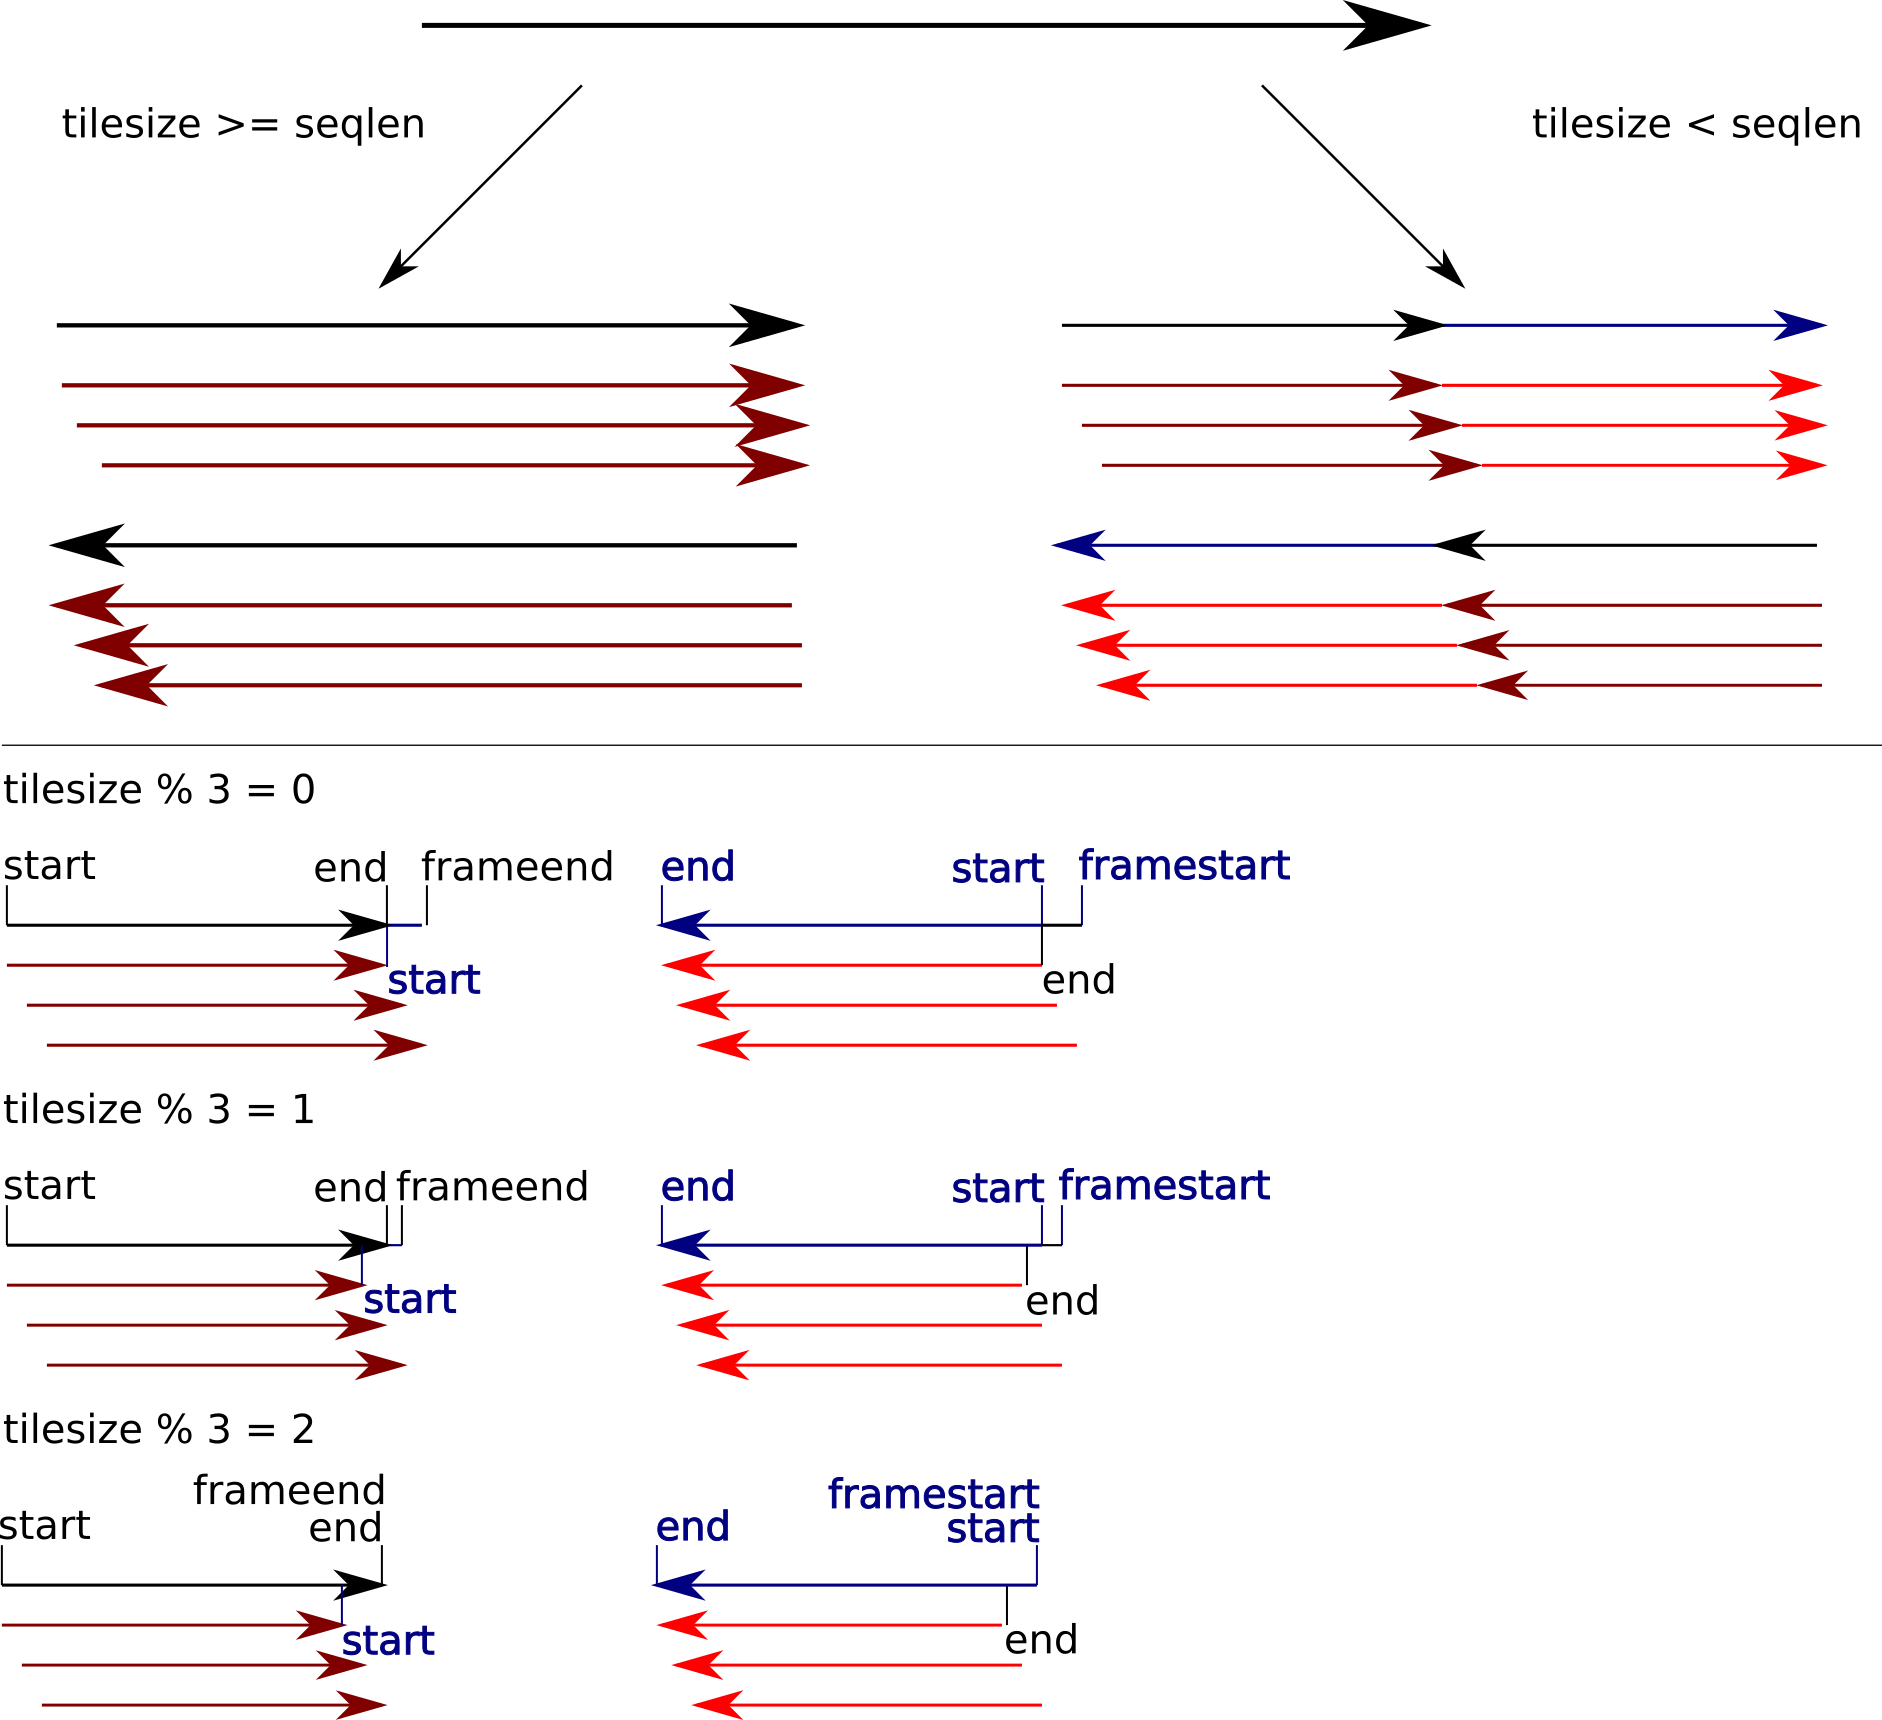

In [8]:
# manually handle reverse complements, assume that len(S) = x*3 + 2
def three_frame_translation(S):
    assert len(S) % 3 == 2, str(len(S))+" % 3 = "+str(len(S)%3)+"\n\n'"+str(S)+"'"
    T = []
    for f in range(3): # frame
        prot = ""
        for i in range(f, len(S)-3+1, 3):
            codon = S[i:i+3]
            if codon not in su.genetic_code: # real sequences may contain N's or softmasking or ambiguous bases
                prot += ' '                  # use null aa in that case
            else:
                prot += su.genetic_code[codon]
        T.append(prot)
    return T

def translateSequences(fwdSeq, pre_rcSeq, startPadding: bool, tile_size):
    rcSeq = pre_rcSeq[::-1].translate(su.rctbl)
    if startPadding:
        rcSeq += '  ' # add padding 

    # add padding to assure the right length for translation
    assert len(fwdSeq) <= tile_size+2, str(len(fwdSeq))
    assert len(rcSeq) <= tile_size+2, str(len(rcSeq))
    fwd_diff = (tile_size+2) - len(fwdSeq)
    rc_diff = (tile_size+2) - len(rcSeq)
    if fwd_diff > 0:
        fwdSeq += ' '*fwd_diff
    if rc_diff > 0:
        rcSeq = ' '*rc_diff + rcSeq

    assert len(fwdSeq) == tile_size+2, str(len(fwdSeq))
    assert len(rcSeq) == tile_size+2, str(len(rcSeq))

    # some nucleotides are part of both neighboring tiles
    aa_seqs_fwd = three_frame_translation(fwdSeq)
    aa_seqs_rc  = three_frame_translation(rcSeq)
    aa_seqs_fwd.extend(aa_seqs_rc)
    return aa_seqs_fwd

# try using a generator to get genome batches
#def createBatch(genomes, ntiles, aa_tile_size: int):
def createBatch(ntiles, aa_tile_size: int, genomes = genomes):
    assert aa_tile_size >= 1, "aa_tile_size must be positive, non-zero (is: "+str(aa_tile_size)+")"
    tile_size = aa_tile_size * 3 # tile_size % 3 always 0
    N = len(genomes)
    state = [{'idx': 0, 'pos': 0, 'exhausted': (len(seqs) == 0)} for seqs in genomes]
    while not all(s['exhausted'] for s in state):
        X = np.zeros([ntiles, N, 6, aa_tile_size, su.aa_alphabet_size], dtype=np.float32)
        I = np.eye(su.aa_alphabet_size + 1) # for numpy-style one-hot encoding
        for t in range(ntiles):
            for i in range(N):
                if state[i]['exhausted']:
                    continue
                    
                sidx = state[i]['idx']
                slen = len(genomes[i][sidx])
                
                start = state[i]['pos']
                end = min(slen, start+tile_size)
                framestart = max(0, start-2)
                frameend = min(slen, end+2)
                assert start < end
                assert framestart < end
                
                # update state
                state[i]['pos'] = end
                if end == slen:
                    state[i]['idx'] += 1
                    state[i]['pos'] = 0
                    
                if state[i]['idx'] == len(genomes[i]):
                    state[i]['exhausted'] = True
                                
                # translate and add tiles
                sequence = genomes[i][sidx]
                if type(sequence) is not str:
                    sequence = str(sequence) # with tf, input are byte-strings and need to be converted back
                    
                aa_seqs = translateSequences(sequence[start:frameend], 
                                             sequence[framestart:end],
                                             (start ==0), tile_size)
                for frame in range(6):
                    aa_seq = aa_seqs[frame]
                    assert len(aa_seq) == aa_tile_size, str(len(aa_seq))+" != "+str(aa_tile_size)+", start, end, frameend, slen, tile, genome, frame: "+str((start, end, frameend, slen, t, i, frame))                        
                    x = su.to_idx(aa_seq, su.aa_idx)
                    num_aa = x.shape[0]
                    if (num_aa > 0):
                        one_hot = I[x] # here still aa_alphabet_size + 1 entries
                        # missing sequence will be represented by an all-zero vector
                        one_hot = one_hot[:,1:] 
                        X[t,i,frame,0:num_aa,:] = one_hot
                        
        yield X

---

_**Test Batch Generator**_

Retranslate and assemble all batches, compare to translations of genome sequences

_So far, fails for seedFinding data, no idea why_

In [9]:
# limit test to subset of sequences for large genomes
if max([sum([len(s) for s in genome]) for genome in genomes]) > 100000:
    testgenome = [[]]*len(genomes)
    while max([sum([len(s) for s in genome]) for genome in testgenome]) <= 100000:
        i = 0
        for g in range(len(genomes)):
            if i < len(genomes[g]):
                testgenome[g].append(genomes[g][i])
                
        i += 1
else:
    testgenome = [[s for s in genome] for genome in genomes]
    
# translate and concatenate whole testgenome aa sequences
genome_aa = [[""]*6 for _ in range(len(testgenome))]
for g in range(len(testgenome)):
    for i in range(len(testgenome[g])):
        aa_seqs = su.six_frame_translation(testgenome[g][i])
        for f in range(len(aa_seqs)):
            genome_aa[g][f] += aa_seqs[f].replace(' ', '')#.lstrip().rstrip()

# prepare generator testing
rev_aa_idx = dict((i,c) for i,c in enumerate(su.aa_alphabet))

def to_aa(onehot):
    assert onehot.shape[1] == 21, str(onehot.shape)
    aa_seq = ""
    for c in range(onehot.shape[0]):
        if np.max(onehot[c,:]) != 1:
            continue
        else:
            aa_idx = np.argmax(onehot[c,:])
            assert onehot[c, aa_idx] == 1, str(onehot[c,:])+", "+str(aa_idx)+", "+str(onehot[c,aa_idx])
            aa_idx += 1 # argmax + 1 as in translation, empty aa is cut out
            aa_seq += rev_aa_idx[aa_idx]
        
    return aa_seq#.lstrip().rstrip()

X_to_genome_aa = [[""]*6 for _ in range(len(testgenome))] # for each genome and each frame, concatenate translated aa seqs

# create generator
#Xgen = createBatch(testgenome, 5, tile_size)
Xgen = createBatch(5, tile_size, testgenome)

# iterate through generator, transforming and concatenating aa sequences
# X.shape [ntiles, N, 6, tile_size, su.aa_alphabet_size]
for X in tqdm(Xgen):
    for t in range(X.shape[0]):
        for g in range(X.shape[1]):
            for f in range(X.shape[2]):
                x_aa_seq = to_aa(X[t,g,f,:,:])
                if f < 3:
                    X_to_genome_aa[g][f] += x_aa_seq
                else:
                    #fr = 5 if f == 3 else f-1 # for some reason, frames rotate in generator compared to direct translation
                    #X_to_genome_aa[g][fr] = x_aa_seq + X_to_genome_aa[g][fr]
                    X_to_genome_aa[g][f] = x_aa_seq + X_to_genome_aa[g][f]
            
# compare aa sequences
assert np.all(genome_aa == X_to_genome_aa), str(genome_aa)+"\n\n!=\n\n"+str(X_to_genome_aa)

2it [00:02,  1.46s/it]


AssertionError: [['NI*YRDWAPPNTGDFSVSVDSLTRNTLSGCNLECNIRLQPEARSNFPITLHQLGSMGSKPAETTDFYTVVQG*PKGDSCADD*SVDRREFVRPHNPR*TA*NILRNIDAFASSLSTFLRRS*MRA*AYGPCPMYNYAPAAMPTFN*QNRGS*SWWLSGKVVRYTGEPALADFLPISDGKNTIYRQ*RPGLRLLRVNVPCALISVNERKCPFRAE*ID*S*E*SFFVYCQ*SRISTHVQPGPAFFQSWHRYTFKLALPLSLAAQAKAFCGGLLGWK*DAPVLMTTVVWNAGLGLVNIR**GLLVIALSPSIDSRTDRLI*YK*NGSHSTP**TTNPPVK*MTWTYAGTK*AGFLESCNSGN*PTANDLDVQITFSCGGTLVSDHYVCTLDLFVDVSIAVVRVALVPMYPYSRMTSLAMIVG*CVSVHNKNRRLT*TSNQMGSSYPTPMLIASPVLEGGPRIRVVNDQFMLV*RPGDNH**SKTRGKICA*QRVNKRVLFV*YLLCRVTTTTWKGGSLLLCKSTGAYLGL*PPSAGDRALIGLVEGYSACGLIRNGFSDCNFGGQ*GTESLGQTPNRP*RHLLFCSFFIQSSPLPIHAT*YQ*PRSIGSTSAKVNLCYNSTRGLRKGGSRR*EECSLAYARLARRLRMLAPARVQTRH*GAPARMTGREKS*TRCDTECGVLPITYRNVLCPRFDHVWFPNASLRNVRAFT*GMDSKAQAIPVDVPLNKWILPASCH*CRVEQRHPVFISRIYTRTRLASRKIRQDSIESTTTYDNTIAYASQRLARRLIH*YPRTFSCMQSALWL*N*NACIPAVIASPLH*GLVVKTDRRKRPLSNHLSYTLLSSWREQEGSQVSRS*HGARLTHDQQCRIFCIHITVAVDPPSCPRVYVAGTTVSRSPRQSLAYLRYGNR*NQFVG*YNTSKFFE*ILARCGVAHVE*SGSCLYGKCARRPA*KMAADQTPPLASWST*PQDQGPARCASNSPQITDLQKIQIIAELDS*VWKHLISPFTRTSCVVSTGIIPGYLVQ*PFLDGILREAYSQDGAYLLMDPEYQEPWDRHSLWENR*NEKPGVPIHASVNPYTRSSHHSALYNYPRAEDPNPTPKLDSSIIHLLASE*AQDNHYAGDSAFMRSL*LTCMLSKIA*D*GLSLPTCLVFK*SRVHHHGLDTGGSRKGIRKAGYVS*RCV*PGHMGELV*QGVSDRRKKRNSA*PRSRNDGISTYIYIKLVTRFQGENNRNLQHIDT*FCVHSKTRCPSTFLSSALGIYTKKRAHHMALP*RVNIEPRSYSIRG*NG*IFCNVLVPLLRTCGWIHG*IYCGARVPTVDFPKFSPRDQGVLTLDTHAACPLTTPILLRRPPCRLLLKLPPSRERPVY*RPCRL*ISAGKR*CKCMGRIRHATPKRDCPRITLPYPVINPWHLSVCRTELIANRSRMWKISQSPGAGDNSVYSPYHRILVG*GPTNGPLFTSHLMVTCSHESCRPTGSSPGSVLITTTSFDWTKLVGMLYICRPVVRPLKQVRPCRKSVWL*TLQ*RMELLKPIGVELLLRVRQLANALLPWGGYLIYPTGLANYAHGTVVIRWPYYPLI*TVRDSAFLLQGGSSKRSRPGLAQPPGPVWTHTISYPYVEVLHIRYHGRRST*IHSLGWFCTP*GEPVGTSSDKVHSHWNRTAASEFGLKGSI**LVVLHRPTVGGN*HFVERLTYVRNLPLAPEVCSGPSVHAHSR*VPSPLKLVRTSTEATKRAVVYWAVTISRGVPQAGRTTD*RVAA*RLMQDLYLQLVARISHPNLMVQVRFSPVRSISCTREYHCALYHWRNTRPYYSTTQVVEQQSGRVNRIKRLPGVHNEPRSVLGVL*KVTFRHGRGCALRFLPPGSMIATRL*FPYTV*ANRL*GWYRHSNGVASKGA*CVGCSRRGAVADQFKIFDLKISGSASPSDVNDRRHP*DRTALSHGFAVRHARKRISSASFEAVKLL*FQAIMAQRQESVINRKAGDNYLLHAHVIRLQIQGSGCSPANRLPMTGNGRNASM*AAQPVTGSYYA*VATLIFHG*S*GIGL*SLQLSWTRGAGITPLF*RRVLSHVSQVHYHRTSRLFGESPSRSSHIQSRRSGNEPSILYPPVD*KNYKHHPTSLVAVPKVTQDLSIRDRSVYLYLFGTTGK*LRM*SAVPGSYMVTKVLVIGPLCCGARLRSHQES*RY*LWTSG*KHSVLCGVVVV*CPGQGNVTPYGSRNEQNAA*GIQRFSSGKYRLLLQFGAYSIV*RQGNDRQM*SFVGPKINCGHTGESTNCRPKTAPFT*YSKDRTNLLASKQNVIFFTVAPGTVNLEAITRPSHEFCQAVTTPS*PSAKSARVLTARFPTIAPPH*RQVRTGGCAGVLMSRRLPSVRAPDTEREMFTRVYTISPSESRLIYREDSRGAKLPSSEGYPVECGSYLAHPQLAK*LIWGSSMDRSEESLIP*LPKLNRLFSYALIDLSTIDPIALRSLL*VHPTRLK*TPAYTDGRPRKLTIRSQDTIVLAIQWFG*NDT*IYHSRAERRRLNVLGELGIRLELNTNACLMLSVSPKQFGSNAEQFTA*TS*WRRFTLGPGNSAQGPRMAVEGQFISKKEFWVSNHARALSRYGFFQVSTTTKSLDSFCRPTYDSVTKKLLSPSYPPPPTAKENKSCTGGETHPRKKVLAIRA*HTLFRSGETWGS*EVSAWDD*SEK*LIDDSVSV*CPVFRP*GYMRVCVLDTHKDIA*LQQSAAKLQQFLSVSLKRGFIWRVATLSFSLTNDMVSMDMEYSAPQHATRS*DTDRAFLNVTRSHFRIAYPILVAL*PAHPYSRPDLG*SACKRKSKGAET*SRQRT*GSRPPHGKPSTLNAAARGSSLDPYTM*SRSRSWMSQRLAYNGISVFLLIVFIL*WGDRLKPPVQTPP*ILVRSYATAYYRSVSRPNCRTTI*YRRRHLDGDLWVHFMQFHDIISQ*RQSSHEYLPTATDHDSSWVLRRTTRPASSGLCTFALRLARLLVDLSVPQPTPVGLPSSGLQKTFSRGDTSPSVPSYPGAFLGITPHQQSLASSIQLPGRQSVREGNAWKIFVAYMPMLKGCTYAMNLIYTRLDTGVIKTPPLRYWSRK*PNCI*SPSSTSLRPQDVGWRSFSFAS*TIAHSCTQCVT*ILICPVVCQESATRILYHDATRPSG**HRLTSGLERPQYRVKRGNPFRWKTSMKRDRTLSV*GIISGP*SSP*SRRIIEALRREQPEVPLFPFDQPELVNP*QRHPKWSGVE*CLMNINVDQCDSTTSPVRTEHPC*HTASSPCLFK*QRFVQKSQVRELDGHMSNISS*VFSCVVETRCLVKRMQAGRGT', 'TSDTEIGRHQTRAIFQ*ALIH*HATPYLDAT*SATLGYSRKPAATSQ*HCTNSGPWAQNRPKPRTSIRLYRDSLRETPVQTINR*TGGNL*GLTTLGELLETYFAILMHLRAVYRRFSDDHECVHRRTVLVRCTITLLQPCQPLISRIVARRVGGSVEKSYAIQESPHSRTFCRYLMARIQSTANKDLD*GCSG*TYLALS*VLMSVSAPFALNKLTSRRSDPFLFTASKAE*VHMCSRARLSSRAGIDILSNLHCPYPLRLRPKHSAVGSLDGSKTRPY**QPLCGMQVWD**TSGSKGFS*LLSVHRSIPELTGLSDTNEMVPILLHSERPTRQSNE*PGLTLELNRPASLNPAIRATNLQQMI*MYKLRSRAEVPLCLTTTSAP*IFLSTFLSLW*GSLWSRCIRTRV*LVLR**SGNACQFITKIAD*LRLAIKWGQAILRRC*SLVRY*REAPVSESSMTSLC*FRDRVIIISKVRHAGRYALDNG*TNVYCSYSISCAA*LRRRGREVACCYVNPPGPILGYSHHRQGTGP*LD*LKAIVRVD*SVTGSPIVTSGVSKVRSR*DRPLIDRSGICYFVRSSYNPVPCRFTQLDTNDLGALVLRPLRSTCVTIQLEDYAKEEVEDKKSALWPTRDWLVG*GCWLPLGCRLDTEAPQPE*QGEKSHKHAAIQNVGFFPSPIGMYYAHGSITYGFPMQACETYGRSHEVWIPKRRRSL*TSH*TNGFSQLVATSVE*SRGIPCSSLVYIPGLA*RAEKYDRTQLSQLLPMTTLLRMLAKDWPEDLSTNIRGHLVACNQLFGYEIRMRAFPQ*LHHHYTKVWLLKRTGARDLSQTTCLIRY*AHGGSKRALRFRAHNMEHV*HTISSVESSASTLPWRLIPPAVQGCT*PEPQCPGVHVSR*HISGMATDKTSSSASTILVSSSNEYWRGAESHTWSDQVPVSMVSVPVARREKWLPTKPRPLLHGALNLRTKVRPDALVTHHK*QICRRSRS*PN*IVEYGNI*SALLHVLPALSAQG*YLVTLFNDHFSMEFCARLIAKTEHTC*WTQSIRSHGTVTLFGRIGKMRSPEFRFTLA*IPTPAAATTLLCTTTHGLRIPTRHPSSTLL*YTSWRLSEHRIITTRVTPHSCDHCNSLACFLR*RKTEDSVCRLVWFSSRAGSTTTVSIPVAPGRASGKLVMSRKGVSNRDTWGSLCDKV*ATAGKNVTQLSHGRETTA*VLIFI*NW*PDFKGKIIVIFST*THDFVSTVKQDAPRHSYPLRWASTPKKEHTIWRYHSESILSLGPIVFVGRTDRSFVMF*SHYLGHVDGYTDRFIVERGSRQLIFPNSPPETKGYSL*THMQRAP*RLQYCCGALRADSS*NCRPAGSVQYTDVLAGYESRLANGNANVWAALGMLLLSVTARELRYHTPLSIRGTCLSAGLN*SPTGAVCGKSRSPQAQVIIQCIVHTTGSS*AEGQPMDPYSPLISW*HALTSLVVPQARRRVPC*LPQRRLTGLNWLVCYTYVDRL*DRLSR*DLVASRCGYRHYNKEWNFSNQ*ESSSSFASVNWQMRYYLGAVTLSILLD*QTMPMAQLLFDGRTIP*SRQSGIQPSSCKGGPRNAAAQGLLSRRGLYGRTQ*VIPMLKYFILDIMGVEVLKFTH*VGFAHHKASQWALLRTRYTHIGTAQLPRSSGSREASSDWLYYTVPQWGEINTS*SG*HMYATFP*HPKFARAPPCMPIVDEYHPH*SLSGQVQRRRNELWFIGR*RSRVGYLKQGAQQIDESPRSA*CKTCICS**RVYPILI*WSK*GSPLYVV*VAPGSIIARYTTGAILGHTIPRRKW*SNSPVV*TE*NAYLAFTTNHGQCWEYCEK*HSDMGVAVLCDSSPLDP**QRGCNSPIQFRQTVYEDGTVTVTASPQRALDV*VAVGGVLLPISSKSST*RSVGRRLPQTLTTGGTLKIALPFHTVLLFDTLEKGYLPLLSKL*NCFDSRP*WHSAKKV**TAKLVIIISSTLTSFDFRFKGPDVPPRIDCQ*LEMGEMLQCERHSQLRGHTMPRLRPLFSTDRVKV*ASNRFSYHGHEGQGSPLFSSGGY*VMFPRFITTGLLDFSGKARLVRVTSKAEGLVTSLLYYIRQSIRKITNITLRLWLPCPR*PKISRSAIGLFICTSSVPPVSNYECEVPSRDHTWSLRYWLSDLYVVARD*DPTRNHSDINCGLPVRNIQYFVAWWWYSVLARVM*HRMDLEMSRMQHEASSDFPLGSTVCYYSLVPTL*YSAKATTGRCEASWVRK*TAAILVNRRTVDQKPHLSHDIAKIVRIF*LQSKM*FSSRWRPVQLT*RPLPDRVMSSVKLLPHPANPQQRARASSLHGFQLLHLRIDGRCVQAVARGC*CLGVYPRFAPPTRSERCSLGYIRSHRVNHD*YTGKIVVAPNCPVPRAIP*NVEAILRTHNWQNDSYGAAQWTEVRRV*FLDYRSSIGYSPTPLLT*AQLIQLLYVLYCRSIQLDSNEHPPIRTAGPEN*RSDPKIP*YWQYSGSGETIHEFIIHVLRDVASMYLASWVSD*S*TQMRVSCFLCRLSSLVVTLSNLLRKRLSGGDSH*DQATAHRALGWQSRGNSSVRKNSGCLTTPERSHDTAFFR*AQQQKASTVSADLPMIP*PRSSYLRPIHPRRPLKRTNHVQAAKRTLERRYSQSEPNTRYSDQAKPGDRERSVHGTINQRSD**MTPSPSNARSLGLEDT*ESVCWIPIKTLRSFNNRRQNYSSF*VYLLSAALSGEWRHCRLASQTIW*AWTWSTRPPNMRLGVRIQIGRSLM*LVATFGLRTQS*WRCSLPTHTVGPTSDEARARGNRRALKHDRASGHRVHGLLTVSPAP*TPPHAGAL*TPIPCKAVAGVGCRKG*HTTGYPCSC*SCLSSDGAIV*SRPYRHPHKS*SVVMLRHIIAVSAVLTAGLRFDTGVAT*TGICGCTSCNSTIL*VSEGSPLTNTFRQLLTMIHHGSYVGRPDRRLVASALLHCDWPGFL*IFRFLSQHRLVYRQAAFRKHFPVETRPRASLHIRARSWASHRTNNL*RPLYSCPGDRASEKVMLGRFSSPTCPC*KVALML*I*YIRDSTPGLLKLLLCVIGHENNRIVYRVQARLLFGPRTWAGGPLALHLRRSHIAARNASPESSSVRLSAKSRLRAFYTTMQLDRQGDSIG*LQDLNGLSIESRGAIRSAGKHP*SETVL*ASRGSFQVRRAVPSLDGSLKLLEESSQRSHFFPSISPNW*IPSSDTQSGRALSDV**ILMWTSVTPQQVPLELNIHADILRPAHAYSSNNGSSRSLRSES*MAICLIFLLESFLALSKLDVW*RECRLVVAQ', 'HLIPRLGATKHGRFFSER*FTNTQHLIWMQPRVQH*VTAGSPQQLPNNTAPTRVHGLKTGRNHGLLYGCTGIA*GRLLCRRLIGRQEGICKASQPSVNCLKHTSQY*CICEQSIDVSPTIMNACIGVRSLSDVQLRSCSHANL*LAESWLVELVAQWKSRTLYRRARTRGLFADI*WQEYNLPPIKTWTKVAQGKRTLRSHKC**A*VPLSR*IN*LVVGVILFCLLPVKQNKYTCAAGPGFLPELA*IYFQTCTAPIPCGSGQSILRWAPWMEVRRARINDNRCVECRSGTSKHQVVRASRNCSQSIDRFQN*PAYLIQMKWFPFYSIVNDQPASQMNDLDLRWN*IGRLP*ILQFGQLTYSK*FRCTNYVLVRRYPCV*PLRLHPRSFCRRFYRCGEGRSGPDVSVLAYD*SCDDSRVMRVSS*QKSQTDLD*QSNGVKLSYADANR*SGTRGRPPYPSRQ*PVYASLETG**SLVK*DTREDMRLTTGKQTCTVRIVSLVPRNYDDVEGR*PAVM*IHRGLSWAIATIGRGQGPNWIS*RL*CVWINP*RVLRL*LRGSVRYGVVRTDP*STVAASVILFVLHTIQSLADSRNLIPMTSEHWFYVR*GQLVLQFNSRITQRRKSKIRRVLSGLRATGSSAKDVGSRSGADSTLRRPSQNDRARKVINTLRYRMWGSSHHLSECIMPTVRSRMVSQCKLAKRTGVHMRYGFQSAGDPCRRPTKQMDSPS*LPLV*SRAEASRVHLSYIYPDSLSEQKNTTGLN*VNYYL*QHYCVC*PKIGQKTYPLISEDI*LHAISSLVMKLECVHSRSNCITITLRSGC*NGQAQETSLKPLVLYVTELMAGARGLSGFALITWSTFNTRSAV*NLLHPHYRGG*SPQLSKGVRSRNHSVPESTSVASISPVWQQIKPVRRLVQY**VLRMNTGEVRSRTRGVIRFLSLW*VCPSPGVKNGCRPNPAPCFMEHLTSGPRSGQMR**LTTNNRFAEDPDHSRIR*LSMETSNQPFYTYFLRCQHRDNTWLPCSMTISRWNFARGL*PRRSILADGPRVSGAMGPSLSLGESVK*EARSSDSR*RKSLHPQQPPLCFVQLPTG*GSQPDTQARLFYNTPLGV*VSTG*SLRG*LRIHAITVTHLHAF*DSVRLRTQSADLSGFQVEQGPPPRSRYRWLQEGHPESWLCLVKVCLTGTHGGACVTRCKRPPEKT*LSLATVAKRRHKYLYLYKTGNPISRGK*S*SSAHRHMILCPQ*NKMPLDILILCVGHLHQKKSTPYGVTIASQY*ASVL*YSWVERIDLL*CFSPTT*DMWMDTRIDLLWSEGPDS*FSQILPPRPRGTHSRHTCSVPLDDSNTAAAPSVPTPPKTAAQQGASSILTSLPVMNLGWQTVMQMYGPH*ACYS*A*LPANYATIPRYQSVAPVCLPD*TDRQQEPYVENLAVPRRR**FSV*SIPQDPRRLRANQWTPIHLSSHGDMLSRVLSSHRLVAGFRVDYHNVV*LD*TGWYVIHM*TGCKTA*AGKTLSQVGVVIDTTIKNGTSQTNRSRAPPSRPSTGKCATTLGRLPYLSYWISKLCPWHSCYSMAVLSLDLDSQGFSLPPARGVLETQPPRACSAAGACMDAHNKLSLC*STSY*ISWA*KYLNSLIRLVLHTIRRASGHFFGQGTLTLEPHSCLGVRAQGKHLVTGCITPSHSGGKLTLRRAANICTQPSPSTRSLLGPLRACP**MSTIPTEACPDKYRGDETSCGLLGGNDLAWGTSSRAHNRLTSRRVAPDARPVSAVSSAYIPS*SNGPSEVLPCT*YKLHQGVSLRVIPLAQYSAILFHDASGRATVRSCKPNKTLTWRSQRTTVSVGSIVKSNIQTWAWLCSAIPPPWIHDSNAVVIPLYSLGKPSMRMVPSQ*RRRLKGRLMCRLQSAGCCCRSVQNLRPEDQWVGVSLRR*RQAAPLRSHCPFTRFCCSTR*KKDIFRFFRSCETALIPGHNGTAPRKCNKPQSW**LSPPRSRHSTSDSRVRMFPRESIANDWKWEKCFNVSGTASYGVILCLGCDPYFPRIELRYRPLIASVIMDTRGRDHPSFLAEGIKSCFPGSLPPDF*TFRGKPVSFESHPKQKVW*RAFYIISASRLEKLQTSPYVFGCRAQGNPRSLDPRSVCLFVPLRYHR*VTTNVKCRPGIIHGH*GTGYRTSMLWRATEIPPGIIAILTVDFRLETFSTLWRGGGIVSWPG*CDTVWI*K*AECSMRHPAIFLWEVPSAITVWCLLYSIAPRQRPADVKLRGSENKLRPYW*IDEL*TKNRTFHMI*QRSYESFSFKAKCNFLHGGARYS*PRGHYPTES*VLSSCYHTQLTLSKERARPHCTVSNYCTSALTAGAYRRLRGGVNV*AFTLGSRPRHGARDVHSGIYDLTE*ITIDIPGR*SWRQIAQFRGLSRRMWKLSCAPTTGKMTHMGQLNGQK*GESNSLITEAQ*AILLRPY*LKHN*SNCFTFSTVGPSNSTQMNTRLYGRPAPKIDDQIPRYHSTGNTVVRVKRYMNLSFTC*ETSPQCTWRVGYQTRVEHKCVSHAFCVA*AVW**R*AIYCVNVLVAAIHTRTRQQRTGPSDGSRGAIHQ*ERILGV*PRQSALTIRLFSGEHNNKKPRQFLQTYL*FRNQEAPISVLSTPADR*REQIMYRRRNAPSKEGTRNQSLTHVIPIRRNLGIVRGQCMGRLIREVINR*LRLRLMPGL*ALRIHESLCAGYP*RHCVASTIGGKITAVFECIS*ARLYLASGDTVV*PHKRYGKHGHGVLGPPTCDSELGYRSGVP*CDS*PLSDCVPNPSGAVACPPIQ*ARPRMKRVQEEIEGR*NMIAPADIGFTASSR*AQHPKRRRTRELFRPLYHVKP*PELDVAKVSIQRDIRVPVDRVYPLMGRSFEAARTDTPINPSP*LCYGILSQCQPS*LQDYDLIPASPPRRGFVGALHAIPRYYKSVKAVLSRIPSDSY*P*FIMGLT*DDPTGV*WPLHFCTATGQASCRSFGSSANTGWSTVKRPSENIFPWRHVPERPFISGRVLGHHTAPTIFSVLYTVARATERQRR*CLEDFRRLHAHVERLHLCYESDIYATRHRGY*NSSFALLVTKITELYIESKLDFSSAPGRGLEVL*LCILDDRT*LHAMRHLNPHLSGCLPRVGYAHSIPRCN*TVRVIA*ADFRT*TASV*SQEGQSVPLENIHEARPYSKRLGDHFRSVEQSLVSTDH*SS*KRAARGPTFSLRSARTGESLAATPKVVGR*VMFDEY*CGPV*LHNKSR*N*TSMLTYCVQPMPIQVTTVRPEVSGPRARWPYV*YFFLSLFLRCRN*MSGKENAGWSWH', 'LCHDQPAFSLPDI*FRQRKKRLKKKY*TYGHLALGPETSGRTVVT*IGMGWTQYVSMDVQF*RDLLWSHTGPH*YSSNITQRPTTLGVAARDSPVRADRREKVGPLAALF*ELQ*SVETRDCSTDLK*SPRRLEYGLASWMFSSGTDCPS*LYTEAVQVLKSAYAITLTV*LHRGIECA*PTLGRQPDR*GFR*RIACSYVRSSKMQS*RTSSPRPGAEEKSSLDSIYNSVIFVTNNAKEEF**PRCRVAYISDS*HKCNLSTWACRRRKSSKHYLL*RSVARATV*RTLKIVGAV*CPRTRPDMKGRSGTCLHGKMFSEGRLTVDQPVLAEEPKDLQEAWPVAVQKCRGH*TPVGSSYVRPMMNHGQ*LSEGIRERTAFTDL*YRGIA*SAPTNPRLGGDAGIKS*SCS*DG*HCDNMP*HNYGLGFMGVSVRAASNDRPIRG*TRSTGTRISRCMLTFATSNSGYGFTWYRGLKSSRVRRRLGCWAYREEAVNPMSAGAIMFQRPSISSCTRFIRGRAYCMGGQATAPLGLGTQSESGYESH*GTPDLYPNSESHVGGPSTPCPCLPYRL*G*TTVSPLAR*SRA*EIHSKTAVILPPIVEATQCLYGYPAHRLSCILKA*RPGIRRRRSHLLITSLINRPMH*PLTIPRFRLIGITCVRL*LRVPSFEGAFRRLYMICSL*RSAGVDRTEIGASWLRNHR*VCRNCRGFLLLCSPEKSRIVRALWRG*TPRILSY**IAPRLPSEGPVRCCLVLV*IAATKTFTQ*IAQRYYQTA*ATQKA*DTHLCSTLV*YPTRQVH*GDVSQHVNDKFMYRFTRTTVLPVLWYLGI*SSIFGAGRPYRRVFI*VELDGPTVENVKQLDQLCLSQ*GRRRIAY*ASVIKELDSPHFCPLSCPI*VILPVVGAQDSFHILRDSPRNWAIWRHDYLPGISIVIHSVRSYIPE*TSLAPCRGREPRVNA*TLTPPRNRLYAPAVNAEVQ*LETVQ*GRARSLLRVSWVW*QLDRTHDSVG*WPLG*LYRAPP*RKLHFALKLKDSYDLCYIM*KVRFLVYSSSIHQYGRSLFSDPRSFTSAGRCLGAIL*SRHQTVIADGTSQRKIAGCLMLHSAHF*IHTVSHYPGQDTIPPPRHKVLNVSNRKSTVNIAMIPGGISVARHNIEVR*PVP**PCMIPGRHFTFVVTYRWYRRGTNKQTDRGSRDLGLPWARQPKT*GDVCNFSNRLADII*KARYQTFCFGCDSNETGFPRKV*KSGGNEPGKHDLIPSARKEG*SLPLVSMITEAIRGLYLNSIRGK*GSQPRHSMTP*LAVPLTLKHFSHFQSLAIDSRGNIRTLESEVE*RERGGDNYHQLCGLLHFLGAVPLWPGIKAVSQLRKKRKISFF*RVEQQNRVKGQCDLKGAACR*RLRETPTH*SSGRRF*TDRQQHPADCNLHIKRPLRRRRYCDGTILIDGLPKLYRGITTALLSWIQGGGIAEHSHAHV*MLLFTILPTLTVVRCERQVSVLFGLHDRTVALPLASWNSMAEYCASGITRNDTPWCNLYYVQGRTSLGPLD*DGIYALLTADTGLASGATRRLVNLLCALLEVPHARSLPPNKPQLVSSPLYLSGQASVGMVLIYYGHARRGPSKLRVLGEGCVHMLAALRSVNFPPLWDGVIQPVTRCFP*ARTPRQLCGSNVSVPCPKKCPLARLMVCKTNLMSEFKYFYAHDI*YEVLQHRDNLLCASIQAPAAEQALGGCVSRTPLAGGRLNP*LSRSRDSTAIE*QLCHGHSLLIQ*DR*GNRPKVVAHLPVDGREGGARLLLV*EVPFFIVVSITTPTCDKVLPA*AVLQPVYICITYQPV*SSQTTLW*STRNPATSLWDDKTRESMSP*DER*IGVHWLALSLRGSCGMDYTLNYHLRLGTARFSTYGSCWRSVQSGRQTGATD**RGMVA*FAGSHA*E*HA*CGPYICITVCQPRFITGKDVSILDAPCWAAVLGGVGTEGAAAVLESSRGTLHVCLE*VPLGLGGRIWENQLSGPSLHNKSIRVSIHMS*VVGLKHYKRSIRSTHEYYRTEAQY*LAMVTPYGVLFFWCRCPTQRIRMSRGILFYCGHKIMCLCAEDYDYFPLEIGLPVLYKYKYLCRRFATVAKLSYVFSGGRLHLVTQAPPCVPVRHTFTRHNQLSGCPSWSHRYRDRGGGPCST*KPDKSAD*VLSLTLS*KACK*VTVIA*MRSHPRSDYPVLTQTPRGVL*KSRAWVSGWDPQPVGSCTKQSGGCCGCRDLR*RESELRASHFTDSPKESDGPMAPDTLGPSASMLRLGYKPRAKFHREMVIEQGNQVLSLC*QRRKYV*KG*LDVSILNYLIRL*SGSSANLLFVVSY*RIWPDLGPEVKCSMKQGAGFGRQPFFTPGDGHTYHRDRNLITPRVRLRTSPVFIRRTY*YCTSRRTGFICCHTGDMLATDVDSGTLWFRLRTPLDSWGDQPPR*CGCRRFYTADRVLNVLHVMSAKPESPLAPAMSSVTYKTSGLREVSCACPF*QPDLSVMVMQLLRECTHSNFITKELIACN*MSSDISG*VFWPIFG*HTQ*CCHR**LTQLSPVVFFCSLSESGYIYER*TRDASALLYTSGN*LGESICLVGRLQGSPALWNPYLM*TPVRFASLHWETIRDRTVGIIHSDR*WEEPHILYRSVFMTFLALSFWLGRLSVESAPEREPTSLADEPVARRPESTLLIFDFLLCVILELNCNTS*P*RT*NQCSEVIGIKLRESARDWIV*RTNKITDAATVD*GSVLTTPYLTDPRSYNRRTRYGLIHTHYSLQLIQLGPCPLPMVAIAQDRPRWIYITAGYLPSTSS*LRGTRDTIRTVHVCLPVVKRISSRVSYFTNDYHPVSKLA*TGH*RLGYGGLPLVPD*RLASA*DSLTPFDC*SKSVCDFCYELTRITRLSSQD*SYASTDTSGPERPSPQR*KRRQKDLGCRRSGQTQGYLRTRT*FVHLNHLL*VSCPNCRIQGSRPI*FQRKSRSFI*LAGWSFTME*NGNHFICIR*AGQFWNRSMD*EQLREALTT*CLLVPDLHSTQRLSLIRARLTSIQGAHRRMLWPEPQGIGAVQV*KYIYASSGRKPGPAAHVYLFCFTGSKQKRITPTTSQFIQRERGTYAH*HL*ERKVRLP*ATLVQVFIGGRLYSCHQISAKSPRVRALLYSVRLFH*ATNSTSHDSAN*RLAWLQERNCTSDKDRTPMHAFMIVGETSIDCSQMHQYCEVCFKQFTEGCEALQIPSCLPINRLHRSLP*AIPVQPYRSPWFRPVLSPWTRVGAVLLGSCCGLPAVT*CCTLGCIQIRCCVLVNQRSLKNRPCLVAPNLGIRC', 'CATTSLHSLYQTSSFDNARKDSRRNIRHMAI*LSDLRLLDEPLLLE*AWAGRSMSAWMFSSNGTCCGVTLVHINIHQTSLNARPLWVSLLGIHQFGLIEGKKWDLWLLSSKSFNDPSRLGTALRT*NDPLDA*STVSLHGCFPAERIAPLDSILRPFKS*SQPMLSP*RSSCIVV*NARSRLLADNRTDEDSGDALRAAMCDRLRCKAKGPPAHVLGPKRSRAWTLYTIRLFS*PITQRRSFNNPGVESRIYQIHSISATFQHGHVGDENLPSITFSDALSPGQLYRGR*RLLVRCDAQERARI*RDARGRVSTGKCFLKAA*R*TNRCWLRNRKIYKKPGQSQCKSAEATRRRSGRPT*DP**IMVSSCRKVFVRGLPSLTYNIVELHEVHPQIPV*VATPVSNRSPAVRTADTAIICRSITTD*DLWGCLYGRLQTIAPSEDKHDQQEHGYPVVC*PLRHPTPATALHGIGV*RAPACGGV*GAGLTVRRP*TLCPLARSCFSALRFPLARASSEVGPTVWVGRLQRH*DWVRNPKVATSHIKERPICILTPSRMLGGRVLHVHAYHIVCEAKRQCRHSPDKAALKRYTQKLL*FCRRLLKLRNVFMGIQHTDSHVSSRPKDRALDGDGVIY*SLL*LIVPCTDLSRSPGFA*SE*RVLGSDCEYLLSRVRFAACT*FVLFSGRRGWIGRR*ELLGYGIIGRSAETVEAFCCCAHLKKAVS*ERSGVVRHPEFFLTDELPLDCHPRALCAVAWS*CESPPLRRLRSKLLSVTTKLLRRHRKHETRICVQL*SDTQLAKYIEATSLST*MINSCIVSPEPLYCQYYGILGSDRQFSGPAVRIGGCSFESSWMDLQ*RT*SNWINCA*VNKGVGE*PIELR*SRN*TLLTSVH*AAPYESFCQLWVRKIASTFYGIALGTGQFGATTIFPVYQS*FTR*DRIYPSEHLSLRVGGANRG*TPRH*HPRATACTHLPSMRRCNSWKPCSEDARALC*GLAGCGNSLTELMTRSGNGL*VNCTGRHREENYILL*S*KIRTIFAISCERCGFWSTVRRFTSMAAVYFRTHEASHLPVVALALYYRVGTKL**QTVLPRGKSLDASCCILLISRSIRCHITLARTLYHHHATKY*MFLTGSPQLISL*FLVGSQSRATT*RSDNQYLSDHV*SRDGTSHS*LLTGGTEEVQINRPIADREILGYLGHGNQRRRVMFVIFLIDWRI*YRRLVTRPSALDVTRTRRAFPEKSRSPVVMNLGNMT*YPPLEKRGDPCPSCP**LKRLEAYTLTLSVENKGRNLGIV*PRNWLCRSH*SISPISSHWQSIRGGTSGPLNLKSNDVSVEEIIITSFAVYYTFLALCHYGLESKQFHSFERSGRYPFSSVSNSKTV*KGSAILRVPPVVNV*GRRRPTDLQVEDFELIGNSTPPTATYTSSAL*GDAVTVTVPSS*TVCLNCIGELQPRCYHGSRGEESQSTATPMSECYFSQYSQH*PWFVVNAR*AFYSVYTTGLLLYHLRRGIVWPSIAPVV*RAMILPGATYTTYRGEPHLDH*IRMGYTRY*LQIQVLHQALRGDSSICCAPCLRYPTRDRYRPINHSSFRRLCTCPDKLQWGWYSSTMGMHGGARANFGC*GKVAYIC*PLYEVLISPHCGTV*YNQSLDASLEPELRGSCAVPM*VYLVRRSAHWLALWCAKPT**VNLSTSTPMISNMKYFNIGITYCVRPYRPRRLSKPWAAAFRGPPLQEEG*IPDCLDQGIVRPSNNNCAMGIVC*SSRIDKVTAPR**RICQLTDAKEELDSYWFEKFHSLL*CL*PHRLATRSYLLKRSYNRSTYV*HTNQFSPVKRRCGNQHGTRRRACGTTRLVRACHHEMRGE*GSIGWPSAYEDPVVWTIH*IITCAWGLRDFPHTAPVGDQFSPADRQVPRIDNGVW*RNSRAVTLRSSMPNAAHTFALPFASRDS*PARTSVYWTLPAGRQF*EESARRAPQQYWSRQGARCMCV*SEYPLVSGGEFGKINCRDPRSTINLSVYPSTCPK*WD*NITKDLSVLPTNTIGPRLNIDSLW*RHMVCSFFGVDAQRRG*ECRGASCFTVDTKSCVYVLKITIIFPLKSGYQFYINISTYAVVSRPWLS*VTFFPAVAYTLSHKLPHVSRLDTPLRDITSFPDALPGATGIETVVVDPALLENQTSRQTESSVLRYLRKHASELQ*SHECGVTRVVIILCSLRRQEVYYRRVELGCRVGILSPWVVVQSRVVAAAGVGIYASVNRNSGLLILPILPKRVTVPWLLILWVHQQVCSVLAISLAQNSIEKWSLNKVTRYYPCADNAGSTCKRAD*MFPYSTI*FGYDLDLLQICYLW*VTSASGRTLVLRLSAP*SKGRGLVGSHFSRRATGTLTIETGT*SLHVCDSAPRQYSFEELTSIVLADELVLSVAIPEIC*RLTWTPGHCGSGYVHPWTAGGINRHGNVDAEDSTLLIVC*TCSML*ARNLRALLLPP*AQ*RIRQVV*ERSLAPVRFNNQTLV*W*CNYCGNARILIS*PKS*LHATKCPRILVDKSSGQSLASIRNSVVIGSS*LN*VLSYFSAR*ASPGIYTRDEHGMPLLYSTLVATSWENPFV*WDVYRDRLRFGIHTSCERPYVSQACIGKPYVIEPWA*YIPIGDGKNPTFCIAACL*LFSPCHSGWGASVSSLHPSGSQHP*PTSQSRVGQRALFLSSTSSFA*SSS*IVTQVDLSGRRTNAPRSLVSSCVNRQGTGLYEERTK*QMPLRSIRGLS*RLRTLLTPEVTIGEPVTD*STRTIAFN*SN*GPVPCRWWL*PKIGPGGFT*QQATSLPRRRSYAAQEILYEQYTFVYPLSSAYLPACLTLLMIITRSLN*HKLVIDDSDTGASL*YRTSD*HRRRIA*PHLIASLSQSAIFVMN*HALPDYHRKTSHTRVRIHRDQSDPHHSDRNVDKKI*GADVVVRHKGTSARERNLYI*IICCRLVARIAGFKEAGLFSSSVSPGHSFDWRVGRSLWSRMGTISFVSDKPVSSGIDRWTESNYEKPLLPDVY*SQTCIPHNGCH*YGRVLLPSKEPTAECFGLSRKG*GQCKFESISMPALEESRARLHMCTYSALLAVNKKGSLLRLVNLFSAKGALTLINTYESARYVYPEQP*SRSLLAVDCILAIRYRQKVRECGLSCIAYDFSTEPPTLRATILLIKGWHGCRSVIVHRTRTVRLCTHS*SSEKRR*TARKCINIAKYVSSSSPRVVRPYKFPPVYRLIVCTGVSLRLSLYNRIEVRGFGRF*AHGPELVQCYWEVAAGFRL*PNVAL*VASR*GVAC**INAH*KIARVWWRPISVSDV', 'VPRPACILFTRHLVSTTQEKTQEEILDIWPSSSRT*DFWTNRCYLNRHGLDAVCQHGCSVLTGLVVESHWSTLIFIKHHSTPDHFGCRC*GFTSSG*SKGKSGTSGCSLLRASMIRRD*GLLYGPEMIP*TLRVRSRFMDVFQRNGLPLLTLY*GRSSPEVSLCYHPDGLVASWYRMRVADSWQTTGQMRIQVTHCVQLCAIV*DAKLKDLQPTSWGRREVELGLYIQFGYFRDQ*RKGGVLITPVSSRVYIRFIA*VQPFNMGM*ATKIFQALPSLTLCRPGNCIEDAKDCWCGVMPKNAPGYEGTLGDVSPRENVF*RPLDGRPTGVG*GTERSTRSLASRSAKVQRPLDAGRVVLRKTHDESWSVAVGRYS*EDCLH*LIISWNCMKCTHKSPSRWRRRYQIVVLQLGRLTLR*YAVA*LRTRIYGGVCTGGFKRSPHQRINTINRNTDIPLYANLCDIQLRLRLYMV*GSKELPRAAAFRVLGLP*GGREPYVRWRDHVSAPFDFLLHALHPRSGLLYGWAGYSATRIGYAIRKWLRVTLRNARSVS*LRVACWGAEYSMSMLTISFVRLNDSVATRQIKPRLRDTLKNCCNFAADC*SYAMSLWVSSTQTLMYPQGLKTGH*TETESSINHFSD*SSHALTSHDPQVSPDRNNVC*ALIASTFFRGCVSPPVHDLFSLAVGGGG*DGDRSFLVTES*VGLQKLSRLFVVVLT*KKPYRESALAWLDTQNSFLLMNCPSTAIRGPCALLPGPSVNRRH*DVYAVNCSALLPNCLGDTESMRHAFVFNSSLIPNSPSTLRRRLSARE**IHVSFHPNHCIASTMVSWDLIVNFRGRPSV*AGVHLSRVGWTYSRERKAIGSIVLKSIRA*ENSLLSFGNQGIRLSSLLSIELPHMSHFASCGCAR*LPHSTG*PSELGNLAPRLSSRYINRDSLGEIVYTRVNISRSVSGARTEGKRLDINTPAQPPVRTCRQCGGAIVGNRAVRTRALFAEG*LGVVTA*QNS*LGRVMASRLTVPGATVKKITFCFEAKRFVRSLLYHVKGAVFGLQFVDSPVWPQFIFGPTKLHICRSLPWRYTIE*APNCNSRRYFPEENRWMPHAAFCSFLDPYGVTLPWPGHYTTTTPQSTECF*PEVHS*YRYDSWWDLSRAPQHRGPITSTLVTMYDPGTALHIRSYLPVVPKRYK*TDRSRIERSWVTLGTATKDVG*CL*FF*STGGYNIEGSLPDLLLWM*LERDGLSPKSLEVRW**TWET*LNTLR*KRGVIPAPRVHDN*SD*RPIP*LYPWKIRVAT*A*YDPVTGCAAHIEAFLPFPVIGNRFAGEHPDP*I*SRMT*AWRR*LSPALRFITLSWRCAIMAWNQSSFTASKEAEDILFLACRTAKPCERAVRS*GCRLSLTSEGDADPLIFRSKILN*SATAPRRLQPTHQAPFEATPLL*RYHPHRRFA*TV*GNYNRVAIMDPGGRNRRAQPRPCLNVTFHNTPNTDRGSL*TPGKRFIRFTRPDCCSTTCVVE*YGRVLRQWYNAQ*YSLVQLILRTGENLTWTIRLGWDIRATNCRYRSCIRRYAATRQSVVRPA*GTPREIVTAQ*TTARFVASVLVRTSFSGDGTHLLWACTEGPEQTSGARGRLRTYVSRSTKC*FPPTVGRCNTTSH*MLPLSPNSEAAVRFQCECTLSEEVPTGSPYGVQNQPNE*I*VLLRP*YLI*STST*G*LIVCVHTGPGG*ASPGRLRFEDPPCRRKAESLTV*IKG*YGHRITTVPWA*FANPVG*IR*PPQGSSAFAS*RTRRRSSTPIGLRSSILYCSVYNHTDLRQGLTCLSGLTTGLHMYNIPTSLVQSNDVVVINTEPGDEPVGRQDS*EHVTMR*EVNRGPLVGPQPTRILWYGLYTELSPAPGDCEIFHIRLLLAISSVRQTDRCHGLITGYGSVIRGQSRLGVACLMRPIHLHYRLPAEIHNRQGRQYTGRSLLGGSFRRSRHGGRRSSIGVVKGHAACVSRVSTPWSRGENLGKSTVGTLAPQ*IYPCIHPHVLSSGTKTLQKIYPFYPRIL*DRGSILTRYGNAIWCALFLV*MPNAEDKNVEGHLVLLWTQNHVSMC*RLRLFSP*NRVTSFI*I*VLMPSFRDRG*AELRFFRRSLTPCHTSSPMCPG*THLYET*PAFRMPFLEPPVSRPWWWTLLYLKTRQVGRLSPQSYAILESMQVSYSDRMNAESPA**LSCAHSDAKRCIIEESSLGVGLGSSARG*LYKAEWWLLRV*GFTLA*IGTPGFSFYRFSQRE*RSHGS*YSGSISKYAPSWL*ASRKIPSRNGH*TR*PGIIPVLTTQEVRVKGLIRCFHTQLSNSAMIWIFCKSVICGELLAHLAGPWS*G*VLHEARGGVWSAAIFHAGRRAHLP*RQEPDHSTCATPHLASIHSKNLLVLY*PTNWFYLLPYRRYASD*RGLRDTVVPATYTLGQLGGSTATVMWMQKILHC*SCVKRAPCYERET*EPSCSRHELSNV*DKWFERGLLRLSVLTTRP*CNGDAITAGMHAF*FHNQRADCMQLNVLGY*WISLLANLWLAYAIVLS*VVVDSIESCRIFLLAKRVRVYIREMNTGCLCSTLH*WQLAGRIHLFSGTSTGIACALESIPHVNARTFRKLALGNHT*SNRGHNTFR*VMGRTPHSVSQRVYDFSRPVILAGAPQCRVCTRAGANILSRRASRA*AREHSSYLRLPPLRNPRVEL*HKLTLADVEPMLRGHWYQVA*IGKGLDCMKNEQNNRCRYGRLGVCPNDSVPY*PPKLQSENPLRINPHAL*PSTNPIRALSPADGGYSPR*APVDLHNSRLPPFHVVVVTRHKRYYTNSTRLFTRCQAHIFPRVLLY**LSPGL*TSINWSLTTRIRGPPSSTGLAISIGVG*LDPI*LLV*VSLRFLL*TDTHYPTIIARLVIREYGYIGTRATLTTAIETSTKRSRVQT*WSDTRVPPHENVICTSKSFAVG*LPELQDSRKPAYLVPA*VQVIHLTGGLVVHYGVEWEPFHLYQISRSVLESIDGLRAITRSPYYLMFTSPRPAFHTTVVINTGASYFHPRSPPQNALA*AARDRGSASLKVYLCQLWKKAGPGCTCVLILLYWQ*TKKDHSYD*SIYSARKGHLRSLTLMRAQGTFTLSNLSPGLYWR*IVFLPSDIGKKSASAGSPV*RTTFPLSHQLYEPRFC*LKVGMAAGA*LYIGQGPYAYARIHDRRRNVDRLLANASILRSMFQAVHRGL*GLTNSLLSTD*SSAQESPLGYPCTTV*KSVVSAGFEPMDPSWCSVIGKLLRASGCNLMLHSRLHPDKVLRVSESTLTEKSPVFGGAQSRYQM'], ['WTSVQTHKPVRAPARKRYKLIRASYRLHEYHALPQGIT*SGLGLMTIIQYNVALM*VVFVGRGLRIVGSSSKASKYMGKSGTYIAS*SDQGLLGKH*WGSNTNASPRCSHRDEEYCRPEFVTSQALRMADTLVPVFTLVYRGSQASGVSVL*ALCRTERIFTHNGLGAPAYLVPSTGGLNDSF*RASLPKPLTRNARVSKTTPPAIGRS*AKGGTRICGCLEYQNQQDL*LLRISTSNDIDSRLVALNWHNRVTDSRFHQTHAR*LLCLNVFRSCVNGLVPSGAHK*TKYGRLLGADYAWSPRASSAQGH*LRI*DATKCCIG*VEGHHIGSNVLSGLLCQRLMYWFS*ANGVIPLSDLR*FCRKDCILLASTASNREGCPQWVTKRVEGRIWKASSTYHVPQRNTLP*SCVHRMLGR*PATHPSRRSRTYPMEPGIYAETDQDHKL*MFRLASPSAVAQTVEVNRW*ISLGVRLSRTLPPMPDL*LVPCCILLRLVYHLPPFSRTTTYDTVRQLYVFKWR*GSSIVRHF*DLRYCDPRLCDGLAILSVSQRSGCVYGLSDIARRPTRQVPVRVLT*IRK*KYRALAPTCQYGKVSTFRARR*FYATLNATANMPIARPRIAARSTLRPTDRRRWRPVWVNILAKIRRPASSPMPYLRKRTAWEHPPDRDK*ASTLSPPILIGNSSLRKSPV*TFRERRYQESIIA*PIN*R*ESRSQVRGVLDILP*LWV*PLLSVLGGCCR*LTSRGP*SHVTWLRFLGCSRL*RPV*LASAI*GALTLKS*QR*SGMSPPPGSSVTPEPIGSARRNTSPLSLYAH*YPTAGSPGPLAQPSLSRWLKV*TIPRIRNISTDS*ILYNVLVSGWIYQDSLVGSITVEQYDRDRTTRRA*LTKIDTE*APQKRVRSTGPMTL*RIYVGAGKFKFGIMASKGYPKQFPYTRGRSNAYEQMVVEFRKTTYVCL*ADRSDVHPQLGLKYSLTPSLLKDQIRPSMYIYHAPLSRCVVYISNAPAMLMCLSRRPRSQVQTYQSGPIFKFTFWGSHQRRPLFWARGHTICA*TEEKGTAAYSQRLAGIEQGLL*TQPRLPYKRNHGRHSGFDPR*NAHFWPQCAVLTWGRIRGNTQTSPSPYRGHNVCARLNLNAGAGGCPG*VRSVSCT*MA**HVFE**CVESVTGPITCLRLPSHTSP*PWQGDIWSPDVKIPILCIYGQSMAWHIIRQGLEVCSLRSSDNPPDVPFVGFLTGNTKRSVVLHSSCVQISKSTGSDVTLTDNALVKPSNLLPDTKQMVTSFLGHLPRVLDNQPTVSGAIKPRMHRPIPSTE*H*QAFDNKRSYTADTPAHTPNEVIIRTH*IR*WVISTRNSILGGGFGWSLGMAQITKCKGGDP*RRMFAK*DVSSGRTTDHRRGAEFPFDMGLGWWTFTRINNPRQCERLAYPVRAYKTRDYILHNDL*ATNYI*MRVVTVYI*GPLSPCNASRTIALHSKSSHIGTATNR*ELVFCLWRP*IR*GRAHKQRVKRRASATPHIVTPNGFRDDFGVLTPLDHQIEN*REISMEKDRWIKS*IYSPLLTIP*HEVAGDP***WMCSLQVSISTRQNVRAH*PHLLAPRSIS*SH*RDKRSPAT*NLLCTFLGCTR*RTSD*RPRTMATD*HIACRKSV*RTNLTEPSLTA*TVNYIRGYSGAYRWA*ICPVRSGYRTLPTDAL*YRIV*VYGTTRRCAERVNRLPRRLFGGVFHCEITLRTGGVGPV*RNLDQNVRSSTYTQAVVFRPISGAKRGPLHVYREFVRTAVY*LTSTCVVSKP*LDMALHVSRILTAG*QDLSPRGPNRATVFHLEHLYSPTAEPGR*GAPSLRVRKHPQFSMRVPVHAQRNVR*PKTNLPDWIFGPDSIDDWSTCDPCITVLVAANRKALPCSKGNCRFLLSISIPV*TRFA**ATCSFVLDLRERAREPREVIREAARWPLSPMGDIN*TYDDDGLVLSSCEPGRLKARVLVVRVLSIVAK*RLMDPLYQLLTLGDNGHYVQTDKVNCHKF*WT*LSPYSLTWHTKRCSNKQLILGRHQPLSPDTRVCPCLAR*DH*YRRWQTVH*LHKCCCTREGPVAVCNVTDRRLAHIRSQSKTLPRIVTAKSRSLNLAWSLTMASPSHPRLVVLYAYWLRGGCRSTAPRHLLLDATKH*AHNVKRQLPEYYRCTGL*SD**SQ**SWEQRPALDRSCQALHKPNFYSVCGRT*RLVTAAVCVTVIIYWLPYWTI*GSYCPNTSLYGHDMVEVLGTQGMINPHAPGFLEKLEEALPQQSGGLARTDWP**VYGGVEYIKLKSTTPFM*GSLYELLSILQP*SVNCSVSPVYTCLDLSSLETTGAMRCVCIISAVMYQPRIPQVRYSSLRP*SGTRHGLSAAVPPPGS*LPTECVELKIKSHRSVILFRIQHMWFFCVAIQIRGVLDLELGGAVNSVGSHAR*QGFNPLQTTKALQNR*VTHKLPRRRPTGTREGRHVRTRRPRVISLL*DLIDLSPTRL*RAQTTLKSLTRIYLIGAMTSRRIPAHSKFH*QSVLPLGA*PLTLSLGTVSSRECRCGLSDTGSTF*GPKFTYLLGRARLGIFVECLSWGSGRSGRVKDRSF*SRSVVIGDKRAWRYQTSNAI*TWRFRYLIRSGHPCFSY*FGRTAACLNPILENVTTFP*SAPRTLVAAGLSIKLCDTQ*ALLTLPRNPLGALATEVFSETTDKSYRY*FIIPGCTLGNVKLAIGSQIIECCSGRPRSLTFIL*QSGAQQTRPSS*VPTEPILGGGIGGRTTEYRFGGLLQLFNLS*TSVTNKSQQ*TSYGFVGRTAAHGVLVPFTL*VLHTDRMNSTETAP*KEPEDFALSPPRV*QRSFA*GKRHSPTVAQPGLIVKHAMLFVWRIVSPAHSDL*REAA*IS*VRKLERNM*SPLSSIPATEW*P**VELKTRLWFLRAPCRWLNEFSAGDVIPIELWYRR*SFKAR*RAELAVLLSESM*LPHIYLPDV*TKRHESI*TLMFTLNHVALQFASDWFGSCS*PAIQ*SVKSVGEFITVCCRPLRLLNHPPPLIRLLTSVISP*YRSPVARLILDFFYLVFRLLKVGNDNLY*GNRPNGVVGYCTTPLS*TA*FRSAYILPQKTAGSWLPQVFRTSSST*EGAGR*PSDSVPSTHVQGPTWIRCWRAHPYSRTTSNL*RFSSFRSSHHSYEYKGPNVKCPLWLTTRVAV*QPYKSI**HITD*FLTLIVASFPVCVKTQSTSAET*AGALFLAVGGHICLERTTGRLSTAICDSAGFARFSIKG*LRIAHMAHNHSENLITLNANGA*PTTFYPVCRSFISFRHCAGDRTFD*D', 'GPACRPTNPCGLPQESVTN*FGQATAYMNTTLFRRGLLEAVLV**LSSNTTWRLCRWCSWAGV*G*WVVHQRRVSIWAKVGLT*LRDRTRVYWGSISGDQIQMQVQDVAIGTKNIVDRSSSPHKPSAWPIL*YRSLLWSIAALKLVGCRCSERYVGQSVFSLITV*APRLIWYRARAA*TTRSKGRPSPSH*LEMPEYQRRLLLQLVDLKLKEGREFADA*NIRTNKIYNS*ESQRLMTLTQGS*RSTGTTA*PIPDSIKRTLASYCA*MYFVLVLTV*FRPARISKRSTAACLGQIMRGRLEHLQRKDTDFGFETQRNAV*DRSKGTTSDPTSCLAYYVKD*CTGSAKPMGLFHYRTCDDSVAKIAYC*RLRLVIGRAVPSGLLSALKGEYGRPHQPTMSLRGILCHSPVCTGCWAGDPRPILADVPGLILWSLGYTRKPIRTTNCKCSVWHPPPP*RRRSK*IDGKYRSV*GCLAPCPPCLIYNLSPAVSSYGWYITYRRSAELQLTIPFGNFMFSSGDRVVQSSATFKTYGTATPGYVTD*PS*ASPKDRGVSMVYLTLLDALHAKSQ*GC*RKSENKNIELLLLLVSTERLARSEHAGSSMQL*MLRQTCP*LALVSRPDPH*DRLIGGAGGLYGLISWLRYVGRLPLPCPTSANALPGNTLRTVISELRRSRRPF*SATHHCAKVQYKRFVRDDTKNRSLLSLLTNARNLEVRSGAYWTYFHNSGYNRC*VFWAAVVGNSRLEDRDPMLLGCDF*DAADCNARSDSRPRYEEHSH*NPDNADPG*VPRLEAQSLPSQLVQHVETRVRCLSMHINILLQDRQAPWRSPLYRDGSKFKLYRGLGT*ALTVEYYITCWSRVGSIRTVS*APSRSSNMIGTAPRGARN*LRLTLNRPPKKGCGVRVR*LCSGFTSAQVNSSLVLWHRKATPNSFLTHAVEATPMNRWLWSSERRRTFACEQTVLTYTPSWG*NIR*RLVF*RTR*DPACIFTMPLYLDAWFTFPTPRQCSCA*VAARGHRSRLIKVGLYSSSLSGVHINVDRCSGQGVTRSAHKPKRKEQQPILSG*PA*NRVSCKPNHGFLIRGTMDAIQDLTRGRTLTSGHSVRF*LGAVYGATHRLPLVLTVVIMFAHV*I*MQGRAVAQDKCDRFRAPRWHNNTSLNSSASNP*QDP*PVLDYPLIRPLDHGREISGHQMSRSRYSVFTVNLWRGTSFVKA*KFVR*GRRTIHQMYPLWVSSRVTQSDRLCFIVHVSKYPSLRARM*H*QIMH*SSLATCYPIRNRW*LVFSDTCPVSWTTNRLLVVP*NLECTGPFRVLSDISRRSIISGATPLIRRHILRMRLLFGHIEYVSG*FRHATLFLGEASVGR*AWLR*PNVKVAIRDDECLQSKTCRRAGPRITGVVQSSRSIWAWAGGPSHE*ITLGSASV*RIQFEHIKQGTTYFTTTFRPQITYR*GW*LCTFEVPYRPVTPLGR*HYTPNRVTLERRLTGRS*YFACGGLRSGRAGRISNGSNDVLLPPPIS*RLMGSGTTSVYLRHSTTKLRISGRYLWRKTDG*SHEYIVRY*PFPSTR*QEIRNSDGCVPYR*VYLLGKMFVHISPIYLHRVAFRDLTSGISGHQLHKISYAHF*VVPDSEPVISVQERWLLIDISRVASRCDAPT*LNPPSRHRQLITSGGIVVLTDGLEFVQFVLDIGPYLLTLCDIVSYEFTERPVGAPRELIAYRADCLVEFSTVRLP*GLAEWVRCNEIWIRT*GVAPTHRPLSSGLFPAPKEAHSTYIVNL*EQRCIS*LALASCPNPSWTWLFT*VGS*PQGNRTCHPGGRIGLPSSISNTYIPRRQNPGVRARPL*GFVSIHNFQCGFPCTRKEMYANLRPIYLIGSLVRIASMTGQHATLA*LYSSLLTARHYLVRREIAVSCYRSPFPCRHALPDKPLAVLF*I*GNAHVNPEKSSGKRLGGLSVPWVTSIRHMTMTA*SCQAASPEGSKLECWLSGSLVSSPNDV*WTLSTNYLL*AITDITSKQTK*IAISFSGLDCPHTRSPGIPSVVRTSS*YWAVINRFHRIRGSVHAWQDEITDTGVGRPCIDCINAVVRGRGPSPYAM*PIEDSHTSEANPKHSQGL*RPSLEASIWHGP*RWPVLHIRG*LFYMPTGSGGVAGPPLQGTYCWTQRNIEHIMSRGSYPSTTGARACEAINNPSNDHGSNVRL*IGHVKRFTNQTFIRSADAHDD*SQRLSVSR**YIGCLTGLFEVAIVRIQVCMGTIWWKCWVRKA*LTRTRPASLRS*KKHYLNKAEVWPEPIGHSEFTAGLNISNLSPLHRLCEVPYTNYYLYFSLNLLIVQFHRFTHAWTSQVWRRQVPCGACALFLQSCTSHGFPKSDIQVSGHDLGQDTVYQLQSRLRGVNYLLSV*S*RSKVTALSFFSGYNTCGFSASQYKFVGSLTSS*EVQSTL*ARTLDSKDSIHCKQRKRCKIAESRTSYLDVDQRGQGKADMFGLAGQELSPSFRT*LILAQRASNERKQL*KA*RESI**GQ*QADEFQRIVNSTNRASCHSALDP*H*ALARLVLVSVGVVFPIQAQPSKVRNSRICLAARG*VYLSNV*AGDQDDRDALRTAAFNPVLSSLVINVRGGIRLPMRFRLGGSDI*YAPVIHVFPTNLVAQLHVSTLF*KM*RPFPRAHQEL*SQRDSASSFAIRNKRY*PCREIHLARLRPRFLVKLQTSPIDINSLFRDVP*GT*N*PSGAK*SNAVPGVPDLSHLYYSNRAHNKPGRAARFQLSLF*GEESVAELRNTGSEACYNCLTYREPRSQINPSNKQVMASSVARLPTVS*FHSPCKFYTRTA*IAQKPPREKSQKTLPSVHLEFDSVRSLKGSGTRLRSLNLVL*LSTPCSSSGGLLAQRIQTYNVRRHEYHKFESWNGTCDPHCPQSLLRNGDRSE*NLRLACGF*GLRAGG*TNSQQGT*SLSSSGTDVNLLKHDEELS*QYFSRNPCSCRTYISRTCRPNATNLFEH*CSLSIT*PCNSLLTGSAVVRNPPFSSP*RASESSLLYVADLSVCLIILLL*SDCLLRSYPLNIGAR*PDLYWIFFTLCFGFSK*AMTIYTREIGQMV*WVIVRRR*ARRPDSALRTSYHRRLPGPGCLKFSERLVQPRKALVGNLRTLYLPPTYKDRHGSDAGEPIPIVGLLLTYKDFRVSDPLIIHMSIKGQTSSAPYGLPPVLQFDNPISPSNNTSRIDF*R**SRPFQYA*RLRARAPKLEPGHCS*QLVDISALNGRRVVCPPRSVTRLDSLDSR*KDNSVSHIWPTITVKI*SP*TQTVHDQQRFIQFVGVLYLSGTAPVTVLSIKI', 'DQRADPQTRAGSRKKALQTDSGKLPPT*IPRSSAGDYLKRSWSNDYHPIQRGAYVGGVRGPGSKDSG*FIKGE*VYGQKWDLHSFVIGPGFIGEALVGIKYKCKSKM*P*GRRILSTGVRHLTSPPHGRYFSTGLYFGLSRLSS*WGVGALSAM*DRAYFHS*RSRRPGLFGTEHGRPKRLVLKGVPPQATD*KCQSIKDDSSCNW*ILS*RRDENLRMPRISEPTRFITPENLNV**H*LKARSAQLAQPRNRFPIPSNARSLVTVLKCISFLC*RSSSVRRA*VNEVRPLAWGRLCVVASSIFSARTLTSDLRRNEMLYRIGRRAPHRIQRPVWLIMSKTDVLVQLSQWGYSTIGLAMILSQRLHTASVYG***GGLSPVGY*AR*RANMEGLINLPCPSEEYFAIVLCAPDVGQVTRDPS*PTFPDLSYGAWDIRGNRSGPQTVNVPFGIPLRRSADGRSKSMVNIARCEVVSHLAPHA*SITCPLLYPLTAGISLTAVQQNYNLRYRSATLCFQVAIG*FNRPPLLRPTVLRPQAM*RTSHLERLPKIGVCLWFI*HC*TPYTPSPSKGVNVNPKIKI*SSCSYLSVRKG*HVQSTQVVLCNSKCYGKHAHSSPSYRGQIHTETD*SEALEACMG*YLG*DTSAGFLSHALPPQTHCLGTPSGP**VSFDALAAHFNRQLITAQKSSINVS*ETIPRIDHCLAY*LTLGI*KSGQGRIGHTSITLGITAVKCSGRLL*VTHVSRTVIPCYLAAISRMQPTVTPGLTRVRDMRSTHIKILTTLIRDESPAWKLSHSRANWFST*KHESVVSLCTLISYCRIARPPGAALSIEMAQSLNYTED*EHKH*QLNTI*RVGLGLDLSGQSRRLHHGRAI**GPHHAARVTN*D*H*IGPPKKGAEYGSDDFVADLRRRR*IQVWYYGIERLPQTVSLHTR*KQRL*TDGCGVPKDDVRLLVSRPF*RTPPAGAKIFADA*SFKGPDKTQHVYLPCPSISMRGLHFQRPGNAHVPESPPEVTGPDLSKWAYIQVHFLGFTSTSTVVLGKGSHDLRINRRERNSSLFSAVSRHRTGSPVNPTTASL*EEPWTPFRI*PAVERSLLATVCGSNLGPYTGQHTDFP*SLPWS*CLRTSKFKCRGGRLPRISAIGFVHLDGIITRL*IVVRRIRNRTHNLS*TTLSYVPLTMAGRYLVTRCQDPDTLYLRSIYGVAHHSSRPRSLFVEVVGQSTRCTLCGFPHG*HKAIGCAS*FMCPNIQVYGLGCDINR*CTSQA*QLATRYETDGN*FSRTPAPCPGQPTDC*WCHKT*NAPAHSEY*VTLAGVR**AELHR*YAGTYSE*GYYSDTLNTLVGDFDTQLYSWGRLRLVVRHGSDNQM*RWRSVTTNVCKVRRVVGQDHGSPAWCRVPVRYGLGLVDLHTNK*P*AVRAFSVSSSSI*NKGLHTSQRPLGHKLHIDEGGNCVHLRSPIAL*RLSDDSITLQIESHWNGD*QVGVSILPVAALDQVGPGA*ATGQTTCFCHPPYRDA*WVPGRLRCTYATRPPN*ELAGDIYGERQMDKVMNI*SVTDHSLARGSRRSVIVMDVFPTGKYIYSAKCSCTLAPSTCTA*HFVISLAG*AVTSYIKSPMHISRLYPIANQ*LASKNDGY*LTYRVSQVGVTHQLN*TLPHGIDS*LHQGV*WCLPMGLNLSSSFWISDLTY*RSVISYRMSLRNDPSVRRES*SLTAPIVWWSFPL*DYLEDWRSGSGVTKSGSEREE*HLHTGRCLQAYFRRQKRPTPRIS*ICKNSGVLVN*HLRRVQTLAGHGSSRESDLNRRVTGLVTQGAESGYRLPSRTLIFPDGRTRALGRALFKGS*ASTIFNAGSRARAKKCTLT*DQST*LDLWSG*HR*LVNMRPLHNCTRRC*PQGTTLFEGKLPFPVIDLHSRVDTLCLISHLQFCFRFEGTRT*TPRSHQGSG*VASQSHG*HQLDI*R*RLSLVKLRARKAQSSSVGCPGP*YRRQMTSDGPSLPTTYSRR*RTLRPNRQSKLP*VLVDLIVPILAHLAYQALFEQAADTGPSSTAFTGYAGLSMLGKMRSLIQALADRALIA*MLLYAGGARRRMQCNRSKTRTHQKPIQNTPKDCNGQVSKPQFGMVPNDGQSFTSAVSCFICLLAPGGLQVHRSKALTAGRNETLST*CQEAVTRVLPVHGLVKRLIIPVMIMGATSGFRSVMSSASQTKLLFGLRTHMTISHSGCLCHGDNILAALLDYLR*LLSEYKFVWARYGGSAGYARHD*PARARLP*EVRRSITSTKRRSGPNRLAIVSLRRG*IYQT*VHYTVYVRFLIRTIIYTSALIC*LFSFTGLHMPGPLKFGDDRCHAVRVHYFCSHVPATDSPSQIFKSPAMIWDKTRFISCSPASGELTTY*VCRVEDQKSPLCHSFQDTTHVVFLRRNTNSWGP*PRARRCSQLCRLAR*IARIQSTANNESAAKSLSHAQVT*TSTNGDKGRQTCSDSPAKSYLPPLGLN*S*PNAPLTSANNFEKPNENLSDRGNDKQTNSSA**IPLTERPATRRLTPDIKPWHG*FS*V*VWSFRYRLNLLRSEIHVFAWPRAARYICRMFELGIRTIGTR*GPQLLIPFCRHW**TCVEVSDFQCDLDLEVPISNTLRSSMFFLLIWSHSCMSQPYSRKCDDLSLERTKNFSRSGTQHQALRYAISAIDLAAKSTWRACDRGF**NYRQVLSILIHYSGMYLRERETSHREPNNRMLFRASPISHIYIIAIGRTTNPAEQLGSN*AYFRGRNRWPNYGIPVRRLATIV*PIVNLGHK*IPAINKLWLRRSHGCPRCPSSIHPVSFTHGPHE*HRNRPVKRARRLCPQSTSSLTAFVRLREAALAYGRSTWSYS*ARHALRLADC*PSAFRPIT*GGMNIISSKVGTEHVIPTVLNPCYGMVTVVSRT*DSLVVFKGSVPVVKRILSRGRDPYRALVPTLIF*STMKS*ASSTSLGIHVAAAHISPGRVDQTPRIYLNIDVHSQSRSLAIRF*LVRQLFVTRHSVVRKERRRVHYCMLPTSPSA*SSSSSDPIAYFGHIPLISEPGSQTYTGFFLPCVSASQSRQ*QSILGK*AKWCSGLLYDAAELDGLIPLCVHPTTEDCRVLVASSFPNV*FNLGRRWSVTFGLCTFHPRTRTDMDQMLASPSL*SDYF*LIKIFEFQILSSFI*V*RAKRQVPPMAYHPCCSLTTL*VHLITHHGLISNADSRVLSSMREDSEHERRNLSRGIVLSSWWTYLP*TDDGSSVHRDL*LGWIRSILDKRITPYRTYGPQSQ*KSNHPERKRCMTNNVLSSL*EFYIFPALRR*PYFRLR', 'YLNRKYGHRRSAGKI*NSYKLDKTLLVMHRLRSG*LDFHCDCGPYVRYGVILLSRIERIQPSHRSRWTDDPSSVQGRYVHQLLRTMPRLKFRRSCSESSRILERTRLSALEINP*CVIRWTYRVVKLQHGW*AIGGT*RLALYTHMNDERI*NSKIFIS*K*SDYRDGLASI*SMSVLVRGWKVQSPKVTDQRLPRLN*TFGKLEATRTRQSSVVGCTQSGIRPSSSAASYNNPLHHLAYFPSIDCHCLL*EAETQGKKNPV*VWLPGSDIKGI*PK*AIGSEEEDD*ADGEVGNIQ**TLRRSLRTTEWRVTNNCRTSQKRIARLRD*E*TSMFK*IRGVWSTRPGDICAAATWIPREVLLAQLFIVL*KINVGTRAR*GSRPLLRIRLTTGTEPLKTTSES*VLLTTVTIP*QGLRTVGITCSVPTFELMIFMPPHVIGLNALG*QSARRRAWRA*L*DQVERP*ASAASLKRTNAVKLEVD*GQSLLALFTGRFLCYSCGPCVKLTG*MELGHRGQPCDRRSHNLFIAGIYL*PRFTIG*TIVASLRTGIP*FGHRFLPLK*AQLEPSCSAGFVVRPIAII*M*EIGDARNSIRLFGSRWLVSRSLRYIPE**INIDRTCL*FH*KPRSQARQVDFAARSIALIAYRKA*C*VPLRLKFLVRSRERSSHFLE*G*DMQLCDQISRKNMDDRSVLDIGTSKSKSHWKSDTSTHVYHQ*RQNGIKSCGP*RVPIVLIPSSNIRQIYLAARGQANT*ISDLRRLSLYRKDHTYTHEN*PCQGLMSGVKRRVAGRSVSGIYYALEFVCLSLPLSDRFSLGFSKLFALVRGALG*DQLSPKGGR*LLAGESEHVCLPLSPLVDV*VTCA*LSDFAALSLFAVD*ILAI*RASLQS*LHLLARGQGPHEFVLRRRKTTCVVS*KE*QSGDF*SSTLHTQ*VVNSPEAGLQLINRVLSQIMAGDLNI*LGESVAGT*LQK*CTRTAWHLSSPNLRGPGMCKPVKLNN*QIKAEV*IIVRIRNLT*TV*WT*V*YIQPRRKLTMANRFGPDLRFVEVMLLLTSQGSRARAG*SCLAYPALPPYRAHTNLYSDNSYLK*SSKAANILSP*HRQPL*LIVMCVRRPNKSLVCEALDMTDLKPDVAPMIITGIINRFTSPCTGSTRVTAS*HYVLNVSLRPAVSALERWTCNPPGASRHIKQLTADVKDWPSLGTMPN*GFETWPLQSLGVFWIGF*CVRVFDRLHCIRRRAPPAYNSIYAINARSANACISDLILPSMDRPAYPVKAVDDGPVSAACSNNAWYAR*ASMGTIKSTKTYGNLLCLFGRNVRYRLE*VVGREGPSDVIWRRY*GPGQPTLEL*AFRARSLTRLSRHRHMSN*CHPWD*EAT*PLP**LLGVHVRVPSNLKQNCKWLIRQSVSTREWRSITGNGNFPSNKVVPCG*QRRVQLCKGRMLTSHRCYPDQRSNQVDWS*VSVHFFARAREPALKIVDAYEPLKRARPNARVLPSGNISVRDGRR*PDSAPWVTSPVTLRLRSDSREEPCPARVWTRRKC*LTNTPLFLQIHDIRGVGLFWRRK*A*RQRPVCRCYSSRSDPDFVTPDPLRQSSR*SHSGKLHQTIGAVSD*LSRRTDGSFRKLIRYDITERQ*VRSDIQNELDKFKPIGKHHYTP*CN*LSMP*GRVQLSWCVTPTCDTRYVNQ*PSFLDANHWFAIGYNLEMCIGDFM*LVTAYPASEITKCYAVQVDGANVHEHFAE*IYLPVGNTSITITDLLLPRAREWSVTDYIFMTLSICLSP*ISPANSQFGGRVA*VHRSRPGTH*ASRYGGWQKHVV*PVAYAPGPT*SKAATGKILTPTC*SPFQCDSIWSVMLSSERRYRAIGDLKCTQLPPSSICNLWPKGRCEVCSPLFYMLELDTLNARTA*GYLFV*RSTSPSPYRTGTLHHAGDPWSCPTTRLTLQTFVVTDRHLYIWLSEPCLTTNRSLPQE*SCVSKSPTNVFNVSE**PHSEYVPAYQRCSSAYYRTPANVTQYSEWAGAF*VLWHH*QSVGCPGHGAGVREN*LPSVSYRVASC*A*LVHYLLMSHPSP*TWIFGHMNYEAQPIALCYP*GNPQRVHLVDCPTTSTNKLLGLDE*CATP*IDRKYRVSGS*HLVTRYLPAMVKGTYERVV*DRLWVLLRIRRTTIQRRVIMPSRCTKPIALILGNRPPLHLNLDVRKHYDHGKD*GKSVCCPVYGPKLEPHTVARSERSTAGQILNGVHGSSYKEAVVGFTGDPVLCRLTAENRLLFLSLRFMRRSCDPLPRTTVDVDVNPRK*T*I*AHFDKSGPVTSGGDSGT*ALPGRWKCKPRIEIEGHGKYTCWVLSGPLKD*ASANILAPAGGVRQNGLLTSKRTSSFGTPQPSVHRRCFYRVCKETVWGSLSMP*YQT*IYLRRRKSATKSSDPYSAPFFGGPIQCQS*LVTRAAWCGPYHIARP*WSLRDCPDRSNPRPTRYIVFNCQCLCS*SSV*FKL*AISIERAAPGGLAILQ*DINVHRETTDSCFYVLNQLARE*LSFQAGDSSRISVVRILM*VLLISRTRVRPGVTVGCILEIAAK*HGITVLET*VTYNSRPEHLTAVIPRVMEVCPIRP*PDF*IPSVS**AKQ*SILGIVSHETFILDFCAVMSCRLKWAARASKLTYHGPEGVPRQCVCGGRAWERKPADVS*PRY*PIQASSASDQSVSVWIWPRYEGELWACLP*HLELHRTTCVL*TC*PFRTDK*EQELYIFIFGFTLTPLLGLGV*GV*QCQINHRHTPIFGRRSRWLVRHIAWGRSTVGLKSGGRLNYPIAT*KHKVAERYRKL*FC*TAVSDIPAVRGYSRGQVIDQAWGARCETTSHRAIFTIDLLRPSALRRRGMPNGTFTVCGPDRFPRISQAP*DKSGNVG*DGSRVTCPTSGAHRTMAKYSSEGHGRLMRPSIFALQRA**PTGDSPPYY*P*TLAVCNLCDRIIASPIVE*PHWLS*TSTSVFDIISQTGRWIRCGALRPILYSISLRLKSEVSVLALKMLEATTHNLPQASGRTSFTYARRTELDR*HKNEIHLSTVTSERAFDGIGNRLRGCAS*ALRALSQCH*TLRFSGVINLVGSDILGIRKFSSLL*LKIYQLQEESSLILWHF*SVAWGGTPFRTSRLGRPCSVPNKPGRLDRYE*KYALSYIALRAPTPH*LESRDRPK*RPVLKYRPCGGLVR*RTPVDNILRPYGYILDLHLYLIPTNASPINPGPITKLCKSHFCPYTYSPLMNYPLSLDPGPRTPPT*APRCIG**SLDQDRFK*SPAEERGIHVGGSLPESVCNAFLREPARVCGSARWS', 'ILIESTVTGAVPERYKTPTNWIKRCWSCTVCVQGD*IFTVIVGHMCDTELSFYRESSESSRVTDRGGQTTRRPFKADMSTNC*EQCPGSSFGARALSLHAYWKGRDYQR*KSIRDVLLDGLIGLSNCNTGGKP*GALDVWPFILI*MMRGSETRKSL*VRSSPTIGMGSPASDPCRSLYVGGRYRVRRLPTSAFLG*TRRSENLRQPGPGSLLW*DVRRAESGRLAQRRRTITHYTIWPISLV*IVIAYFEKPKHKVKKIQYKSGYRAPILRGYDRSKQSDQRRRMIKQTERSATYSNELSDALYGLLNGGLRTTAEPVRSELQGYVIESEHQCSNRFVAFGLHVREIYVRQLHGFREKYC*LSSSSCFKRLTSVPELDRDHVPC*EFV*PPARSP*KPQASLKFYSLRSPFRSRD*GQWGSHVPFQLSNL*YSCRLTL*V*MRWANNPPDEEHGVLNYKTRLSDRRRVPLPLSERTLSNSRWTEGKVFWLFSRGGFCAIHAVRV*NLQGEWN*DTVGSRATDEAITCLLLGFICDRGSR*VKQL*QASEPVFRSSATDSSP*NRLSWNLAARPGLLCARLL*YKCERSGTPGTAFDYLAPDG*FHVP*GTSRNNELISIGLVCSFTKNLGRKRAKWISRQGQ*RLLRIAKLDAESRCD*SSWCALGKGRHIF*NRVETCSCATKLVGKTWMTGAY*ISEPPSLNRIGSLIPPRTFITNDDRTGLKAAVLNASRSS*SPAQTFDKYT*PRAAKQIREFRTLEG*ACIGKTTPTLTRTNRAKA*CQGSSAEWQDALLVEFTMRWNSSACHCPYQIDSR*AFQSCLRSLEARWAKIN*VLKEGDNSWPASPNMSAFPCPRWSTSR*LVRDSAILQRFRCLQWIESLLSSVRAYRVDCTS*LEVKDPTNLYCDAEKPHVLYPEKNDRAVTFDLQLYTLSR*LTPRRRDCS**TVSCPRSWPET*ISDLGNPWLVHDCRNNAHAPHGTCRLQT*EVQACVNR*N*TINRLRLKYR**FV*GTSHKRCSGLKFDIFNPAVNSLWPIGSGQTSALLR*CFF*LLKEAGRVRVNHALRTQHFHHIVPIQTCIRTIATSNSPVRQPIYYHRDTDSRCD*SSCASADRIKVWFVKRLT*PI*SRTLLP*SLLGLLIASQARAPVVLG*LPLDIMCSMFRCVQQ*VPWSGGPATPPEPVGI*NN*PRM*RTGHR*GPCQIEASRLGRYNPWECFGLASDVCESSIGYIAYGDGPLPRTTAFMQSMHGLPTPVSVISSCQAWTDPRIR*KRLMTAQYQLLVRTTLGMPGERVWGQSSPLKLMAIYFVCLDVMSVIA*SK*LVERVHQTSFGDDTKDPDNQHSSFEPSGLAA*QD*AVIVICLIDVTHGTERPPSRFPDDFSGFTCAFPQI*NKTASGLSGKACLHGNGDR*QETAISLRTR*CLAVSSDEYSYARVAC*PVIDAIRTKDPIR*IGLRLAYISLRVHGNPH*KLWMLTNP*RGRALTPGFCRRGI*VFEMEDGSPIRPPG*QVLLPCG*DPTHVKSHVQLGFGHDASAS*LIHRCSYKFTIYVEWASFGAGNRPEDNGLCVGATPHVLIQISLHRTHSASPQGNLTVENSTKQSAR*AINSLGAPTGRSVNSYDTISQSVSR*GPISRTNWTNSSPSVSTTIPPDVINCLCREGGFS*VGASHRLATRDMSISSHRSWTLITGSLSGTT*KCA*EILCSW*PLIPLVRSRNATRCK*MGLMCTNILPSRYTYL*GTHPSLLRISCYLVLGNGQ*RTIYS*LYPSVFLHRYLPLILNLVVEWRKYTEVVPEPIRRHDMGGGRSTSFDPLLMRPALPDLRPPQAKY*LLPVSRRSNVTRFGV*CYRPRGVTGR*GTSNVHSYHPHLYVICGLKVVVKYVVPCFICSNWIR*TLALPRVIYSCEGPPAQAHIERELCTTPVIRGPARRHVLLCKHSSSRIATFTFGYLSHA*RPTEASPKNRVACRNHPLTYSMCPNNNLIRSMCRRISGVAPLIIERLLMSLSTRNGPVHSRFYGTTNSRLVVQDTGQVSEKTSYHLFRIG*QVARLD*CIIC*CHIRARRLGYLDT*TMKHNRSLCVTREETHKGYIWWIVRRPQRTNF*ALTNDVPRHRLTVNTEYRDLDIW*PDISLPWSRGRMRG*SKTGYGSCYGFDALLFKDVLLCHLGARNRSHLSWATARPCI*I*TCANIMTTVRTRGSLCVAPYTAPS*NRTLWPEVSVLPRVKS*MASMVPLIRKPWLGLQETLFYAG*PLRIGCCSFLFGLCADRVTPCPEQRSTLM*TPESELEYRPTLISLDL*PRAATQAHEHCRGVGNVNHASR*RGMVNIHAGSYLVL*KTRRQRIF*PQLGVYVRTVCSQANVRRLSELHNHLFIGVASTACVRKLFGVAFRCHNTKLEFTCADVNPLQSHRTRTPHPFLGGLFSVNLS*LRAPRGAVPIILLDRDGAYETVLIDPTRDQHVI*YSTVSAYVPNPRYSLNFEPSR*RGLRQGAWRSCSRILMCIERQRTRVSTC*TNWLGSD*ASRRGTHPGSALSGF*CECSSYRGRESDRALQSAAS*KSQPSNMGSRSSRRELPTTAAQNT*QRLYPELWKYVQYAPDLTSRFLALVNRLSNDRFLVSSLTKRLYWTFAQ**VAD*NGRRERRSSLITVRRVFPGSAFAEVGHGRGSRPTYLSQDINPYRPPAPPISRSQCGSGRDTRASYGHVCRSI*SCIELPACSERANLSVLTSRSKSSIFLFSDLR*HPYWDLACRASSNVR*TIDTPRSLGDAQDG*SVT*PGVAVP*VLKVADD*TTLSPLENIKLPNGIVSCSSAERR*VIYQP*EDTAGDKL*IRHGGQGARQPHTERYLPSIYFDRLRYGGGGCQTEHLQFVVLIGFRVYPRLHRISPGTSARMGRGSPAQHPVHTGLWQSIPLRDMVG**GLPYSPFNALSNPLGTALPITSRRR*QYAIFATESSQVR*WNNPIGLAEPVHQSLT**ARQDVGSDVVPFDLSYTAFRCVSNPKSVSLR*RCSRRPRIICPKQAAVLRLLMRAGRN*TVNTRTKYI*AQ*LASVRLMESGIGYAVVPVERYEP*VNVIRR*DSQEL*ILLVLIF*ASANSRPSFSLRSTNCRRSRL*YSGISSQWLGEGRPLERVV*AARARYQISRGA*TVMSENTLCPT*RSEHRHPTSLRAAIDQSKDRY*SIGHAEGL*GDELRSTIFFVPMATSWTCICI*SPLMLPQ*TLVRSRSYVSPTFAHILTRL**TTHYP*TPAHEHHLHKRHVVLDDSH*TKTASSNPLRKSVVFM*AVACPNQFVTLSCGSPHGFVGLHAGP', 'S*SKVRSPAQCRKDIKLLQTG*NVVGHAPFAFRVIRFSL*LWAICAIRSYPFIENRANPAESQIAVDRRPVVRSRQICPPTAKNNAPAQVSALVL*VFTHTGKDATISVRNQSVMCY*MDL*GCQTATRVVSHRGHLTFGPLYSYE**EDLKLENLYKLEVVRL*GWARQHLIHVGPCTWVEGTESEGYRPAPS*VELDVRKT*GNQDPAVFCGRMYAERNQAV*LSGVVQ*PTTPFGLFP*YRLSLPTLRSRNTR*KKSSISLATGLRY*GDMTEVSNRIRGGG*LSRRRGRQHTVMNSPTLFTDY*MAGYEQLPNQSEANCKAT*LRVNINVQIDSWRLVYTSGRYMCGSYMDSERSTASSALHRALKD*RRYQSSIGITSPAENSFNHRHGALKNHKRVLSSTHYGHHSVAGIEDSGDHMFRSNFRTYDIHAASRYRSECAGLTIRQTKSMACLTIRPG*ATVGECRFP*ANERCQTRGGLRAKSSGSFHGAVSVLFMRSVCKTYRVNGTRTPWAAVRPTKP*LVYCWDLFVTEVHDRLNNCSKPPNRYSVVRPPIPPPKIGSVGT*LLGRVCCAPDCYNINVRDRGRPEQHSIIWLPMASFTFPKVHPGIMN*YR*DLSVVSLKTSVASAPSGFRGKVNSAYCVSQSLMLSPAATKVLGAL*GKVVTFSRIGLRHAAVRPN**EKHG*PERIRYRNLQV*IALEV*YLHARLSPMTTERD*KLRSLTRPDRPDPQLKHSTNIPSRARPSKYVNFGP*KVEPVSERPHLHSRELTVPRLNVRGQAPSGRTLC*WNLLCAGIRLLVIAPIR*ILVRLFKVVCAR*RRVGLRSIKS*RREITLGRRVRTCLPSLVPVGRRLGNLCVTQRFCSAFVVCSGLNPCYLACEPTELTAPPSSRSRTPRICIATQKNHMCCILKRMTER*LLIFNSTHSVGS*LPGGGTAADKPCLVPDHGRRLEYLTWGIRGWYMTAEIMHTHRMAPVVSKLERSRHV*TGETEQLTD*G*SIDNSSYKEPHINGVVDLSLIYSTPP*THYGQSVRARPPLC*GNASSNFSRKPGACGLIMPCVPSTSTISCPYKLVFGQ*LPQIVQ*GSQYIITVTQTAAVTNRHVRPQTE*KFGL*SA*HDRSKAGRCSHDHYWDY*SLHKPVHR*YSGNCLLTLCAQCFVASSSKCLGAVDLQPPRSQ*AYKTTNRGCEGLAIVRDHAKLRLRDLAVTILGSVLDWLLMCASLRSVTLHTATGPSRVQQHLCNQCTVCQRLYQ*SHLAKHGQTRVSGESG**RPSISCLFEQRLVCQVSEYGDNQVH*NLWQFTLSVWT*CPLSPRVSSW*RGSIRRHLATILRTRTTNTRALSLPGSQLDKTKPSSSYV*LMSPMGLRGHLAASLMTSRGSRARSLKSKTKLQVAYQAKRVYTGMEIDNRKRQFPFEQGSALRLAATSTVMQGSHVDQSSMLSGPKIQSGRLVLG*RTFLCACTGTRIENCGCLRTLKEGAP*RPGSAVGEYKCSRWKTVARFGPLGDKSCYPAVKIRLT*RAMSS*GLDTTQVLVN*YTAVLTNSRYTWSGPLLAPEIGLKTTACV*VLLLTF*SRFRYTGPTPPVLKVISQWKTPPNNRRGKRLTLSAHRRVVP*THTIRYHRASVGKVRYPERTGQIQAHR*APLYPLM*LTVYAVREGSVKLVRHTDLRHAICQSVAIVLGR*SLVRYRVQPRNVHRRFYVAGDRLSR**DHEMLRGASRWG*CARTFCRVDILTCREHIHHYYGSPATSC*GMVSNGLYIHDFIHLSFSIDISR*FSIWWSSGVSTPKSSRNPLGVTIWGVAEARRLTRCLCARPYLI*GRHRQNTNSYLLVAVPM*LDLECNAIVREALQGDRGPQMYTVTTLIYM*FVA*RSL*SM*SLVLYARTGYAKRSHCLGLFIRVKVHQPKPISNGNSAPRR*SVVLPDDTSYFANIRRHGSPPLHLVI*AMPNDQPKPPPRIELRVEITH*RIQCVRIITSFGVCAGVSAV*LRLLSNAC*CHSVLGMGRCILGFMAPLTVGWLSRTRGRCPRKLVTICFVSGSKLLGLTSALSVNVTSEPVDLDIWTHEL*STTDRFVLPVRKPTKGTSGGLSDDLNEQTSRP*RMMCHAID*P*IQSIGILTSGDQISPCHGQGDV*EGSLRQVMGPVTDSTHYYSKTCYYAI*VHETDRTYPGQPPAPAFKFRRAQTL*PR*GLGEVCVLPRIRPQVRTAHCGQK*AFYRGSNPEWRPWFLL*GSRGWVYRRPCSMPANR*E*AAVPFSSVYAQIV*PLAQNNGRR*CEPQKVNLNIGPL**VWTCDLGRRLRHMSIAGALEM*TTHRDRGAW*IYMLGLIWSFKRLGVSEYFSPSWGCTSERSAHKQTYVVFRNSTTICS*ALLLPRV*GNCLG*PFDAIIPNLNLPAPT*IRYKVIGPVLRTLFWGAYSVSILVSYARRVVRSLSYCSTVMEPTRLS**IQPETNTLYSIQLSVLMFLILGIV*TLSHLDREGCARGPGDPAVGY*CA*RDNGLVFLRAEPIGSGVTELPGGGLIPDQRCQDFNVSAPHIADASQTGRYSRLHPRNRSQVTWDHGPRDVSYLQQPPRTLNSGYTQSYGSMSNTPLT*LLDS*R*LIG*AMIDSWYRLSRNVYTGLLRSDELPIKMGGESVEAHLSRSGGCSQAVRLRR*GMGEEAGRRILAKILTHTGLQRLRSVGLSVDLAAIRGRAMGMFAVAFRVA*NYLRALNVLTFPY*QVGARALYFYFRIYVNTLTGTWRVGRLAMSDKP*THPDLWETLKMASPSHSLGSQYRRS*KWRTIELPYRHLKT*SCRTVS*VVVLLNGGK*YTSRKRIQQGTSYRSGMGGKVRDNLTPSDIYHRFTSTVCATAEGDAKRNIYSLWS*SVSAYIPGSIG*VRERRLGWVAGHLPNIRCTQDYGKVFL*GTW*VDEAFHIRPSTRLVTHWGQPSLLLAVDASSMQSLRQNHRKSDSGITPLA*LNQYISL*HNKPDRTLDPMWCPSTYPIQHFVASQIRSQCPCAEDARGDHA*SAPSKRPYFVYLCAPDGTRPLTQERNTFKHSN*RACV*WNRESVTRLCQLSATSLESMSLDVEILRSYKSCWF*YSRHPQILVPPLA*DLPIAGGVVFDTLAFLVSGLGRDAL*NESFRPPVLGTK*AGAPRPL*VKIRSVLHSAQSTDTPLA*EPR*TKVKTGTKVSAMRRACEVTNSGRQYSSSLWLHLGLAFVFDPH*CFPNKPWSDHEAM*VPLLPIYLLAFDELPTILRPRPTNTTYISATLYWMIVIRPRPLQVIPCGRAWYSCRR*LARISL*RFLAGARTGLWVCTLV'], ['N*RPELYPRRSVGIKQLIALCGNNDRTFS*DSRHMV*SHN*SLTTRPGRTAPYMGAGKAARSGHC*S*ECQEPVKTHLSLPHYAGYGIRGHLR*ALVLGSRVNGDGSIKPFWKV*RYRSDIYSRPYSLKLYSGRRINSMVLSRCGLVQIGHVSFKTSLNISTRCIDGDVPSGNTMWLGTEDNDKVAV*AESAIPPRTVSITPSKRSTIHC*LAQAFNRQYRAGTCGS*CQEAELVAAASPPCPKIHLVDV*CLRLRIARLWTPLQTV*IITVGLTHSEDTRLATCAYDSCYDTVCAHRPARSTGVGNLWRPLGYPGMCETTWNCGVRSELPILGDEDRESAPV*LCEYHGNRECIPNYSLTLCQWTVCSLSVFLPRLILT*QSEGIIKKDRRLISSVGSQLKAAYEV*TT*SGMYAK*IADLVQNGPCLCSGILCLHLHETS*DLKQSVSVTYFLGPRSR*SHRSYVHDTIPVLKRP*SVTGQNSALCWL*GRTNLPYCQAASLWFIRMYEGYENCILVVQ*YFIPAHGAKLPRARIARVQRVLSI*IDKSYSPTRVDATYARETG*YKTPARSS*EDNLNQCSL*PVAETSLDQPRPSYVYGPY*ST*VAKTTYSIIAQNNRL*H*ENRSPRYNVFKLLAGHKRNGV*IGREDVDTCSPWPQRYFARW*PD**D*QPLNHGVTSENSPCNRESASLHKLF*VISS*G*GYRNRCFRESGIQRVRTGYLVSWACTRPRVRAP*PLEAPRH*RR*DAIGATGPLLSREGHVRVHSWGRPFMIGKFVLPKCQTFLVTADIATRLPRRG**RSPSCCA*LTRSFPVMFGRV*NDAPPTFS*WQAFSLLQIKSYGYVNALSRRPRCLTCYCPSLHKLKIFFTPYRYSDPQ*FSRVLQRITLSTYSVHVRHCSLRYHSGLVGTE*GRRVHPVAVHHPSHILQWLVST*PAFIYRRARNPNRFPLLPTADRMGETRCRQACLNAQPSFLHMAKVLESLWVLFSHQPIKGESQNGVRPSLKVGCGTPGRAEKIKGYLCKTSSFRPRRSLQVMLVKAPRAPHKL*MKSPRRGWSANMSPRMRRATKTQGRRRCMKRLFHT*CTPTGNRTQHTGCRSCCLETLVFQLDGSLSY*HSATEPPYR*IIV*YVHEKGSYGCWDAVNMDRAGVVRIVPREAQSQLLLTDARFEIIPAAGQSVAHLAGRCL*RFLRTVTR*RLSGVLSLNDQPDSTVPA*IPRIASDH*RRISCSVSILPWRASC*VRPLTYLNPPKLSNLQGRVALWL*IRARSAIQVIPVRCERRASGVILIVDISEFHWHIEDGRCKLLS*PHSFIV*GCYHHVSW*ARICFRGAVQNIASSRRSAIIRSCVRLACTLTGSSYFL*MSLAPNGRWPT*LNEGWLKA*TNIQPGSLRNCV*IDWSLRQILSLSRRPLQRTFSQVLSPTAIIHAI*AKY*NEFEMARRSVCRKMH*RSSLSDLRRDVAGDYR*RTYWDKSLIVGR*PSALFSYFKLTINSVLDRAGIDCCLIDLIAFTALFLEAVRGVYAPLLASWMVLNCFSGRRSDTSGSLLRSHVWEGVNLSVTPPVNSRRCQRRALYDLLCLRLPP*DATTLQKY*DIRT*LSSCYCSQVLIPEKHSGSLRKANLFLLFRVDSVYSTASLFGIPTLLLTTFFYPNFLNAIARFSRACVRRRRA*A*KFALWVASLLVLRATQPTNHRPPSFIIDPRRIKVVR*SYRPTPEQNRRNPQCDTSSDASCEKDPKLHITRPWAVPPGLGHLELCRLFYGSHVIPICTRRRRSILRPTASVFRSGFFLPIVSSKVSLWTS*RVM*IPLKTSSSDRTGWIMSNHLVKDGMT*DMLERDIQVRAGSAGFPCLVFSGGVLLDFPRGSEM*LSPRTFSVERK*SL*KN*EYGLEAIEQLMYHERERRPEEDFTVDEAVTFVYHGFLG*PIQTNAKSFEV*SAELLIRGDLHWPAR*VFISEIRPVTEVLCQEGDPA*LLRPNQKR*TRRNLEF*ALFGTMV*AA*NPMRAGAFDC*RG*SQSCPQLCLPTVSANSFARAAIRPPRFLYVHALGTACPSVYLSQYLSFLFHGR**PTFEVGVATICSFSCPHNL*SAPPTPPRSGSGRISIQYVWAIRGLVTPRANLGECTIRKICPNSNTPKWYTCCRTTDGTINRVFYDKLNSLIYKGHCTRAALWRYQYEIL**FGTCRPSVKQVPVQYVGSTRCQIP*L*RHTWG*LDPVIAVG*NLGNSSS*NQIWTRNQEYRCALLFDTDPFP*KQLEQSIISS*GPVGRRVSAAPFRGRSTSQ*FGQVYRNR*LMTDRGKRMGTNE**FVMDLAPVREINRHHASIV*WITHVTMWSGLNWGRSEVHRSLTG*LS*HAGMVCMSSELSTALTYNLKCRHAFIVKLVARSIFLAVTIDLELVDGRISLETEANNSKSIVSPIYA*SRSRYIVIE*RQ**CRSVGAD*SRSL*SSGKGCSRMRRFNTVYAGRSIPSRVSRDV*HT*AIHRRPPVEPCLT*FRPQIPPACSYAPDTRRATRFCRAPTTGTLYYIAHVHYRS*FFHLNQRPQICILQRRARYLGPRPSGTSRRICGMVV*QKGAGCIVRTGLEKLLKSKIEKVCTNSNQGVYIQVVSVVPTYPGLAIVRIGVFRERRS**RHPGRPLSPHGPHQYL*IKTASIIS*LDSLPL*GVSRPHSRAETSRGALGVAPLLVLTELGSRGRGNLMRF*NTRSRLYARLS*LIAGPLGVPAICLYPKVTSFGHNRMYGPFQAGTPVCARASTLFINLTPRNIIAVSCFRIYDCVSLNFSAYFPP*GALTRMRRGY*SPFFLSCDRRAMVV*F**LLRHLGCHVLYMS*KRELH*DPPRTYTDSS*PHMPTCSTTEWKKERRPSNTVPCMSC*SHRDV*PSGF*HQYEIDL*VVNLLLEFITASFSFPVSIDDHDKY*YTTQKGAEF*DMFGAEAES*TRAW*MISPYLP*TFSWGRLP*STIWSWINGFSFSYSDSYVFTAYNRV*KYCFLAQLAGPGSGDYISS*T*HRVRHEGSTSALISPDNDLEAADRSLRYGPAAHYAATVETPSYLGPGPS*GYK*TTTSTQRDPYTNYSTLVITFEGFAGFPDDASHVVQ*TPFASDGEADREFAFASFPGVFNSGLSIRLPSGLPPLGSSVRVHGLRMIASRANAASNRGQHNYLPHLPVGCFVRECSNMNRARVTTSMVPRERNVIPRSNASIVTVSDRSSSVYRTRVEEKADAASTTV*PH*EIAWLVRAHLK*ALNRLATELWLLNSTSILSV*TSPEVYPVDSMGGIARLEVRATFDLRLMERTGLTTRSRTKA', 'TSGLSYILVEVLESSNLSPCAVITTGPSVKTRGIWYDPTINR*LHDRDEPPLTWEPVKLQDPVIVNPKSVRNQ*RPTCLCLTTRGMASGVI*GEPWYLALGLMVTDLSNHFGKFNATAQTFIVDRIALNYIPADGSTRWC*VAVGWCK*ATYHSKRRLISPHAVSMETCPVATQCGWALKIMTKWPYRQKVRFPHGLCQSRRPRGLLSIVNWPRRSIGNIEQGLVAVDVKKQNLSPRRRLLVPRYIW*TCNVYG*ELLDFGRLYRQYKL*PWD*LTQRIRGWQPARMIVVTIRCAHIDPLGALGLEICGGP*VIQVCAKRLGIAE*DLSCPSSGTRTEKVRPYDFVSTMVTENVFRTTLSPYANGRSVHYPSSSRG*FSLNNRRE*LRKIED*FRVWDPS*KQRMRSRLRSLACMQNR*PTWYKMDPAFARGYCVSICMRRHKT*SSPCLLHIFWGHDPVDPIDLTFMIRFRC*NAPNQ*RGRIPLYVGFRVGQICPIAKLHPFGLSECMKVTRIASWLCNSISFRPMVLNCPAQG*HGSSESYPFRSISHIHRLELTRLTPEKLDSIKLPPGPRERTT*INAACDLSLRPV*TNRDRLMSTARTSQHESPRLHTRSSLKTIGCSIKRIDPPDIMSSSYWLATNATVCRSAEKTSTRARLGRRGTSLAGSPISEISSR*ITA*HRKTHHVTESLHHSINYFRLYPHEGKGTGIAVFANLVYSE*GPGTW*AGPAQDRGYARRNHWRLHAIKDGKTLSVLRDRCCLGKVM*GFIPGGDLS**GNSFYQNARRSSSQLILPHGFRVVADKEARPAVRS*HARSQ*CSGGYRMMHLPRLVDGKHSVYCK*RATDT*MR*VDDRAV*LAIALPSTNLRYFSLPIVTLTHSDFLEFCRELLYQLTQSMSDIVHFVTTVAWSVRNEGGGYIL*LCIIQAISCNGWYRHSQHLYIGALEIQTVFRSYLRPIGWGKHVVGKPA*TRSPPFSTWPRY*KVSGCYSHISLSKESRRTESVPA*RWGAERLGGLRR*KDTCAKPQASGPGGHYR*CL*KLLGLPINYE*RALAEDGPRTCHHGCGEQQRHKGGGGA*RDFSIHDAPRRVTGPNIQAVAPAALRH*SSNWTVL*VTNTVLQNHRTVR**FNMSMKKGPMVAGMQ*IWIVLAWLE*CLEKLKASYC*QTPALKLYPLQASPWPI*PEGVCDDFSVRSLGSAYRAFYRLTTNQIPPFPREFRELQATINAGFRVAYQFCHGVHHAECDHSRILIRQNFPTCRAEWLSGYKFVHVAPYRSFLSVANAVRVELF*S*ISQNSIGT*RTEGVSY*VDHIPS*YKAATTM*VGEHVFASAGPFKTLPALGDPR*FGPASGLPVR*PVPLISCE*V*RPTVGGRLNSTRAG*RLEQTSNLEVYVTVSRLIGP*DRY*ASAAAPYNGPFRRSSVQPQ*FTLFRQSTRMNSKWRDVLFVVKCISEAHYLTFAAT*QVITGNVRTGTNL**SVDSRVLCLVTSS*QSIACWTALALIVV**T**RSQLCF*KRSAESMHLSWPVGWYLTVSQVEGQTRPVAFLGATFGKALISLLRPR*IRVDARDERCTTCSASVFLLRMRQPSKSTETLGPDCRVATVPRS*FQRNTQDP*ERRICFFYSGWTPYTVRPPYLAFQHCY*QHFFTQIS*TQLHVFQGLASVAGGREHRNLPFGLPPC*SYVQRNQPITDRRRLSLTHGGLKLYVNHTDLHRSRTGGTRNVTQAPTHHVRKIPSCTSRGPGPSLQALAT*SCVGYFTGRT*YLSVRGDGVQYYGLRHLYSDPAFSSQ*CLARCPCGHHEE*CEYR*KPVQAIELGG**ATT**KMV*LRTCWKEIFKYVLVPQDSRVWFSRVESYWISQGAAKCDCPPVHFL*NENKACKKIRSMG*RQLSS*CITNGNEDPRRISQ*MRR*PSCTMGF*ANQFRQTPSLSRSNLLNC**EGICTGPLDRSLSPKLDQLRKYCVRKVIQRDF*GRTRRGRRGGTWSSRLCSVRWSKRLETQ*EPERLTAEGVRASHARSFVSPPYQLTLSPVQPYARLDSSMCMP*VQHVPPFIYRSILAFCFTGVDNPPSK*AWLRFAHSAALIICKVHRRHLHDLEVAE*VYSTSGPYVV**LLERISASAQSVRYVRTPTRLNGTPAAERRMEQ*TGFSTIS*TASYIKDIVQERHYGDINMKSYNSLAHAGRRLNRYRYNTWVPLDVRSLSCEGTLGDNSTR*SQSAET*ATVVHEIKFGLETKSTGVRFSLIRTHFPENSSSNLSYPRRGQWEEEYQLRHSEDGPQVSNSARSIGTDDL*RTGVNVWEQTNDDL*WISHPLGK*IVITLP*FDG*HTLPCGAG*IGAGLKCIGA*RASCHSMQGWFVCHPS*VRLSHII*NAVMHL**S*SLDPYS*PLRLILS**MVGYRLKLRRTTVSLLCLPYMLNHVRVTS**SNVNSSVEVSARIDLAHSEVRAKGVAECVALTRYTPGVRSRVELAATFSIHKQSIGVRR*NPV*HSFVRRSLLLARTHQTHVEPHASVGPRRQVPSTISPMFITDHNSSTSIKGHKFVYSRDEHATWVLVRRAHRGGYAAWSCSRRGQVALFAPDLKSF*RAK*KKCAQIAIRECIYK*FRSFPHILGWLL*G*EFLERDGPNEGILAAH*VPMALINTSESRPLR*FHNWTASHYEAYLAPTRAPRRLEALLGLLPYLC*RNSAAVVAVT*CASEIRGPGYMRACLN*LPGHWEYLQFAYTPR*HRLDTTECMGLSKRELRSVLVPRLSLLT*LPVILSRYHVSEFMIVSASTSQLTSRRKGLSLE*GGVIDHRFFLAATAELW*YDFDSYSGTSGATYSTCHERESYTKTPHARTRIVVNPICQHVVPPSGKRNVAHQILSRACLVSHIVTSDRAVSDTSTRSICELLIFYWNSSPHPFPFRYPSTIMTSINIRRRRERSSETCSVRKRNRELEHGK*FRRICHKHLAGAGYLDRLFGHGLTDLVSATVTPTSSPHIIEFESIVF*LN*RDLGVETI*VPRHDTVFDTKAQLAHSSPRTTISRRLTGRCAMGPQHITPQQSRRPAIWVRDHREATSRPQPVRNATRTRIIAPW*SLSRVSLVFLMTRAMWCNRPRLLAMGRPIENLPSRLSRVFSTQDCRSACHRAFHRWVHPLGSMGFA**HLEQTQHPTEASTIIYLTYQSAALSGNVAT*TEPE*RPAWFRGRGTSSREVTRLLSPCRTGQAACIGRA*KKKRTQRVLQCSLIKR*RGW*GRT*SKLSIALLQNCGCLTQQAY*AFERAQKYIQSIRWAASPD*KSVPPSI*DLWNELG*RLGQGQRR', 'LAA*AISS*KCWNQATYRPVR**RPDLQLRLEAYGMIPQLIADYTTGTNRPLHGSR*SCKIRSLLILRVSGTSKDPPVSASLRGVWHPGSFEVSLGTWL*G*W*RIYQTILESLTLPLRHL*STV*P*TIFRQTDQLDGAKSLWVGANRPRIIQNVA*YLHTLYRWRRAQWQHNVAGH*R**QSGRIGRKCDSPTDCVNHAVQEVYYPLLIGPGVQ*AI*SRDLWQLMSRSRTCRRGVASLSQDTFGRRVMSTAENCSTLDASTDSINYNRGTDSLRGYEAGNLRV**LLRYGVRT*TRSEHWGWKSVEAPRLSRYVRNDLELRSEI*AAHPRGRGPRKCARMTL*VPW*QRMYSELLSHPMPMDGLFIIRLPPAANSHLTIGGNN*ER*KIDFECGIPAKSSV*GLDYVVWHVCKIDSRLGTKWTLPLLGDIVSPFA*DVIRPEAVRVCYIFFGATIPLIP*ILRS*YDSGAETPLISNGAEFRFMLALGSDKFALLPSCIPLVYPNV*RLRELHPGCAIVFHSGPWC*TAPRKDSTGPASPIHLDR*VIFTDSS*RDLRQRNWIV*NSRQVLVRGQPKSMQLVTCR*DQFRPTETVLCLRPVLVNMSRQDYILDHRSKQSVVALRE*IPPI*CLQVTGWPQTQRCVDRQRRRRHVLALAAEVLRSLVARLVRLAAAKSRRDIGKLTM*PRVCITP*IILGYILMRVRVQESLFSRIWYTASKDRVLGKLGLHKTEGTRAVTTGGSTPLKTVRRYRCYGTVVVSGRSCKGSFLGATFHDREIRFTKMPDVPRHS*YCHTASASWLIKKPVLLCVVNTLVPSDVREGIE*CTSHV*LMASIQSTANKELRIRKCVKSTTALFDLLLPFPPQT*DIFHSLSLL*PTVIFSSFAENYSINLLSPCQTLFTSLPQWLGRYGMRAAGTSCSCASSKPYPAMAGIDIASIYI*AR*KSKPFSALTYGRSDGGNTLSASLLERAALLSPHGQGIRKSLGVILTSAYQRRVAERSPSQLKGGVRNAWAG*EDKRILVQNLKLPAPAVTTGDACESSSGSP*IMNEEPSPRMVREHVTTDAASNKDTREAAVHEETFPYMMHPDG*PDPTYRLSLLLP*DISLPIGRFFELLTQCYRTTVPLDNSLICP*KRVLWLLGCSKYGSCWRG*NSA*RSSKPATVNRRPL*NYTRCRPVRGPFSRKVSVTISPYGHSVALIGRSIA*RPTRFHRSRVNSENCKRPLTQDFV*RINSAMACIMLSATTHVS*SAKTFQLAGQSGSLAINSCT*RHTGHSCPLRTPCEWSYFNRRYLRIPLAHRGRKV*AIELTTFLHSIRLLPPCELVSTYLLPRGRSKHCQLSAIRDNSVLRQACLYADRFLLFLVNEFSAQR*VADLTQRGLVKGLNKHPTWKST*LCLD*LVLKTDTKPQPPPLTTDLFAGPQSNRNNSRYLGKVLE*IRNGETFCLS*NALAKLII*PSPRRSR*LQVTYVLGQISDSR*IAECFV*LLQVDNQ*RVGPRWH*LLSDRLDSVHSSVFRSGPRSLCTSPGQLDGT*LFLR*KVRHVR*PS*EPRLGRR*SLCYAPGKFASMPETSAVRPALPPSSSLGCDNPPKVLRH*DLIVELLLFPGLDSRETLRIPKKGEFVSFIPGGLRIQYGLPIWHSNIVINNIFLPKFPERNCTFFKGLRPSQAGVSIEICPLGCLPASLTCNATNQSPTAVVYH*PTAD*SCTLIIPTYTGAEPAEPAM*HKLRRIM*ERSQAAHHEALGRPSRPWPPRVV*AILRVARDTYLYAATAFNITAYGICIQIRLFPPNSV*QGVPVDIMKSNVNTAKNQFKRSNWVDNEQPPSERWYDLGHVGKRYSSTCWFRRIPVSGFLGWSPIGFPKGQRNVTVPPYIFCRTKIKLVKKLGVWVRGN*AANVSRTGTKTRGGFHSR*GGNLRVPWVFRLTNSDKRQVFRGLIC*IVDKRGFALARSIGLYLRN*TSYGSTVSGR*SSVTSKAEPEEVDEAEPGVLGFVRYDGLSGLKPNESRSV*LLKGLEPVMPAALSPHRIS*LFRPCSHTPASIPLCACPRYSMSLRLSIAVS*LSVSRALITHLRSRRGYDLLIQLPS*FVKCTADTSTIWKWQNKYTVRLGHTWSSNSSSESRRVHNP*DMSELQHA*MVHLLPNDGWNNKPGFLR*AEQPHI*RTLYKSGTMEISI*NPIIVWHMQAVG*TGTGTIRGFHSMSDPLAVKAHLGITRPGNRSRLKLRQQ*FMKSNLD*KPRVPVCASL*YGPISLKTARAIYHILVGASGKKSISCAIPRTVHKSVIRPGL*EPMTYDGPG*TYGNKRMMICNGSRTR*GNKSSSRFHSLMDNTRYHVERVKLGQV*SASELDGLVVIACRDGLYVIRVEYGSHI*FEMPSCIYSEASRSIHILSRYD*S*ASRWSDIA*N*GEQQ*VYCVSHICLITFALHRDRVTSIVV*KCRRGLISLTLKFGQRV*PNASL*HGIRRAFDPESS*PRRLAYISNP*ASAGRTLFNIVSSADPSCLLVRTRHT*SHTLL*GPDDRYPLLYRPCSLQIIILPPQSKATNLYTPETSTLLGSSSVGHIAADMRHGRVAEGGRLHCSHRT*KASKEQNRKSVHK*QSGSVYTSSFGRSHISWAGYCEDRSF*RETVLMKASWPPIESPWPSSIPLNQDRFDNFITGQPPIMRRISPPLARRDV*RRSWGCSLTCVNGTRQPWSR*LDALLKYAVQAICAPVLTNCRATGSTCNLLIPQGDIVWTQPNVWAFPSGNSGLCSCLDSLY*LDSP*YYRGIMFQNL*LCQPQLLSLLPAVRGSHSNEAGLLITVFS*LRPQSYGSMILIATQAPRVPRTLHVMKERVTLRPPTHVHG**LTPYANM*YHRVEKGTSPIKYCPVHVLLVTS*RLTERFLTPVRDRFVSC*SSIGIHHRILFLSGIHRRS*QVLIYDAEGSGVLRHVRCGSGIVNSSMVNDFAVFAINI*LGQVTLIDYLVMD*RI*FQLQ*LLRLHRI**SLKVLFFSSISGTWEWRLYKFLDMTPCSTRRLN*RTHLPGQRSRGG*PVAALWARSTLRRNSRDAQLFGSGTIVRLQVDHNQYATRPVHEL*HPGNHFRGFRWFS**REPCGAIDPVC*RWGGRSRICLRVFPGCFQLRIVDPPAIGPSTAGFIR*GPWASHDSISSKRSIQPRPAQLFTSLTSRLLCQGM*QHEPSQSDDQHGSAGEERHPAK*RVYCHRVGQVKQRV*DARRRKSGRSEYYSVASLRDSVAGKGALKVSSQSPCYRIVAA*LNKHTKRLNEPRSISSRFDGRHRQIRSPCHLRFKTYGTNWADD*VKDKG', 'APLSLT*SSAQFVP*VLNRRWHGLLIWRCRPSNRLDILLGSFKRLVCLLS*AATIL*QGD*ELTLSAPLPATLSLNEATL*YSLRPLFLLRASYTRCLTCPTR*Q*TRYFAG*RSSPAEPCWSSLWLGSCCYIP*QSSRLVSEVNNCAGLGWMLRLLEMLSCEAHGP*RMNPAVEGPMAGGSTILS*KHPGKTRRQILDRPPHR*QTGSIAPHGSRHQENQRNPRK*LPGCYNSCTGRVAYWLWSTCSLTMVPDPNSWASRLLRRNVLRAHSAATGQPPRDRCPGR*VR*LSLRVEHGVMSRNLYSLHSQVPLIELKNNTFKLYYMR*RRRSHCS*N*IR*SMTK*SIKVTCPS*MFMANTAKSFTMLEFTIPLPHRTCLRTPLPSASYINTCHDRRWIPERKRMR**IPIED*QLTNRSRTGVRNRSVRRHDVTNKTCTGQYLMGDVPFSTRWYYMLAYGVNYYPCTCVGGLSVTLSFMTCRVRGTRGA*VAIKIILP*LCGRS*EKTVINNPASFE*EPLTAGSKLRS*G*HNHKF*NMIPR*YYGESS**RESRHEHRPEFPLGKAHTFGCVQTMSPWGISKLQVLPVARQLVKTGAHIAWTAYFRSASSYRDHGCRVPLTQVREQPQERL*TSRRASGGEIRLIMGGCPVMKLSKRS*FRGIDEGHGDSMGGQDAFIRTVSL*KLLSSQ*PAQDMWERPKLLVYTLPDCYLCTLFLFCSLEAFQVRCEQCNLPPSATRPCRISAAMCPTDEDPSSVLVSGVYKFVAFD*GGRIMICNEHGRYSRGYLSSGPYRSVWLYVCLVRTSKQEGSADETMLNRVLPADAYGLLMYAKRRG*LDSGSNARRIPC*SDAFGYTLCPNFRVSEINPRRHFYTTIDVTLSRCNANVIKHIWETQ*TYCCSPQFQAISDHLLAQDQS*RLRIWIERLASL*MHDGISNYM*EPYSTRMTYKPSLHAMTTSPSSSDALQTCPNLTRSTW*RVLSIKLWKRDDDLFP*RVRDPLQIIIRLFPYVYPGPS*VIGSYRPGRITDLWTVLGMAQLILFFPLAPTRI**IARAVFREMGPYQREAHTGTLGF*SKFDFMNYCCLSFSRLRLPGRVIPKCAFTAKGSDIEWNPRIVPVPV*PTACMCQTIIGFHIDISIVPLLYNVLYI*GCSAYRRKPGLLFHPSFGSRCTI*ACWSSDISYGLCTRRDSLEELLDHVWPRRTVYLFCHFQIVEVSAVHFTNYEGS*MSKS*PRLLRRWVINARETES*DTAIDKRRDMLYLGHAHRGIEAGVWLHGRKS*LIRWGDKAAGMTGSNPFSSQTLRLSLGFKPLRPSYRTKPRTPGSASSTSSGSALEVTLDHLPDTVLP*LV*FRR*RPIERASANPLLSTIQQIRPRKTWRLSELVSLKTHGTRRLPPHLL*NPPRVFVPVRDTLAAQLPLTHTPNFFTSFIFVLQKMYGGTVTFRCPLGNPIGLHPRKPDTGILRNQHVLEYLFPTCPKSYHLSLGGCSLSTQFDRLNWFLAVFTLLFMMSTGTPC*TLLGGKSRI*IQMP*AVILNAVAAYR*VSRATRKIAYTTLGGQGLEGRPRAS*CAAWDLSHMMRRSLCHIAGSAGSAPV*VGMINVQL*SAVGQ**TTAVGDWLVALHVRLAGRQPKGQISMLTPACDGRKPLKNVQLRSGNLGKKMLLITMLECQIGRPYCIRSPPGIKETNSPFLGILSVSLESRPGNSSNSTIRS*CLSTFGGLSHPKEEDGGRAGRTALVSGIDANLPGA*QRD*RLPKRGS*EGYRTCLTFYLRNS*VPSNWPGEVHRLRGPLLKTEL*TLSSLSDNNQCQRGPTRY*LST*SN*TKHSAIYRLSEICPSTYVTCNHLLRRGEGQIMSFANAFYDKQNVSPFRIHSSTLPK*RELLRLD*GPAKRSVVRGGG*GLVSVLRTNQSRHSYVDFQVGCLFKPLTSPR*VKSATYRWALNSFTRNKRNRSAYRQA*RRTELSRIAESWQCFERPRGSKYVLTNSHGGSSLIL*RNVVNSIAYTFRPLCANGILRYLRLK*LHSHGVRNGQE*PVWRYVHEFIAREPLCPASWKVLAD*DT*VVALSMMHAMAELIRYTKSCVNGRLQFSEFTRERWNLVGR*AIERPISATE*PYGEIVTDTFRLNGPRTGLQRV*FQSGRLLTVAGFELL*ALF*PRQHDPYLLHPSNHRTLFHGHIKLLSNGTVVL*HCVSNSKNRPIGRLMSQGSRSDSLYVGSGYPSGCIMYGKVSSCTAASLVSLLLAASVVTCSRTILGEGSSFIIYGEPEELSQASPVVTAGAGSLRFCTSILLSSQPAQAFRTPPLSWDGLRSATLL**ADVRITPRDFLIPWPCGERRAARSSRLADNVFPPSDRP*VRAENGLDF*RAYI*MLAMSIPAIAGYGLDDAQLQDVPAALIPYRPSHCGNEVNNV*HGLSKLIE*FSAKLEKITVGQSNDRE*KIS*VCGGKGNSKSNSAVVDLTHLRIRSSLFAVD*MLAIN*TWEVHHSIPSRTSLGTSVLTTHSRTGFFISHDAEAVWQYQL*RGTSGILVKRISLS*KVAPRNEPLHDLPETTTVP*HR*RLTVFNGVEPPVVTARVPSVLCRPSLPSTRSLLAVYQIRENSDSCTLTLMRI*PKIIYGVMQTLGYMVSFPMSRRDLAAANLTNRATSERSTSAAKASTCRRLLCRSTHRCVCGQPVT*RHYIGGIYSLNATTDCFER*SSM*SWRLMLTSTGRRHKTVSVGLNWSQRQVTSCIDLGCPLTRTWREFYTIQFLWRKSRQLESVNMTYRSKWIGLAGPVLSLRGAV*HHGPE*NTIAQPGCNSRNLHTFG*TKGMQLGNRANLSDPKANIKRNSAPLLIRGVSAPESYHERKIYGINGIVAPKNM*QTRTASGLMTSHANGDTISPSKGRVHFVPSRLSILHTCQTT*SRPHTLLLAGIPHSKSIFYLS*LFPPIVK*ELAAGGRRIMNRPSIGIG*ESSSEYILCYHGTHKVIRAHFLGPRPRGWAAQISLRNSKSFRTYLDNLGASTDFQPQCSERVYVRTPYRNNYHTRRLPASYPLSESVPRL*FILSVEASKVEQFSAVDITRLPNVSWDKEATPRRQVLLLDINCHKSLLYIAY*TPGPINNG**TSWTA*LTQSVGESHFLPIRPLCHYLQCPATLCCHWARLHRYSVWRY*ATF*MIRGLFAPTHSDLAPSS*SVCRNIV*GYTVDYKCLSGSVKLSKMV**IRHH*P*SQVPRLTSNDPGCHTPRSEAETGGSLLVPDTLRINNDRILQLYRLPCKGRFVPVV*SAINCGIIPYASSLN*RSGRYYRTGR*VA*FQHFYEDIAQAAS', 'RLCP*PSRQPSSFHKS*IEGGTDF*SGDAAHRIDWIYFWARSNA*YAC*VKQPQFCSKAIESLL*VRPYQPRYLLMRLHCSTRCVRFFFYARPIHAA*PVRHGDNRRVTSRDDVPLPRNHAGRHSGSVHVATFPDKAADW*VR*IIVLASVGCCVCSRCYHAKPMDPNG*TQRWKARWQADRQS*VENTRERREGKFSIGLPIASKRGLLHHMARVIRKTSETLESDYQGAIIRVRVALRTGCGLLVASRWSRTQIAGRLDCCGVMCCGPIAQRPVSRLEIVVRGDECAS*AFVSNTVSCLGTYIVSTPRSR*LS*KTILSNSIICGEDVGVTVAETKSVNP*PNSRSR*PAPAKCLWQIRRNHLPCSSSRFRFRTEHVSELRSLLRRILILVMIVDGYRKGKGCGDEFQ*KINNSQIDLVLVSETARSDVTM*LTRHARDSI*WATFLFPLGGTTCWHMGLTTIRVRAWGVLV*LSLS*HVEYVAPEVPE*LSKSYYHSSAVAAKKKR*SITPPHSSESPLRREVS*EVEADTIINSET*YRDNITGSQVNKESRGTSTDRSSRLERPIHSVVSKRCHLGV*ANCRYSQWPGN*LRQARI*PGPRISEAHQVTATTAAEFR*HK*GSNPKSASRRLGARVGARYAS*WEAVQL*NYRSGLDSEVLMRAMGTQWAARMPSLGPSLSKNSYPHNSQPRICGNDRNYLYIHSLIAICAHFFYFAL*KLFKSGANNATCPLLLHDHAAYPPRCARRTRTQVACSSLEYTNLWPLIEVEEL*SVMNMGDIVEGTCRRGPTEACGSTCVWCVRASRRDLRTKLC*TGFYRRTPMDCLCMLNVAANSTRDRTPGVYRVKATHSATPFARTSE*ARSIRADTSTLLLTLLYHDVTRT*LSIYGRHNRLTVVRLSFKRYPTIY*LKINRNG*EYGSSD*LHYKCMTAFQIICESRTQLG*HTNHPCML*QLARQAPMHFRPAPI*PAPHGNVCYPSNYGSVMTIYFPNGCEIHYKSSFVCSHTFTPVRHKSSVPIDLAELLTCGPSSEWRS*YSSSHWPLRGYDRLLELFSGKWVRIKEKRTPVLLVSSPNLIS*TTVA*VSADCDYRVELSPSVPSQLRDLTSSGTHVLYRYLFNRRPACAKLL*DFILISP*CRSCTMSFIYEAVQLIVENPVYCSIRRSAAGVPFRRVGVRTYLTDCALAEIRSRSY*TTYGPDVLYTYSATSRSWRCRRCTLQIMRAAE*ANRSHAYFEGGLSTPVKQKAKILR*INGGTCCT*GMHIEESRRAYGCTGERVS*YGGETKLRA*LALTPSAVKRSGSHWVSSRLDHRTEQSLELQVPPRLPLLVRP*KSRWITFLTQYFRNWSNFGDKDLSSGPVQIPSYQQFSRLDLERLGVCLNWLA*KPMVHEGYRLIYCEILLGSSFPFVIH*LLNCL*PILLIFLQALFSFYRKCTGGQSHFAAPWEIQ*DSTRENQTRESCGTSTYLNISFQHVLSHTIFH*VVAHYPPSSIA*TGF*RYSHYSS*CPQGHLARHYWEEKAGSEYRCRRP*Y*TPSPRTDRYHVRPVK*PTQL*VAKAWRDGPGPRDVQLGIFLT*CVGACVTLRVPPVLLRCRSV*LTYNFNPPWVNDKRRRSVIGWLRCT*D*QGGNPKGKFLCSRPPATDASP*KTCNCVQEIWVKKCC**QCWNAK*GGRTVYGVHPE*KKQIRLS*GS*VFLWNQDLGTVATRQSGPNVSVLLEGCRILRRKTEAEQVVQRSSLASTRIYRGRNREINAFPNVAPKKATGRV*PST*ETVKYHPTGQERCIDSADRF*KQSCERYQVYQTTINASAVQHAIDCQLEVTKQSTRLSTDYQRFVPVRTLPVITCYVAAKVR**ASLMHFTTNRTSRHFEFILVLCLNSVNYCGWTEDLRKGPL*GAAAEA*YLS*GPINLDTVT*TSRLDVCSSL*PALVELSRPPTVGR*THSQEIRGTGQRTGKPDAGPNYRGSPRAGNVLNGPAEANTCSPTHMVVAALYYEGMWSTQ*LTPSVLYVPMEF*DIYD*NNSTRTAFATDRNDLYGATCTNL*PESHSALQVGKFWRIKIREWSHSA*CTPWQN*YATRNPALMVACNSRNSRGNGGIWLVVKR*NAR*ALPSDRTEKSSQTPSG*MGHGLACSGYNFKAGVC*Q*LALSFSRHYSNHASTIHIYCIPATIGPFFMDILNYYLTVRWFCSTVLVTQRTVQLED*CLKAAGATACMLGPVTRRGASCMEKSLHAPPPPLCLCCSPHPW*HVRGPSSARALHS*FMGSPRSFHKHHL**PPGPEA*GFAQVSFYLLSPPRRSAPHL*AGTDSVLRLSFDRLM*E*HPETF*YLGHVEKGGLRVQAGLPTTCFPHPIGRR*ERKTVWISSAPIYKCWLCRYQPLQDMAWMMHSYRMYPPPSFRTDQATVVTK*TMSDMD*VS**SNSLQNSRKSLWVRVTIGSEKYLKFVEGRAIASQTARSST*RIYVSVALYLQ*TECLPSTKRGRCIILYPPEHHWERAC*LRTAGRASLSATTRKPCGNISCDEERLAFW*NEFPYHERSPPGMNPYMTFPRQQRSRSTDSVLPSLMAWSLQWLRRAYPRSCAGPAYQVPGPYSLYTRFAKTAIPVPLPS*GYNLK*FME*CRLSVTW*VFRCHAVI*RLLISLIGLPASEVPLRPRRARVDVFSADLHTVAFVASQ*LEDIISGGSILLMLQPIVLSDDRVCSLGDSC*LVRAVDIRRSRLV*TGLSDRSQAALI*VVLSRGPGGSFILSSFSGVSRVNSSR*I*LIDLNG*DSLDPCYPCAGQFSTMGRNEILLHNQDAILVTFIHSDKPKGCSLAIGQICPTLKPT*SGILPRY*LGAFQHRNRIMNVRSMGSTGSWPQKICNRHGLLQVL*RLMQMETQYPRAKAGSILYQVGYLFCIHARLRSLDLIRCF*LGSHTRNQSSIFLNYSLRLLSEN*PREEDG**TDRPLA*GERVVRNTFSVTMVLTKSYGRTFSVLVPEDGQLRSHSAIPSRFAHTWIT*GPPQISNPSAPSGSMCAHRIVTTIIRAGCQPRIL*VSQSHGYNLYCL*RRPKSSNSQP*TLHVYQMYLGTRRRRRGDKFCFLTSTATSPCSILPIERLGQLTMDSRPLGRRD*HSPWGNRTFCLYGHFVIIFSAQPHCVATGHVSIDTACGDIKRRFE*YVAYLHQPTAT*HHRVDPSAGI*FKAIRSTINV*AVALNFPKWFDRSVTINPRAKYQGSPQMTPDAIPRVVRQRQVGLYWFLTLLGLTMTGSCSFTGSHVRGGSSRSCSQRLIVGSYHMPRVLTEGPVVITAQGDKLLDSNTSTRI*LRPLV', 'AFVLDLVVSPVRSISLKSKVARTSNLAMPPIESTGYTSGLVQTLSMLVELSSHNSVARRLRAYFKCALTSHAIS**GYTVVLAASAFSSTRVLYTLLDLSDTVTIDALLRGMTFLSRGTMLVVTLARFMLLHSLTKQPTGK*GK*LCWPRLDAAFARDAIMRSPWTLTDEPSGGRPDGRRIDNPELKTPGKDAKANSRSASPSLANGVYCTTWLASSGKPAKPSKVITRVL*FVYGSRCVLVVVYL*PHDGPGPK*LGVSTVAA*CAAGP*RSDRSAASRSLSGEMSALVEPSCRTRCHV*ELI*SPLPGPAN*AKKQYFQTLLYAVKT*ESL*LKLNPLIHDQIVDQGNLPQLNVYGKYGEIIYHARVHDSASAPNMSQNSAPFCVVY*YLS*SSMDTGKEKDAVMNSNRRLTTHKSISYWCQKPLGQTSRCD*QDMHGTVFDGRRSFFHSVVLHVGIWG*LLSVYVRGGS*CNSLFHDM*STWHPRCLSSYQNHTTIALRSQLRKNGDQ*PRLIRVRAPYGGK*AEKLRLTQS*ILKHDTAIILRGVKLIKRVEARAQTGVPAWKGPYIRLCPNDVTLGYKQIAGTPSGPAIS*DRRAYSLDRVFQKRIKLPRPRLPSSVNTSKGATPRAPLDVSAREWGRDTPHNGRLSSYEIIEAVLIQRY**GPWGLNGRPGCLH*DRLSLKTPILTIASPGYVGTTETTCIYTP*LLFVHTFSILLFRSFSSPVRTMQPAPFCYTTMPHIRRDVPDGRGPK*RARLWSIQICGL*LRWKNYDL**TWAI**RVPVVGALQKRVALRVSGAYEQAGGICGRNYVKQGSTGGRLWIAYVC*TSRLTRLGIERPAYTVLKRRIRLHPLPELQSERDQSAPTLLHYY*RYSITM*RERD*AYMGDTIDLLLFASVSSDIRPSTSSRSIVTAKNMDRATSFTINA*RHFKLYVRAVLNSDDIQTIPACYDN*PVKLRCTSDLPQFNPLHMVTCVIHQTMEA**RFISLTGARSITNHHSFVPIRLPRSVISHRFL*TWPNY*LVDRPRNGAADTLLPTGPYEDMIDCSSCFQGNGSVSKRSAHRYSWFLVQI*FHELLLPKFQPTAITGSSYPQVCLHS*GI*HRVEPTYCTGTCLTDGLHVPNYYRISY*YLHSAALVQCPLYMRLFSLS*KTRFIVPSVVRQQVYHLGVLEFGHILRIVHSPRFARGVTRPRMAQTYCILILPLPDRGGVGGALYKL*GQLNEQIVATPTSKVGYQRP*NRKLRYCDR*TEGHAVPRACT*RNRGGRMAARAKELADTVGRQSCGHDWL*PLQQSNAPALIGFQAA*TIVPNKA*NSRFRLVYLFWFGLRSHAGSPS*HSTSVTGLISEIKTYRAGQCKSPLINNSAD*TSKDLAFV*IG*PKNPWYTKVTASSTVKSSSGLRSRS*YISCSIASNPYS*FFYKLYFRSTENVRGDSHISLPLGKSNRTPPEKTRHGNPAEPART*ISLSNMS*VIPSFTRWLLIIHPVRSLELVFSGIHITLHDVHRDTLLDTIGRKKPDLNTDAVGRNIERRRRVQIGITCDP*NSLHNSRWPRPGGTAQGLVMCSLGSFSHDASELVSHCGFRRFCSGVGRYD*RTTLIRRGSMINDGGR*LVGCVARKTSREATQRANFYAHARLRRTQALEKRAIAFRKFG*KNVVNNNVGMPNREAVLYTESTRNKRNKFAFLRDPECFSGIKTWEQ*QLDNQVLMSQYFWRVVAS*GGRRRQSRSYSARLWHRREFTGGVTERLTPSQTWLLRRLPDVSDLLPEKQLSTIQLARRGA*TPRTASKNRAVNAIKSIRQQSMPARSNTLLIVNLK*LNKALGYLPTIRDLSQYVRYL*SPATSRRRSDNELR*CILRQTERLAISNSF*YFA*IA*IIAVGLRTCEKVRCKGRRLRLSICLKDQSI*TQLRRLPGWMFVQAFNQPSLS*VGHLPLGAKLIHKK*EEPVSVQASLTQDRIIADRRELAMF*TAPRKQIRAHQLTWW*QPYTMKECGQLNSLHLPSSMCQWNSEISTIKITPLARRSQRTGMTCMALRARIYSQRATLPCKLESFGGLRYVSGRTQHDARHGRIDTLHEILR*WSLAILGIHAGTVESGWSLSDRTPDKRYRVTVRRNRHRHLPAKWATDWPAAGIISKRASVNSSWL*ASLGTILTTPARSIFTASQQP*DPFSWTY*TII*RYGGSVALC**LKEPSNWKTNVSRQQERQPVCWVRLPVGVHHVWKSLFMHRRLPCVFVARRIRGDMFADHPRRGLFIHNLWGARGAFTSITCSDRRGRKLEVLHKYPFIFSARPGVPHPTFKLGRTPFCDSPLIG*CENNTQRLSNTLAMWRKEGCAFKQACRQRVSPIRSAVGKSGKRFGFLARLYINAGYVDTSHCRIWLG*CTATGCTRRPHSVPTKPLW*RSEQCLTWTE*VDRVILCKTRENHCGSE*R*GVKNILSLWREGQ*QVKQRGRRLNAFTYP*LFICSRLNACHQLNVGGASFYTLPNITGNERVNYAQQDGLLYQPRRGSRVAISAVTRNVWHFGKTNFPIMKGRPQE*TLT*PSRDNNGPVAPIASYRL*WRGASSGYGARTLGLVQAQLTKYPVLTRCIPDSRKQRFLYPYPHEDIT*NNLWSDADSRLHGEFSDVTP*FSGC*SH*SGYQRAKYLCGQGEHVSTSSLPIYTPLRLWPASNLKTLYRGDLFS*CYNRLF*AMIEYVVLATHVD*YGP*T*DGLGWSKLVSATGHKLH*FRLSSHEDLAGVLYYPVSLA*VASTRVGEYDLSI*MDRTRWTRAILARGSLAPWAGMKYYCTTRMQFS*PSYIRINQRDAAWQ*GKFVRP*SQHKAEFCPVTD*GRFSTGIVS*T*DLWDQRDRGPKKYVTDTDCFRSYDVSCKWRHNIPEQRQGPFCTKSAIYFAYMPDYVV*TSYAAFSWDPTLEINLLSFLIIPSDC*VRISRGRKTDNEQTVHWHRVRE*FGIHSLLPWYSQSHTGALSRSSSPRMGSSDLTPQFQVVSHIPG*PRGLHRFPTPVLRAGLCAHTVS*QLSYAQVASLVSSE*VSPTVIIYTVCRGVQSRAILSRRHYTSTKCILGQGGDAAATSSAS*HQLPQVPALYCLLNAWAN*QWIVDLLDGVIDTVRGGIALSAYTATLSLSSVPSHIVLPLGTSPSIQRVEILSDVLNDTWPICTNPQRLSTIELIRLPEYSLRLYGRL*MSER*R*TFQNGLIDPSPLTLEPSTKAHLK*PRMPYPA**GRDRWVFTGS*HS*D*Q*PDLAALPAPM*GAVRPGRVVSD*LWDHTICLES*LKVRSLLPHRAISCLIPTLLRGYSSGR*'], ['A*IFVGPYLDSNTRVALLRSIQQESVLSCVRLKRGATPDEGLLLHCIGPEGDTVSHPRDVDCHQLLELVRRVGKNKTLSCPTESRHRR*DHLSYCASLLSTRQGLSAFLQN*EISYSRLISSNSILISRRSIQVKSLIY**KSCMSISGTCVQVNNKLRDRTRSGFWLRVKKGVT*IKPQLAPPECFQSTVSPREHRCRFGR*VQAARAELVKPCW*TQEQGSCRSGRPIFP*KVP*SIREESHILQKY*GCGRPNSVGVLA*FSTRSSLSRTHEDGESPACLAILMIGDVA*PTILNVRLSRL*DKVKAS*SLQSGRWVLIVADSNHVVPV*PQPS*PGRTVFAFAWVEMDVSYTIRNVERRGIFLRCPGGSG*GGRDSRRYARG*LGISTLGIAFLLGVRRYAWETCPHISPRYLRQSALLMKPTSKTSFTSAHRYNVKDMLYPVKAPASAH*VDL*RG**GKAFTSIVPTFFSTIYQTHSHLMLTIHRIVGRLSGRWRRFSPLLGRQQACGRLRLSDWMCWTLITGSIGPRRQSRERNQLLRQRVQAYKR*TSPTHVS*SDLVCDIA*LTFD*LNTRGFKNPPCRFSQAIG*GAR*LCTNREVESATRGSISQVTVISRALAKLQRHFSFCAGANGKNTIYCK*GRKKPATRDFRDIDLTIRSGIEVAWGRQQHSSNSYLIAGCTNE*LWRTMRVASSQTLRFIHVSRTEEMPSSTSFQVSILF*SGLCVVYWLPFQGSAVIKHQGDLLYALTPQNSRHCADEDKRYRQVRMLVCAVSS*LVSRVGRTDTFSASFRNTTMNKR*MRRHRFSQAGSEHSHFERSPFENSSSETGALDGSSTAYCEHYSSQYSFKDLPVRALAQPRSRKDCRFG*PKPNYLLDACCF*VHLT*CVIEVNGAYVNPRPKFLLRKGETAPSGAGYSGINDTEIRTQRTKLGLAPRFRRVVLLVALLSAI*VVGASRYALTFNEGMISSLFGLRDVAGLKWYPCGRVPAAI*TNSL*RTRV*TERKDKTLLEKSLTTKLAGRDRWRSNNSIYDPETIQLEKACHLYHLSLASLHAEEKHLLRLPRRHAVLGSVIVSL*DIIHF*NIHTA*ELVKRSKPAFAQALYLLFLGD*SI*LRLPW*RILRNNVFESYQL*PGNVGANDLHRYTKV*LKSS**GATPRRIVSTPPCCPGIWCISSRWRPCRYRRPVRHRCRGL*LFQRVTMLYRCARFQDTSHQPATPTEARVWLLHG*VG*GGIYGERVGRLPLHRLPIGQSAVLDVLEHLIFARTHLYYSLNFKLKQVDISIIVRKSCFTLTTKLPSERSQVCEFHTLAPECL**IDP*TIT*PCSHVHEIP*HIPCIWVIKGLFPL*LSRTDTVAMGTSVNTSLHVQTTV*TPSKSAVCPLNWFFRPDLSMSISYP*VNRP*CRSAPVMHGLRSPKET*GIPLLAQPHCFFIHNP*VLTPSLPRDVWFGIHIHCRSASTPSPAGSLTSLRFKQADHGCIRAPDF*IENFYRDGRQSRGSFQGTKLNRLLVLLSIPTETTTG*SAPLALTPH*SI*YVR*VKMR**RLQAHLRRP*RNAYR*FP*LAPRAQRTLLNRYSLVRALLWCYLSRKIQATRGCA*STGWLWA*RFVQS*HDPTLTM*LILVEVPCRFSADPSPVDS*GFPHAQC*KGSASMN*NCRSSVFPLDLLFPNRNV*KRIGENWR*KLARNREPQFRSVSMGGLRRTTNHGST*GSNPP*MCVECAIY*SIRSSFSGNLGTSSWKSRPDKFYALSRATF*AGESRERVYIPSFVGTA*DASPSVYLQWSRVGSRQLIWSTANAIRTMHR*Q*LIGDS*STGSQERYLVCRSCIGTTRSGTYMVAKCPRTLKTAACGNLSIYPSHWAF*VERVMSQDEI*LTPLTHCLRRQCHGKLCGS*FGGG**EFIDNLPPRRWLKTLGRPCLTSCWNSTRR*LIYGLGVYFTPILEFRGRGRQSWVQVLARSYKASPDC*LFLK*LCVSWGHTYGTKDE*NNIKYLYRDYRVCCEKRGPNKAGSQHLGFATLRIEREGIRLACGGLRVSMEAQSLVGLLVAHAPRPSCVLLRVISSNIMVIIISYHCIQIKSLALLQRSRLLFFTFLRAKGKVRENASNGNTRHHQKTMYVTTVAVYGAYHGLGNA*LRCDAMILCPAGRG*EVCATRSTRGRMNHFPSGWSLTGSAAHTFHGLYCKTPVNKSLVLDTLYWERR*VDTQLPALEHVPRGSRRLARN*HVGVAECQETVAKPAIWLFSRHGLEPTVRQSF*YFVRDSPCKGPRDTKSPQD*EGLCASPV*STKGSISWGTCRKLTDGAVLRRRELSSTLPRGLRTNVSS*KWLTVVLISSTLKALRQ*VGLIAACEGIYM*AI*TRLGAPAIPLKPSGIYENLC*TTLSSMLCRVTRPGRDITGHVSYELYLYVTIHSTRSRP*NTIRKN*RTRGHMFPQSISLTSLSAIGLAPRFAFLKIPSSSSLSRLV*EAVGVYIRRLCSSVEAWLEAW*FNHNRCPSQCCGVARSIGDKTPFGWLQALTLIMNRPQISKGQQS*ILNFGLTRAFDSTTHGRALIARTCPGSCTQTEVQVISSVMGRAGDNAVGTTRVTPVRPSDHRPGNAWL*MVSSERYVVQTIRWNSSIHPKWEWNLGKKSAASKFSSVLQRGPLGSSNYEVSIIRSCVSIHQISSLIGPMRSRGCLDSHGQLTAFVERVFVSLCPSTEA*STNA*E*KSPTCFRVA*RYIRPPSAPVSGLGKAIKVSLVLCDRPDAT*IP*LDSSRWRRSALSLHYWTPHTGQ*MG*YCTDPEAI*RREGTNTYFSETPCARTGVAARDLDGGTDRRIVTEDFRNGIRHWGKMG*GVFECPSSRCGLAMTLPPYRPSEGRFAGLLG*QPDGSHYPRGGGHRGFLLLIQIINSQRSVKRQ*VFNVLIRSAA*ICFNEIV*SLPKGTRQLSLLVDAPPSCSSIRGGAFGIPLGRTPYDH*AR*INRWLINYVLFTVMKLTIPSRIRCRVHRQANPP*TTLVKEV*QFCLQLPPS*YYCRRIERTCTSMCVIEARWGTLRAWKYMV*R*IGNPSICITCGCGDMVS*N*ECEVASSTSVSLNA*VAGYGRFLSYRGALGYPALVGVLMALPLSTHKGWFTRSSFLSYCSESLFASVVSVV*PTTFYRTLRELDVQRVVEAKLVWHIV*TRKVWSDPLAYRKQRPRSGRDSKLAVVRFCRIDWLRWDLI*FSS*YLPSERTTFSR*NMMR*QSIQNNVYDRLNVSTGSHPALAT*LGGRLCNTL*SARCPCSLLYRERQL*CIRDATFVLWSRHIMSGPWIPLRQGVQGSKA', 'PRYLWAPTLTATPVSPC*DQYSKSRSSPVSVSREVLRQMKGCFYTASDRRVTLFHTLAMLTVISCSNSYDGWGKIRLSHVPPKVDIGDKTIFLIARRFSVRGKVCRLSCRTKKYLIVVLSVVTLS**AGDRSRSKV*FTDESRACR*VGRVCRLTINCGTVLEAVFG*G*KKV*HKSSHN*PRQSAFRARCRRGSTVVASGDRYKLPEPNW*SRVGRHRSRDHVGLAVRFSPEKFPKVFAKNPTFFKSTEGAGGPTA*AFLRDLALGHP*AEHTRMARVQHVWQS***GTLPDQLF*T*GSVGCKIRLRPPKAYNQVVGS*L*PIPITWCQCNPSLRDPVVQYLPLRGLKWTLATPFATLRDVEFSFVVQEVADRGDAIVEGMPGGSWV*ALSE*PFFLVFVDMLGKLAPTSPQDTYDSLRFS*NLLRKPHSPPRTVIT*RICYTL*RRPHLRIESIYSAGNEAKHLHPSFPPSSRPFTKLTLT*CLRYTASSGACQGVGGGSLLC*AGSRLVVDLGSQIGCAGRL*RVLLGHDDNRANETSCCDKESRLIKGKRVRLMYPEVT*FAISHN*RSISLTRGGLRILLVDFHRQLVKGLVSFVRIGKLSQQREAVYPR*PSFRVPWQNCRDTSVSALAQMARIQSTANKEGKSPQPGTFVILTLPSDQVLKSRGEGNNIVLTVI**PAVRTNNFGGLCVLRPRRRCALFTYHEQRRCRVARAFRCRFFSDQGYAWYTGFRFKVVLLLNIRETSCTR*LRKIAVIVRTKTRDIDKYVC*SAPSLRDSFLVSEGRIHSVPRFATRL*TKGR*EDIVSPRQVLSIHISRGLPSRIQAQKPGLLTDPRLPTASTTQVSTPLRIYPYGL*RSLDQERIADLGDRSQTTCLTLVAFRYT*HSA*SKSTELMLTRGQNFFYEKEKLHPRALGTRESTTRKSGLSVQSWVWPPDSEEWFCSWLFCQPFKSLVPAGML*RSMKV*YRLFSG*GTSPASSGTLAVVCPLRFERILCDGLECERSGRIRHSWKNHLQQNSQGAIDGAQTTLYMTLKRYN*KKRVTCIICPWLVSMLRKSTY*DSPVGTRF*AV*LSPYRI*FIFEIYTRRKS**KGQSQPSLRLYTCYS*GISRYDYVFRGDVYCGTTSLKVTNCDQAMSARTTCIVTQKFN*SRLDRAPRLVEL*VPPPVVPEFGALVPGGVHVVTADLLDIDVEGFSYSSV*RCCTDALAFKIRATSPLPRQKREFGYCTDE*DEAAFMVNGSVGYLYIDFRSGSLRSSTS*NI*FLLGRTFIIA*ISN*NRWISVSLCESLASRLRLNYPQKGVKCVSSTR*HQNVYSRLTRRPLRDHVVTSTRYLNTSHASGS*KAFSRCDLVGLTQ*QWELPSTRVFTCKPLFKHPQSLQYVP*IGFSGRTFR*VFRTRK*TVLDAVAPPLCTAYGVRRKPRAFHCWPSRIASSSITLKY*LQACRAMFGSVSTSIVEALVLPPLRVV*HLYALNKQTMDVSGLQIFKSKTFTAMEGSHVDHSKERN*IAYLYSFRFQRKLRLDDRHPWH*HRTNRFSTFARSRCDNDGYKRTYVGHSAMPTGSSHSSHREPNGHC*IGIRL*ERCCGVIYPAKFKRPEGVHEVPAGFGLNGLSNRDTIQL*LCN*F*WRSRAVSAPTLAP*TREDFHTHNVRREVRQ*IKTVGVVFSLWTCCSRIVMCRKGSARTGVRSWRGIENLNLGPFPWVACAGPPTMAVLEDLIPRECALNARYINPYVHPLVVT*ELVVGKAVLTNFMLLVVQRFKQASHEREYTYHLLWGRHRMLHLQYIFSGLVSVLGS*SGPRPMPLELCTGNSS*SAIHSPLEAKSDI*CAGLVLVQLARGLTW*QNAHGRSKLPLVETFPSILHIGHSRWSELCHKTRYN*RL*PTVCDVSAMENSVGANLEAVSRNSSITSLPADGLKPWADHVLLLAGIPQDGNLSMVLGFILHPSSNFADVGGNHGSKC*REVTRPVRTVNCF*SSSASLGGTRTALKMNRTI*NTFIGTIGYVAKSEALTRQEANTLDLPRCA*NERVSD*HVAGLGCLWRHRAWWVS*LHMLPGLHAFSFGLFPRILWSSSYRIIVSR*KVWPCYKDRDYSSLHS*GLKEKYGRTRQMGIPVTTRKLCTSPR*LCMELIMDWVMLS*DATL*SCVLPVEAEKFVRLVQHVAE*ITFRRAGA*LVPPRIHFMGSTAKRPSTNLWYWTLSIGNGAESIRSFQRLNMYLEVAAVWLGINMLESLNVKRQWQSPRSGCFRVTV*NPRYDRVSSTLSEIPPVKARGIPSRLRTKRAFAPRLYEVQRVAYLGAHVES*QMERFYVAASSPPLCHGG*GQM*ARESG*RWS*SVPR*RH*DNRLD**RHVREYTCKQFKRVLGHRQSH*SHPGFMKTYVERLSVLCSVESHGQAETSLGMFRMNCTYMSRFILQDLDHETLSGRISERAGTCSLSLSR*HPCRL*DLLPALLF*KYPAHRP*VDLSRRQLVFIYDVFVRRLKRG*RLGNLTITDAPHSVAEWRVL*AIKRHSVGYRL*P*L*TVLRFLKGSRARS*TLG*LVRLIRRHMVGR*SQGPAPGVAHKPRCKL*AP*WVVRAIMQ*GQRA*RQCDPLTTDRETRGSEWLVLSVMSYKQYVGTHQSIRSGSGIWGRNPPRVNSPRFSKEALSVLQTMKLA*YDPASVYTK*VPSLVL*GAAVAWTAMDN*RPL*RGFLSAFVRARRPEVQTRRNRNHLPASA*HRDTSALPVRP*VALVRL*R*ASSCAIGQTPHKYRN*TLVAGGDRHYRCTTGRRTQASEWADTVPTRRRFEGEKVPIRILVKHRVLGPVWQREIWTVVRIDGL*LKTSAME*DTGGRWVRESSNAQVLGAAWL*LYLHIVPPKAVLRGFSVSSRTAPIIPGGVAIAGSYYSYRLLTVNGQLNVNRSLMC*SDLPRRYVSTRSFDHYRKGHDNSVFLLMPRLRAVVLEVERSAFPWEEHRMTTKLGRSTGG**IMFYLL**SLRFPAGLDAGCIGKLTRHRQHW*RRFSNSAYNSRHLDTIAVG*SGLVRACA*LKPGGGLSARGNTWYRGKSEIRQSVSLVGAVIWCPEIKSARSRAPLRCL*MPESLVTADSFRIGVP*GILRLWEC*WPFRSLPIRAGLLGPLFYHIVVSRYLPLS*VSYNQPHSIGL*ENLTYSGSWKLNWFGTLCEHGKCGVTHWRIESKGQGLGGIPNWP*YASVELIGCAGTSYSSHHNTSRAKELRLAGRI**GSKAYRTMCTTA*MLAQGHTPLLRPN*VDDYAILYSRQDAPVHSYTGSVNFDAYGMQHSFCGADI**ADLGFLSVKESRAVRR', 'LDICGPLP*QQHPCRPAEINTARVGPLLCPSQERCYAR*RVASTLHRTGG*HCFTPSRC*LSSVARTRTTGGEK*DSLMSHRK*T*EIRPSFLLRVASQYAARSVGFPAELRNIL*SSYQ**LYLDKQAIDPGQKFDLLMKVVHVDKWDVCAG*Q*TAGPY*KRFLAEGKKRCNINQATISPARVLSEHGVAEGAPLSLREIGTSCQSRIGKAVLVDTGAGIMSVWPSDFPLKSSLKYSRRIPHSSKVLRVREAQQRRRSCVI*H*VIPKQNTRGWRESSMFGNPDDRGRCLTNYSERKAQSAVR*G*GLLKLTIRSLGLDCSRFQSRGASVTPAFVTRSYSICLCVG*NGR*LHHSQR*ETWNFPSLSRR*RIGGTR*SKVCPGVAGYKHSRNSLSSWCS*ICLGNLPPHLPKIPTTVCASHETYFENLIHLRAPL*RKGYAIPCKGARICALSRFIARVMRQSIYIHRSHLLLDHLPNSLSPDAYDTPHRRALVRALAAVLSSARPAAGLW*T*ALRLDVLDAYNGFYWATTTIARTKPVVATKSPGL*KVNESDSCILK*PSLRYRITNVRLA*HAGV*ESSLSIFTGNWLRGSLALYESGS*VSNARQYIPGNRHFACLGKTAETLQFLRWRKWQEYNLLQIRKEKARNQGLS*Y*PYHPIRY*SRVGKATT*F*QLSDSRLYERITLEDYACCVLADAALYSRITNRGDAE*HELSGVDSFLIRVMRGILASVSR*CCY*TSGRPLVRVNSAK*PSLCGRRQEISTSTYVSLRRLFVTRFSCRKDGYIQCLVSQHDYEQKVDEKTSFLPGRF*AFTFREVSLREFKLRNRGS*RILDCLLRALLKSVLL*GFTRTGFSAA*IKKGLQIWVTEAKLLA*RLLLLGTPNIVRDRSQRSLC*PEAKISFTKRRNCTLGRWVLGNQRHGNPDSAYKAGSGPQIPKSGFARGSSVSHLSRWCQPVCFDVQ*RYDIVSFRVKGRRRPQVVPLRSCARCDLNEFSVTD*SVNGAEG*DTPGKITYNKTRRAR*MALKQLYI*P*NDTIRKSVSPVSSVLG*SPC*GKAPIETPP*ARGSRQCDCLLIGYNSFLKYTHGVRVSKKVKASLRSGSILAIPRGLVDMITSSVVTYTAEQRL*KLPTVTRQCRRERLASLHKSLTKVVLIGRHASSNCEYPPLLSRNLVH*FPVASMSLPQTC*TSM*RALVIPACNDAVQMRSLSRYEPPARYPDRSESLAIARMSRMRRHLW*TGR*VTSTSTSDRAVCGPRRLRTFNFC*DAPLL*LEFQIETGGYQYHCAKVLLHAYD*ITLRKESSV*VPHVSTRMSIVD*PVDHYVTM*SRPRDTLTHPMHLGHKRPFPAVT*SD*HSSNGNFRQHESSRANHCLNTLKVCSMSLKLVFQAGPFDEYFVPVSKPSLMP*RPRYARLTESEGNLGHSTVGPAALLLHP*PLSTDSKLAARCLVRYPHPLSKR*YSLPCG*FDIFTL*TSRPWMYQGSRFLNRKLLPRWKAVTWIIPRNETKSLTCTPFDSNGNYDWMIGTPGINTALIDLVRSLGQDAIMTVTSAPT*AIAQCLPVVPIARTASPTDIAK*VFACKSVAVVLSIPQNSSDPRVCMKYRLALGLTVCPIVTRSNSDYVIDFSGGPVPFQRRP*PRRLVRISTRTMLEGKCVNELKLSE*CFPSGLVVPES*CVEKDRRELALEAGEE*RTSI*VRFHGWLAQDHQPWQYLRI*SPVNVR*MRDILIHTFIL*W*PRN**LEKPS*QILCS*SCNVLSRRVTRESIHTIFCGDGIGCFTFSISSVVSCRFSAADLVHGQCH*NYAQVTVVNRRFIVHWKPRAIFSVPVLYWYNSLGDLHGSKMPTDAQNCRLWKPFHLSFTLGILGGASYVTRRDIIDASNPLSATSVPWKTLWELIWRRLVGIHR*PPSPQMA*NLGQTMSYFLLEFHKTVTYLWSWGLFYTHPRISRTWAAIMGPSVSAKLQGQSGLLTVSEVALRLLGAHVRH*R*IEQYKIPLSGL*GMLRKARP*QGRKPTPWICHVAHRTRGYQTSMWRA*GVYGGTELGGSPSCTCSPAFMRSPSGYFLEYYGHHHIVSLYPDKKSGLVTKIEITLLYILEG*RKSTGERVKWEYPSPPENYVRHHGSCVWSLSWIG*CLAEMRRYDPVSCRSRLRSLCDSFNTWPNESLSVGLELNWFRRAYISWALLQNARQQISGTGHSLLGTALSRYAASSA*TCT*R*PPFGSELTCWSR*MSRDSGKARDLVVFASRSRTHGTTEFLVLCPRFPL*RPAGYQVASGLRGPLRLACMKYKG*HILGHMSKANRWSGSTSPRALLHSATGAKDKCKLVKVADGGPDQFHAEGTKTIGWTDSGM*GNIHVSNLNASWGTGNPIEAIRDL*KPMLNDSQFYAL*SHTARPRHHWACFV*TVPICHDSFYKISTMKHYPEELANARAHVPSVYLVNIPVGYRTCSPLCFFENTQLIVLKSTCLGGSWCLYTTSLFVG*SVARGLVI*P*PMPLTVLRSGAFYRR*NAIRLATGSDLDYEPSSDF*RAAELDLELWANSCV*FDDTWSGANRKDLPRELHTNRGASYKLRNGSCGR*CSRDNARDASATL*PQTGKRVALNG*F*ALCRTNNTLELINPSEVGVESGEEIRRE*ILLGSPKRPSRFFKL*S*HNTILRQYTPNKFPHWSYEEPRLLGQPWTIDGLCREGFCQPLSEHGGLKYKRVGIEITYLLPRSIEIHPPSQCARKWPW*GYKGEPRPVRSARRHINTVIRL*SLAAIGTIAALLDAAHRPVNGLILYRPGGDLKARRYQYVF**NTVCSDRCGSERSGRWYGSTDCN*RLPQWNKTLGEDGLGSLRMPKFSVRPGYDSTSISSLRRPFCGASRLAAGRLPLSPGGWPSRVPTTHTDY*QSTVS*TSIGL*CADQICRVDMFQRDRLITTERDTTTQSSC*CPAFVQ*Y*RWSVRHSPGKNTV*PLSSVDQPVVDKLCFIYCNEAYDSQPD*MPGA*AS*PAIDNIGKGGLAILLTTPAILILLPSDRADLYEHVRD*SPVGDSPRVEIHGIEVNRKSVNLYHLWVR*YGVLKLRVRGRELHFGVSECLSRWLRPIPFVSGCPRVSCACGSADGPSALYP*GLVYSVLFFIIL**VAICLCRECRITNHIL*DSKRT*RTAGRGS*IGLAHCVNTESVE*PTGV*KAKAKVWEGFQIGRSTLL*N*LVALGPHIVLIIIPPERKNYV*QVEYDEVAKHTEQCVRPLKC*HRVTPRSCDLIRWTTMQYFIVGKMPLFTLIPGASTLMHTGCNIRFVEQTYNERTLDSSPSRSPGQ*G', 'SPYCPGLLDGEESKVRSLYVCSTKRMLHPVCIKVDAPGIRVNRGILPTIKYCIVVHLIRSQERGVTLC*HLSGRTHCSVCFATSSYSTC*T*FFRSGGIMMRTI*GPSATNQFYRSVLRPIWNPSQTLAFAFYTPVGHSTLSVFTQCAKPI*LPRPAVRQVLLESYRMWLVIRHSRQRQIATHYNMIKKRTE*TSPYG*RAEGPSALPQAQDTLGHPDTKGIGRNQRLRHSETPKWSSRPRTLNFRTPYHRTHK*YRLTDFRFTSIPCISTRGESPTGLQSRTCSYKSALSDGNSIKMAGVVSRIAKPPLPMLSMAG*LAYAPGI*SGWES*ASLQ*IKHNLSTTG*STELSGHTVFFPGECRTLHL*YYCTKAGHQQED*VVVSLSVVIKRSR*NISTRQI*SAH*RPIDV*LTVDC**SV*VVGTRDGHPPGDNGSRPAANREAPQNGLRRDDMEVES*PGRTENLGIRRLPNPSSPSVLFHCGSLQLQSVDPYHRPDLSLPHRSEHTVFH*NTYWYLLAFKSPPGRYSISPFTGLCAASSSAAIVPIAASD*SLITVFMWRLADRTGRGSPL*PYQGHLRAHWEGGCISMLRGSR*VISIPTRLYFRPPCSDKG*QKPSLQRPSIVHGCPSNRGSS*DQ*GNLFGVY*RRIVLC*LHSLKNREGLFGEPRRIYSRRISSPDSTPTSDGLMSSNVLFVRHNAQN*PFRATRFPVCGQRVALASRALSLLHYRPHDPLRSL*LAPRFVCNSRGRSLRLAPDHVSSNQTHELAQSSRSSSAAL*KSEDGS*SRSEPVANRMAFYRL*NAPLRNTVRGIGYG*ITKPLATLQPTNKDVVYKHQLPPRQVDLRTMSWVFSKKQSGEQVL*PTGMLTR*TEGTCARAFANSSG*CFMVEIL*NES*HIGTVHTKHAQ*CLGLAV*LYRA*N*ESFNIGFHKSRMASMGLPVPQDAFKLLTCIFPHMPLSVQPIVLVPSAWN*SGPPSATFTSLHLSLAPVAEWRRARGDVEPLHLLAFDMCPKICYPLYFIQARRKGPLSPEATWYPAGLYRGNLGQSTRNSVVPWVLDRDAKTTRSRALPLSLDIQRLQHVNSEPNGGYL*VHVQALEAAYRLSAVPNRECPVPEIC*RAFCSRAHEMYARRNQLSSSPTESDSFGHVLNESHKLLSLDRQDTGS*RRISAKHYPIHDKLHTQLPW*RT*FSGGDGYSHLTRSPVLFL*PSRM*RRVISIFVTRPDFLSGYNDTI***P*YSRK*PEGERMKAGEHVQLGDPPSSVPP*TP*ARHMLV*YPLVLCATWQIQGVGFLPC*GLAFRNIPYSPDKGILYCSIHL*CRTCAPKRRRATSETVNSPDWPCNFALTLGPMIAAHVREIRGWV*NKPQDHR*VTVLWNSSKK*DMVCPRF*AICGEGGYR*IPTNRLQISSHRVFHGTDVADSGLEASIISRLVT*LAPPRMPNVKDRWKGFHKRQF*ASVGILLPCKSPSELYQYKTGTLNIALGFQWTMNRRLTTVTCA*F*WHWPWTRSAAENRHETTEDILKVKHPMPSPQKMVCILSLVTRLLKTLHD*EHKICQDGFSNY*FLGYH*RMNVWINISRIQRTFTGD*ILKYCHGWWSCASHPWKRT*IEVLYSSPASNASSRRSFSTHYDSGTTSPEGKHYSDSFNSLTHFPSNIVRVEILTSLRG*GRR*NGTGPPLKSIT*SELDRVTIGQTVKPKASRYFMHTLGSLEFCGIDNTTATLLQANTYLAMSVGLAVRAMGTTGRHCAMAYVGALVTVIIAS*PSERTKSISAVLMPGVPIIQS*FPLESKGVQVSDLVSFLGMIHVTAFHRGKSFRFKNLEP*YIHGLLV*SVKMSNYPQGREY*RFDNGCGYRTKHRAASLESVLKGYG*RSNAAGPTVECPRFPSDSVSRA*RGRYGIKDGLLTGTKYSSKGPA*KTNLRDILQTLRVFKQWFAREDSC*RKFPLLLCQSD*VTAGKGLL*PRCMGCVKVSRGRDYMVT*WSTGQSTIDILVLTCGTHTLDSFLRVI*S*A*SKTFAQ*Y*YPPVSI*NSSYNKGAS*QKLNVLRRRGPQTARSEVDVEVTYRPVHHKCRLILLIRAIAKLSLLSG*RAGGSYLESERICTASLHAGITKALYIDV*QVCGNDMDATGN*CTKFRDNRGGYSQFDEAWRPIKTTLVKLLCNDASRSRRHCLVTVGNFQRRCSAVYVTTEDVIISTNPLGIASIEPERRLALTFLLTLTPCVYFKNELYPIRRQSHCLEPRAYGGVSIGAFPQHGD*PRTDDTGDTLFLIVSFQGHI*SCLSAIYRALRVLL*VIFPGVSYPSAPFTL*SVTENSFKSQRAHDRKGTT*GRRRPLTRKETISYLH*TSKHTGWHQRLKWLTEEPRAKPLFGIWGPDPALYAESGFPCR*FPSTQRPRVQFLLFVKEILASG*HKLR*LRSRTMLGVPKSNKRQASSLASVTQICNPFLI*AALKPVRVNP*RSTDLSSARSRQSRIRQEPRFLSLNSRRETSRNVNAQNLPGRNDVFSSTFCS*SCCETRH*MYPSFRHEKRVTKRRRRLTYVLVDISCLRPHNDGYFAELTRTRGLPDV**QHYLETEASIPRITLIRKESTPESSCYSASPLFVIRE*SAASARTQHA*SSKVIRSYSRLSDNC*NYVVAFPTRLQYLIGW*GQYHESPWLRAFSFLICSRLYSCHLRQRRN*SVSAVLPRHAK*RLPGIYCLALLTQLPDSYKANEPLNQLPVKIDKEDS*TPAC*ANRTLVMRYRKLGHFRIHESDSFTFYKPGLFVATTGFVRAIVVVAQ*NPL*ASSTSNLRA*VYHKPAAGLAEERTAANALTSARRCGVS*ASGESEFGKWSRRRWERWM*MLCLITRAINRLNAQMRAPLQGIAYPLRYNGARR*MRFSK*VS*EAQTVVGILGRCGGKFPKHIYEHQEERLFRECLYPATPGHTFDYRVPPIRYLLDNEGKFHVSQRCEWCS*RPFQPTQRQILYDRVTKAGVTLAPRDWNRLQSRPNDLIVSFRRP*PYLTAD*ALRSE*LVRQRPLSSGLPNMLDSRHPRVFCLGMT*C*ITQERLRCWASRTLSTFEECGILREYFRELFRGKSDGQTDMIPAPVSTNTALPIRLWQLVPISRSDNGAPSATPCSESTLAGLIVA*FMLHLFLPSAKNRF*YGPAVYC*PAHTSHLSTCTTFISKSNF*PGSIACLSR*SYY**DDYKIFLSSAGKPTDLAAY*EATRNKKDGLISYVYFRWDMRESYFSPPVVRVRATDDSQHREGVKQCHPPVRCSVEATLHLA*HLS*DGHRRGPTLAVLISAGRHGCCCQGRGPQISR', 'RLTALDSLTERNPRSAHYMSAPQNECCIPYASKLTLPV*E*TGASCRL*SIA*SST*LGRKSGV*PCANI*AVVHIVLYALLPHHILPAKRSSFAREVL**ELYEVPAQPINSTEAYYGQFGIPPRPWPLLSIRQWVTPHFPCSHNVPNQFSFHDPLYVKFS*SPIECGWLYDTHDRGK*RLTTI**KRGPSKPALMGRERKGHQHSHKRRIP*GTPIRKESAVTSDSGIQRHRSGARDLALLISGHHITAPTSDTD*RISDLPLYHVFPRAESPPPGFNHAHARTSPLYPTAIVSRWREL*AELLNLLYQCCLWRVSLPMHPASNPAGNRKLHYSK*NIIYQPPVDLPSLVVIRCSSQGNAERSTSNTTARRRGINKKTELSCPFR**SNDLVETYLRGRSDQHIKDLLTFN*PLTVNNLYE**EPAMATPPGIMGAVRLLTEKPRKTAFGGTIWR*SHSQAAPRTWAFEDSLTHLPPVSYSIAEVFSYNPSIRTTVQISRCHTGPSTRCFTKIRIGTFSPSNRLRVGTVSAHSLACVRRPVVQR*CRSPPATRV*LRYLCGVWPIAQDEAHLYSLTKATYGRTGRADVSLCYAEAGR*FLFLRVCTSGLRARTKADKNPLYKGRQLSMAVQATAAPHRTNEGTYLVYTDAGSYYANFIV*RTERASLENRGEFTRGGFLPQIPLPLRMD**VPTYCLYDITLRTNHSEPRVSRSVVRGSHWRHARCPYCIIARTTHYGAYNLHLGLCATPGAGPCD*RPTMCRRIKRTS*PKVQDLALLPFRNLRTVHNQGQSL*PTEWRFIAYRTRHSATL*GASVMVKLPSL*PRFNRRTKTSYINTNCLLDKST*GR*AGYFQKSKAGSKSYSRQGC*RDRLREHVPARSLILPDSVSWSRSCRMNRDI*VQFIRNMPSDVSAWPCDSTEHRTESRST*VFINPGWLQWDCRCPKTRLNCLHVYSLTCRYQSNLLS*CLQRGTDQDHRQPLSRAYICP*PPWQSGGELAAT*NRSIC*LSTCAPRYATLCTSYRRGAKALLVLRRLGIPRAFTGGISDKVLETLSYRGF*TVTRKQPDRGLCHCLLTFSDSNMLIPSQTAATSRYMFKRWKLRIDSAPFPIESVQYQRFVDGRFAVEPMKCMRGGTS*APARRKVIHSATC*TSRTNFSASTGRTQDHSVASQLSITQSMISSIHSYRGDVHSFLVVTGIPI*RVLPYFSFSPQECKEE*SRSL*QGQTFYLDTMIRYDDDHNIRGNNPKENA*RPGSMCN*ETHQALCLHRHPKPATC*SDTLSFYAQRGKSKVLASCLVRASLFATYPIVPIKVFYIVLFIFSAVRVPPRDAELLQKQLTVRTGLVTSR*HLDP*LPPTSAKFEDGCKINPKTIDKLPSCGIPARSKTWSAQGFKPSAGREVIDEFLLTASKLAPTEFSMALTSQTVG*RRQLYLVL*HNSLHLECPM*RIDGKVSTSGSFERPWAFCYHVSPRASCTNTRPAH*ISLLASSGL*IAD*LLLPVHSSNGIGRGPDQLPRTDTRPLKIY*R*SILCRPHKRWYVYSLS*LACLKRCTTKSIKFVRTAFPTTSS*VTTKG*TYGLIYRAFNAHSRGIRSSSTAMVGGPAQATHGNGPKLRFSIPRQLLTPVLADPFLHITIREQQVQRENTTPTVLIH*RTSLLTLCVWKSSRVYGARVGAETARDLH*NQLHSQSWIVSRLDKPLSPKPAGTSCTPSGRLNFAG*ITPQQRSYKRIPI*QCPLGSRCELWELPVGIALWPT*VRL*PSLSHLDLANVLNRLVRC*CQGCRSSSRSFRWNRKEYK*AI*FRSLE*ST*LPSIAVKVFDLKIWSPDTSMVCLFKA*RCQTTRRGGSTSASTMDVDTEPNIARQAWSQYLRVMDEEAMRLGQQWNALGFLRTP*AVHNGGATASRTVYLRVRNTHRKVRPEKPI*GTYCRL*GCLNSGLHVKTRVDGSSHCYCVSPTKSQREKAFYDPDAWDVLRYLVDVTTWSRNGLRVNLL*TFWC*RVELTHLTPF*G*FSRKREARLSHNDTDIHLFQFEIQAIIKVRPSKN*MF*DVEDRRLPDRKSM*R*PTDPFTINAASSYSSVQ*PNSRFCRGSGLVARILKASASVQHRYTLE*LKPSTSMSNRSAVTTWTPPGTNAPNSGTTGGGTHNSTRRGALSRRL*LNFCVTMQVVRADIAWSQLVTFKDVVPQYTSPRKT*SYRLIP*E*QV*SLSEGWL*PFY*LLRRVYISKMNYIL*GDNHTA*NRVPTGESQ*VLFLSMETSQGQMIQVTRFF*LYRFRVIYRVV*APSIAPCEFCCK*FFQECLILPLRSHSSPSQRIRSNRSGHTTARVPLEAGDVP*PEKRRYHTFIERQSIPAGTNDLNG*QKSHEQNHSSESGGQTQLCTLSPDFRVVDSRVPSARGCSFSFS*KKFWPRVNISSVDFDHALC*VYLKATSVKQVVWLRSPKSAILS*SRLR*SPYG*ILKGVLT*VVLAVGSRGSVKSPGF*A*ILEGRPLEM*MLRTCLGETMSSHLPFVHSRVAKRGTECIRPSDTRNESRRDGAD*HTYLSISLVFVRTMTAILRS*RVQEVSLMFNNSTTLKRKPVYHA*P*SEKNRHLKARATRHLLCS*YVNKAQRLRGRNTHSPPKLFVRTAGYQITVRTMLLPSPRDFNT*SDGKVNITKVPGCGLFPSLFAVDCILAICASAETEVSLQFCQGTRNDGYLGYTASRC*LNFPIRTKLTSPLTNCL*KSTRRILKPPRVKLIER*LCDIAN*VTSGYMSRTRLPFISLDSLSQQLVSFARLSSWPNRTRYKRPAHPI*EPKSTTSLLPA*QRREPPPTP*QAPDDAVYRKHQVRVSLVNGREEGGNDGCKCFASLPAL*IDSMRRCGRLYRV*HILYVITVRGGE*GFRSRFHEKRRLS*VSWGDVGASFPSISTNTKKKGYSESAYTQLPPGIPSTIASPLSATSWTTKENSTSLNVANGVANVHFNPRKGKYCTTGSRRLGLHWHHVIGIGYNQDPTT*L*ALGGLNLILQPTEPYVQNSWSGNVPYHQDCQTCWTLAILVCSA*G*PSAKSRKNAYAVGPPAPSVLLKNVGFFANTLGNFSGENRTARPT*SLLLCLPTRLYQFGSGSLYLSPEATTVLPRRHRALKALWRG*LWLDLCYTFFYPQPKTASSTVPQFIVNLHTRPTYRHARLSSVNQTFDLDRSPAYQDRVTTDKTTIRYFLVLQESRQTLPRTEKRRAIRKMVLSPMSTFGGT*ESLIFPHPSYEFEQLMTVNIARV*NSVTLRSDAV*KQPFIWRSTSLETDTGEDRLLLY*SQQGDTGVAVKVGAHKYLG', 'ALLPWTP*RRGIQGPLIICLLHKTNVASRMHQS*RSRYKSEQGHLADYKVLHSRPPN*VARAGCDPVLTFKRSYTLFCMLCYLIIFYLLNVVLSLGRYYDENYMRSQRNQSILQKRTTANLESLPDLGLCFLYASGSLHTFRVHTMCQTNLASTTRCTSSSLRVL*NVVGYTTLTTEANSDSLQYDKKEDRVNQPLWVESGRAISTPTSAGYPRAPRYERNRP*PATQAFRDTEVELATSHS*FQDTISPHPQVIQIDGFPIYLYTMYFHARRVPHRASITHMLVQVRSIRRQ*YQDGGSCKQNC*TSFTNVVYGGLACLCTRHLIRLGIVSFITVNKT*FINHRLIYRA*WSYGVLPRGMPNAPPLILLHEGGASTRRLSCRVPFGSDQTISLKHIYAADLISTLKTY*RLTDR*LLIICMSSRNPRWPPPRG*WEPSGC*PRSPAKRPSEGRYGGRVIARPHRELGHSKTP*PIFPQCLIPLRKSSVTIRRSVPPSRSLAATPVRAHGVSLKYVLVPSRLQIASGSVQYQPIHWPVCGVQ*CSDSADRRQRLESNYGIYVASGRSHRTRLTFIALPRPLTGALGGRMYLYATRKQVGDFYSYAFVLQASVLGQRLTKTLSTKAVNCPWLSKQPRLLIGPMRELIWCILTQDRIMLTS*FEEPRGPLWRTEENLLAADFFPRFHSHFGWIDEFQRIVCTT*RSELTIQSHAFPGLWSEGRTGVTRVVPTALSPARPITELITCTSVCVQLPGQVLAISARPCVVESNARVSPKFKI*LCCPLEI*GRFIIKVRACSQPNGVLSPIERATPQHCEGHRLWLNYQASSHASTDEQRRRI*TPTAS*TSRLKDDELGIFKKAKRGASPIADRDVNEID*GNMCPRVR*FFRIVFHGRDLVE*IVTYRYSSYETCPVMSRPGRVTLQSIELRVVQHRFS*IPDGFNGIAGAPRRV*IAYMYIPSHAAISPTYCLSAFSVELIRTTVSHFHELTFVLSPRGRVEESSRRRRTAPSVSFRHVPQDMLPFVLHTGEAQRPS*S*GDLVSRGPLQGESRTKY*KLCRTVGSRP*RENNQIAGFATVS*HSATPTC*FRAKRRLPLGTCSSAGSCVSTQRRSQ*RVSSTRDLLTGVLQ*SP*NVCAAEPVKLQPDGK*FIRPRVERVAQTSQPRPAGHRIIASHLS*ALPNP**APYTATVVTYIVFWW*RVFPFDAFSRTFPLALKNVKKSNLDLCNKARLFIWIQ*YDMMMTIIFEEITRRRTHEGRGACATRRPTKLCASIDTLSPPHASLIPSRSMRNVANPRCWLPALLGPRFSQHTL*SR*RYFILFYSSLVPYVCPQETQSYFRNS*QSGLAL*LRANTWTHDCRPRPRNSRMGVK*TPRP*ISYRLVEFQQEVRHGLPKVLSHLRGGRLSMNSY*PPPN*LPQSFPWH*RRRQWVRGVNYISSCDITRST*NAQCEG*MERFPQAAVLSVRGHFATM*VPERVVPIQDRHTKYRSWLPVDYESPINYCYLCIVLMALAVDQISCREPTRDH*RYTEGEASYAVPTKDGMYTLSRDSPA*NVARLRA*NLSGRLFQLLVPRLPLKDERMD*YIAHSTHIHGGLDPQVLPWLVVLRKPPMETDLN*GSLFLASF*RQFSPILFYTLRFGNNKSRGKTLLRQF*FIDALPF*HCACGNPHESTGLGSALKRHGTSTKINYIVRVGSCHDWTNR*AQSQPVLHAHPRVA*ILRDR*HHSNALTSEYLFSNVRWARGASYGNYR*ALRYGLRRCACNRHYRILT*RTY*ID*CGVNARGADHPVVVSVGIERSTSKRFSFVPWNDPRDCLPSR*KFSI*KSGALIHPWSACLKRKDVKLPAGEGVLALRQWMWIPNQTSRGKLGVST*GLWMKKQCGWANSGMP*VSFGLRKPCITGALRHQGRFTYGYEILIERSGLKNQFKGHTADFEGV*TVVCT*RLVLTEVPIATVSVRLSHSGKRPFMTQMHGMC*GISWT*LHGHVMVYGSIYYRHSGANVWNSHT*LLSEGNLVVSVKQDFRTMILISTCFNLKFKL**RCVLAKIKCSKTSRTADCPIGSRCRGNLPTRSP*MPPHPTHPCNSQTLASVGVAGWWLVS*KRAHLYSIVTRWNN*SPLHRCLTGLR*RHGRHRELMHQIPGQQGGVLTIRRGVAPYQDDFS*TFV*RCKSFAPTLPGHSW*LSKTLFRSIRHHGRRNHID*SPRNSKYRA*AKAGFDLFTNSYAVCIFQK*IISYKETITLPRTACLRGSLNRCFSSAWRLAKDR*YR*HAFSNCIVSGSYIELFERHLSRPASFVVSDFSRSVLSFRSVHTLVRHREFVQIAAGTRPQGYHLRPATSLNPKRDDIIPSLNVKAYRLAPTT*MADRRATSKTTLRNLGARPSFVR*VRISVSLIPEYPAPEGAVSPFRKRNFGLGLT*APLTSITHYVRCT*KQQASSK*FGFGHPNLQSFLDLGCAKARTGKSLKEY*LE*CSQ*AVEDPSRAPVSELEFSKGDLSKCECSEPAWEKRCLLIYLLFIVVLRNEALNVSVLPTRETSHEETAQTNIRTCRYLLSSSAQ*RLFCGVNAYKRSP*CLITALP*NGSQYTTHNPDQKRIDT*KLVLLGISSVRDT*IKRSVCEDATRIVLQSYSFVQPAIR*LLELCCCLPHATSIPDRMVRSISRKSLVAGFFLPYLQ*IVFLPFAPAQKLKCLCSFAKAREMTVTWDILPRVADSTSRFVQS*RAP*PIACENRQGGFLNPRVLS*SNVSYAISQTRSLQDT*VGLVYLL*AWTLCRNNWFRSRDCRRGPIEPVISVQHIQSESLSLPQACCRPSRGENRRQRPDKRPTMRCIVSIR*E*VW*MVEKKVGTMDVNALPHYPRYKSTQCADAGAFTGYSISFTL*RCAEVNEVFEVGFMRSADCRRYLGEMWGQVSQAYLRTPRRKAIPRVLIPSYPRAYLRLSRPPYPLPPGQRRKIPRLSTLRMV*LTSISTHAKANTVRPGHEGWGYTGTT*LESATIKTQRPDCKL*EALTLSYSRLSLTFRIVGQATSPIIRIAKHAGLSPSSCVLLRDDLVLNHARTPTLLGLPHPQYF*RMWDSSRIL*GTFQGKIGRPDRHDPCSCVYQHGFTNSALAACTYLPKRQRCSLGDTVL*KHSGGANCGLIYVTPFFTLSQKPLLVRSRSLLLTCTHVPLIDMHDFHQ*IKLLTWIDRLLIKIELLLIRRL*DIS*FCRKADRPCRVLRSDAQ*ERWSYLLCLLSVGHERVLFFPTRRTSSSN**QSTSRGCETVSPSGPMQCRSNPSSGVAPLLRRTQERTDSCCIDLSRATRVLLSR*GPTNI*'], ['QRHLDGISYRLSDTRG*AVCTAVLGEATIPS*FFNTRCGRRTNVQVYRT*MARIHSTANKETLIRDS*SLQNCKLKGF*PEI*LKLPGKSTQCASHKHIDTPPVSFEVWKQYAVRRCTRPVRSLRRFS*AHHG*NPIGITSLKFSSRITTTLES*VMLTGGRSSSSKSTSGQSVAC*ELPTYVIGAYWNSRAMLN*ETIVGLVNHEKWCVDFAAEYYKLWGQVVSTCM*KSMT*ITDILPVLCRRGGLRPSFK*REVITRR*FLVDWTRI*QPSHPVVNL*TNAREA**RGEHSCRYDPVPHRLGVTFDREYNHSCEQYRCGCSVSARVRGAHTGDIEPSL*QVYRRLWLRHTRTEQDSAR*PFRLLAITPGIDRKRCSILCFFGEK*DSCRPVRSDHDRLIGGCPSPPLQLGLSLSKQHRACKC*YT*AEGFA*RSIVCL*SCSRTL*AQWLRSCDPTRVNSRARSATEP*GIPLQRRID*GGDCIPRLLGSYGYRPVYSVEGMHNPIRHYPSQRSVAQSLPTYVKRP*RALSEHYFPVNLRGKIITRLSVQLEFRYTP*VLIFGHPTNDVCALVIYAAYSSCVWRPQSLPFPYYYE**QGFRSIMRVTSGRRLRPTVE**GRGVSLQRLHLSRHCVITS*AWQFT*VTRDPALRDDAAAYL*DRTADRWSGAPCAVTMS*YAKNAVK*PLLNPHEEIGNQSVEYASGSSSASRAASGRRRCSHCMAET*EGIRSLEETHNTEDTPDSDLTETTPVKVGG*LYNPTRGHLVRHSSQLRH**DYVHGGQRVPTGIDN*SVFRELSRS*YRVGNTRANIWLRSVL*VYRSLRR*LYRQRPLY*KVLL*VFNSVYVCGRKLTVRQSEWG*NSRNVN*PSHEMWVIQ*LQIDTESRINSLN*AYTG*YTSTGKLYRQGVRRYTLRTYYQVFPLYFMPSELQNAGENLTAR*RHTGKGL*KPARAHVGVQRFGATPSIVTGNSDPRIIRSQRGCRWGQVRSGIFYQESTRPSTLRVEL**RSMAGTLSLEHV*A*RPPNTWLVLSLNQARRQSC*V*SLAALPPKSPVTLL*SSHLSTRPQIYWKLASLRKPPRNGH*KTWG*NDLFMGGSICVEG*R*HAADHSVIILC*SFPSVRTIQSPKVAVLHRAGLTEISASFHTRLEN*G*SRGYNVYEWKPPAFRDQSRCTRGEHL*GSRCIGMTRRQVCPWYILTQMRANCVTIRGK*LLLSIVRELDAPHCLSHSSTRTFYEIVAFSAV*PTSLGRYLMRFVTHSAGG**SKRVDGMPTSRRGKHFLLVRRPT**AVA*ATQFVVSTNELG*LAHRTTTLTVAN*T*EYLH*QRVMKTNLHYPQ*SQFNSHTITWHQYRPTALLLLAYDIFLWYETLY*TGLFPRY*R**QSILHQATLSIALSLEPNL*FQKLIGDVSSQWPQTFSIDDALCHRTPTDPCIKSSTIRSTAPDWTVNFGNHDRPDELS*TQSIGIRFIRD*VWLFILTVI*LTIWPPLSAELQITLWGVRLR*LGRPTGLGPIHSG*KL*DEMLIRIRSGCVCVLPDEDFQLERMRPLQGISFLIVGFPDFRS*SRRESSTHSFSHLLVLRLVAVSSSVVWGP*NPLQDKQKLGDKDLVQLHTRPLHACEKVGKKCSWHFVVFSRLLQPQTRYAKLARLITTCLRGRRAYIGSSVPV*HRDETFRSEPSSALNKIPPKNTICRKAPGFLNACTCESASGDLYVTKVAKGRHFP*LSRRLHLFPGWGRGLIGSVRELVDRNTDLQLIILRIFYCVRDGDGSNSFHVAPGAKLSSRIMA*TAVPPCIDRGESTFDSAPW*PCVL*GRKISKFVRHLFSTRLTLSRST*SSLSRPGPGNVLDCHRPLSLTI*LTGGRYYIPSVCYARMASLLKDVRRSPRI*RWNLMPTGWDPASACSALWSFWLDINLSHPWAWYQ*SKLSSSCPKSLKLSTSALCRHDGAWGTI*NPLVAVTNHRLCRYLRDQEISWRSAVVPSKLLSDLNRHEYHGSRIRFPLLSNKAGCPQDFGNRRCRYPLNAVMTVFAFNATASSIGNERLQSLLCSGDVIAGAFPLHSSADMLIL*TILLLSA*SRIRNKCACADQLFDIATFNRLVYGSDWSQVSTSERDHAT*HCSR*FRITSHLDQICLNSRVRVGDGPSVCCARIHPKPDMRCRHISAVDSLCEELLN*LW*AIG*SISSPISLHWPVCVCQQFSARRMLPGR*AVNRGPF*YVRPAGAFHV*CG*SGAKPRSLILLAGNRLANEALFISYYMRRRGVQRPRWVAASGLGSFQDKSLVTSGQLRLAPQISRRACIRQLPVQEALDQRSGLDALT*RERYCLG*PGLAWAGEDFCDEHLGKNQCSSTL*CQHRLEHVRTRNAITITGHFTDQGRENPYHHVSVFTTERYLCDDLLKCSPDKVTPGPERR*DHRPRSDRDR*LTFCTCLERKY*ISLFIKPLRCKSLLQAAQFGDLSPNGRNAKTLGHRS*RGILSLAIRGPASEIRSQYDKCGFSSPTAGLYFGAYAGFNCIVAIWYYRAWAA*VSHPHTRDVRKDGCMMPDRLKRAPGIQRSRYNGGCV*NRRVRFAASCLNDIHPIFSSTTSVGITIYHRDAVGSQSSLRGKGCWLEGRC*LTRIGKYF*GIIFMDP**QNVWLSRLPF*KLL*GVLRKGSSAW*RLREPSRVYYRKLRHTDSRADNSKLDYGRAYLRRFSVLFHCPGSTSSD*KQWALKVTEGSLSSPYHRRRP*YLYRSSGYA*SRNMRQSSHSNSLLSVCTLVTT*YIPGGENF*G*AVMKSLAVRLRPRLSDLYILRLCPRIYPVSGTNR*KDCYVTASVHLSSRLETSYKLPS*VFDSISWEHVVPIPIGFV*HWTSMPRLNLQVHRRPWLILA*SSHCIDTRFPW*PPLS*IVRMYDIFTQAGPVPQFRSIALIGIS*SLEYVDC*KVHSHRVSKEVEYPG*QREYAEGDYVTGLELKVDRRQYFTPQWQL*LSNSEPHSGSCFAIRRYNKL*HSNRARLVCRILGRRAAVRRCQH*PQ*CRLDLSCPALTGSSTTIERGDLLLLQFMKVRCPQ*VVRLSALMDHNPVCADRVRTVSNKCCV*T*HSLLYTVVLVCVPYQPLKWR*TRILKCPLEV*PQFFEFIPQGVVQV*SPASYRRCKMFITL*GYIVRPR*NTLPTD*AAEVSLLCATRLMRSAMFWHRASKILSSRSPH*SVYAHWEQSI*T*NGLAH*CFSVS*IRGPRATTTERTNQGKRGPKIWTSSYKNSYKHIAATYQEKAVSWSGSTREAARGLCVWGKPKLRIPLFSAGSGFSLWRHRPRRGLGCTLEFE', 'NVT*TV*VTDFRIREVRQYVQRS*VKQRFLLNFSILGVVAGPTYKCIEREWQEFTQLPIKKPLSGIHRVYRIAS*RGSSPKSS*NCPVSQPSVPHTSILIRRPFPLRCGNSMRSGAVPAPSDL*DAFHRLITVETRSE*LA*SLVVESLQLSRAESC*REGDQAVQKALAGSQWRVRNYQHM*SVPTGIQGLCLIEKPSSV**IMRNGASILPQNTTNFGVRW*VLVCERV*PR*QIFYQFYAAVVV*GRALNSAR*LLVVDFWSTGLVYDSHPTPWLTCERTHGKLDNGASIRVVTIPCLIAWVLRSIVSTTTAASSIGAVVAYRHALEVRTPEI*NLACSKFTGGCGFDIRERNRTARDNHLGYLPSHRGLTGKDVASCASSVRNETAVDLLGAITTV*SGAAQARHYNWALVLANNTGRASVDTRKLRVLLRDLLFASSHVVERYRRSGYAVATPPGSTVVPDLPRNHEESPCRDVLIEEATAYHDSWDRTDIVPFTALRVCIIPYATILASALLLKVSQHT*SVPNVLYQSIISL*ISAGRSLHG*VYSSNSATRRKF*YLVIPLTTCVPLLFMRLTVVVFGGHNLCLFRTTTSSNKGFGV**GSRLGVDCVRPLNNRDAESHYKDYTYHVTV**QVRRGSLPELLATQPSGTMPPLICKTVRRTAGQVPLVRSR*VNMRKTPLNDPYSIRTKR*GTNL*NTPVEAAPQAEQRLVVVVAVTAWLRPERVSGV*KRPTILKTHPTPI*RKPPQSRSGGNYITQRAVI**DILRNCAISKTMCTGVNESQLVSTTDRYLGNSLGLSTGSVIHALISGYDPSCEFTDPYVGSFTVRGLSIEKFYCRYSIVFTFVAVN*RSDNRNGAETRGM*INQATRCG*SSSYKSTRNHASIV*IRHIQGNTLPRENFTDRACGDTL*GRTTKFSLYILCRPSCKTQVKT*PRDRDTQVKDYKSQLAHM*GCSGSGLRRASLRETQTHALSEVKEAADGVRYVRGFFTRRVQDHPPYA*NCNEGVWLERSRWSTSERSVRRIRGSC*A*IRRVDNPVEYDP*LRYLRSLPSHCCSRPTSQRVRKSTGS*PVCGSLLETDIKRLGDRTTCLWGGPFASRVDVNTRQITP*LFYASPSHPYVLSNRRKWLCSTERVLQRYLRRFTRGSRIRGSHEDTMSTNGNPPLLGTNRAVRGVSIYEEVDALV*LEDRYVPGIY*RKCVPTV*R*EESNFSCQLYVN*MLHIAYHIRRRVLFTRLWRLVLSSQRHWVGT*CDSLPTQLEDDKVRGSMGCPHLDVANISYWLDDLPNRLSHKLPNLWCLRMNLVSLHIELLL*RLPTKRRNTCISKES*KQIFITRNRVNSTLTLLHGINTDQLRYFCLHMTYSYGMRLFTKLVCFRAIDVSSNRSCTRRRCR*PYLSSRIYDFKS*SEMYQANGPKPFLSMMRCVTVRLPIHV*SPPQSAQRLRIGR*TSAITTGRMNFREPNR*V*DLSGTEYGFSY*LSYS*LSGRH*ARNCK*PFGVLDYANSVGPPAWGRSIQARNCRMKCLFGSAQDVFACSRTKTFSWSVCVLYRGFHF**SDFLISDRSPGENLQLTLSHTC*CYA*WLYLLP*FGGRETHYRINKNWGIKILYSYTLDLSMRVKK*ARNAVGIS*FSLGSCSLRRGMPNSQD**QLVYGGDERT*DQVCLCDTGTKRSVASLHPH*TKSHQRILFAARLRAF*TLAPASQHLVTST*RK*PRVDISRDYPVGYIYFRDGEEDLLDQFGNWWIGTPIYS*LSSEYSTASEMGMEVIPSMWHRGQN*AAALWPRRLFRRASIEGNRRLIRPPGNPVYYKGARSVSSYDIYSPPG*RSVGQPDHR*AAQGQGTFSIAIVLYL*PFDLPEVGITYLPYAMLVWPAC*KTYVEVLEFRDGT*CQQAGIQPRLAPLCGLFGLTSTYHTPGRGINNLS*VLVARNR*NSPLLLYVVMTEHGAQFRTHSWLLRTIGYVDIFAIRKFLGVARLSRVNFFRT*IGTSTTARESGSRYYLIRPAVRRTLAIADVDTR*MR**RSLRSMLLLVL*ETRGCSPFSVPEM*SPEHFLYTLLLICSFYKQYSYYRRSLVSAINVLARISYLTSPPLIGWFTAATGVKSRPARETTQLNIVVDDFGSRRT*IKFVLTQESG*AMARVCAARESTQSLICVAGTFLQWIHFAKSF*TSYGKQSARAYPVQYHSTGLFVFANSLAHDECYPGAKRLTVARSDMCAPREPFTFSVANPGLSPEV*FCWREIAWLTKPYSSPTTCVDEVYNARVGLLRPD*VLSKTSPWLRAGNCVWHPRYLAAHAFANYRCKKR*IKDQDLMR*HDESDIA*ANPGSPGQVKTFVMNI*VKISARPPYDVSIAWNTSGLGTQLPLQDTSRTKDGKTRITTLAFSPPKDTSVTIY*SVVPIK*HLDLRGDETTGPVVTETAN*LFAPVWRGSTEYRSLSSPCGVSHCYKLRSLGTYHQTDATLKRWVTVVKEVYCLSLSGDQPRKSEVNMTSADFHRQLLVFTLGRTQALTALSQYGITGRGLPKSVTLTPGMFVKTDA*CPTD*RGPQASREVGIMGGVSKTVVCASQRVV*MIFTPFSPRRRQLELQSTIAMLLVRNRLSAVKDVG*RDVVDLHESANTSRVLYLWTHSSRMSGSHGYRSESSYKVS*ERAPRHGEDYENRRVCIIANSDIRIRERTILSLTMDARTSDGSACYSTVRGQRAQIENNGL*R*PKVL*VPHIIDVGHNICTEAADTPRAAI*DSPATAIPC*VFVHSLRPSTFPAAKTSKARLL*SRWLSAYGPAYPTFTSYVYAQEFTPFLVPTDKKIAT*LLPSISRLGWRRHINYQAKSSTQSRGSTLCLSLLASFSIGHLCLDLTCKSIVVRG*F*HNQATV*ILDFHGSRR*ARLLECTTFSLRPVPSRSSVLLH*LGSRDR*NMWTVKKYIHTVCLKR*NIRGDNVSMPRATT*PVLS*K*IDDSTSRRSGSCDCQIRSPTVGLASQLGGTTSSNILIGPVWFVES*AGGRRCDAASTDRSSVVWTYRAQRSQGAPQR*SAVTCSYYSL*K*DVPNEWFGYLP*WIITPSALTGLGRFRTSAVSKLDTLYCIRSYWSACHINH*NGGELVF*NVPSRYNHSSSSSFLRASFKSSPLHLTEDVKCL*HFRGTSFAPDETHFLLIRPPKYPYSALHDSCAPRCSGIELVKSSVREALISQCMHTGSRVFRHRTD*HTDVSL*VKYEALERRPQREQTRGRGGLRYGHRHIRTLISISLPLIRKKQYRGVGPPEKQPGACVYGVSLNYVYLYSQPARAFHCGDTDHDGDSVVHWNSK', 'TSPRRYKLQTFGYERLGSMYSGPR*SNDSFLIFQYSVWSQDQRTSV*NVNGKNSLNCQ*RNPYQGFIESTELQAKGVLARNLAETAR*VNPVCLTQAY*YAARFL*GVETVCGPALYPPRQIFETLFIGSSRLKPDRNN*LKV**SNHYNSRELSHVNGREIKQFKKH*RAVSGVLGTTNICDRCLLEFKGYA*LRNHRRSSES*EMVRRFCRRILQTLGSGGKYLYVKEYDLDNRYFTSFMPPWWFKAEL*IARGDYSSLIFGRLDSYMTAIPPRG*PVNERTGSLITGRAFVSLRSRASSPGCYVRS*VQPQLRAV*VRL*RIGTR*RCAHRRYRT*PVASLQAVVASTYANGTGQRAITI*VTCHHTGD*PEKM*HLVLLR*EMRQLSTC*ERSRPFNRGLPKPATTTGP*S*QTTPGVQVLIHVS*GFCLEIYCLPLVM**NAIGAVATQLRPHPGQQSCPICHGTMRNPPAETY*LRRRLHTTTPGIVRISSRLQR*GYA*SHTPLS*PALCCSKSPNIREASLTCSIRALFPCESPREDHYTAKCTARIPLHAVSFNIWSSH*RRVCPCYLCGLQ*LCLAATISAFSVLLRVVTRVSEYNEGHVWASTASDR*IIGTRSLITKITPITSLCDNKLGVAVYLSYSRPSPPGRCRRLFVRPYGGPLVRCPLCGHDELICEKRR*MTPTQSARRDREPICRIRQWKQLRKQSSVWSSSLQSLHG*DLRGYPEFRRDPQY*RHTRLRSDGNHPSQGRGVII*PNARSFSETFFAIAPLVRLCARGSTSPNWYRQLIGI*GTL*VLVQGR*YTR*YLVTIRLVSLPILT*VALPSEASLLKSSIVGIQ*CLRLWP*TNGQTIGMGLKLAECKLTKPRDVGDPVVTNRHGITHQ*FKLGIYRVIHFHGKTLPTGRAAIHFEDVLPSFPSIFYAVRAAKRR*KLDREIETHR*RTIKASSRTCRGAAVRGYAEHRYGKLRPTHYPKSKRLQMGSGTFGDFLPGEYKTIHLTRRIVMKEYGWNALVGARLSVASAEYVARVKPKSGA*TILLSMIPSCATSEVSRHIVVVVPPLNASANLLEVSQSAEAS*KRTLKDLGIERLVYGGVHLRRGLTLTRGRSLRDYSMLVLPIRTYYPIAESGCAPPSGSYRDICVVSHAARELGVVTRIQCLRMETPRF*GPIALYAG*AFMRK*MHWYD*KTGMSLVYINANACQLCDDKRKVTSLVNCT*TRCSTLLITFVDAYFLRDCGV*CCLANVTGSVLDAIRYPLSWRMIK*EGRWDAHISTWQTFLIG*TTYLIGCRISYPICGVYE*TWLACT*NYYFDGCQLNVGIPALAKSHENKSSLPAIESIQLSHYYMASIPTNCVTFACI*HILMV*DSLLNWSVSALLTLVAIDLAPGDAVDSLISRAEFMISKANRRCIKPMAPNLFYR*CAVSPYAYRSMYKVLHNPLNGSGLDGKLRQSRQAG*TFVNPIDRYKIYQGLSMAFHTNCHIANYLAATKRGTANNPLGC*ITLTR*AHRPGADPFRLEIVG*NAYSDPLRMCLRAPGRRLSVGAYASSTGDFISNSRIS*FPIVVPARIFNSLFLTLVSVTPSGCIFFRSLGAVKPTTG*TKIGG*RSCTVTH*TSPCV*KSRQEMQLAFRSFLSALAASDEVCQTRKTDNNLSTGATSVHRIKCACVTPGRNVP*RAFIRIKQNPTKEYYLPQGSGLSERLHLRVSIW*PLRDESSQG*TFPVIIPSVTFISGMGKRTYWISSGTGG*EHRSTVNYPQNILLRQRWGWK*FLPCGTGGKIEQPHYGLDGCSAVHRSRGIDV*FGPLVTLCIIRAQDQ*VRTTFILHQANAQ*VNLIIVKPPRARERSRLPSSSISNHLTYRR*VLHTFRMLCSYGQLAKRRTSKS*NLEMELNANRLGSSLGLLRFVVFLA*HQLITPLGVVSII*VKF*LPEIVETLHFCSMSS*RSMGHNLEPTRGCYEP*VMSISSRSGNFLA*RGCPE*TSFGPESARVPRLANQVPVII**GRLSAGLWQSQMSIPVECGNDGLCVQCYC*FYRKREAAVPSLFRRCDRRSISFTLFC*YAHSINNTLIIGVVSYPQ*MCLRGSVI*HRHL*SAGLRQRLESSLDQRERPRNLTL*SMISDHVAPRSNLS*LKSPGRRWPECVLRANPPKA*YALQAHFCSGFTLRRASELAMVSNRLEHIQSNITPLACLCLPTV*RTTNVTRALSG*PWPVLICAPRGSLSRLVWLIRG*AQKSNSAGGKSLG*RSLIHLLLHA*TRCTTPALGCCVRTRFFPRQVLGYERAIASGTPDISPRMHSPTTGARSARSKIRT*CADMTRAILLRLTRARLGR*RLL**TSR*KSVLVHPMMSASLGTRPDSERNYHYRTLHGPRTGKPVSPR*RFHHRKIPL*RSIKV*SR*SNTWT*EEMRPQAP**QRPLTNFLHLFGEEVLNIALYQAPAV*VTATSCAVWGLITKRTQR*NAGSP*LKRYTVSRYPGTSLGNPKSI*QVRIFIANCWSLLWGVRRL*LHCRNMVLPGVGCLSQSPSHPGCS*RRMHDARPIEEGPRHPEK*V*WGVCLKPSCALRSELSK*YSPHFLLDDVSWNYNLPSRCCWFAIVSPR*RMLARGTLLTYTNRQILLGYYIYGPIVAECLALTVTVLKAPIRCLEKGLLGMVKITRTVACVLSQTPTYGFASGQF*A*LWTRVPPTVQRVIPLSGVNELRLKTMGFKGDRRFFEFPIS*T*AIIFVQKQRIRLEPQYETVQPQQFPVECLYTRYDLVHSRRRKLLRLGCYEVVGCPPTAPLIRPLHLTFMPKNLPRFWYQQIKRLLRNCFRPSLVSAGDVI*TTKLSLRLNLVGARCAYPYWLRLALDIYA*T*PASPSSSVANSSIIKPLYRY*ISMVAAAELDC*NVRHFHSGRSRPAVPFYCTNWDLVIVRICGLLKSTFTPCV*RGRISGVTT*VCRGRLRNRS*VKSRSTTVLHAAVAAVTVKFGAPQWVLLRN*EVQQALTF*SGPFGL*NLRPAGGGATLPALTAVVSFGPIVPSAHRELHNDRAR*LALTTVYESEMSPMSGSVICLDGS*PRLR*PG*DGFEQVLCLNLTLSIVYGRTGLRAISTTEMAVNSYSEMSPRGITTVLRVHSSGRRSSLVPCILQKM*NVYNTLGVHRSPPMKHTSY*LGRRSIPTLRYTTHALRDVLA*S**NPQFEKPSLVSVCTLGAEYLDIERISTLMFLCELNTRP*SDDHRENKPGEEGA*DMDIVI*ELL*AYRCHLSGKSSIVEWVHQRSSPGPVCMG*A*TTYTSILSRLGLFIVATPTTTGTRLYTGIR', 'FRIPVYNRVPVVVGVATMKSPSRLRIEVYVV*AYPIHTGPGLLLWWTHSTILLFPDKWQRYAYKSSYMTMSIS*APSSPGLFSLWSSL*GLVFNSQRNISVLIRSMSKYSAPSVHTLTNEGFSN*GFY*LYARTSRSA*VV*RRVGILRRPNQ*EVCFIGGERCTPKVL*TFYIFCKMQGTRLERRPEE*TRRTVVIPRGDISEYEFTAISVVDMARRPVRPYTIESVKFRHSTCSKPS*PGQRRRGYDPSRQITEPLIGDISLS*TVVRASHRALSLWSSL*ALGTIGPNDTTAVSAGSVAPPPAGLRFYKPNGPD*NVRACCTS*LRSKTHCGAPNLTVTAATAA*STVVDLLLTQDRLRSRPRHTHVVTPDILPL*THGVNVLFNSPHILTITRSQLVQ*NGTAGRDRPE*KCRTF*QSSSAAATMEI*YLYSGLIMLELATDDDGLAG*V*A*MSNAKRSQ*G*AQRAPTRLSRRLSLVVYMTSPAETRDGRKQLRSNLFICWYQKRGKFLGINVRCKGRISGAVGGQPTTS*QPSLRSFRRRECTRS*RVYKHSTGNCCGWTVSYCGSRRIRCFCTNIMAYVYDMGNSKNLRSPLKPIVFNLSSLTPDSGITR*TVGGTRVHSQA*NCPLANPYVGVCDNTHATVLVIFTMPRSPFSRHLIGAFRTVTVRARHSATMGP*I*YPRSICRFV*VNNVPLANILYRGETIANQQHRDGRL*FQLTSSRRKWGEYHLDNSLRSAHDGFRHTPHYTYFSGCLGPSSIGRASCIRLYEHPGCEGD*LRQPTPGNTILRQCS*SLRTPQSKDQQLAMKIRTCHIDFGFPRLVPG*RETVYLFNYGDPAF*RCVRLVISPQTAQLVAVTYTAGA**RAIFSTSSPNRCKKLVSGLCHYGACGLISSQVQVLLYRDYTLIDRHRGIFRW*KR*RGDTGFPVLGP*SVL*W*LRSESGRVPSDADIIGWTSTDFYLDVHHKSLHLPRRARVSLSNIALVMSAHQVLIFDLALLAPVVGECMRGEISGVPDAIARS*PRTCLGKNLVRTQQPNAGVVHLVYACSRR*IRLR*PSDFPPAELDFWA*PRISHTKRERLPRGAHIRTGHG*PLSARVTFVVR*TVGKHKQASGVILDWICSSRLLTIASSEALRKVNPLQKCACNAYQALGGFARSTHSGHRLPGLLS*DKFDLGAT*SEIIDYNVKLRGLSRWSRLDSSRCRKPAD*RWRCQITDPRKHIYCGYETTPIIRVLFIE*AYQQKSVKEMLRRSHLRNREGTAASRFL*N*Q*H*TQRPSLPHSTGIDICDCQSPADSRPY*IITGT*FASRGTRADSGPKEVYSGQPRYAKKFPDREDIDITYGS*QPRVGSKLCPMLRHDDIEQKWRVSTISGN*NLT*IIDTTPRGVIS*CQAKKTTKRSKPRLDPSLLALSSISKF*DFDVRLLASWPYEHSIRKVCNTYLR*VKWLEIEDDGNRERSLALGGLTMIRLTY*ALAWWRINVVRTY*SCALIIHRVTRGPNQTSIPLDRCTAEQPSRP*CGCSILPPVPHGRNYFHPHL*RSRIF*G*LTVDRCSYPPVPELIQ*VLFPIPEINVTDGIITGNVYPWLLSSRRGHQMLTRRCKRSESPEPCGK*YSLVGFCLMRMKARYGTFRPGVTQAHLILCTLVAPVDKLLSVLRVWHTSSEAARAERKLRNANCISCLLFHTHGEV*CVTVQDLYPPIFVYPVVGFTAPKLRKKIQPLGVTLTSVRKSELKILAGTTIGNQEIRLLEMKSPVEDAYAPTESLRPGARKHILSGSE*AFHPTISSLNGSAPGRWAYRVSVI*HPKGLFAVPRLVAAR*LAI*QLV*KAILSP**ILYLSIGFTKVHPACRDCRSLPSNPEPLSGLWRTLYMDR*AYGDTAHHR*KRFGAIGLIHLRLAFEIINSAREIRLSTASPGARSIATNVNSAETDQFSKESHTIRICHMQAKVTQLVGIDAM**CES*IDSIAGNEDLFS*LFANAGIPTFSWQPSK**FYVQANQVHS*TPQIG*LMRQPIR*VV*PIRNVCHVEMWASHRPSYFIILQLSG*RIASSTDPVTLARQH*TPQSRKKYASTNVISNVEHLVHVQLTREVTFLLSSHSWHAFALIYTRDIPVF*SYQCIYFLINAHPAYSAIGP*KRGVSIRRHCILVTTPNSRAACETTQISL*DPLGGAQPLSAIG*YVRMGRTSIE*SRSDLPRVNVNPRRKWTPP*TSRSIPKSFNVRF*EASADWLTSSRFADALRGGTTTTM*RETSEVAQLGIILNRIVYAPDLGLTRATYSADATLRRAPTRAFQPYSFITILRVRWMVLYSPGKKSPNVPDPICSLFDFG*CVGLSFP*RCSA*PRTAAPLHVRELAFIVLYLCVSISRSSFHLRFAARTA*NIEGKLGSTSSKCIAARPVGKVFPWKCITLYMPNLNY*CVIPCRFVTTGSPTSRGLVNLHSASFSPIPIV*PLVYGHKRKHY*IPTIELFNREASDGKATYVRIGKLTRRIVTRY*RVYYRPCTKT*RVP*IPISCRYQLGLVDPRAHSLTNGAIAKNVSLNDRALGYIITPRP*LGWFPSDRSRVCLQYCGSLLNSGYPLRSQPCSDCNDDDQTLLCLRSCFHWRILQIGSLSLRAD*VGVI*RRFSHINSS*PHKGHLTSGPPYGLTNKRRHRPGGLGRE*LR*TATPNLLSHSDVIGVIFVMRLRVPIIQRSDAVDAQT*PSLYSETLVTTRSSTEKAEIVAAKHNYCKPHK*QGHTRR*WDDQILKLTACSGIRAVHLAV**SSRGDSQGNNALIEHVRDASRMLGDFEQQSAG*DSGVWDYAYPQRCKRDDIRTIPGVVVCSRLLNQYVSAGGFLMVPWQIGHDC*PGWGRNCVATAPIAFYYMTRGKQ*ISKQNPQLTCINTCTPGVVC*D*GPVVVAGLGSPRLNGRDRS*QVDSCLISHRRSTRCYIFSGQSPV*WQVT*MVIARCPVPFAYVEATTACKLATG*VLYLRCAHL*RVPIRYNRTYTARSCGCTHDRT*HPGDEARDRNDTNARPVIKLPVRSFTG*PRGGMAVIYESSRPKINDE*SPRAI*SSALNHHGGIKLVKYLLSRSYSFTYKYLPPDPKVCSILRQNRRTISHDSLDRRWFLN*A*PLNSSRHRSHMLVVPNTPLTAR*CFLNCLISLPLT*LSSREL**FDY*TLS*LFRSGFNRDEPMKSVSKI*RGGYSAGPHTVSTPQRKRAAYQYACVRHTGLTYRAVSARFRARTPLACNSVDSMNP**GFLYWQLSEFLPFTFYTLVRWSCDHTEY*KIKKESLLHLGPLYILPNLSYPKVCNLYRLGDV', 'FEFQCTTESPSWSVSPQ*KARAG*E*RYT*FRLTPYTQAPGCFSGGPTPRYCFFLISGSDMLIRVLI*RCPYLRPPLPLVCSLCGRRSRASYLTHRETSVC*SVLCLNTLLPVCIH*LMRASRTEDFTSSMPEHRGAHESCSAE*GYFGGLISRKCVSSGANDVPLKCYKHFTSSVRCRGLDLNDALRNELEELWLYLEGTFQNTSSPPFQWLIWHADQYDRIQ*RVSSLDTALVRNRPNPVSADGVMIHQGR*PNHSLGTSHFHKL**EQVTALYRCGAPCERWAR*VQTTLLRSVLAASHRRPPA*DSTNQTGPIRMLELVVPPNCEARPTVGLRI*QSQLPLRREVLSSIYF*LKTGYVVALGILTLSPRIFYLFRHTV*MYFLTVHIF*RSRDPN*CNRTELRDGTGLSENVVHSNNLAQRRLPWKSSIYTVA*LC*N*PRTTMDLQVKSRHRCPMLNEANRDRHNVLPRD*VEDLAW*FI*RLQPRREMDGSSYVAIFLSVGTRNGVNSWA*T*DVKVG*AGP*ADSQRLHNSLALEVFAAGNVLGRNECTNTQQGIAVAGLSHIAALGVSAASVQILWPTSMIWGTQRTFGHL*SPLFSI*AR*PRTVE*HAEPSEVRASIVKLRIVRSRIRMSEFAIIHTRRFS*SSPCRGALSQDTL*ELSER*P*EPDILLLWVHKYNTLEVFADSCKSTTSL*PTSFTAERRLRTNSIAMVDCNSN*RRRGENGVNII*TTRCEAHTTVLDTPPIIPTSLDAWGPLQSVGHHASVFTNIPGVRVTDLGSPRPVIPYCDNAVKACVRPKVKTSSWR*KSALVILTSDFRGWSPDSERQYTSLTTVTQRFSVASVW**VPKLRSL*Q*LTPQGLDKERYSVLPLQTGAKS*LAVSVTTGPVVSSPLRSRCYFIGTTL**IVTEVSFGGENANVVIRVFPSLVREVSCNGNCVPSPDVFQAMLTS*GGRALIFT*MFITKVFTCPGEPGLA*AISLSSCQRIKS*SLI*RFLHR*LANACAARYLGCQTQLPARNQGLVLERT*SGRSNPTRALYTSSTHVVGDE*GFVSQAISRQQN*TSGLSPGLATLNVKGSRGAHISERATVNRLAPG*HSSCAKLLANTNRPVE*YWTGYALADCLP*LVQKLFAK*IHCRNVPATHIRLWVDSRAAHTRAIAYPDS*VKTNLI*VRRDPKSSTTMLSCVVSLAGRDLTPVAAVNQPIKGGDVK*LIRASTFIADTRLRR**EYCL*NEHISRRV*RKCSGDHISGTEKGLQPLVSYRTSSSIERKDRHYRIQRVSTSAIAKVLRTAGLIR**REPDSRAVVLVPIQVRKKFTRDNRATPRNFLIAKIST*PMVRNSHEWVLNCAPCSVMTT*SRSGEFQRFRATRT*LRLLIPRPGV**VDVKPKRPQSGASRGWIPACWH*VPSLNSRTSTYVF*QAGHTSIAYGRYVIPTSGKSNG*R*RTMAIENVPWPWAA*R*SG*PTER*PGGE*MSYELTDLAPL*YTGLPGGRIKRRFPSIDARRNSRLGHNAAAQFCPRCHMEGITSIPISDAVEYSEDN*L*IGVPIHQFPN*SNKSSSPSRK*M*PTG*SREMSTLGYFRHVEVTRC*LAGASVQKARSLAANSILWWDFV*CG*RLATERFVPVSHRHT*SYVRSSPP*TSCYQSCEFGIPRLRLQEPRENYEMPTAFLAYFFTRMERSSV*LYKIFIPQFLFIL*WVSRPPNYGRRYSH*A*H*QV*ERVS*RFSPGLRSEIRKSDY*K*NPL*RTHTLQLKVFVREHANTS*ADPNKHFILQFLA*MDRPQAGGPTELA*SNTPKGYLQFRA*WRPDS*LYDS*YEKPYSVPDKSYTYRLGSRKFIRPVVIAEVYRPIRSR*ADCGGLYTWIGRRTVTQRIIDRKGLGPLA*YISD*LLKS*IRLER*GYRQRRLVQDRLLLTSIARKQTSLVKSLIP*EYVICKQK*RSWSVLMPCNSVRVELTLLRVMKICFHDSLLMQVFLRLVGNRQSSSSMCKLTKFIRRHHKLGSLCDSLLGRSSNQ*EMFATSRCGHPIDPLTLSSSS*VGNESHQVPTQ*RWLDSTKRHNLVKSTRRRM**AMWSI*FTYN*QEKLLSSYRHTVGTHLR*YIPGTYLSSSHTNASTSS*MLTPRTARLVPKSGGFPFVDIVSS*LPLILEPRVKRRRYLCKTRSVEHSHFRRLDSTYGWEGLA*NNHGVICRVLTSTLDANGPPHKQVVLSPSLLMSVSRRLPQTG*LPVDLRTR*EVGRLQQCDGRLRR*RS*GSYSTGLSTRLI*A*HEPRIRRTLRSDVLQRERSSHTPSLQFYA*GGWSCTLLVKNPRTYLTPSAASLTSDNAWV*VSRNDARRSPEPLHPYMCASWLL*SFTCVSLSRGQVFTCVLQLGRHKI*RENLVVRPQSVSPHALSVKFSRGSVLPCICLI*TIDA*FRVDL*LLDHPHLVAWLIYIPRVSAPFRLSDR*FTATNVNTIEYLQ*NFSIERPLTVKLPT*GSVNSQDGS*PDISACITDPVLRPREFPKYRSVVDTSWDSLTPVHIVLLMAQLRRMSH*MTARWVI*LPPDLDWGGFRQIGVGCVFSIVGLF*TPDTLSGLSHAVTATTTTRRCSACGAASTGVFYRLVPYLFVRIE*GSFNGVFRILTHRDRTRGT*PAVRRTVLQISGGIVPEGWVASNSGKLPRLTCYHTVT**V*SL**DSASLLFNGRTQSTPRRDPHYTPKPLLLLVVVRKRQRLWPPNTTTVSRINNKGTHVVSGMTKY*NLRRVAEFELYT*PCNDLPAEIHREIML**STLGTLHVCWETLSNRALARIVAYGIMHTLNAVNGTISVRSQESWYAVASSINTSLQGDSSWFRGRSGTTVDPGGVATA*PLRL*RSTT*LEANNRSLSKTLSLRVSTLARPVLFAKTKAQL*WRAWAAPD*TVVIAPNRSTAVSFLTEEAQDATSFPVNPRCDGK*PKWLSRAVLFRSRMSKPQPPVNLLQARFYISGVRTSNACRYATTAPILLAAVVVLTIERNTQAMRHGIVTTRMLAPLSSFPCVRSQVNHGVGWLSYTSPVDQKSTTSNHLALFKARP*TTTAA*NW*NICYLGHTLSHTSTYHLTPKFVVFCGKIDAPFLMIH*TDDGFSIKHSP*IPVGTDHICW*FLTRH*LPASAF*TA*SPSR*HDSALESCSDSTTKL*ASYSDRVSTVMSL*KASQRSDGAGTAPDRILFPHLKGNGRRINMLV*GTLG*LTGQFQLDFGLEPL*LAIL*TL*IPDKGFFIGS*VNSCHSRSIHLYVGPATTPSIEKLRRNRCFT*DRCTYCLTSRIRKSVTYTV*VTL', 'SNSSVQPSPRRGRCRHNEKPEPAENRGIRSLGLPHTHRPRAASLVDPLHDTAFS**VAAICL*EFLYDDVHILGPLFPWFVLSVVVALGPRI*LTEKHQCANPFYV*ILCSQCAYTD**GLLELRILLALCQNIAERMSRVAQSRDTSAA*SVGSVFHRGRTMYP*SVINILHLL*DAGD*T*TTP*GMNSKNCGYTSRGHFRIRVHRHFSG*YGTQTSTTVYNRECQV*TQHLFETVLTRSAQTGL*SIKADNRTTHWGHLTFINCSKSKSPRSIVVELPVSAGHDRSKRHYCGQCWQRRTAARRPKILQTKRARLEC*SLLYLLIAKQDPLWGSEFDSHSCHCGVKYCRRSTFNSRPVT*SPSAYSRCHPGYSTSLDTRCECTF*QSTYSNDHEIPISAIERNCGTGPA*VKMSYILTI*LSGGYHGNLVSIQWLDYARISHGRRWTCRLSLGIDVQC*TKPIGIGTTCSHEIESKT*LGSLYDVSSRDERWTEAVT*QSFYLLVPETG*ILGHKRKM*RSDKRGRRRTANDFITA*P*KFSPPGMY*VVTSVQTLNRELLWLDCLILRL*AYPLLLYKYYGLRL*YGELKEPSVTFKAHCFQSELVDPGQWNNTLNRRRYARP*SSLELSARESVCRSLR*YTRDGSRNLHHAEEPFLKTPYRSFQNGNRESQTFCYYGSINIIP*KYLPIRVSQQRPSSQHPLPRRDDCEPTASRW*IVIPTDVVEEKMG*ISFRQLAAKRTRRF*THPPLYLLLWMPGALFNRSGIMHPSLRTSRV*G*LT*AAHAR*YHIATMQLKPAYAPK*RPAVGDENPHLSY*LRISEAGPRIARDSIPL*LR*PSVLALRPFGDKSPNCAACSSDLHRRGLIKSDIQYFLSKQVQKVS*RSLSLRGLWSHLLSGPGVTLSGLHFNRSSQRYLSVVKTLTW*YGFSRPWSVKCPVMVIAFRVRTCSKRC*HHRVDEH*FLPRCSSQKSSPAQASPG*PKQYRSRHVSASSPDL*SSASCTGSWRMHARRDIWGARRNCPLVTKDLSWKEPSPDAATQRGRCTPRLRM**EMNKASLAKRFPASRIRLLGLAPD*PH*T*KAPAGRTYQNGPRLTA*RPGNIRRALNCWQTQTGQWSDIGLDML*PIAYHS*FRSSSQSESTAEMCLQRISGFGWIRAQHTLGPSPTRTLELRQI*SRCDVIRNHRLQC*VAWSLSLVET*LQSLP*TSRLKVAMSNN*SAQAHLLRIRDYADNKSIVYRMSISAEECKGNAPAITSPEQRRDCSLSFPIELAVALNAKTVITAFNGYRHLRLPKSCGQPALLDNNGNLIREPWYSCRFRSERSLLGTTALRQEIS*SRRYRHNLWFVTATSGF*IVPHAPS*RHRAEVESFNDFGQLELNLDY*YHAQGCDKLMSSQKDHKAEQAEAGSQPVGIKFHL*ILGLRRTSFSKLAIRA*HTEGM*YLPPVSQMVRDRGRWQSRTFPGPGRLNDDQVDLLSVSLVENKCRTNLLILRPYNTQGYQGAESNVDSPRSMHGGTAV*AIMRLLNFAPGATWKELLPSPSLTQ*NILRIINCRSVFLSTSSRTDPISPLPHPGNKCNRRDNHGKCLPLATFVT*RSPDADSQVQAFRKPGALRQIVFFGGILFNADEGSLRNVSSRCHTGTLDPMYARRPRRQVVISLASLAYLV*GCKSREKTTKCQLHFLPTFSHAWRGLVCNCTRSLSPNFCLSCSGFHGPQTTEEDTATRRNTNKCEKE*VEDSRRDYDRKSGNPTIRNEIPCRGRIRSN*KSSSGSTQTHPERIRISISSYNF*PEWIGPRPVGLPS*RNLTPQRVICSSALSGGQIVSYMTVSMKSHTQSLINLIPIDWVHESSSGLS*LPKFTVQSGAVERIVEDFIHGSVGVR*HSASSIEKVWGHWLDTSPISF*NHKFGSRDKAIDSVAWCKIDCY*RQ*RGNRPV**RVSYHKNMSYASKSNAVGRY*CHVIV*ELN*LYCG**RFVFMTLC*CRYSYV*LATVKVVVLCAS*PSSFVDTTNWVAYATAY*VGRLTNKKCLPRRDVGIPSTLLLYHPPAEWVTNRIKYRPSDVG*TALNATIS*KVRVDECDKQCGASSSRTIDKRSYFPLIVTQLARICVNIYQGHTCLLVIPMHLLPHKCSPRVQRDWSLKAGGFHS*TLYPRDYP*FSSRV*NDADISVRPARWSTATFGDWIVRTDGKD*HRIITE*SAAC*RQPSTQMDPPINKSFYPQVF*CPFLGGFRRLANFQ*ICGRVERWDDYNNVTGDFGGSAARDHTQQDCLRA*FRLNTSHVFGGRYAQTCSNESVPAILLHYNSTRKVDGLVLSW*KIPERT*PHLQPL*LRIMRGSEFPVTMLGVAPNRCTPTCARAGFYSPLPVCLYLAVKFSPAFCSSDGIKYRGKTW*YVLKVYRRTPCR*SFPVEVYYPVYA*FKLLMRDSVSICNYWITHISWLG*FTFREFQPHSDCLTVSLRPQT*TLLNTYNRTFQ*RGL*R*SYLRKDR*THKTDRNQILARVLPTLY*DLESSLNTDQLSIPVGTR*PPCT*SY*WRNCEECLTK*PRVGLYNYPPTLTGVVSVRSESGVSSVLWVSSKLRIPSQVSAMQ*LQRRRPDAALLAELLPLAYSTDWFPISSCGLSRGHLTAFFAY*LIVTAQGAPDQRSAVRSYK*AAASSRRAGSRVTQVNCHA*LVITQ*RDRCNLCNETPRPYYSTVGRSRRPDVTLIILRNPCYYS**YGKGRDCGRQTQLL*AA*ITRAHTSLVG*PNIKTYGV*RNSSCTLSRVMIFPRRFTGK*CSDRAR*GRFTYVGRL*ATERWLG*WRMGLCIPSTL*TGRYPYDPRSRGMQSPPQSIRLCRGIPHGSVADRARLLTRVGSQLRSHCAYSVLLHD*RQTIDL*AKPSAYVYQHLHARCCLLRLRPSCSGGLGQPPIKRS*SLLTGRQLSHFSPKKHKMLHLFRSIPGVMASNLNGYRALSCSVRVCRSHNRL*TCYRLGSISPVCAPLTRADTLQPHLYCSQLWLYSRSNVTPRR*GTGS*RHECSPRYQASRAFVHRLTTGWDGCHIRVQSTKNQRRVITSRYLKLGLKPPRRHKTGKISVI*VILFHIQVLTT*PQSL*YSAAKSTHHFS*FTRPTMVSQLSIALEFQ*APITYVGSS*HATDCPLVLFELLDLPPVNMTQLSRVVVIRLLNFKLVIPIGFQP**AYEKRLKDLTGRVQRRTAYCFHTSKETGGVSICLCEAHWVDLPGSFS*ISG*NPFSLQFCRLYESLIRVSLLAVE*ILAIHVLYTCTLVLRPHRVLKN*EGIVASPRTAVHTA*PLVSESL*LIPSR*R'], ['AS*RSGNTASRRRIFSANRLFGRHHSCPHSGSLY*LTG*LYRA*ERYDLGQSYPDGG*FDVALA*PRATSRHRSHQHGDLDGER*SLANCSTRHAAVRRAVGTERALQTMAVCGQPVTSTERRRRFCKLALALITVTCESSVNCVDPTARAEPPFL*PTTTAK*HPSPPVDGTIHRALSRDRREYTRPFP*IKPS*DV*PNKLFSP**LPHASVDPSI*LGVITTGRGKSDNDGLS*PQYAYLNISPRPRAFGFFLALLTVPINGSFFEGSNIRSGEMTQR*YSVRRVALQVCANRDGGYPVCF*ILRIRCYLPSLMPPPVIVQGLRVAEIDSNLRILAPTG*GLTRLLCGSPCLLTW*RLLDLRYHPLPMETHERVTGGPVIPPTLIPCREIG*RSAFPGTMLLVSRSLWG*DEPLTSGAPRA*WMTRIAPV*VRLRLGRSPLA*LSALLYL*PALK*SCPK*KR*RRLVLISCVLFGA*L*ENLAMTRMTGL*CDRCPSCDRGSPGHL*SAHPVIFN*TCIDPTHA*TSLYGERRSRSLGDATRDGRRQPSQ**GQNVLGRVMRTSIPASRCEASGHVERGVAKI*VYAFKPETRSLLAIRGEVLYYEVV*SIATDIERKYMNSEKRSTLNPP*IPCAFMVSLRFQAGLSSRT*VSAVP*KTHSQPQLLFFVTWALRS*IVLYFWQINC*SKTSCAPIVYTNTSRSKVSGVLDIQRNTWLV*PSKDYRIHHSG**IWATVSRQKPSRNLQ*RRQGNTTVNTVRSDGSYPLETLEWSISKAHVRTRLRQNSRHLGM*KYILSILVSKVSPARHFHLFKILPGVGSAEFVTIRKK*RVSLPDCTE*TGTSWRLTSVFLITLKLTNVAVSLLSVRSGHWAGRLDRHSPFALDICSAGSRYEEFYIYSHIRPVPRGQDYTPSLSDTDWRIGQSVTVTLAIPSSSVEIRPGLLKLRELGLPTLE*DGHLTAEY*KGRTSSYLQFIDRSTMEAPSLLRQRDK*VLLARWVLQPANQAAHAMPHIEGDTCRNSPYCQEAYEICLSLSCRCA*DCSC*GELEFRSPGDA*TAYSGVESQPETSNGELIH*QRIQLGIGTRRYSSYCEKQTPKYADGASLKKLNGRRCPAYP*S*AAASAILPFSIDPM*RHEPSFEFSSLTDVWDSKKSKDCQGVTRSFP*GGSPQCRGFRNDQDIVTQWKGRPLYTLGSPCYRA*WLAS*VLQRARLRHTNLIAISTHSPHGHS*AGRRGYKPSTIESNELKDGGI*IISQLVCFPVPPHVYVSSLPREVFDAHNSLCAHKSFNKIQIYTPMVEDYQLMKHRWNVLRVQKYHSTSCNAPKGCSLESS*TRRIKSRLVCSDAIGAAVPTCSV*VFKL*CQLLTLHASYPRTIYIRVVYHG*GVPRMAATVLAGCYVTECVGIQPPGNENCRLKGWRRPVAGLGTVRLHPKQLQRHKEISPLIIGCMGM*YCGELLNVALCASILSGTGRLLSRSSRPVRRIPTSFLWRGFPVAVLKVYDFRAVRWPSPVPLRL*LDKPGWNPLPPIEAGVHRCTNDRPSWASGDDCNCSAVRVVI*VV*NSGPNSR*SRAYRALISFLKGRPMVKVTSVYHFEPSFLLREQERSAICSYLSRFYTASLVTPPVQ*W*VGVWYPLIRCS*INL*DR*NACL*LKWYVDMGVSPSGTKL*YNLEDQPPQGNKYVTRHSSGRGLF*VVVLYKP*SPRRLFIALYNDGYYVDPITGVITARGKMCDAA*SVIEYYQSIHGSSIGGERDTRQPRRASMRHYRSLRLSDPI*ILCVSRRDG*E*FPPIA*IAEMRRFVGERRSPRREWRSVAQQTP*RAQCSPVLVSNPGGVTLLSLRAHEVRFKFRMAHESEDHSRRPNRQLQPRVESRHYV*KLERCGMYVWLRQ*NSAHTEFCIRSILSSMARIQSTANKETYLTRARLGDRPNNGNVPVE*PDRVGISVKPDIRNVYTLRLLPGYNSFLHWTRLPQRVSHLKGWRLYIRLIPQRSDKEWLSFPPPVRTAKNHD*SNWVFPGR*LQLGDSVVAPWMWSLILYYP*TLSDI*SRNRICG*YF*STNTGPSQLY*PTRPG*ARASCCTYLSDYRRYAFSHLGSPAIITPLHGPSANVWTFVNKQCDGRSTYF*KWVSDKFRKAESSLTAMGYDSG*STCIPVWSVHRVNVLGKAFRVTIADCQRPQLREQVRATIFQLSWRPSQIWRKSQRYEYPSLRP*YTTPG*LLGPKMRSPYLYV*RTINSRLSHRDNRACSRVVNIRLPAKRVRKCYQRKTAQ*CRHQ*YYLTAHAL*GDRGKLTGGN*TKSFEHSHFADPSTAFLGIPVTSTKGISGCPRLLRSCPNVPFIYSDT*RKDNYPPTNCLEIVAAAAGVSRDLKRVTTCQLV*SGSNHGRLFLFDGQAGTGN*PDADGYLIARLARICRAALDPWSNP*PCSPYQYKNIVTVSSNHDYPLKYTMASSTRLASGPTESRSKVETLNIGVSLNHQIYEPVSLSTPVVNQLSGRASLII*CPAVPRQSIAPKEVGKDNS*NGSQTTTIG*GIIPKFAAI**LNSSMERNLRINILLRRARERIEYAGL*ALVDRYNVA*VRIDHTTCPDWFTSITVPVDYILGKETNFAA*DSTRFKVSLQRCRRFNPPRDAISRSPGGNPHEGFIYKIFEHLLRCERVNAT*MSSQKVLIEGSVVDIPRSIPLKSLRTRLGCGLRTMKFPEL*EFMYYGALPRKVGGLYNVLAQFMAIVFGTRRQYQTC*YSVLGNTSGTGSTTWL*PRGR*TVLRDEYNFSWSHALVKWR**MITR*LV*RFACNRNPL*IVFAAIVMGASHDYSFVGQ*VRLRHG*NEYTVSDHKVFYRDII*GTGNSLPHMTRPNVTCSLNEAHQIAIRNRDSHKYPVGS*RYVSERDQRSARPVCRFLNTRNA*RG**ASCVLMDAGLSVKFDRELPPFCQVISA*RAVINHSA*TL*PRKLSGDDHLAAG*DIA**RTNCLKLTQQVGTSGIEDTTVTGCSANGNLLRALPLTPNLSCVVNR*SPHVNWQMRDRRITPSERMHAFSGLAKITSRIHLISAGPMTAVYLCC*SATVNGVPWYNDMLVSEPDLS*AYNYKRADVPS**SEGIGRSSILWNQVPS*TGNESLSHVCNNGEIWRMSPLTCLTQFEPRVMGPVCTPMSFERA*PL*HGTNPMHRGKGTFQNGDLYASNRRG*ITRTPDNIQHLILRVNQKLPPGADRPRNEKICGLFTQRLRVLTDQP*LRPSWRHLNENASHRTVPGKHDLHTSNVKCESNITYCD*PLPPINPIVCIPRP*TAVSDVTTFWVPSPLYAKDV', 'HHNDRAIPHHGDVSSQRIDYSDVITVAPIRGRFTNLQDSCIAHKSVMI*VKVTQTEANSMSRSHNHERLVDIEVTSMGTWMVNAKA*QTVQRGTPLCAAPLGPKEPYKPWRCAGSPSPARNVGAVFASWHLHL*QLHANLL*TVWTPPPVLNLRFYSLRLPPSDIPHLR*TAPYIEPYLGTDGSTQGRSPK*SRPEMYNRTSYFHLNSYPMQVSIRVYN*ES*QRGEVSQIMTD*ASRNMPT*TSVPDHGLLDSSWPCSPFP*TAHSLRVAISGLVR*RNGDILFAEWRCRSALIETVGIPCASRFYG*DATCLRSCRLLS*YKDCGWQRLTQI*EYSRLLVRGSRGSSAAHHACLLGEGSWTFDTTLYQWRPTSVLPVAL*FRLH*YRVAKLDEGPHSPARCYLCPVAYGGKTNHSRAGLLEHSG*LESRRFKSAYDSVEAH*PNSPLCCIYNQHLSNPVRSENAKDDWSSYHAFCLALSCRRT*L*RG*QVYSATGVPPATEGLLATFNLRIQ*FLIEHVSIPRTHKRHSMENGDLGA*ETLLEMVDANLPNDKDKMYSGE**ELQSPPHGVRHLGM*NAELPRYRYMHLNLRPAVSSPSVEKCYITKSYSQLLLISSVST*TARSEVPSIHPRSPVHLWLVSGSKPVCPPELKCPPFLKRRIHNLNFCSLSLGRCVHE*CCTFGK*IVRVKHRAPPLFIQIRAEVRCLEYWTFSVTPGSFDRPKTIEFTIAVNKSGRPLADKSHHATCNNDGRVTPR*IL*GRTAHTH*KPWSGR*VRRTYGLDYVKTRVTWECESIYCLSLFRR*ALQGISIFLRFCRELVAPSSSLFGKNNASRYQIVLSRRGRAGG*HPSS**H*NLPMLQYRF*A*EAATGRADLTDTAPLLWIYVPQARAMRSSTFTHIFDRSLAGRITHLHSLIRIGGLANRSRLHLQSLPPRWKLGLVCLNCVN*ACLHSNKMATSLLNIKRVERAVTFSLLIDQQWKLPPCFDSGTSRCC*RGGFCSRQTKLLMPCHI*KGILAGTVLTVKRHMKYVCPYPAVALETVHAKVNWNSDHRAMHEQRIVESRVSLRPRMGN*YISREFSSGLVLVDIPVTAKSKPPNTPMARV*KNSTAGDVRRIRKVRPLLQLYSHSQLTPCSGTNPHLNFQVSLTFGIPRNRKTAKA*LVVFLKAVHRNVGAFETIKI*SPSGRVVHFIL*VPHVIGLNG*LPESCSVLGCVTLISLPLALIRPTGIPRLDAGAISLQRSSRTS*RTGEYRL*ASWCAFLFHLTYMCLPCPAKSLTPTTHYAHIKASIRSRFILQW*RTTS**NTAGTFSECKSTTPRPVTHRRAAL*NLARHVGLKAGWSVPTLSGQRFPHVRCKFLNYDANYSHCTLHIHVRFTFASSTTGRESREWQRLFLRGAM*QSASVYSPPAMRTAVLKVGAARWRGSVRFGYIQNNSSVTRKFPH***DVWVCSIVENF*T*RYVPVY*AELGAY*AGLLVLSGAYPHHFCGADFQLLF*KYMTLGP*DGPRLFRCDCDWISQVGIPYPLSRPASTAVQTTGLRGHRAMTVIAQP*G**FRLYRTLVPTADNRVPIVHSYPF*KVGRWSKSRRYTILSPAFYCANKSVQPSAHTCPDFTPPVW*RPRCSNGESGFGTLSYVVARLTCETGKTLASN*NGT*IWAFRPPARSYSTISKINLPRAISM*PGILAGEVSFKWWYFISLKALAAYL*HCIMMVIMLTPSRE*SQRVVRCVMRHRV*SNTTSPSMAAQSVAKGTPANRVELVCVTTEV*G*VILSKFSACLGEMGRSSFRLLPKLRRCEGLWENGDHPEESGDLSHNKHLEGRSAPPSSFQTPAV*RF*AYGPTRFALSFAWLTSRKTIVDALTDSCSLGWRVGTTFENLSDAECMSGYDNKTQPIRSFALGPSCQVWREFNLLQIKKPI*LELDWETDLTMETFP*NNLTESAFLSNQISGMCIPCDSSQVITHFYIGPACLSV*AILRGGGCTSG*SRNGVTRNGYLSHRQCGPQKTMTEATGCFLAVNCSWATLLSLRGCGR*FYITRRLYRTYDQETVFAANTFSQPTQVLRNYTSLHDLDKPGPPAVHIYLITDGMHFRT*VHPPSSRHYMAHQRMCGPS*TNNAMVDPLIFRNGYPINSGRLNPH*QLWGTTLDSPRVYPCGACIELTYSAKPSGSLLLIAKGPSFGSK*ELQYSSYPGDHHKYGGSRKDTNIQASAHDTQPRASCWDRK*DPPIYTFDVRLIPDCPTEIIELAHGW*TSGCRLSECGNVISERQRNNVVINSTI*QPMRFRGTEGNSRVGTELKASNIRISLILVRRFWVSR*HQPRGFLAALDYCDHAQMCHSYIVIPDARIIIHQRTVWRLLRPQQASRAI*NGSPHAS*CDLDPITEGCFSLMGRQVLAISLMQMDT*SLVWREYVVRR*TLGRIRSRVRHINIRT**RSLPIMTTL*NIQWLVPLGSQVGLPRVAPRLKR*I*ALA*TTKFMSPFPYPPQW*TSLAAEHL*LFNVPPFHDNPLPRKRWERTIAKTGHKLQRSDKG*FQNSLLYDN*TRPWKETCG*TYFSGALERESNMQASRLLWIVTTSHRYG*IIRRVPIGLPVSLSL*ITFWGKRPTLRHETVLGLRLAFKGVDALTRLGTPSPDHRGEIPTRGLSIKYLNICCDVRG*TQRKCRAKRYLLKAALWIYRGRSPLKASGQD*DVALEP*NSRNYKNLCITVRYRVRLAACIMSSLSSWL*CLGPDDSIRRASIQYWGTLRVQVALHGFNRGVARRF*GMNIIFRGAMRSLNGADR*SLADLCDGSLAIATPFE*FSPL*LWEQVTITALWGSRFACGMARTSTQYQTTKYSTET*SKGPVTPSRI*LVPM*LAH*MRRTKLLSETGTRINTPWGRDGTLANVTREARGRSVDFSIPGTHNVADERHAS*WMQV*A*NLIASCPLFVR*LAHREP*LITPPKLFDLVNCLATTIWQPARISHSRGRTV*S*LNRLAPQASKTLR*LAALPTETCCALSHSHQISRAW*TGDLLT*TGRCATDGSRRVNVCMHFRA*RK*PRVST*FQRAQ*QRCTFAVKVRL*MAYPGIMTCWLASPI*AERTIIREPMYQVDDLKELDVPQSCGTKYRAERAMSRSVMCVITGKYGVCLH*RA*HNLNPELWGRYVLR*VSSARNRYDTGRTPCIGVRALSRTVTCMRPTGVVELRARPIISST*YCVSTRNFHRVQTDRGTRKFVGYSRRDYEF*PTNLNLGLVGVT*TKTLHIEQFPVSMTSILPTLNVSQTSLIATSHCRLLTQSSASLVRRLRCQT*QLFGFHHPFMRKTY', 'IITIGQYRITATYLLSESIIRTSSQLPPFGVALLTYRIAVSRIRAL*FRSKLPRRRLIRCRARITTSD*STSKSPAWGPGW*TLKLSKLFNEARRCAPRRWDRKSLTNHGGVRAARHQHGT*APFLQAGTCTYNSYMRIFCKLCGPHRPC*TSVSIAYDYRQVTSLTSGRRHHTSSPI*GQTGVHKAVPLNKAVLRCITEQVIFTLIATPCKCRSEYITRSHNNGAR*VR**RTKLAAICLLKHQSQTTGFWILLGLAHRSHKRLIL*G*QYQVW*DDATVIFCSPSGAAGLR*SRRWVSRVLLDFTDKMLPAFAHAASCHSTRIAGGRD*LKFENTRAYWLGAHEAPLRLTMLAYLVKALGPSIPPFTNGDPRACYRWPCNSAYIDTVSRNWMKVRIPRHDVTCVP*PMGVRRTTHERGS*SIVDDSNRAGLSPPTTR*KPISLTLRFAVSITST*VILSEVKTLKTIGPHIMRSVWRLAVGEPSYDADDRSIVRQVSLLRPRVSWPPLICASSNF*LNMYRSHARINVTLWRTAISELRRRYSRWSTPTFPMIRTKCTRASNENFNPRLTV*GIWACRTRSCQDIGICI*T*DPQSPRHPWRSAILRSRIVNCY*YRA*VHEQREAKYPQSTLDPLCIYG*SQVPSRSVLQNLSVRRSLKDAFTTSTSVLCHLGVAFMNSVVLLANKLLE*NIVRPHCLYKYEQK*GVWSIGHSA*HLARLTVQRL*NSP*RLINLGDR*QTKAITQPAITTAG*HHGKYCKVGRLIPTRNLGVVDK*GARTDSTTSKLASLGNVKVYTVYPCFEGEPCKAFPSF*DSAGSW*RRVRHYSEKITRLATRLY*VDGDELEADIRLPDNTKTYQCCSIAFERKKRPLGGPT*QTQPLCSGYMFRRLAL*GVLHLLTYSTGPSRAGLHTFTL*YGLEDWPIGHGYTCNPFLLGGN*AWSA*IA*IRPAYTRIRWPPHC*ILKGSNEQLPSVY*SINNGSSLLASTAGQVGVVSAVGFAAGKPSCSCHATYRRGYLPEQSLLSRGI*NMFVPILPLRLRLFMLR*IGIQITGRCMNSV*WSRESA*DLEWGINTLAENSARDWYS*IFQLLRKANPQIRRWRESKKTQRQEMSGVSVKLGRCFSYTPILN*PHVAARTLI*IFKSH*RLGFQEIERLPRRNS*FSLRRFTAM*GLSKRSRYSHPVEGSSTLYSRFPML*GLMASFLSPAAC*VASH*SHCH*HSFAPRAFLGWTQGL*AFNDRVERAEGRGNIDYKPVGVLSCSTSRICVFPAPRSL*RPQLIMRT*KLQ*DPDLYSNGRGLPADETPLERSPSAKVPLHVL*RTEGLLSRI*LDTSD*KQAGLFRRYRGSGSHMFGVSF*IMMPTTHIARFISTYDLHSRRLPRVGSPANGSDCSCGVLCNRVRRYTAPRQ*ELPS*RLAPPGGGARYGSVTSKTTPASQGNFPIDNRMYGYVVLWRTFKRSVMCQYTKRNWALTKQVFSSCPAHTHIIFVARISSCCSKSI*L*GRKMALACSVATVTG*ARLESPTPYRGRRPPLYKRPAFVGIGR*L*LLSREGSNLGCIELWSQQQIIACLSCTHILFERSADGQSHVGIPF*AQLSIARTRAFSHLLIPVQILHRQSGNAPGAVMVSRGLVPSHTL*LD*LVRQVKRLPLIKMVRRYGRFALRHEVIVQSRRSTSPGQ*VCNQAF*RERSLLSGGTL*ALKPSPLIYSTV**WLLC*PHHGSDHSAW*DV*CGIECNRILPVHPWQLNRWRKGHPPTASS*YASLPKSKVK*SYLNSLRVSARWVGVVSAYCLNCGDAKVCGRTEITQKRVAICRTTNTLKGAVLPRPRFKPRRCNAFKPTGPRGSL*VSHGSRVGRP**TP*PTAAA*GGESALRLKT*AMRNVCLVTTIKLSPYGVLH*VHLVKYGENSIYCK*RNLFD*SSTGRPT*QWKRSRRIT*QSRHFCQTRYQECVYPATPPRL*LIFTLDPPASACKPS*GVEVVHQADPATE*QGMAIFPTASADRKKP*LKQLGVSWPLIAAGRLCCRSVDVVVNSILPVDSIGHMIKKPYLRLILLVNQHRSFATILAYTTWISPGLLLYIFI*LQTVCIFAPRFTRHHHATTWPISECVDLREQTMRW*IHLFLEMGIR*IPEG*ILIDSYGVRLWIVHVYTRVERA*S*RTRQSLPGHYC*LPKAPASGASESYNIPAILETITNMAEVAKIRISKPPPMIHNPGLAVGTENEIPLSIRLTYD*FPIVPPR*SSLLTGGEHQVAG*ASAEMLSAKDSAIMSSSIVLSDSPCALGGQRETHGWELN*KLRTFAFR*S*YGVFGYPGDINQGDFWLP*ITAIMPKCAIHI**YLTQG*LSTNELFGDCCGRSRRLARSKTGHHMPASVIWIQSRKVVSL*WAGRYWQLA*CRWIPDRSFGANMSCGARPLVESVAVFAISI*EHSNGLFQS*LPSEIYNG*FHSARKWAYRESLQG*NAKYRR*PEPPNL*ARFPIHPSGKPA*RQSISNYLMSRRSTTIHCPERGGKGQ*LKRVTNYNDRIRDNSKIRCYMIIKLVHGKKLADKHTSPAR*RENRICRPLGSCGSLQRRIGTDRSYDVSRLVYQYHCPCRLHSGERDQLCGMRQY*V*G*PSKV*TL*PASGRHLQITGGKSPRGVYL*NI*TSVAM*EGERNVNVEPKGTY*RQRCGYTAVDPP*KPQDKTRMWP*NHEIPGIIRIYVLRCATA*GWRPV*CPRSVHGYSVWDPTTVSDVLVFSTGEHFGYR*HYMALTAGSLDGFEG*I*FFVEPCAR*MALIDDHSLTCVTVRLQSQPPLNSFRRYSYGSKSRLQLCGAVGSLAAWLERVHSIRPQSILPRHNLRDR*LPPAYDSSQCNLLIE*GAPNCYPKPGLA*IPRGVVTVR*RT*PEKRAAGL*ISQYPERITWLMSVMRLDGCRSEREI*SRVAPFLSGN*RIESRN*SLRLNSLTS*TVWRRPSGSRLGYRIVEDELSKANSTGWHLRHRRHYGDWLLCQRKLAARSPTHTKSLVRGEQVISSRELADARPTDHAE*TYACIFGPSENNLAYPPDFSGPNDSGVPLLLKCDCEWRTLV**HVG*RARSKLSVQL*ESRCTKLMI*RNWTFLNLVEPSTELNGQ*VAQSCV**RGNMAYVSTNVPNTI*TPSYGAGMYSDEFRARVTVMTRDEPHA*G*GHFPER*LVCVQQAWLNYAHAR*YPAPNIACQPETSTGCRQTAERENLWVIHAETTSFDRPTLT*A*LASLERKRFT*NSSR*A*PPYFQR*M*VKHHLLRLATAAY*PNRLHPSSVDCGVRRNNFLGSITPLCERR', 'VRLSHKGVMEPKKLLRLTPQSTDEGCRRLG**AAVASRNK*CLTHI*RWKYGGHAYRELFYVKRFRSSDAN*A*VKVGRSKLVVSA*ITHKFSRSAVCLHPVEVSG*HAILGAGYYRACA*FNHACWTHTSHRSGKCPYPYAWGSSRVITVTRARNSSEYIPAP*LGVQIVLGTLVETYAIFPRYYTHD*ATHCPFSSVLGSTRLRNVQFLQIINLVHRLSYNCTLSLDRAR*PTCHYTRVRHSQSHFNSKGTPLSLGPLKSGGYARLFSLGPKMHAYVHSA*SVGRASASSREEITCSPRTRDLV*VGERAASFRWQSSQSP*CLRCLRCQPVELALDSSSSTMRYPSRLPDGRRQTVYEVKEFRRSD*LRLSMR*LPDKKGATRDQISRSDLHPSRRMTLISHVMRSGY*EIYRPAARFSGHVR*RTVTTPRGIYASPGFG*QFGAPHSMSKLHWDESYAGGSYRSLRLCLGRILCGLILCTRSSHAASEPTAPQSCNRDLLP*L*RRKLFKGGCDCKRTVTQVSE*SSISAI*RAHGSTKNYIHPSKPSSDPAVKAM*CYLYPKCSPVLNTSTSDTVVGSQTL*P*TERGHYTGRQPYAVAHRNT*ILIIPGISWF*GHILVLS*GF*GGSTAVYPQRCLQ*VPFGSTFTLRSPSHIATDVQIFYR*TPRGDFPPVIWRWRPEAG*SVYTFEG*P*T*YCLMPQSWSLSPECNLQGQ*YW*TNRDTSYDLSVPMRRCNDPQEPRGLHIRFSL*RAGEVCLSASFFPWTSLIII*QRILELSLIRSL*FVTRFSYCPFPPLSGQWIVVERRDIK*LEMLCR*AGLPLGWIGKRAHKFGGSG*RLYLAFQPWSDSR*AHLRAEWN*PLYISEGSHDWKRPLLCSYIDMANTATDSTKGLAPHDIFAPNERSGIHLHQANCQYLPAHQRETTFRDWIQITLAGMW*PVLDRARRLLRPQQSPNSSLVDNYPCVRYHYI*MAHLGMIAVI*GSQKSPWLMSPGYPKTPY*DQRNANVRSF*FSSHP*VSLCPPKAHGLSDSTIDDDIIALSFADNISALA*PAT*CSPPVSKLDYLGGTIGN*SYVKRIDRGISFSVPTASPGLCIMGGGLDIRIFATSAIFVMVSRIAGIL*LSLAPEAGAFGNQQ**PGRLCRVR*LYARSTRVYTWTIQSRTP*LSMRIQPSGIYRIPISKNKWIYHRIVCSRRSTHSLMGHVVA**WRVNLGAKMHTVCNQINMYSRRPGLIQVV*ASIVAKDLCWLTKSISRKYGFLIICPIESTGNIELTTTSTERQQSRPAAINGQETPSCFSHGFLRSALAVGKIAIPCHSVAGSA*CTTSTP*DGLHAEAGGSNVKMSYNLGGVAGYTHS*YLV*QKCRLCQVILRERFHC*VGLPVEL*SNRFLYLQ*IEFSPYLTRWT*CKTPYGLSFIVVTRHTFRIAQVFKRSADSPP*AAAVG*GVYYGLPTREPCET*SEPRGPVGLKALHRRGLKRGRGSTAPFKVFVVRQIATLFWVISVLPQTFASPQFRQ*AETTPTHLAETRREFR*DHLTLDFGSDAY*LDAVGGCPFRHRLSCHGWTGSIRLHSMPHHTSYHAL*SLP*WGQHNNHHYTVL*ISGEGFKAYKVPPLKRDLSR*NAWLHTYCPGEVDLRDCTITSCRRAKRPYLRTILIRGKRFTCLTS*SSYNV*EGTKPRLTITAPGALPDWRCKIWTGMSRWLNALVRAIESWAQNGIPT*L*PSADLSKRI*VHDRHAIICCWDQSSIQPKLLPSRLSNYSHRPMPTKAGRLYSGGRRPR*GVGDSNLAYPVTVATEQARAILRP*SHILLEQQLEIRATKMMWVCAGQDEKTCLVSAQFRLVYWHITLRLKVLHNTTYPYILLSMGKFPCDAGVVLDVTEPYRAPPPGGANL*DGSSHCRGAVYRRTLLHSTPQEQSLPFAGLPTRGRRRECKSYVDMKRAM*VVGIII*KLTPNMWEPLPR*RRNRPACF*SDVSS*ILESSPSVRYRTWSGTFALGERSSGVSSAGSPLPLEYKSGSY*SFYVRIMSCGRQRLRGAGKTHIREVEQESTPTGL*SIFPRPSARSTRSLKAYSPCVQPRNARGANEC*WQ*D*CDAT*HAAGLRKLAIKPYNMGNLEYKVDDPSTG*LYLDRFESPYIAVNRLKENYELRLGSLSISWNPKRQ*DLKIQMRVRAATWGQLRMGV*LKQRPNFTDTPDISCR*VFLDSRHRRIWGFAFRSNWNIYEYQSRAEFSANVLIPHSRSQADSRLHYTLFMHRPVI*IPIHLSMNSLKRNGRIGTNIFHMPLDSKDCSGKYPLLYVAWHEQLGLPAAKPTALTTPTCPAVEARRELPLLIDQ*TEGNCSFDPFNIQQ*GGHLIRV*AGLIHAI*ADQA*FPPRRKGLQV*P*PIGQSSNPYQRVKVCNPAREGPVEYVSKCRTPHSASLRNIYPEQRGCVCQVGPPSGRFLRSKAILQHW*VLVLSGRRMSASSSSPSTQYNLVARRVIFSE**RTRRYQLPAES*KDGNALQGSPSKQG*TVYTFTFPSDASFDVVESVRAPYLSTTPRFLVGMSRPTLQYLPWCYPAVVIAGCVMAFVC*RSPRFINRYGEFYSLWTVKRARCYAECPILQTPYFCSYLYKQWGRTMFYSNNLFAKSTTLFMNATPK*QRTEVEVVNASFKERRTLKFWRTDRLGT*D*P*MHRGSRVD*GYFASRCSCTYARYQ*QLTIRLRNIALLHGWRGDCGSQV*MHIPISWQLRVLHAQMPHTVRRGLKFSLLARVHFVLIIGKVGVDHLE*RLLSSEIAVLHRVTFMRAWDRYMFN*KLLDAQIKGGQETLGRRRDTCRTIDLSSAS*LGSPTAKRQTERMI*GPIVFSVFTSDRIT*VLVIDTAKRRVRLMGFYRVVGGLKPARFESSTML*EPRS*VVRLTPIGYGTQVTSCRGMRTFIQFRDTVSM*AELQGHR*HARGSPLVKGGIEGPRAFTK*ASMVSRRGAS*APNQ*ARVFSNLSQSLPPAILVL*QEAA*AKAGSILSVKSRSTRDTHRLD*RRPAAPLGEQNITVASSHQT*YCYPQRMSRLWER*ARPRRIQKPVVWD*CLSRHIAASLVRHYLTYLAPLL*LLVIYSDRHLHGVAIKVKITCSVIHLRTALFRGTALCTPVCP*IGLDVWCRLPEVRDVTWR*S*AIETEVQHGRWGPHSLQKIRM*LL*VQVPACKNGAYVPCW*RAARTPPWFVRLFRSQRRGAQRRASLNSLLSFSVHHPGPHAGDFDVD*SLVVMRARHRISLRLGNFDLNHNALMRDTAIL*VSKATPNGGNCDDVRIIDSLRRYVAVMRYCPIVMM', 'YVFRIKG*WNPKSCYV*HRSLRTRDADDWVNRRQWLVAISDV*LTFNVGSMEVMLTGNCSM*SVFVQVTPTRPKLRLVGQNS*SLRE*PTNFLVPRSVCTRWKFLVDTQY*VLDIIGRARNSTTPVGRIQVTVLESALTPMHGVRPVS*RLRALETHRSTYRPHNSGFKLC*AR*WRHTPYFPVITHMTERLIARSARYLVPQD*GTSNSFRSSTWYIGSLIIVRSA*IGLANQHVIIPGYAIHSRTLTAKVHRCHWAR*NQVDTRGYFR*ARKCMHTFTRRDPSVAHLPVHVRRSPVHHAREIWCEWESAQQVSVGRAASHRSVFDA*GANLLS*L*TVRPLLCDILAGCQMVVARQFTRSKSLGGVINYGSLCANYLTKRGQLAIKFHAQTCIHQDA*RSSATLCVPGIEKSTDRPRASLVTFANVPSRPHGVFMRVPVSDSNLVRLIQ*ASYIGTSHMREGVTGPLDYVSVEYFVV*YCVLVLAMPQANLLPHKAVIVTCSHNYSGENYSKGVAIASEPSHKSASDHLSAPFNERMAPRKIIFIPQNRLATPRLKPCSATCTRSVPQY*ILARLILSSGPKHYSHELSEDIIQAANLTR*RTVIHKFL*FREFHGSKATS*SCPEAFKGDRPRYIHNAAFNKYLLARHLRCVHPLTSQQMFKYFIDKPLVGISPR*SGDGVPRRVKASTPLKANLKPSTVSCRKVGLFPQNVIYRDSDTGKPIGTRRMIYPYLCDVVTIHKSLEACIFDSLSSAPEKYVYPQVSFHGRV*LSYSSEFWNYPLSDRCSL*PVLAIVLSHLFRGNGLSWNGGTLNN*RCSAAKLVYHWGG*GNGLINLVVQANAYI*RFNLGATLGRPTCEPSGTSHCIFQRVVMIGRDRYYVLILIWRTRLRIRPRV*RRTTYSRQTSDQVSICIRLIASTCLPIKEKQPSVIGSRSH*LACGDPF*IARDACCGRNNLQTVRWWIIILASGITIYEWHIWA*SQ*SRAARNPLG*CHRDTQKRRTRISEMRMFEAFSSVPTREFPSVPLKRMGCQIVLLMTTLLRCLSLITFPHSLSRQPDVHHP*ASSIISVGQSGINRTSNV*IGGSHFRSQQLARGCVSWAEAWIFVSLRLPPYL*WSPG*LEYCSSHLLPKLGPLAISNSDPEGFAEYVNSMHAPHGYTRGLSRVVPHSCQ*GFSLPEFIGYPFLKISGSTIALFVHEGPHIR*WAM*WRDDGG*T*VRKCIPSVIR*ICTAGGPGLSRSCRLV*LRRTCVG*LKVLAANTVS*SYVR*SLRVI*N*RPHPRSDNRVAQLQLTARKHPVASVMVFCGPHWRWER*PFLVTPLRDQPDVQPPPLKMAYTLRQAGPM*K*VITWEESQGIHIPDIWFDRNADSVRLFYGNVSIVRSVSQSSSSQIGFFICSRLNSRHT*QDGPNAKLRMG*VLLS*PDIHSASLKFSNVVPTLHPRLQLSVRASTMVFRLVSHAKLKANLVGP*A*KRYTAGV*NEDGGALRPSRCLLCDRSPLSSG*SPFSHKPSHLRNLGNRRKLLLPISPRHAENLDRIT*P*TSVVTHTSSTRLAGVPFATD*AAMDGLVVFDYTLCRITHLTTRCDHSRDGVNIITIIIQCYK*AARALRLIKYHHLKETSPARMPGYILIALGRLIFEIVL*LRAGGRNAHIYVPF*LEASVLPVSQVNLATTYERVPNPDSPLLHRGRYQTGGVKSGQV*ADG*TLLFAQ*KAGLKMVYRRDFDHRPTFQKGYECTIGTRLSAVGTRVLYNLNYYPHG*AITVIARCPRRPVVCTAVDAGLDRG*GIPTWLIQSQSQRNRRGPSYGPKVIYF*NSNWKSAPQK*CGYAPDRTRRPA**APSSA*YTGT*RYV*KFSTILHTHTSYYQWGNFLVTLELFWM*PNRTEPRHRAAPTFKTAVLIAGGLYTDALCYIAPRKNSRCHSRDSLPVVDDANVNRTWI*SVQCE*LAS*FKNLHRTCGNRCPDSVGTDQPAFNPTCLARF*RAALRCVTGRGVVLLHSENVPAVFHQLVVLYHWSINLDLIEAFMCA**VVGVKDFAGQGRHIYVRWNRKAHQLAYNLYSPVLQLVRLDR*RLIAPASSLGMPVGRMSANGNEISVTQPSTLQDSGS*PLSPITWGT*SIKWTTLPLGDYILIVSKAPTLR*TALRKTTSYALAVFRFLGIPNVSET*KFK*GFVPLHGVN*EWEYS*SSGLTLRIRRTSPAVEFF*TRAIGVFGGLLFAVTGISTSTNPELNSLLMY*FPIRGLRLTLDSTIRCSCIAR*SEFQFTLA*TVSSATAG*GQTYFICLLTVRTVPASIPFYMWHGMSSLVCRLQNPPR*QHLLVPLSKQGGSFHC*SINKLKVTARSTLLIFSSEVAILFECRQA*FTQFKQTRPNFHRGGRDCKCNRDRLANPPIRIRE*RCVILPARDRSNM*VNVELLIARACGTYIQSKGAVSVKSARPVAASYAQKRYCNIGKF*CYQEDGCQPPARPRLLSTIW*RDALFFPNSDELGATNSRQNLKKMEMPCRAHLRNKDRQYILSHSQVTRVLT*SSPYVRLTYRPLQGF*WV*AVRPYSIYRGVTLPSLLQVA*WLLSANGRPDLLTAMVNSIVFGRSNEPGVTLNVQYSRHLTSARICINNGGARCFTLTIYLPKVQHYS*TQRPSDKEQKLRL*MRLLRNGGHLSSGGQTGLEPETNHKCTGDLGWIEGTSLLAVHVLTLDISSN*LYDFVI*HFSTDGEETAGLRFKCIYLYLGNSAFYMPRCLTP*GGD*SSHYSPEYILSLSLGRLASTISSSVS*APRSPFSIE*RLCVRGIDTCSIKNYWMRRLKVARRPSVAGGTPVAL*TCHPRHS*VLLQLSAKQNA*YEDQSSLAFSLRTGLLKCWL*IQQSGELG*WASTES*ADLNRRDSSHPLCSRSPAREWFVLPP*ATGHK*HRAGECGPSSNFATRYQCRRNYRATGNTLVGLHW*RVVSKVQEPSPSKQAW*AAEEPREPLTSRREYSQI*VNLCHPQSLYYDRRRHERRQVASYP*NLEAHGIPTVSISADLQRHSANRISPLRHLTRPDIATLKE*AVYGNGEQGQEESKSPWSGTDV*VGILRLA*SVII*LTSPRCYDS*LYTRIDTCMG*LLR*K*LVRLYISGRLYLGERPCVLPSVPR*GSMYGAVYRR*GMSLGGSRRL*KRRFSTGGGVHTVYRRFACNCYKCKCQLAKTAPTFRAGDGLPAHRHGL*GSFGPNGAAHSGVPR*TVC*ALAFTIQVPMLVTSMSTSRSWLCERDIELASVWVTLT*IITLLCAIQLSCKLVKRPRMGATVMTSE*SIR*EDTSP*CGIARSL*C', 'TSFA*RGDGTQKVVTSDTAVYGRGMQTIGLIGGSG*SQ*VMFDSHLTLEVWRSCLPGTVLCEAFSFK*RQLGLS*GWSVKTRSLCVNNPQIFSFRGLSAPGGSFWLTRNIRCWILSGVRVIQPRLLDAYKSPFWKVPLPLCMGFVPCHNGYARSKLIGVHTGPITRGSNCVRHVSGDIRHISPLLHT*LSDSLPVQLGTWFHKIEERPIPSDHQLGTSALL*LYAQLRSGSLTNMSLYQGTPFTVAL*QQRYTAVIGPAEIRWIREVIFARPENACIRSLGVIRRSRICQFT*GDHLFTTHERFGVSGRARSKFPLAEQPVTVVSSMPEVPTC*VSFRQFVLYYAIS*PAARWSSPDSLRGQRV*AE*LITALYALIT*QKGGNSRSNFTLRPASIKTHDAHQPRYAFRVLRNLQTGRALLWSRSLTYRHDPTGYLCESRFRIAIWCASFNEQVTLGRVICGRELPVP*IMSR*NTLWSDTVYSF*PCRKRTYCPTKL*S*LAPITIAAKTIQRGLRLQANRHTSQRVIIYQRHLTSAWLHEKLYSSLKTV*RPRG*SHVVLPVPEVFPSTEY*HV*YCRRVPNTIAMN*ARTLYRPPTLRGSAP*YINSYNSGNFMVLRPHPSLVLRLLRGIDRGISTTLPSISTFWLDIYVAFTLSHRNRCSNIL*INPSWGFPPGDLEMASRGGLKRLHL*RLTLNLVLSHAAKLVSFPRM*STGTVILVNQSGHVV*SIRTYATL*RSTRA*RPAYSILSLARRRSMFIRKFLSMDEFNYHIAANFGIIPYPIVVVCDPF*LLSFPTSFGAMDCRGTAGH*IIRDALPLSWFTTGVDRETGS*IWWFRLTPIFSVSTLERLSVGPLASRVELAIVYFRG*S*LEETVTMFLY*YGEHGYGFDQGSSAARHIRAKRAIRYPSASG*LPVPACPSKRNNLP*LDPDHTSWHVVTRFRSRETPAAAATISKQFVGG*LSLRQVSLYMNGTFGHDRSNLGQPEIPLVDVTGIPKNAVLGSAKCECSKLLVQFPPVSFPLSP*SAWAVR*YY**RHYCAVFR**HFRTRLAGNLMFTTREQARLSRWDNRELIVRQTYR*GDLIFGPNS*PGVVYHGRRLGYSYLCDFRHICDGLQDSWNIVALTCSRSWGLWQSAIVTRKALPSTLTLCTLHTGIHVDYPESYPIAVNEDSAFRNLSDTHF*K*VDLPSHCLFTKVHTFADGPCSGVMMAGEPRCENAYRL*SDKYVQQEARAYPGRVG*YSCEGPVLVD*KY*PQIRFLDHMSDRVYG*YRINDHIHGATTESPSCN*RPGNTQLLQSWFFAVRTGGGKDSHSLSLRCGISLMYNLHPLRWLTR*GRRVQCKNEL*PGRSRRVYTFLISGLTEMPTLSGYSTGTFPLLGRSPSRALVK*VSLFAVD*ILAILDKMDLMQNSVWAEFYCRNQTYIPHRSSFQT*CRLSTLGCSCRLGRLLWSSDS*AMRNLKRTSWARRLKSVTPPGFETRTGEHCALQGVCCATDRHSLLGDLRSPTNLRISAI*AIGGNYSYPSRRDTQRI*IGSLNLRLR**RILARRGWRVSLSPPIELPWMDW*YSITLYAASHILPRAVITPVMGST**PSLYSAINKRRGL*GL*STTT*KRPLPLECLVTYLLPWGG*SSRLYYNFVPEGETPISTYHFN*RQAFYLSHKLI*LQRMRGYQTPTHHYCTGGVTRLAV*NLDRYEQMAERSCSRNRKLGSKWYTDVTLTIGRPFKKDMSAR*ARDYLLLGPEFYTT*ITTLTAEQLQSSPDAHEGRSFVQRWTPASIGGRGFQPGLSSHSRNGTGEGHLTALKSYTFRTATGNPRHKNDVGMRRTGREDLLSKRPVPLSILAHNATFKSSPQYYIPIHPIINGEISL*RWSCFGCNRTVPSPATGRRQPLRRQFSLPGGCIPTHSVT*HPARTVAAIRGTPYPW*TTRM*IVRGYEACNVSSWHHNLKTYTEHVGTAAPIASEQTSLLLIRRV*LDSREQPFGALQDVEWYFCTRRTFQRCFISW*SSTIGV*IWILLKLLCAHNELWASKTSRGREDTYT*GGTGKHTNWLIIYIPPSFSSFDSIVEGL*PLRPA*ECPWGE*VLMAMRLV*RNLARCRTQEASH*AL*HGEPRV*SGRPFHWVTIS*SFRKPLHCGEPP*GKLRVTPWQSFDFLESQTSVRLENSNEGSCRYMGSIENGSIAEAAA*LYGYAGHLLPLSFFRLAPSAYLGVCFSQ*LEYLRVPIPS*ILC*CINSPFEVSG*LSTPLYAVHASPGDLNSNSP*HEQSQAQRQDRDKHISYAS*Q*GLFRQVSPSICGMA*AAWFAGCKTHRANNTYLSRCRSKEGASIVDRSIN*R*LLVRPF*YSAVRWPSYSSVGRPNSRNLSRPGLISTEEEGIASVTVTDWPILQSVSESEGV*SCPRGTGRICE*M*NSS*REPAEHISRAKGLCLSSRPAQWPLLTLKSDTATLVSFSVIRKTDVSLQLVPVYSVQSGSETRYFFRIVTNSALPTPGRILKRWKCLAGLTFETRIDSIYFHIPK*REF*RSRVRTCALLIDHSKVSSGYEPSDLTVFTVVLPCRRYCRLRDGFCLLTVAQIY*PLW*IL*SLDGQTSQVLR*MSNTPDTLLLLVFV*TMGAHDVLL*QFICQKYNTIHERNAQVTKNRS*GCECVF*GTADT*VLEDRPAWNLRLTINAQGI*GGLRVLRFSLFMYLRSISVAIDYTTS*YSTSPRMARRLRVSGLNAYTYILATPRSTCPDASHREAGIEVLITRPSTFCPYHWEGWRRPSRVASPKLRDRRSP*SDVYACVGSIHVQLKITGCAD*RWPGDPRSQEGHLSHYRPVIRVIARFSYS*APNRTHDMRTNRL*RFHFGQDYLSAGYRYSKAES*ANGLLPSRRRT*TGAIRVIHYALGAPLVSGSSYPHRLRDTSNIVPGNADLHPISRHGINVGGITGPPVTRSWVSIGKGWYRRSKSLHQVSKHGEPQRSLVSP*PVGASILKFESISATRNPCTMTGGGMSEGR*HLIRKI*KHTGYPPSRLAQTCSATRRTEYHRCVISPDLILLPSKNEPFMGTVSKAKKNPKARGLGLMFK*AYCG*LSPSLSDLPRPVVMTPSYILGSTLAWGSY*GENNLFGYTSQDGFI*GNGLVYSRLSLDRARCMVPSTGGEGCHLAVVVGYRNGGSARAVGSTQFTEDSHVTVISASASLQKRRLRSVLVTGCPHTAMVCKALSVPTARRTAACLVEQFAKL*RSPSRSPCW*LRCRLVARGYASATSN*PPSG*L*PKS*RSYARYSYPVS**SDPEWGQL**RPNNRFAEKIRRRDAVLPDRYD'], ['C*PPG*LSLGTDEISSRSQINAQNKPWA*DVTAH*WRRNMGGYASAC*HRPNMSRVERGMVTMPPQILRC*RLNSFDRHPFV*HQPNLQHLRERITIQRPLMHLAVIKCLVANLTLMHIDIPRRSI*QFNENGKSSTRRAFCTVNTSFVTRPAIKKLRTRTEVHIPGSANLAYTPSQ*NYASRYRRTCGATSPECLSSF*YQLTESQGSSQNVVKTSLFRGVPW*AGLFGYQRVYLVHRC*WASADVTYKQCNVFIFFPCNTAWRVREFA*SRWLLTSTAS*HIA*RGHYIYIEVGARGV**AIAPPPLPFVDGCCRLAWGVKTST*SAP*SQTADLNLWHLLYVSNGRYPTRLLC*WTMDRCRSMSGEGPHACALYTSTS*IRHRGVKILYCAYAAIIELKTRNG*ENTDSCYPTWEWFLISCP*NRRPIARNY*WSCSLSNPKRYCVLVPSLSYKREYVSYETHIVSGLPTR*NDPRFEQHST*PVTLPNGARGLRTSGDDDYELFKSTCQTHPLVSG*ARLDSNCDRSTARLYHGRRSLHKSAWGRSEVATY*LSPWRGVRDGLLRKFATVRLI**SRGPLLSFRYALQAVYHNPAVCHLQS*HTVTPY*NIIST*LTVKARPRLVPAFGPRSGVMHCVH*PGGRCSSTHSVEQGI*SFR*TWFRPQVAKCILHENSVNKRDTIGVGGSHLAACVLMPYY*IFRSKGH*PTTYRVSAILIPITALRMSIKPNLSRDEDNRD*RTPLCGAFPS*YWPGGCVPMARIQSTANKDQPGGGGGWGRLS*TPLFVPEENHTDIYE*WNRPNLSQGATKYARTPL*C*AW*FGLSALSLQSVYYTELSRYESD*LLNPTSISAPHLRLVNIALHTMG**LILDITRTIWCLPKYRRQH*IEEVITRAASVFQLGRMTLHGTIVRNIVKCLPAVVAQRWLRRH**TSCHKATRRHPDSQLIVCRS*HLCIKSRVALD*VMSVLSRHVTSMRILQWVRKVSYLNLSTFVRLFGVLLGLMNRNQGRILISAFHEPARTGYYVLGCQATTLY*RACRRLHIFLLPRS*PHYRVVPNQVTLVTGMITCAETLKIRYQLETIKTAVSYR*IAHRQQGV*DRGHF*LLFPIFPSFPGYVSEFTPCARVVSPGGVAEGLQGLLRIFRGTSSTNPSKLGPLSYYTERLIQSMLYQLQQVTRGSGRNNLPTAPALLELRP*YVVLM*SNLYPVRRSGKVLSFVNLQLSDELDESPKFELLVRSRSASSPDTIRR*VQ*DSGLPLCSMRRTPLRS*VYFVSSGLIRVISKIRSNE*VPKASSYKSRNILK*FSHPGPRAR*VLGLVDMAR*RSVEGGNAYMYEPYPGRRATKPNHTARPSTESKL*TQWT**DIFPIARPAGHTRPYL*IGYRIAQVNATV*GRYCHSRVTRANINPSSVHAYT*KAAYLSPSYPADGRA*ALGTLAPYKGTNLVSQRRLVPI*ADPLPSICWAAVGLLIWAARR*NILLDCICDAGSAEVYRPAPSG*LEYCVQLPDSTDATIVRSAI*LSIFGHPRKPRRDAFVTRLNSRPPRLGCAVHDSDLKLCLGS*AVLNSSWTEVLQEPGTIY*LFWS*Q*GSDSLYAVRVAFDCALGYLYI*HGAR*HARRWKRLYKLCPGKLGQRR*FYHCARRGIWYWVPCTACATLTFLRSASIRVPTDW*IPDSRSQAECRDDSPAIRLSSLIWR*TPYVPRTTYFALINY*LCVPVQL*VECST**ILG*PIIFIRLTPSERN*PITSICNSPTTEQHQDGLTGLVPHWVSR*LLAP*S*PGVSICPRLM*RIQRSVSCGRPLISVLTGVYVDANSTGER*KR*GEALRAS*RSIRHRCEPDV*DVQRRG*RPEDQSYLKLTL*ERSKINGCC*CRSC*AGAIAYVNRVSVSFLGSPSSLPRLLGHAFASVSLDSSRLHCHRSGYCTCPHMRVNLNRTSASRGAALRNVLYKLTASNETTSWTY*KIATLLKIATSSAFHDTWSAILSQARELCQ*IVRKAAHKTNRHPNSHYSAHDRARLRGLELK*LDHCSIASHQGNLSMVAMLPYVEECVQYLCHTQVGVGHWIRSSTTYLRNLLDNSITILVLTCQQSRTLDPPSVIGIVDILRKQVRRTLSKSCGPTALDIPKPTYYIVIYQLKVRVITSMTCTSNYRGYHYVLSVEHYPSFHAN*GSLCPQLSVPYAGISHGTLIASIRPFGSYPRVE*TLIPRETFCV*GSFWVTTGG*NHTVSVALEYPLFCDIIVLG*RMGSTSIGARGNFGANWSYVGERVVSNCALSSPNHM*QSREKRIITSTINAGLRSELVASSLHQSGLESPH*RQGGG*GLGRAAAGSYLDTSAVLLILLGDKGSNMFG*MISQLQLFAKNPIAGPTSKLGHAVYVRIALAKGLGTTAKRVVISRIWEFY**RHGP*PFDPGIGSAESTRTR*VSL*DDKTKLEHEGRQIRKGGKRCVIYRQEAKPLVTLSDFPGSREIRVTHSHRQD*TWGSWLDDSTSFSLIRTPRVAF*LKLGSISW*HIIHY*SLRPIITGVLSPEA*QVL*ASRRKA*LYRDLPLL**GYCPPGSQHPASLYQSRVQEPNAQNISRGASVEEKSASFRGEPSRVLKRL*FFADPITTILLNFLSA*AGICLAASS*PEKFIR*DLRVYLHVLRDVKQSEKRQAWG*S*SILCTLVVATEALQAMNASPHETASTGYPN*SNLIPRGPVDLQFLIVLSIPSNGLVSIRSSGIAQDTMCRITSCVVKY*AKVISMEIVLRSKSAS*TKVAIRRPPGRIAPISRIFEALLQELVEERYTVIPLSVKVTRS*L*HAR*HTTLQGIYQSSYISLFWRLAV*CWNS*RTQVQLFSNWDQASPSEAIA*REPLKSHSDPSYTRASNDD*AKARSFRPCLDFRLSC*NCVSPHSAYTLQRRGALKFGVRILIKLPPATRSSAIRNI*TAPDGRRVFRIRFIR*QLPLPPVISHLLINVRRGPYSEESHSIDKCR*IIFYSLKAVKGTPHDVNTGFHEHSDGVNAPSPQTDEYLTTAP*PILLARQHLWVLATCRRTSGGVLRYVLSIASAVLKSIRTRVVPVL*RMRSSTPRYTFIVSVTFFYRMCRALWSSDLSHAVHRLTVTCGSKSPPCS*SSA*TITDHAWIGPAHDW*LNARTRALSVTRE*EYSFHVEGLWF*Q*VAQNKCCCAIH*SNNRTISG*ASKGTPQNRVRYP*SLVRKCRPGLMDLQAAVS*SIYPDNRGNNFSYLGHRLKLQPTVYAQRPQRMLGMVGPMILIARVLNLASWRTSTCRMSA*P*SAMQVFLNTAPDFRDVAHSVII', 'VDPPDSLVSGRTKSQADRR*TPKTSRGLRT*RPTDGVEIWVGMRALANTVLI*VGWNGVWLRCRPRY*DVNGSTRLIDIPLYNISQIYNI*ERELRYRDL*CTSR*LNVS*QI*PLCTSIFLAEVYDSSTRMGRVRHGVHFVR*TRAS*HGRQLKN*GQGQRFIFRARRI*PILLHSETMRLVIDGRVGQLLLNA*VVSSTNSPNLKGRAKTSSKLHYSGVCLGERGCSVTNGCI*YTAVSGLPRTSLISSATFSSSFRAIQLGVFANSPNPDGCSHQLPVST*RNGDTTFILR*GLAVCDEP*LHLRCRSSTGAVAWPGASRPALNLLPDLKQLISTFGICCMFQTDATRLGCCVDGRWIDVDQCQAKALMRALYIRQRAKLGTEVSKYYTARMQQ*SN*KPAMDRKTPTHVIQPGSGS*YHVPKTGGR*RATIDGPARLVTQNGTVYWYPHCLTSVSTCLMRHI*CRASLRDRTIPGSNSIPLNQ*LYRMARAACEHQATTTTNFSSQLARLILLSADRLVWIPIATGRQPGSTMVDGPYINPHGGEVKWRPTSSLRGEVCATAFSVNLLQCA*FDSREARYSPLGTHFKLFTITRQYVIYSLDIPLHPTEISFPPSSL*KRDHASFLRSVHALELCIVYTNPEAVAHPHIVWNKASEVLGKPGSGPRLLNVYSMRTL*TRGTLSESVVLIWQHAYLCRITEYFGRRDIDQPRIGCPPS*YQLRRYGCL*NQTYHGMRIIEIEGLPSVGRSRPDIGLGDVFQWQEFNLLQIKTNLGAVAAGVGSPKRLYLSPKKTIQIYTNNGIDQISPRALRSTPEPRFNAELGSLVCPPFLFSQCTTLSFHVMNRTNF*IQRLYLRRTYAW*TLHCTQWGNS*F*TLHAQFGACPNTEGSIE*RRSSPERRVCFS*DA*PYMEQSYAT**SACLQWWPSAGFADTNKQVAIKPLDDIRIRN*LFAGPSTSV*KAVSHLTE*CQSYPGM*PPCAYSNGFEKCRI*T*APSYVYLECY*DS*IGTKDVY*LVRSTSQHERAITYWGARLRHFIRELAADCTYFCFRGASPIIE*SQTRLRSSPG*SRVLKR*KLDTSSRRLRRLSVIAKSRTANRGYRIAVTFDCCSLFSHRSPVMYPSLHPVLE**VQAVLLRVYRVYCGYFGARPPRIPPN*AHYLITRKG*FRACCISFNRLPGVRGGTIYQPHQPY*NSDLNTSYLCSLICTQFDGQVRYCLS*IYSFQMN*TRVRSSNY*FGAAVLLVLTP*EGEFSRIQDYPFVA*GGRLFVRECTL*VAALSASLVRYGVMNECQRHLRISLETY*SDFHTLVHVRDEFWD*LIWLDDDLWREVMRTCTNHTQVAGRLNLITQHDRVLSLNSKPNGLDKTYFQSRGQRDIQDLTSE*VTV*HKSMPQYKVGIAIQG*LEQTLTRVLCTRTRKKQLTSHPLTLQTGELKH*EPLHRIRARTWCHSVALSPFRRTPYHPYVGPRLAY*SGPLDGRIYCSIVYVTLAPRKFIVPHPPVN*NIAFSCRTRPTPQ*SVVLYDYRYLDTQGSPDEMHLSLD*TPVPRGWGAQSMTQTSSYV*EAEQCLILPGLKCCKNQGPSTSCSGRSNRGATAFML*GLHSIVR*VICTYNTGRDSTLVGGSASINYAPENSVKEDDFTIAPDGVSGIGSHARLVRRLHSSGARLFEYQRIGKSQIVAARQNVVMIHRQFVFRA*YGVEPLTCPEPPILL*SITDYAFPFSYK*NVRHSRF*DNRSSLSGSHPRSETNRSPLYVTHRRLNSIKTVLPVLSPIGYRDSYWHRKVSQE*VFAHD*CNVSNAQSLADVR*YQFSQGFMSMLIRQESDKSGRVRRYGQVKGR*GTDANRMYKMCREGASALRTSRT*N*PYKNALK*TDAVSVAHAEPVLLLTLIVYRFLF*ALLHPYHGYWATLLRVLA*ILAVSTVTVRGTVRAHTCGLTLIEPQPHAEPLCEMCSTNSLLQTRQQVGHIKK*PRYLRLLPRPLFMTPGPPSCLKPASSANKSLGRRLIRPTVIRIHITPPMTEHDYAV*N*NSLTTVL*LPIKGT*AWLPCYRMWKNVSSIFATLKWEWAIGFVRQLHIFVTSSITQSQYSYLPVSKAEPLTRPRL*VSSTYCGSRSDEP*ASHAARPH*TSLNRPITS*STSSR*G**RV*PALAIIVDTITS*ALSTIPAFMPTKVVCAHS*VFRMREFRTGPS*QVSGRSAVTQESSEH*YRARLFVYKVHSGSQPAGRTIRYR*PSSIRCSATLLCLANVWGPHPSGHEATSVLTGRMLENG*LVTARSRAPTTCSSLERNELLQALSTQG*DPS*LPHHSIRVAWSLHISVRVEVEAWDEQLQVLTWILVPSC*SCWETKEVTCLDK*YPNCSFLQKIQLLALQANWATQFMSG*PSPKV*APRQSELSSREFGNSTSDVMGHSLLTRA*AAPSQPGHVRSLYRMIKLS*NMKADRSAKAGNAV*FTAKKPNR*LPFLTFPDQGR*ELPTVTDKIRLGAHG*MTVHRFRSYELRGWPFD*SLVA*AGDISFTTRAYGQSSPGFSPLKRSKCCRRLGARPSYIEIYLYFNEAIVPLAHNIRRACINLVYRNQTRKISVGELPLKRRVHRSVVNHQESLSGCDFSLTR*LQFY*TS*VPRPVSVWQPVVDPRNSFVETYVYIFTCFAT*SNLKSVKHGGKVDLYCVRW*SRLRLCRR*MQVHTRRPLQGIQISRI*YPAGR*ICNS*LYYQFPPMGLYQLDPPG*LRTPCAALRLALSSTKRR*YRWKSCYGVRVQAKRKWLYGDLRVGSRQYLAYLKLYYRNLWKNAIPLFLCQLRLHAVSFSTPADTPRCKVYINRHISLFSGD*QFDAGTVSGRKCSYLVTGIKLLPVKL*PNVNPLRVTQIPPIRVPPMTIKRRHAASDHALTSG*VVKIVCRRTPPTLYKGGGH*SSGFVY*LNYPLRLAAPRSEISEQRPMADEYLESALYASNCHYLLLYRIS**MFGEVLTPRRVIQSISVVKLYSIL*KLLKVLPTM*TQAFTSIVMASTPPLPKPTSTLRRRHNQSSWLDNTYGFSPPVDALAAVCCAMSCQLLRQC*SP*GHASCPYCDGCGVVLRGIRS*FR*RSFIECAELSGQVI*ATRSIALRSHADLSHLHVLSRAHEQ*RIMPGLAPPMIGNSMPGLAHFRLLVSKNTLSMSKAFGSDSKSLRINVVAQSIRAITGLYQGEPLKEHHKTG*GIPNPW*ESADPVLWISRRQCRSPFILTTGEIISVI*ATG*SCNQLYMRSGRRECWAWLDP*S**LGS*T*LVGVRRPVE*VRSLNRQCKYS*ILRQTSEM*RIP***', 'LTPRIA*SRDGRNLKQIADKRPKQAVGLGRNGPLMA*KYGWVCERLLTPS*YE*GGTGYGYDAAPDTKMLTAQLV*STSLCITSAKSTTFERENYDTETFDAPRGN*MSRSKSDPYAHRYSSPKYMTVQREWEEFDTACILYGEHELRNTAGN*KTKDKDRGSYSGLGEFSLYSFTVKLCVSL*TDVWGNFS*MPE*FLVPTHRISRVEPKRRQNFIIPGCALVSGVVRLPTGVSSTPLLVGFRGRHL*AVQRFHLLSVQYSLACSRIRLIQMVAHINCQLAHSVTGTLHLY*GRGSRCVMSHSSTSVAVRRRVLSLGLGRQDQHLICSLISNS*SQPLASVVCFKRTLPDSAVVLMDDG*MSINVRRRPSCVRSIYVNELN*APRCQNIILRVCSNNRTKNPQWIGKHRLMLSNLGVVLDIMSLKPEADSAQLLMVLLA**PKTVLCTGTLIVLQA*VRVL*DTYSVGPPYEIERSQVRTAFHLTSDFTEWRARLANIRRRRLRTFQVNLPDSSSCQRIGSSGFQLRQVDSPALPW*TVPT*IRMGEK*SGDLLALSVERCARRPSP*ICYSALNLIVARPATLL*VRTSSCLP*PGSMSSTVLTYRYTLLKYHFHLAHCKSETTPRSCVRSTLWSYALCTLTRRPLLIHT*CGTRHLKF*VNLVQAPGC*MYTP*ELCEQEGHYRSRWFSSGSMRTYAVLLNISVEGTLTNHVSGVRHLDTNYGVTDVYKTKPITG*G**RLKDSPLWGVPVLILAWGMCSNGKNSIYCK*RPTWGRWRLGSALLNAFICPRRKPYRYIRIMESTKSLPGRYEVRQNPALMLSLVVWSVRPFSSVSVLH*AFTL*IGLTFESNVYICAALTPGEHCTAHNGVIADSRHYTHNLVLAQIPKAALNRGGHHPSGECVSARTHDLTWNNRTQHSEVPACSGGPALASQTLINKLP*SH*TTSGFATNCLPVLAPLYKKPCRT*LSNVSLIPACNLHAHTPMGSKSVVFKPKHLRTFIWSAIRTHE*EPRTYID*CVPRASTNGLLRTGVPGYDTLLESLPPTAHIFASEELAPL*SSPKPGYARHRDDHVC*NAEN*IPARDD*DGCQLSLNRAPPTGGIGSRSLLTVVPYFPIVPRLCIRVYTLC*SSKSRRCC*GSTGSIADISGHVLHESLQIRPIILLHGKANSEHAVSASTGYPGFGAEQFTNRTSLIRTPTLIRRTYVV*SVPSSTVR*GTVFRKSTAFR*IRRESEVRITSSEPQCF*S*HHKKVSSVGFRTTPL*HEEDASSFVSVLCE*RPYPRH**DTE**MSAKGIFV*VSKHIEVIFTPWSTCEMSFGIS*YG*MTICGGR*CVHVRTIPRSQGD*T*SHSTTEY*V*TLNPMDLIRHISNREASGTYKTLPLNRLPYSTSQCHSIR*VLPFKGNSSKH*PEFCARVHVKSSLPLTLLPCRRASLSIRNPCTV*GHEPGVTASPCPHLGGPLTIHMLGRGWLIDLGR*TVEYTARLYM*RWLRGSLSSRTLRLTRILRSVAGLDRRHNSP*CYMTIDIWTPKEAQTRCICH*IKLPSPAVGVRSP*LRPQVMSRKLSSA*FFLD*SVARTRDHLLAVLVVAIGERQPLCCEGCIRLCVRLSVHITRGEIARSSVEAPL*IMPRKTRSKKMILPLRQTGYLVLGPMHGLCDAYIPQERVYSSTNGLVNPR*SQPGRMS**FTGNSSFEPNMALNPLRAPNHLFCFDQLLTMRSRSVISRMFDIVDSRITDHLYPAHTLGAKLTDHLYM*LTDD*TASRRSYRSCPPLGIEIVIGTVKLARSKYLPTTDVTYPTLSLLRTSADISSHRGLCRC*FDRRAIKAVG*GATGKLKVDKAPMRTGCIRCAEKGLAP*GPVVPKIDPIRTL*NKRMLLVSLMLSRCYCLR*SCIGFFFRLSFILTTVTGPRFCEC*LRF*PSPLSPFGVLYVPTHAG*P**NLSLTRSRSAKCALQTHCFKRDNKLDILKNSHAT*DCYLVRFS*HLVRHLVSSPRALPINR*EGGS*DQPSSEFTLLRP*PSTITRFRTKIA*PLFYSFPSREPKHGCHATVCGRMCPVSLPHSSGSGPLDSFVNYISS*PPR*LNHNTRTYLSAKQNP*PALGYRYRRHTAEAGPTNLKQVMRPDRIRHP*TDLLHRDLPAQGEGNNEYDLH*QLSWIPLRLKR*ALSQLSCQLR*FVPTVKCSVCGNFARDPHSKYQAVRQLPKSRVNTDTARDFLCIRFILGHNRRVEPYGIGSPRVSAVLRHYCAWLTYGVHIHRGTRQLRC*LVVCWRTGS**LRALEPQPHVAV*RETNYYKHYQRRVKIRVSCLITPSEWLGVSTLASGWRLRLGTSSCRFLPGY*CRLVNLVGRQRK*HVWINDIPTAAFCKKSNCWPYKQTGPRSLCQDSPRQRFRHHGKASCHLENLGILLVTSWAIAF*PGHRQRRVNQDTLGLSIG**N*VRT*RQTDPQRRETLCNLPPRSQTASYPF*LSRIKGDKSYPQSQTRLDLGLMVR*QYIVFAHTNSAGGLLTKAW*HKLVTYHSLLEPTANHHRGSLP*SVASAVGVSAQGLAISRSTSTLMRLLSPWLTTSGEPVSISCTGTKRAKYQSGSFR*REECIVPW*TIKSP*AVVIFR*PDNYNFTKLLKCLGRYLSGSQ*LTREIHSLRPTCISSRASRRKAI*KASSMGVKLIYIVYAGSRD*GFAGDECKSTRDGLYRVSKLVESDTPRAGRSAILDCTINSLQWACIN*ILRDSSGHHVPHYVLRCQVLSEGNIDGNRATE*ECKLNESGYTETSG*DRANISHI*SSTTGTCGRTLYRYSSVS*GYTQLALARPLTHHVARYISIVIYLSFLATSSLMLEQLADASAVI**LGSSFSQ*SYSLT*TP*ESLRSLLYACLQ*RLSEGTQLPTMP*LPVELLKLCVAALRLHSTKAGGIEVRGSYTN*TTPCDSQLRDPKYLNSARWQTSI*NPLYTLAIATTSCYIASLDKCSARSLLRGESFNR*VSLNYILFFESC*RYSPRCEHRLSRA**WRQRPLSPNRRVPYDGAITNPLG*TTLMGSRHLSTH*RRCVALCLVNCFGSAKVHKDTRRARIVTDAE*YSEVYVHSFGNVLLSNVQSSLVK*FKPRGPSPYGHMRI*VTSMFLVERMNNNGSCLDWPRP*LVTQCQDSRTFGYS*VRILFPCRRPLVLTVSRSE*MLLRNPLEQ*QDYIRVSL*RNTTKPGKVSLILGKKVPTRSYGSPGGSVVVHLS*QPGK*FQLFRPQVKAATNCICAAAAENVGHGWTHDPDS*GPKPS*LAYVDLSNECVALIGNASIPKYCARLPRCSAFRDN', 'LLSRNALHLGSLAQYLGILALPIKATHSFDRSTYAN*LGLGP*LSGSWVQPCPTFSAAAAHIQLVAALTCGLNN*NYFPGCQDKWTTTLPPGDP*DRVGTFLPRIRDTLPGFVVFL*RLTLI*SCYCSNGLRNNIYSERLTVRTKGLRHGKSILTHE*PKVRESWH*VTNHGRGQSRHDPLLFMRSTKNMEVT*IRM*P*GDGPRGLNHLTRELCTFDKRTLPKL*TYTSEYYSASVTIRARRVSLWTLALPKQLTRHSATHRR*CVDRWREPISVV*PRGLVMAPS*GTRRFGERGR*RHHYARESLCSHRGEYL*QLSKNRI*FNDTYRLNDSPRSKDLAEHLSRDAI*QEVVAIASV*SGF*ILVCHRALFRYFGSRSCESQGVV*LVYEPRTSMPPAFVECRRSAATHNFNNSTGSQGMVGSCVPSLNRHWRHAYRRDLSDS*GVHVRL*LHWEKLDPSY*ITALASANCSSIKLLVARKERYMTIDIYLATWCVSGRAKANCV*P*LTEE*RYSVLPQVPVVELQICEILARSYPEVSV*PLSFSLHSYSVARFPSILPSLST*QRKT*CGTWCPELSRRI*LIQAHWRELIVQSRIADLPARGVSDSTNLDTL*RPSRVDLHSSPAKPQSRLPAYTI*INFTPMLDAFQIALRREAREDIHVGLNE*ISRVNYWLPDRYRPRHLRSLVKL*LSGQRKITTA*GLLMVHHGTMHSSLQRKLPD*YFARLVPVHEIDTGSPDVVSQGDNSLIKVEVDLDIARPCAETPTALATLQGREPR**LAVGSSSE*YVTSLCYQALVKRPPAEFV*AKTMYCHLTMSPKSNLVCDCG*LLSPLIRESQKG*LAVWLLGGKLHSVSRLCGSVCLHVLT*FYHPIERPNVSWLTRRCLCPGQKAMAHDVTSRIPKFSR*QLALPWCLNLWRGLS*HKLRGPVCL*GQQLDFLQKAAVGISFIQTCYFLCLPTRLTRRH*YPGKNLQLLVPSLNLHPDANVETPSHSDGVMRQLTRILTLR**CL**FVSL*TATCGWGSRARSY*LPVLQHTTS*HRSCLVPRWMWTPYVSQAQ*CRRTADTRGLPIPYGSTRRL*PRMNLIHKKSRAVSVFTRLLGNCRTA*YLL*GSRAKFPHTEHLTVGTNYLSWHESWDSAQRLRRNGIHDNC*CRSYSLLPSP*AGRSRCNRSV*GCLMRSGRMTCLRFVGPASAVCRRYL*PRAGQGFCFADR*VRVL*LSYRGGYEDM*LTNESNGPLPLECGKDTGHILPHTVAWQPCLGSLDGKL*NSGQAILVLNRVIVLGHGRSNVNSDDGWSYEPPS*RFIGRARGLETRWRTRCHEKRTR*QS*VAWLFFNMSNLLSRLKQ*VCRAHFAERLRVRLRFY*G*PACVGTYSTPNGDSGDG*NLS*HSQKRGPVTVVRMKESLKKKPIHD*RKQ*HRLSMSDTNSIRLF*SVLIGSILGTTGPQGASPFSAHLIHPVRIGALSTFNLPVAPHPTAFIALLSN*HRHKPL*ELISADVRKRLSVGYVTSVVGKYLLLANFTVPITISIPNGGQDR*DRLDAVQSSVSYI*R*SVSFAPRV*AG*R*SVILESTMSNILLITERERIVSN*SKQNRWFGARKGFNAILGSKDELPVNHHDILPGCDYLGFTNPLVLE*TRS*GM*ASHKPCMGPNTRYPVWRNGKIIFFDRVFRGIIYRGASTDERAISPRVICTDNLTHNRMQPSQHKGCRSPIATTRTASRWSLVLATLQSRKN*ALLSFLDIT*GLSHGLRTPTAGDGSLI**QMHLVWASLGVQISIVI*HYGLLWRRSSPATERNILVNRRVRDDKLPRSQRHIYNRAVYSTV*RPRSISQPRPNIWMVRGPPKWGQGDAVTPGSCPYTVQGFLMLKLARLQGKRVRGKLLFTCTRAQNSG*CLLELPLNGNTYLILWH*LVLYGNLFRGKVLYVPLASRLEICLIKSIGFRV*TQYSVVLCD*V*SPCDLGMVRTCTHYLPPQIVI*PYQLIPKLISHVDQGVKITSICFETYTKMPLALIHYSVSY**RG*GRYSQSTLTNEEASSSCYKGVVLNPTELTFLWCQD*KHCGSELVIRTSDSRLIHLKAVDLRKTVPYLTVELGTD*TT*VRRIKVGVLIRLVRLVNCSAPNPG*PVEADTACSELAFPCNKIMGLIWRDSWRTCPEISAIDPVDPQQHRLDLLL*HRV*TRIHNRGTMGK*GTTVKSDRDPIPPVGGARFSDN*QPS*SSRAGI*FSAFQHT*SSR*RA*PGLGLLYNGASSSEAKICAVGGKLSNKVS*PGTPVRNSPFVLARGTH*SIYVLGSYS*VLIALQINVRRCLGLNTTLFEPIGVCAWRLHAGIRLTLLSQVRHGFLYRGARTGKQLVANPDVV*WLYGNLFISVCEASAGPPLQAGTSLCCVRLFHVRSCVLAETHSPLG**PPLFNAAFGIWASTKLCV*CLESAITPLCAVQCSPGVSAAQI*TLDSKVSPIHNVKAQCSTLTEEKGRTDQTTKLSIKAGFWRTS*RPGRDLVDSIIRIYLYGFLRGQIKAFRRADPSRHRPQVGLYLQ*IEFLPLEHIPQANIRTGTPHRGESFNLYYPHPVIGLVL*TSVTP*LVSRWRTPDTWLVNVPSTEIFSNTA*VRMLPDENHRLR*CPSCSQSSHGVYI*QPGA*TRFT*NFRCLVPHYVWMSNGLRVSVHNA*LQSVDRTQERGVVSLLQ*ARWK*YFSRV*RYVKTVDDILPGYGKQLEVRT*RRVAGLATIKLSAL*QIYGEGRRAHLSTERASRSPLHFSPMRIYVGTVYHGRAGLSTCRNWNPDEPIR*QEDESGKLT*KVRSRRRLMFASRARHSVKSLVKWNAVRTWDRSIS*GGPTLYVSHKTRTHACKTMRVPVHSTVLGY*ASRTINSCALSASGFRDMISRTTPRLDNMSRCFPIHCGFLVRLLLHTRSIIF*HLGA*FSSLTYIERTHEGLRLTLIDIYPSSINTTAESGSVRLKHTTDAKG*DQLFEIREQIKCWS*RPRPSDSTRRRTATEVELWLITHREPLPQYKCSVPVTLCANWQLM*ATIWIRRIREHAKLYCTERR*KRCTAYK*RPRKPTNSGVLDTPVGNRTTPLTKAHPGIMKF*RRFGSTLEIR*VGTRNYSGIQEKLPHTSVYNETHSFTVKEYRLNSPSPEYEPLSLSLVF*LPAVLRSSCSPYKMHAVSNSSHSR*TVIYFGEEYRCA*GSDLLRDI*LPRGASKVSVS*FSLSNVVDLADVIQRDVDQTS*AVNILVSGAAS*PYPVPPYSY*DGVSKRSHTHPYFYAISGPLRPKPTACFGRLSAICLRFRPSRD*AIRGVN', 'YYHGMRYISEVWRSI*EYLHCRLRLRTHSTGRRTPTS*V*DPSYQDHGSNHAQHSLRPLRIYSWLQL*PVA*ITEIISPVVRINGLRHCRLEIHKTGSALSYQGLGIPYPVLWCSFRGSP*YSPVIALMDCATTFILSDLLSEPKAFDMERVFLLTSNRKCASPGIELPIMGGANPGMIRYCSCARLRTWR*LRSACDRKAMDRVA*IT*PESSAHSIKERYRNYERIPRSTTPHPSQYGHDACPYGL*HCRSN*QDIAQHTAASASTGGENP*VLSSQEDWLWRRRKVLVGLGRGGVDAITMLVKACVHIVGSTFNSFQRIEYNLTTLID*MTLLGVRTSPNIYQEMRYNRR*WQLLAYKADSKYSSAIGRCSDISDRGAASRRG*FN*YTNPELQCPPPL*SVGGVRRHTILTTQPEVKAWSEAACLRLIVIGGTRIGGI*VTLKGFTLGYSFTGRSLIPVTK*LHLRPLTVPASNC*SPEKRDI*RLIYTLQRGVSAGVLKLTACNLN*QRNNGIAFFHKFL**SFKYARYWRDPTRRSPYSHFRLACTLTP*HDFHRYYLRLVLDNARRNAAHGVLSYPGGSN*YKPIGGN**YNQELQIYRPAGYQIRLIWIPCRGRLVWTCIHRLQSLSRDYQRTQYRSTLPPCLTLFRLLYVAKHVKIYT*VSTNEFLGSTTGCQTDTGLGT*EV**NCSYRVSEKSQPLKDS*WFTTERCTLLFNGSSPTDILRVWFLYTRLIQARRML*ARGTIASLK*R*ISI*LGLAPRRLQHLLRFRGENPGDDWP*ALVVNDMSPAYATKL*SKGHPRSSYERKRCTVI*P*APSLILSVTVGNSYLP*SGKVRKGN*RFGFLAVNYTAFPAFADLSAFMF*LSFIIL*RDLTCPG*LGAAYARVKRLWPMTSLVEFPNSRDDNSLCRGA*TFGEGYPDINCVAQFACRASNWIFCKKLQLGYHLSKHVTSFVSQQD*QDGTSIQVRTCSCSSQASTSTLTLMWRLQATLME**GN*LGS*PCVDSACNNSFLSRLLHVVGARERAVTNYPFSNIRPVSTEVASCPDGCGPHTLAKHNNVAEQRILEGYRYRMVLPAGCDPE*TLYTKSLARYQCSLDSWVTAERPDTCYEGPVRNSRIRNT*LWAQTTLVGMKAGIVLNA*DVMVSTIIASAGHTRYYPHLELVDHDVIGRFRDV*CGRAA*LA*GSSDLLPQYVDDTYNRGRVKGSALLTGKYEYCD*VIEEVTKICS*RTNPMAHSHLSVAKILDTFFHIR*HGNHA*VPLMGSYRTVVKLF*F*TA*SCSVMGGVM*IRMTVGLMSRLPNDLLAELAGLRQDGGPGVMKSGRGSNLK*RGYFLICPTCCLV*SSEFVEHISQSGSA*G*GSIKVNPHVWARTVPRTVTVETARI*ANTRKSVAQ*PW*G*RRA*KRNRYTINVSNSTGSA*ATLTASVYFRAFL*GQF*VRLVLRALAPSLHILYIRFASVPYRPLTCP*RLTLPLLSLSCRISIDINPCEN*YQRTSARD*ALDTLHQSWANTYSWLTLRCQ*LSRYPMGDKTGKTVLMLFSRR*VTYRGDRLVSLRGCEPDKDDRLS*NLLCRTFYL*LNGNA*SVIDQSKIGGSGHVRGSTPY*ARKTNCR*IITTFCLAATIWDLPIRWYSNRRAPEECKRRTSRAWDPIPDTPSGAMVKSSSLTEFSGA*FIEALPPTSVLSRPVLYVQIT*RTIECNPHSIKAVAPLLLRPEQLVDGPWFLQHFSPGRIKHCSAS*T*LEV*VMDCAPQPRGTGV*SSDKCISSGLPWVSKYR*SYSTTDYCGVGRVRQLNAIF*LTGGCGTINFRGASVTYTIEQYILPSSGPDQ*ANRGPTYGW*GVRLNGDKATL*HQVRALIRCKGS*CLSSPVCRVRG*EVSCFLRVRVHRTRVNVCSSYP*MAIPTLYCGIDLCYTVTYSEVRSCMSRWPRDWKYVLSSPLGLEFRLSTRSCCVIRFSRPATWVWFVHVRITSLHRSSSSHIN*SQNSSRTWTRV*KSLQYVSRLIRRCLWHSFITPYLTNDADKAATHKVHSRTKRRPPHATKG*S*ILLNSPSYGVRTRSTAAPN**FELRTLV*FI*KL*IYERQYLT*PSNWVQIRLHKYDVLRSEF**GWCGW*IVPPRTPGNLLKLIQHALN*PFRVIR*WA*FGGIRGGRAPKYPQ*TL*TLSNTAWTYYSSTGCKLGYITGERWENREQQSKVTAILYPLLAVRDLAITDSRLNRLELVSNFQRFSTRDHPGDERNLVWDYSIMGLAPRKQKYVQSAASSLIKCRSLAPQYVIARSCWLVERTNQYTSLVPIHES**HSK*TYEGA*V*IRHFSNPLEYAHGGYMPG*D*HYSVKCDTAFYTEVLGPANN*LRIRMSSSGFMATCLLVSAKPALGHHCRQALHYVAYDCSM*GHAS*LKHTRRSGDDLLYSMLPSVFGQAPNCACNV*NQLLPHCVQCNVHQA*VRRRYRRWIQKLVRFIT*KLSVVH*LKRKGGQTKLPSSALKRGSGVLRSALGEIWSIPLFVYICMVFFGDK*RRLGEPTPAATAPRLVFICSRLNSCHWNTSPRPISGRERPTEGSPSISIILIP**VWFYRHP*RRNWYQDGGHPIRGWSMSLRPKYSVIRHKYACCQMRTTDSDSVPLVHRVLMEYTFSNLGPEPGLPKTSDALFHTMCG*ATASGLVYTMHNSRAWTERRNEAWSRFYSELGGNDISVGCNGMSRL*MTYCRVMVNSLKCVPKGE*RASRLSN*AHCSKFTEKAVAHTSPRRELVGRHFTSPPCGFM*GPSTMVEPGCRPVAIGIQTSLSADKRMSLAS*LEKFVVVVA*CSQAARAIR*SHWLSGMLFEPGIVLSRREARHYMCLIRHVLTLVRQ*GYQYTVPFWVTKRAGPSIVARYRPPVLGT*YQEPLPGWIT*VGVFLSIAGF*FDYCCIRAV*YFDTSVPNLAR*RI*SARMRAFA*H*STSIHRPSTQQPSRVASV*NIQQMPKVEISCLRSGSRLSAGLDAPGQATAPVDERQRRWSYGSSHTASPYLNINVVSPLRYVLTGS*CEQPSGLGEFANTPSCIARKEDENVALLISDVRGSPLTAVY*IHPLVTEQPRSPRHTPE**SFDDVLARPLRFGELVLETTQAFRRSCPTRPSITRRIVSL*RSIG*IRRARNMNLCPCP*FFNCRPCYEARVHRTKCTPCRTLPILVELSYTSARNIDVHKGQICYETFNYREVHQRSLYRNSLSQML*IWLMLYKGMSIKRVEPLTS*YLGRHRNHTPFHPTHIRTVLASARIPTHISTPSVGRYVLSPRLVLGVYLRSA*DFVRPETKLSGGST', 'IITECATSRKSGAVFRNTCIAD*GYALIRQVDVRQLARFRTLAIRIMGPTMPNILCGRCAYTVGCSFNLWPK*LKLFPRLSG*MDYDTAAWRSIRPGRHFLTKD*GYLTRFCGVPLEAHPDIVLLLL*WIAQQHLF*ATYCQNQRPSTWKEYSYSRVTESARVLALSYQSWAGPIQA*SVIVHALD*EHGGDLDPHVTVRRWTAWLKSLDQRALHIR*KNVTETMNVYLGVLLRIRHNTGTTRVLMDFSTAEAIDKT*RNTPPLVRRQVARTHKCCLAKRIGYGAVVRYSSVWGEGALTPSLCS*KPVFTSWGVPLTAFKE*NII*RHLSIE*LSSE*GPRRTFIKRCDITGGSGNC*RIKRILNTRLPSGAVQIFRIAELRVAGGSLISIRTPNFNAPRLCRV*AECGDTQF*QLNRKSRHGRKLRAFA*SSLEARV*EGSE*LLRGSR*AIASLGEA*SQLLNNCTCVR*LFQHQTASRQKREIYDD*YIPCNVVCQRAC*S*LRVTLTDRGITV*RSSTSSCSRASNMRDIGAILPGGLRIATFV*LALLLRSTISIDITFA*YLTTQDVMRHMVS*AIPEDLIDTSPLEGIDSTIKNCRSTGPRGIRFD*FGYPVEAVSCGLAFIACKASVATTSVHNIDQLYPHA*RFSDCFTSRST*RYTRRSQRMNFSGQLLAARQIPA*ALKKFSKIVVIGSAKNHNRLRTLDGSPRNDALFSSTEAPRLIFCAFGSCTRD*YRLAGCCEPGGQ*PH*SRGRSRYS*ALRRDAYSTCYASGERTPVMIGRRL***MICHQLMLPSFSQKATRGVRMSENDVLSSNHEPQV*SCL*LWVTLISLDPGKSERVTSGLASWR*ITQRFPPLRICLPSCSNLVLSSYRET*RVLVDSALPMPGSKGYGP*RH**NSQILEMTTRFAVVPKPLARAILT*TAWPSLLVGPAIGFFAKSCSWDIIYPNMLLPLSPNKINKTALVSR*EPAAARPKPQPPP*R*CGDSKPL*WSDEATNSDLNPALIVLVIIRFSLDCYMWLGLESAQLLTTRSPTYDQLAPKLPRAPMDVDPIR*PSTIMSQNSGYSRATDTVWFYPPVVTQNEPYTQKVSRGISVHSTLG*LPNGLILAMRVPCEIPAYGTLNCGHKLP*LA*KLG*CSTLKT*WYPR*LLVQVILVITLTLSW*ITM**VGLGMSNAVGPHDLLKVRRTCFRSMSTIPITEGGSRVLLC*QVSTSIVIELSRRLRRYVVDERIQWPTPT*VWQRYWTHSSTYGSMATMLRFP*WEAIEQWSSYFSSKPRNRARSWAE*CEFG*RLVL*AAFLTIYWQSSRA*DKMADQVS*KADEVAILSSVAIF*YVQLVVSFEAVSL*STFRRAAPREAEVLLRLTRMCGHVQYPER*QWRRLESKLTLAKAWPSNRGKDEGEPKKETDTRLT*AIAPAQHERH*QHPFILERSYRVNFRYDWSSGR*PLLCTSYTSGSHRCLIDL*LARSASPYRFYRSPVELAST*TPVRTDISGRPQETERWIRYISRGQILTPG*LYGANNYLDTQWGTRPVRPS*CCSVVGELHIEVIG*FRSEGVSRIKMIGYPRIYYVEHSTYN*TGTHSQ*LIKAK*VVRGT*GVQRHIRLERRIAGESSRHSAWLRLSGIYQSVGTRIDALLRNVSVAQAVHGTQYQIPRLAQW*NHLL*PSFPGHNL*RRFHRRACYLAPCYMYR*PNAQSNATLTA*RLSLPYCYDQNS**MVPGSCNTSVQEELSTAQLPRHNLRSESWTAHPNRGGREFNLVTNASRLGFLGCPNIDSHIALRTIVASVESGN*TQYSS*PEGAGR*TSAEPASHIQSSSIFYRLAAQINKPTAAQHMDGKGSA*MGTRRRCDTRFVPLYGARVPNA*ARPSAG*EGER*AAFYVYACTELGLMFARVTLEWQYLPYTVALTCAIR*PIQR*GLVCPAGLAIGNMSYQVHWV*SLDSVLGRAV*LGLVALRPGYGSYMYALPPSTDRHLAISTNPKTHLARGPGCENHFNMFRDLYEDAFGTHSLLRILLMTRIRPLLTKYTHERRGVLLMLQRGSPESY*THLLMVSGLEALRLRTSNSNFGLSSNSSESCRFTKDSTLPDRRTGYRLDYISTTY*GRSSNKAGAVGKLFRPEPRVTC*S*YSML*ISLSV**DNGPNLEGFVEDVPRNIRNRPCRPSATPPGLTTLAQGVNSDT*PGNDGKIGNNSQK*PRSYTPCWRCAI*R*LTAVLIVSSWYLIFSVSAHVIIPVTSVTWFGTTL*WG*LLGSKNMCSRRQAL**SVVAWHPST**PVRAGSWNALINIRPWFLFMSPNSTPNKRTKVLRFKYDTFRTHWSMRMEVTCRDKTDITQSSATRLFIQRC*DRQTISCESGCRLVALWQLVY*CLRSQRWATTAGRHFTMLRTIVPCKVMRPS*NTLAARVMTSSIQCCLRYLGKHQIVRVMSRISYYPIVCSAMFTRRKCGADIDVGFKS*SDS*RESSV*YTD*RERADRPNYQAQH*SGVLAYFVAPWERFGRFHYSYISVWFSSGTNKGV*ESRPQPPPPPGWSLFAVD*ILAIGTHPPGQYQDGNAPQRGVLQSLLSSSRDRFGFIDIRNAVIGIKMADTRYVVGQCPFDRNIQ*YGISTHAAR*EPPTPIVSLLFTEFSWSIHLATWGLNQVYLKLQMPCSTLCVDEQRPPG*CTQCITPERGPNAGTRRGLAFTVS*VEMIFQ*GVTVCQDCR*HTAGLW*TA*SAYLKESSGPRDYQIKRTVANLRRRPSRTPLHGES**VATSLLPHADLCRDRLPW*SRAVDLSQLESRRAYPLTRG*VWQVDLKSS*SSSPDVRKPRAPFGKVTG*VECCSNLGSFYLVGRPDTICVS*DTYSRL*DNEGTSTQYRFGLLSEQDHQ*LRAIGLRF*GHDIKNHSQVG*HESVFSYPLRVFSSIIAAYAQYNILTPRCLI*LVDVYRAHA*GPSPDIDRHLSIVHQHNSRVG*RPFETYNRCQRLRSAV*DQGAD*VLVLTPQAKRQHPSTNGNGGGAMAHHTPRAPTSI*M*CPRYAMC*LAVDVSNHLD*ANSRTRQAVLHGKKMKTLHCL*VTSAEAH*QRCTRYTRW*PNNPAHQGTPRNNEVLTTFWLDP*DSVSWY*KLLRHSGEVAPHVRL*RDA*FHCEGV*AKFAEPGI*TSVLVLSFLIAGRVTKLVFTVQNARRVELFPFSLNCHILRRGISMCIRVRFATRHLITARCIKGLCIVILSLKCCRFG*CYTKGCRSNELSR*HLSIWGGIVTIPRSTLLILGRC*QALAYPPIFLRHQWAVTS*AHGLFWAFICDLLEISSVPRLSYPGGQ'], ['ANRLDQLLRTTEAFRHEVSEARWCIN*VKYISKYCSLTSPMRATETKYKGSMDKAYGSGRN*V*IVWSSDPTSNVTPKLRSSPPRSMALSRYHAYDLESSNAMQL*LAPRNKSLRVQQSRPMETP*CNALRTSDFPQMSLPVDITQ*VQCIRRWETPVSEPHLI*GPSLS*GFAKT*IRAASRCHLRE*RSYYTAGQVWMLRSLGVPISVTIDTRRVDTLPPGVFSWPN*NPVSSARAAGMGRRESSLRPVLNR*LSPV*SRSCPQQVVGVGSPFGRPPTTS*TRSTPIDTSL*QPSSVCWY*KLLHKKTSLILAVAGPNDCETVHVRSSVQVWMIQIT*STSTGALYGSYRIKYPLGLRCERFRVLTSFVLSTELI*ESTHLARLL*L*CYRRYNQSGDSK*A*RSWLPNR*LIIFKRVKDLRTFSTIRL*LRLC*AREQCCSPRSWTLLGLAIKNLG*YQAFPVLRKYPSRTVDQIVMRLACWFAF*YRRHFVSNLGYSYSILADRVPTRRLCVTNAPRDYGNCRDGMRKSI*FN*DRSGTSAC*EGVNSRDLRRCRHYGHAWLIRE*PFPTIVALH*VISWGRDHVMCEIEVTGLGIPAAQSIVA*KESIAVN*LHQDYVIQDNLFVRGFRKKYPKPSSRISLNVGTTIGKSALILFNYTICQNVRRARYVEFN*DPRNGRSGRSVVTFRTCGLYSGRTWLVSQGPSIGLRELSRADIKMIVARRIRLWKEPSDSIIAGDVHARPAEITLQLDIDYTVCAISTLSPIETDSVAVVFFRGVFGIGGDLRIVALRLDV*CCQLFRLGRATFLSHLTTVIKSEALIYF**SRFERREASVYYSPRC**RRPRRTIRSTRVSTTEHPSAATASMIRYIRQSDY*TQAVTPMFRCRTPTPARETARHDHDGSSLPTQHYRLPSCSLYPVWLVSSPGDKGRRPTTCGSSETRWRPVISGCKGPRRPSVR*CADCGYCVY*VSTLMYSYSVAGLGALLFFPVGRGGYPQNATSP**AAESSSV*S*LSGLGKGRSPSIRGYIY*RPHPGSIQGITWRYFH*NVEMTAAVS*RKLHRAAYIACVQMLILVQSTRN*GALWYLSVYAGHSPSRRPSVTASNRTKVYTRTSCNGQRQSNAASDDVAPLFREVQFVLQSSGRRLGSVPP*YTDHVSTNIAVLTVQYSGALQLNWQMY*FLSVCRAG*TLLTYFRLPTRLRKK*G*IRSCILILRNLT*TLLL*W*VIKLRRQISSHAL*AI*LT*PPLLPLGLCVNRPLAVF*AHSIFGENYLPYKKRLQALLLMDAQPGQHGLMRRLEAIEEPQPLELYERGIPQRFVKGLV*LTL*GFHQVILG*ENAID*VEILAVQGCVAYASRTDGATTYPSAWKVPASGLS*H*DIGRIFSSPDPLKRRVSVTGVGSVGPLTPHLRA*HATETPEAAYCLLVYLRRSLPGVSPQIVRI*P*NLAV*SRLLVQGVSQ*AVCHRNRRVADAPNSKGYLRKASRL*VEPASTEQRILVTY*TDYLNGGLKQCATLHGRDVSTLSLTVQDTYPT*PVNAHGSNSDNRRSILLP*LIFRI*GPV*IRPSPVRIKFCALTSRCACISLLSPARAMSRLSKTDYKGAHGQEERSSFAVDMRLSLKHYGAAADSIPSVLTPA*PRETSLSSPTKFHDYQ*QDVKEGRSKERDDVALVCGDLSP*PPC*ARQ*IHGQNSIYCQ*RKKNKSLAGVDKTVIGIMYSVACQHRQWPQAYKHRQDRPARVGVLSVPGFETRPRTYRWLLDHESRTPIVSAGFLRQSRTVLFVVKG*PPG*GRSSQSLKQA*S*WYR*VNYCIRSKSMPQQSGG*SNFSTRYQGLIRGRLDPSDQPTITEARETPVCP**CRGVPIIERLGKSKLTQIAS*FQKPKHVFFKSPDMRASAQ*GAFRPTTRLWFYQEVHSNPQADLQDLGSLRDTHPRRYCCDSE*INDYITYAIP*Q*NDRGNPCNLCFVKENPERSIPHSLAQ*PKELEADCSGL*PAVPINGR*CWSGVIVKEHIVVCWRP*IVVVTRIQPLELSRSRTHCQISLTSQHWRSMYHPITEPQNCATAA*SVLRKGAMAPPPSS*TSTPIRPQGLYGCL*LWLS*SQSARSLETPLDFSVNRSARASPVLQLTLVSFGLGI*GM**DIESVYLLYNSALSD*Y*PTPHFNRSPEVRHAHPVPGSGGA**SKYIS*IPLTSHYLASLITSAEKSNTIPR*RP*RIGGISSGLAGAEETTPQRMLYYRKLRMYFFTESYEAKVSKHGGDSSGALMGTILFTALPPPSGRELVLLIRELEPMSSGSTTPEKCRWSSM*IRYSSLEIASAILFGDLSGLYLMPGPAEIHKFQDRHAYVLCGKQAVVGKGSSSYSD*FGRGAPRAGYV*KGFTCPQHIVCRD*IPVCAQRQTANNDTIVRNHTNYTCSTHMHHRNPKLDRVRYHTSIIYPGSVASNTMHFIFGSPTAWFNRTGSIHLGCLQAQYAVGPRAAYTRTPGTGVGMSGAHLAL*QFLNFQNSTCTIGTNIWKGITRDLALNAISYLLWR*DLTSEYDTKNWRRPRNYSLLIRARYLPT*RNRFLHSRSTPDGSGCVFCTKQNQPPPRG*EPITGSRRYSQIKDLAV*NS*RRLQRERTPMPATVEPLETTALMNPDSTC*DRTSELAARFVILPSLTIQFHASSGPFRNNPRMLSFSMLPLP*YHGMPWSTSATLRNFFRWTYTPKETYANSHLPRMFFTTVLV*YLETLMKGVAVPGWKITWISSDRIAPGHPLYHAVE*GFR*RAEGHRRDARDHNAGTKTSHVRSYGIYEMGLSTALPFDSDFYYGRGTRALPPDRVITVSVNLETCRVS*NVRHKVSLRRVRQLKSPVYHSCVSLV*QQAFASR*PPPAIMKRLLRQKEGSHCLFSPGLERSQSLWTRFRHIVRSPRHHDRDQCT*VSYTTGEDRSMVTGGRPGIATQ*SVTLKGRT*DCHWRRRVTGFHVAIGRLQPTKQYP*RSRSRCGMSPRV*SPFENI*RRFVLAVRILLPGESNRVLRPQGIVAFLLLVCPSHSSQTVSRDHLRYSSYWYLANSGLRHARHRRL*WLLSGTSCAQ*TCPRLRSMLA*AQSSA*L*FHLVSQRLRPANNQRDLGKEVECERSD*VIL*AICAEKHLL*SL*GNCWSVLPCNRFLSYPALTDRTTWISIVSVGRQRLGLVRKWGDIIGEISVLGRTYIGPVGVPSLHSAPPPLHAETMRVDGSNILATGPSSSVASSRGAVSLYGAPLTRSA*VYFAAHRIESAKPPLVTCVTSEQMPNDDNKRARQKGPHE*VDATWCAGLLRWCWVYP*', 'LTV*TSCYERQKHSDMRLARPAGVSTESSTSVSIAPLLVLCGPPKRNIKGVWTRHTAPGEIKFESSGLQTLHPT*PQSSEAPPPDQWRLAGTTRTTLNLQMPCSYN*HRVTNRYGYNSPARWKLHSATH*ERAIFPRCPFPSISRSEYSVLDVGRPQ*ANLISYRDRP*VRDSRRPKSGQQVAAT*GSNVVTTLLAKYGCSAH*VFRSA*Q*TPDGLILSLLAYFHGPIETPCHPPGRPGWGVESLRFGPF*IGSCLRYNREAVLNK*WGWVLRSVGPQPRHRQEALPSIRVYNSLPQSAGIESCYIRKPVSYWLSRGPTTVRRCM*DHQYRFG*FRLPDQRRQVLFMGVTVSNTHWASGVNAFEC*LPSC*ARN*YENQPTWRDCYSYDVTVATISQVIVNRPEGPGCQIDNS*YSSE*KICARSVRSDFDSDFARPESSVVLQGVGRYSALLLKTSADTKLSQYCVSTLAVLWIKSL*DLRAGSLSDIVGTS*VIWATVIQS*LIEYPRAGCV*LMRHVITGIAVTG*GKVFDSTEIEAGPLRVKKE*TAATFAGAGIMVTPG*FESNLSPRSLLSTE*SVGVGTMLCVKLRSRASVFQQLSRL*HKKRVSQ*TNSIKIM*FKTTCS*GVFVKNTQSRAAASV*MSGLR*ESPLLYCSITRFAKMLGAPGT*NLIEIRETADQGVQL*LSAHVVYIQVERG*SVKALALGCASYRERTLK**SRGGFVCGKSPVIALLRVTFMRVRPRLHSSST*TIPYVP*VPSHR*RRIQ*Q*CSSGVSSV*VAT*G*LRYAWMCDAVNCFDSGALRF*VT*RRLSSPRP*FTSSDLASNAERRRSIILQGVSRDAPEGPSARLGYLRPSILARQPQV*SAI*DNLIIKRKP*HLCLDAELPLLLEKQPGTITMVLLCPLNTIGYHPAHCTLFGW*VLRGTRVVVRLRVAALKLDGGL*SAVAKGLVGHL*DDAQTVGIVYTKFPHLCILIL*LASAHSYFSPWGAAGIHKMRLALDEPRNLAACRVSCQA*AREDPRLSGAIYTNARILVRFKELHGGIFIKTSK*QQQSHNASYTGLHISRACKC*FWFSPLEIKVLFGI*AYTPDTRQAVAPL*RPQIEPRYIHVQVVTGSARAMLLAMMWPHFSGRYNSSYKVVGDV*GRFRHSTQTMYRRISRYSQCSIQARFNLTGRCISFYPFVEQVEHYSLISDFRPGSARSKAELGVVF*S*EI*LKLCFFNGRLSNSGGRLAHMRFKLYNLRNRHCYRSDCV*TAHWRSSELIPYSGKTICRIRSGYRPYY*WMPSRDSMD*CVV*KL*KNRSRWNCTNVVYRSGL*KDLFD*RFEASIRSS*ARKTLSTE*RFWLFKGVLLTLHERMGRQPIPPPGKFLLLDYHDTKI*AGYFRAQIL*NAG*ALQV*VLWVR*PPTYAPSTLRRPLKRRTVFLSTCAAAYPALAPRSYGYNPKTSQFSLGFSYRG*ANEQCVIETDG*PTRLTPRGICAKQVGSEWSRLLRNSVYS*RTKQTTSTADSSSAPLYMDAM*ARFH*RYRTLILLSP*TLTDPIQTTDGAFFFPD*FFAFKAPCKSDRLPCA*NSVHLRVVAHVFRYCPRPER*VGYLRPITKEHTDRRNGLPSQSICVCL*STTGQQQIAFLLC*HPLSRVKLR*AHRLNFMTINSKTLRRGEAKKEMMLP*FAGI*VLNRLVELDSKSMARIQSTANKEKKIKAWQA*IKPL*E*CILWLANTDNGRRLTNTGKIGPRG*AYYQCLGLRRVRAPIAGSWTMSRGHLL*VLGSSDNLERYCLLLRDSLPAKAVRPNR*SRHSLSGTAKLTTAYVLRACLSRVGGRVTFQPVTKV*FADVWTHPTNPL*QRPGRLPFAHSNVEGSR*SSDLENLN*LRSHRSSKSRSMCSLSRQTCELAPSRVHFVLRLAYGSTRKCTLIRRPISKTSAL*GIPIHVDTVATRNKLMIISLTQFPNNETTEETLAICVS*KRIPSVLSPIHLRNDRKSWRPTALGSSQPSL*MADDAGRES**RSIS*SVGDPRL*W*PASNRWSYHEAEPTAKYPSRVSIGGRCIIQLQNPRIAQLRRKVSYGREQWLHPLPVRRPRPYARKVCTAACNYGCHNHNLRVRSKPHWTFQ*TDQPARVRYSN*HWSPSDSVYKGCDRI*SPFICFTTQLYQTDIDLPRTLIGHQRLDTLIRCRVQAERDKANIYLEYLSQATTSRP*LLLRRRVIPYHVDVRNVLGELVQVLQVPRKPHRKGCFIIGNYACTSSPSRTKPRSRSMGAIHRGPSWGQFYSLPCRHQVVGNWYCLFASSNR*ALDQRRRRSVAGARCK*DIHHWKSLRRSCLVTCPGST*CQDQQKSTSFRIDTHMYYVENRR*WAKDLAHTQTSLGEELLGQDTFKRDLLAPNILFVEIKSPCVLSAKPPIMIPL*GTIQITHALLICIIGIRS*IESATTHLSYIRDQ*RVILCTLYSALQLHGSIEQGPFTSAVSRLSTLSGLEQRTRAPLEQVWA*AGHIWLFSSS*ISKIVHAQLVLTSGKVLLAI*LSTRFRIFCGDKILPVSTTPRTGDGRETIHC*YGPGTFLPNVTGFYTPDRHLTGRGVCSVQNRISRRPADRSPLREVGDTLKLKT*PFRTREDGCKGSEHLCRRRLSRWKPQLL*IQTQPVRIVPAS*QHDSSYYQV*QFNFTRALVLLEITPGC*VLVCYLYLNTMVCHGPHRLPLGTSSDGRTPQRRLMPTVTFPGCFSQQCWSDTSKH**RA*QYPDGK*HGSRAIVLPQAILCTMRSNKVFGSEPKGIGVMPVTIMLEPKRATSGVTEYTKWDSLQLYRLIAIFTTVAVHAPFHLIV*SLYQ*T*KRVGSHET*DIKYH*GGSDS*NRQCTIPAFLLSNSKRLHPDSPRQL**SDSSDKKKEATAYSAQGWSVVSPCGLDSVTSSDHLGIMTEISVRRSPIRQGKIVQWLPVGDLVSLRSDPLPLRVEHKTATGADA*RASTLLSAGCSQPSSTHDDPDLDAVCHRECDPRSRIFNDVLSSLLEFYSQEKAIACYAHKVL*RFSCWCVRPIVVRP*AVII*DIRHIGI*LTVA*GTRATGDCNGCCPAPAAPNRPVHG*DRC*PKPSQAHDSNSTLCLNGCARQIIKGIWGRK*NANALIRSFSKLSVLRNTCYRACRAIAGLCYLVIDSCHIRRSLTELLGYPS*VLEGRGWVLCASGGILLAR*AFLVELTLARWEYHRCTLPHPLCTQRLCGWTGLIYWRLARAVRWRRLVEQCHFMEPH*LDPHRFTSLRTELSLLSHH**LV*HLNKCPTMTTKGPVRRAHTNKLMPLGAQVC*DGAGFIHS', '*PFRPVATNDRSIQT*G*RGPLVYQLSQVHQ*VLLPY*SYAGHRNEI*REYGQGIRLRAKLSLNRLVFRPYIQRDPKAQKLPPPINGA*PVPRVRP*IFKCHAVITSTA*QIVTGTTVPPDGNSIVQRIKNERFSPDVPSRRYHAVSTVY*TLGDPSKRTSSHIGTVPELGIREDLNPGSKSLPLEGVT*LLHCWPSMDAPLIRCSDQRNNRHPTG*YSPSWRIFMAQLKPRVIRQGGRDGASRVFASARFKSVVVSGIIAKLSSTSSGGGFSVRSAPNHVIDKKHSHRYEFITAFLSLLVLKVAT*ENQSHIGCRGAQRL*DGACEIISTGLDDSDYLINVDRCSLWELPYQIPIGPPV*TLSSANFLRAEHGTNMRINPPGETVIAMMLPSLQSVR***IGLKVLAAK*ITHNIQASERSAHVQYDPTLTPTLLGPRAVLFSKELDATRPCY*KPRLIPSFPSTA*VP*PYCGSNRYETCVLVRFLISSALRE*FGLQLFNLS*SSTHAPVVCD*CAT*LRELP*RDEEKYLIQLRSKRDLCVLRRSEQPRPSPVQALWSRLANSRVTFPHDRCSPLSDQLG*GPCYV*N*GHGPRYSSSSVDCSIKREYRSKLTPSRLCNSRQLVREGFS*KIPKAEQPHQFECRDYDRKVRSYTVQLHDLPKC*ARQVRRI*LRSAKRPIRAFSCNFPHMWSIFRSNVASQSRP*HWAARVIESGH*NDSREEDSFVERAQ**HYCG*RSCASGRDYTPARHRLYRMCHKYPLTDRDGFSSSSVLPGCLRYRWRLKDSCVTPGCVMLSIVSTRARYVSKSPDDGYQVRGPNLLLVISLRTPRGVGLLFSKVLVETPQKDHPLDSGIYDRAS*RGNRKYDPLYKTI*LLNASRNTYV*MPNSHSCSRNSPARSRWFFFAHSTLSATILLTVPCLVGKFSGGQGSSSDYVWQL*NSMAACDQRLQRASSAICEMMRRLWVLCILSFHTYVFLFCSWPRRTPIFPRGARRVSTKCD*PLMSRGI*QRVELVVRLRQGKIPVYQGLYILTPASWFDSRNYMEVFSLKRRNDSSSLITQVTQGCIYRVRANVDFGSVHSKLRCSLVFERIRRTLAKPSPLCDGLK*NQGIYTYKL*RAAPEQCC*R*CGPTFQGGTIRLTK*WETSRVGSAIVHRPCIDEYRGTHSAVFRRAST*LADVLVFIRL*SRLNTTHLFPTSDQAPQEVRLN*ELYFNLEKSDLNFASLMVGYQTPEAD*LTCALSYITYVTATVTARTVCKPPIGGLLSSFHIRGKLSAV*EAATGPTINGCPAGTAWIDASFRSYRRTAAAGTVRTWYTAAVCERTCLINALRLPSGHLRLGKRYRLSRDSGCSRVCCLRFTNGWGDNLSLRLESSCFWIIMTLRYRPDIFEPRSFKTQGKRYRCRFCGSANPPPTRLARYGDP*SGVLSSCLLAPQLTRR*PPDRTDITLKPRSLVSASRTGGKPMSSVS*KPTGSRRA*LQGVSAQSKSALSGAGFYGTAYTRNVLNRLPQRRTQAVRHFTWTRCEHAFTNGTGHLSYLARKRSRIQFRQQTEHSSSLINFSHLRPRVNQTVSRAHKILCTYESLRMYFVIVPGQSDE*AI*DRLQRSTRTGGTVFLRSRYASVFEALRGSSR*HSFCVDTRLAA*NFAELTD*IS*LSIARR*GGEKQRKR*CCLSLRGFKSLTALLS*TVNPWPEFNLLPIKKKK*KLGRRR*NRYRNNVFCGLPTQTMAAGLQTQARSARAGRRIISAWV*DASAHLSLALGP*VADTYCKCWVPPTISNGTVCC*GIASRLRPFVPIVKAGIVLVVPLS*LLHTF*EHASAEWGVE*LFNPLPRSNSRTSGPIRPTHYNRGPGDSRLPIVMSRGPDNRATWKI*TNSDRIVVPKAEACVL*VARHAS*RPVGCISSYDSLMVLPGSAL*SAGRSPRPRLSEGYPST*ILLRLGIN**LYHLRNSLTMKRQRKPLQFVFRKRESRAFYPPFTCAMTERAGGRLLWALASRPYKWQMMLVGSHSEGAYRSLLETLDCSGNPHPTAGAITKPNPLPNIPHESALEVDVSSNYRTPELRNCGVKCPTEGSNGSTPFQLDVHAHTPARSVRLPVIMVVIITICAFARNPIGLFSKPISPRESGTPTDIGLLRTRYIRDVIGYRVRLFALQLSFIRLILTYPAL*SVTRG*TRSSGAGFRRSVIKQIYILNTSHKPLPRVLNYFCGEE*YHTTLTSVTYWGN*FRSCRCRGNHTAKDALL*EITHVLLHRVVRSQGLEAWGRFIGGPHGDNFIHCLAATKW*GTGTAYSRARTDELWINDAGEVSLELDVNKIFITGNRFGDPVW*PVRALLNARTSRNPQVSGSTRICTMWKTGGSGQRI*LILRLVWARSS*GRIRLKGIYLPPTYCLSRLNPRVCSAPNRQ**YHCEEPYKLHMLYSYAS*ESEVR*SPLPHIYHISGISSE*YYALYIRLSNCMVQSNRVHSPRLSPGSVRCRASSSVHAHPWNRCGHERGTSGSLAVPKFPK*YMHNWY*HLERYYSRFSSQRDFVSSVEIRSYQ*VRHQELETAAKLFTADTGPVPSYLT*QVSTLQIDT*RVGVCVLYKTESAAAPRIGAHYGKSEILSN*RPSRLELVKTAAKGANTYAGDG*AVGNHSSYESRLNLLGSYQRVSSTIRHTTKFDNSISRELWSF*K*PQDAEF*YATSTLIPWYAMVHIGYP*ELLPMDVHPKGDLCQQSPSPDVFHNSAGLIPRNTDEGRSSTRMENNMDLERSYCPRPSFVPCGRIRFSVASRRASA*CP*P*CWNQNEPRPELRNIRNGTLYSSTV**RFLLRSRYTRPST*SCNHCISEPRNV*GLMKRKT*SITKEGPTAKIASVPFLRFSCLTASVCIPIAPASYNEATPQTKRRKPLPIQPRVGA*SVLVD*IPSHRQITSAS*PRSVYVGLLYDRGRSFNGYRWETWYRYAVIRYP*GSNIRLPLAPTRNGLPRCYRPAAANQAVPMTIQISMRYVTESVIPVREYLTTFCPRC*NFTPRRKQSRVTPTRYCSVSLVGVSVP**SDRKP*SFEIFVILVSS*QWPKARAPPETVMVAVRHQLRPIDLSTAKIDASLSPVKRMTLIPPCVSTAAPGK*SKGFGEGSRMRTL*LGHSLSYLC*ETLAIEPVGQLLVCATL**ILVISGAH*QNYLDIHRECWKAEAGSCAQVGGYYWRDKRSWSNLHWPGGSTIAALCPTPSARRDYAGGRV*YTGDWPEQFGGVVSWSSVTLWSPIN*IRIGLLRCAQN*VC*ATTSNLCNI*TNAQR*QQKGPSEGPTRIS*CHLVRRSAKMVLGLSI', 'TMDKPSTILADLRTKWHQLIRVGPSDGPFCCHRWAFVQMLHKLLVVA*QTQFCAQRSKPMRI*LMGLHKVTLLHETTPPNCSGQSPVY*TRPPA*SLRAEGVGQSAAMVLPPGQCKFDQERLSRQ*YPPTCAQDPASAFQHSRWISK*FCQ*APDMTRIYYKVAQTSNCPTGSIASVSQHR*LRE*PNQSVRILLPSPNPFDYLPGAAVETQGGIRVMRLTGLRLASILAVDRSIGRSWCRTATITVSGGARALGHC*LDTNMTNISNDHGLRSDYYGTDTPTRETLQYLVGVTRDCFLLGVKF*QRGQNVVKYSRTGITLSVTYRIEIWIVMGTAWLAAAGR*QRGSPLRVGASGSLMFDP*G*RITA*RYQVSHR*PLNDLPLSYRRPTYTDLGHDAEVI*RCDGI*STRTDYAPTLG*IGSGFLLFV*GVASL*LAGAIGMQTLAVRQEKRRNGTLAILAVGPSLVILYVLRFMRPYTFLGSLIQ*LHDQVEGRVYRDRSKNRYQTVEL*RVPFRIFRNSGRGSFWFQHYGHGHHADALRLATENLIRPHGTKDGLGQYDRSRSMLFSIRVLLRPSSVFRGIRPALL*KTSGEGDCWHKSPLGCTSIGRSS*G*PMWTMAYHGIKVEVAY*NSASWGYF*KDQSSREIELSNLVV*RIVLLTRWYDPNRLSLDS*ELWFPTAQPSPA*VFAPFAAVFTSSKRLGL*FESISDFP*WAPIRGAAADSVLYRTHTPTRQVSIWSVETCYVR*EGTGPVSAVNSFAAVSSSWCRTHW*DLISTEDTKSR*ELNRE*YLSRC*YQLCMYYFGNLGTAKEPDVPRSCPHLFQGCACTLLEARQRTEPGDSRGEWTLFD*TMQLESRI*SA*YYSLLIPDI**MCGSGLYLTSDSYDAYE*SMCNLYGSSQWYHYWRFGAEHTRGFNLDKQYVGGK*IPFKRILP*ELLAQTSLSMS*ILCPLPPVFHIVHMRVDPETCGFLLVLALSRARTGHQTGSPKRFPVMNILFTSSSSDTSPASLIQSSSVRARE*AVPVPYHLVAARQ*IKLSP*GPPMNRPHASRPWLRTTR*RSTCVISYNKASFAVWFPRHLQDLN*FPQYVTDVNVVWYYSSPQK*LRTRGSGL*EVFKIYICFITLRLNPAPDERV*PLVTD*SAG*VNISLIKLSCKANKRTLYPITSLIYRVRRRPMSVGVPDSRGLIGLLKSPMGFRANAQIVIMTTIITGSRTDLAGVWAWTSNWKGVEPLLPSVGHFTPQLRNSGVL*LDDTSTSNADS*GIFGSGFGFVIAPAVGCGLPLQSRVSNRLRYAPSL*LPTSIICHL*GRLARAQSSRPPALSVIAQVNGG*NARDSLLRNTNCKGFLCRFIVRELRK*YNH*FIPSRNSIYVDGYPSESRGLGDRPAD*SALPGRTISES*DEMHPTGR*LACLAT*RTHASAFGTTMRSELV*IFQVARLSGPLDITMGKRESPGPLL*WVGRMGPDVRELDLGNGLKSYSTPHSAEACS*NVCSS*LSGTTKTMPALTIGTNGLSREAIP*QQTVPFEIVGGTQHLQ*VSATHGPRASDRCADASQTQALIIRLPARADLACVCKPAAIVCVGKPQNTLFL*RFYLRLPSFYFFFFIGSRLNSGHGFTV*LNKAVKDLNPRKLRQHHLFLCFSPP*RLAIDSHEI*SVSSAKFHAAKRVSTQKECYLLLPRSASKTDAYRLRRKTVPPVRVLLCNRS*IAYSSLWPGTITKYMRNDS*VHRILCARETV*FTRGLKCEKLIREEECSVCCLNWIRERLRAK*DKCPVPLVKACSHRVHVKWRTA*VRR*GSLFSTLRVYAVP*KPAPLRADLLCADTPWS*ARRLPVGFYDTLLIGLPPVREAETKLRGFRVISVRSGG*RRVSCGASRQEDSTPLQGSP*RARRVGGGLADPQNLHL*RLPCVLKDLGSKISGLYLSVMIIQKQELSRRRDRLSPHPFVKRKQHTLEQPESLLSR*RFPSLR*PDGSLKALIKQVLSQTAAVYHVRTVPAAAVLL*LLNDASIHAVPAGHPLIVGPVAASYTADSFPRIWNELRRPPMGGLHTVRAVTVAVT*VI*LKAHVS*SASGV**PTIKEAKFKSDFSRLKYNS*FSLTSCGAWSEVGNK*VVFNLLYKRIKTNTSAS*VEARLNTAL*VPRYSSIHGLCTMAEPTLDVSHYFVRRIVPP*KVGPHHR*QHCSGAARYNLYVYIPWFYLRPSQRGDGLASVRRIRSNTKEHLNFEWTEPKSTFARTRYMQPCVTCVMRLLLSFRRFNENTSM*FLESNQDAGVSIYSP**TGIFPCLSLTTNSTRC*IPRLIKG*SHFVDTRRAPRGKIGVRRGQLQNKNT*VWKLSIHNTHSLRIISQMADEALCNR*SQAAIEFQSCHT*SDDDPCPPENLPTKQGTVSRMVADSVEWAKKNHRDRAGLFLEQEWEFGI*T*VLRLAFNNQIVLYSGSYLRLPR*DARS*IPESSGWSFWGVSTNTLENNRPTPLGVRSEITRSKLGPRT**PSSGDLET*RARVETIDSITHPGVTQLSLSRHLYRRHPGRTLLLLNPSLSVRGYLWHIRYSLCRAGV*SRPDAHERHPQ*CYHWALSTNESSSRLSF*CPLSITRAAQC*GLD*LATFDLNIDHMCGKLQLNALIGRFADLN*ILRTWRA*HFGKSCN*TV*ERTFLS*SRHSN*CGCSALGIFYENPSRTSCLELHNLDGVSLLRYSLFMLQSTELLEYRGP*PQFHT*HGPYPN*SLSGEQRSWGKVTLELARRDHNACTGEGRGCSLLLNTQRSRFDLS*IKYFSSSRHGNSRNHVAH*SHTTGAWVLDQLRLNNCSPNYSRSADDIRKRTSTQVS*RFDPQYG*GTYAVLGKLGISRGF**QGRVASNSLENNTALGPSKVGVKVGSY*TCADLSLA*IL*VIYLAARTFRPIYYHLTDCSDGNIIAITVSPGGLILILVPCSARRKLALESVHTGGPMGI*YGNSHKEHLSTLIR*SESSKPVLMISHAPSHSRWAPRQPI*DWFSYVATFNTSRLRKAVINSYRWECFLSMTWLGADRTENPPPLLVEDSFAIIPETTTDLKRAEAKTLDAPSRPPWRMTRGFNWAMKIRQEGEYQPVGCLLLR*SEHLMSGASILGQQCSNYVTPSSGSDLLPGFRSSRIPNSGTVPI*DEVRLLGSPNV*YTVLTA*YRREGTSGENRSFLMRCTMEFPSGGTVVPVTICYAVLVITAWHLKIQGRTRGTG*APLIGGGSF*ALGSRWM*GLKTRRFKLNFARSRMPCPYSLYISFRWPA*D**GSNTY*CT*LS*YTSGPR*PHV*MLLSFVATGLNG*', 'LWINPAPS*QTCAPSGINLFVWALLTGPFVVIVGHLFRCYTSY*WWLSRLNSVRSEVNLCGSS*WGSIK*HCSTRRRHRTARASRQYIRPVHPHSLCVQRGWGRVQRWYSHRANVSSTKNAYLANNIPPLAHKTQPLPSNTHDGYPSSSVSERRI*QESITR*HRPAIALQAL*QVFLSTDSLENDLIRAFAFYFLPQIPLIICRAQPLRHKVELESCA*LGLG*HRS*PWTGLLGAAGAGQQPLQSPVARVP*ATVS*IPI*RISQMITAYGLTTMGRTHQQEKRYNTLWA*HAIAFSWE*NSNSEDKTSLNILERGSHSR*HTASRSGSSWVLLGWLQPADSNVEARYASAPVAVLCSTLKGNGSLRSDTRSPTGNH*TIFPCRIGDLRTLISVMMPR*SDDVTESSPQGLTTLQPWAE*AVASFFLSEESLHYSWRGLSGCKRLLLDKRNAGMVHWRF*LSDPP**YFMSYVS*DPTRF*VH*YSDYTIRWKGACTATVVKIAIKR*SCRESHFVYSVTPDVARFGSSIMVTGITPMPFGSLPKTLFDRMVQRMAWGNTIARDPCYFPSGYCYALHQCFEVSDQHCCEKHPGKVTVGISLLWGVRPSEEVPKGSRCGPWHTMVLR*R*HTKTQHPGVISKRTRARVKLNCQTW*YDESCC*LAGTILTG*VWIHKSCGFQRLNRRRHRCSLPLQPSSRVLNG*VFNLRVSPTSRNGLLSAGRRLILFCTEHTPRPVRCRSGV*KPVTLGRKVPGPYQQ*IVSRPSPVLGVVLTGKILSPQKIRNRVES*IASNTFPDVSTNCACTILEI*ELLKSQMCPAHAHTCSRGARVRCSRPDSVLSLETAEVNGPCSIEPCSWRAEYKVHSITRY*SRIYDRCVVADSI*LRIPMMHMSRACVICMVPHNGIIIGGLALSTHGDLISTNNMLGASKSLLNVSCPRSSSPKLV*V*ARSFAHYRLFST*YICVSILKLVDFCWSWH*VEPGQVTKQDRRSDFQ**ISYLHRAPATLLRRR*SRAHRFELANKQYQFPTTWWRQGSE*NCPHEGPR*IAPMLRDLGFVRLGEEVHA*FPIIKHPLRCGFLGTCKT*TNSPNTLRTSTWYGITLLRRSN*GREVVACERYSRYIFALSRSA*TRHRMSVSNLW*PIKVRGRSISV**S*VVKQINGLYILSHPLYTESEGDQCQLEYRTRAG*SVY*KVQWGFERTRRL*L*QP*LQAAVQTLRAYGRGRLTGRGWSHCSLP*DTLRRSCAILGFCNWMIHRPPMLTREGYLAVGSAS**LQRLDAGYHYNLGSPTDYDMLLHYDSRPASSAIYRDGWLEPRAVGLQLFRSLRK*MGDRTLGILFYETQIARVSSVVSLLGNCVSDIIINLFRVATVSTWMGIPQRAEVLEIGLRIRVHFLVEP*ASRRTKCTLLGASSHVWRLKEHMLRLLELRCDLS*FRFSKSLDYRDPSTLLWANGSLPGLCYSGLVGWVQTSAN*TLVTG*KVTLPPTLLRHALRTYAVVNLAVPLRLCLL*RLGRTALAGRLSLNNKQYRSRLSEEPSTYNRCPRLMVQEPAIGARTRLKPRH**YAYPRGPILPVFVSLRPLSVLASHRIHYSYNGFIYACQAFIFFSLLAVD*ILAMDLLSSSTRRLRT*IPAN*GNIISFFASPLLNVLLLIVMKFSR*AQRSFTRLSGCQHRRNAICCCPVVLQRQTHIDCEGRPFLLSVCSFVIGLR*PTHRSGRGQ*RNTCATTRKCTEFYAHGRRSDLHGALNAKN*SGKKNAPSVV*IGSVSVYGLSRISVLYR**KRAHIASM*SGALLESAVEVVCLVRYEYTLFRRSRLHSEPTCFAQIPLGVRRVGYPSVSMTHCSLAYPLYEKPRLNCEVLGLYPYDLGANAG*AAAQVDKKTVRRFRGLRSVLGA*VGG*RTHRTYTCNAYPAF*RIWARKYPAYILVS**SRSRNFPGGGIGCRPIRS*SVSNTPLNSQNLYSVDSVFLA*DDLMEASKR*SNKSFHKPLRYTTFVQFQRLRFFYSF*TTHQSMLSRLGIH***GL*PLLIRQIVFPEYGMSSEDRQWAVYTQSER*QWRLRKLYSLKRM*ANLPPEFDNLPLKKQSLSQISQD*NTTPNSALLLAEPGRKSEISE*CSTCSTNG*KLIHLPVKLKRA*ILHCEYRDIRRYMVCVLWRNRP*TSPTTL*DELYLPEKWGHIIASSIALALPVTTCTCIYLGSI*GRHRGATAWRVSGVYAQIPKSTLISSGLNQNQHLHARDICSPV*LAL*DCCCHFDVLMKIPPCNSLNRTRMRALVYIAPDRRGSSLA*A*QLTLHAARFRGSSRASRILWIPAAPHGEK*ECAEASYRIRIHKCGNLVYTIPTVCASSHRWPTRPFATADHRPPSSFRAATRSRTTTLVPRRTYQPNRVQ*AGW*PIVLSGQRRTIVIVPGCFSSRSGSSASKHRCYGLRLIIRLSYIADHTCGCRARMLGRRYPSRADGPSGASLLTPWRIIDRRLSAFEARSLEVN*GLGLDNRRQVT*KRSAPESKQLTASHIQA*RNYP*VATYTEDTPEEHYCY*IRLYR*EGTYGTYGIVYVELECNLGRTRMNVTRNNAITGLFPQTNPPRDYHFNVRSR*LAQPNARALTD*PRST*I*TTCAESYN*TP*SAVSRISIKFYVPGAPNILANRVIEQYKSGLSYRSPDIQTDAAARLWVFFTKTPHEQVVLNYIILMELVYCDTLFLCYNRLSCWNTEARDLNFTHNMVPTPTDHSVESNDRGERLLSN*PGVTIMPAPAKVAAVHSFLTRRGPASISVESNTFPHPVTAIPVITWRISHTQPARGYSIS*D*ITVAQITHEVPTISESEPARKSHNDLIHSTARVLTQYWESLVSAEVFNSKAE*RPTPWRTTLLSGLAKSESKSDRTERAQIFHSLEYYELSIWQPGPSGLFTIT*LIVATVTS*L*QSRQVG*FSY*FRAQHEGS*HSKAFTPEAQWVFDTVTPIKSTCRR*SGNLNHPNLY**SHMHRLTVVGPRDSQYETGFLM*QLSIPAD*GRLL*TRIDGSASCL*RGWGPTERRTHPHYLLRTASRLYRRQLPI*NGPKRRLSTPHPGRPGG*HGVSIGP*KYARRESINPSGVYCYADRNT**AEHPYLASSVVTTLLPQVAATCCPDLGLRESLTQGRSLYEMRFAYWGLPTSNTLYSLRDIDGKGHLGKIARS*CVALWSFHRAGLLYP*RFVTRC*L*LHGI*RFKVVRVVPAKRH*SGGGASELWGHVGCRV*RPDDSNLISPGAVCLVHTPFIFRFGGPHRTSKGAILTDVLDSVDTPAGLANLMSECFCRS*QLV*TVS', 'YG*TQHHLSRPAHQVASTYSCGPF*RALLLSSLGICSDVTQVTSGGLADSILCAAK*TYADLVNGAP*SDTAPRDDATELLGPVASILDPSTRIVSACRGGGAECSDGTPTGPM*VRPRTLISPIISPHLRTRPSLCLPTLTMDIQVVLSVSAGYDKNLLQGSTDQQLPYRLYSKCFSAQIA*RMT*SERSHSTSFPKSL*LFAGRSR*DTRWN*SHALDWA*ASIDLSRGQVYWAQLVPDSNHYSLRWRACLRPLLARYQYDEYLK*SRLTV*LLWDGHTNKRNATIPCGRNTRLLSPGSKILTARTKRR*IFSNGDHTLGDIPHRDLDRHGYCLVGCSRPIATWKPVTRRRQWQSYVRPLRVTDHCVAIPGLPPVTIERSSPVV*ETYVH*SRS*CRGDLTM*RNLVHKD*LRSNPGLNRQWLPSFCLRSRFIIAGGGYRDANACC*TRETQEWYTGDFSCRTLLSDTLCLTFHETLHVSRFTDTVITRSGGRARVPRP**KSLSNGRAVESPISYIP*LRTWLVLVPALWSRASRRCPSARYRKPYSTAWYKGWPGAIRSLEIHVIFHPGTATPFISVSRYQTSTVVKNIRGR*LLA*VSFGVYVHRKKFLRVADVDHGIPWY*GRGSILKLSILGLFLKGPELA*N*IVKLGSMTNRAANSLVRS*QVESGFIRAVVSNGSTVAGIGVRSLCSRLHEF*TARSLI*EYLRLPVMGSYPRGGG*FCFVQNTHPDPSGVDLECRNLLR*VGRYRARISSE*FRGRLQFLVSYSLVRSYLHRRYEIALRAKSRVIPFQMLVPIVHVLFWKFRNC*RARCAPLMPTPVPGVRVYAARGPTAY*AWRQPR*MDPVRLNHAVGEPNIKCIVLLATDPGYMIDVW*RTLSNFGFL*CI*VEHV*FVWFLTMVSLLAVWR*AHTGI*SRQTICWGQVNPF*TYPALGAPRPN*SEYELDPLPTTACFPHSTYACRS*NLWISAGPGIK*SPDRSPNRIAEAISSDEYLIYIELQRHFSGVVDPELIGSSSRISSTSSLPLGGGKAVNKIVPMRAPDESPPCFETLASYDSVKKYMRNFL**SILCGVVSSAPARPELIPPIRYGRQRGMVLLFSAEVIKDAR*WLVRGIQDIYLLYHAPPEPGTG*ACLTSGDRLKCGVGQYQSDKAEL*SK*TDSISYHIPYIPSPKETNVSWSTGLARADRFTEKSNGVSSERADCDYDNHNYRQPYRPCGRMGVDV*LEGGGAIAPFRRTLYAAVAQFWGSVIG*YIDLQC*LVRDIWQWVRLRDSSSGWMRVTTTI*GLQQTTICSFTMTPDQHHLPFIGTAG*SPEQSASSSFGHCASEWGIERSGFSFTKHKLQGFPLSFHC*GIA*VI*SLIYSESQQYLRGWVSLREPRSWRSACGLECTSW*NHKRVVGRNAPYWALARMSGDLKNTCFGFWNYDAI*VSLDFPSRSIIGTPRHYYGQTGVSRASVIVGWSDGSRRPRIRPW*RVEKLLYPPLC*GMLLERMQ*LT*RYH*DYACFNDWDERP*PGGYPLTTNSTVRDCRRNPALTIGVRDSWSKSQR*VRGRVSNPGTDNTPTRAGRSCLCL*ACGHCLCWQATEYIIPITVLSTPAKLLFFFLYWQ*IEFWPWIYCLAQQGG*GLKSPQTKATSSLSLLLPSLTSCY**S*NLVGELSEVSRG*AGVNTEGMLSAAAP*CFKDRRISTAKEDRSSCPCAPL*SVLDSLLIALAGDNNEIHAQRLVSAQNFMRTGDGLIYTGP*MRKINQGRRMLRLLSELDP*AFTG*VG*VSCTVSESVLTSRPCKVAHCLSPPLR*SV*YVTSIRCSVEAGSTQSRLALRRYPLELGASATRRFL*HTAHWLTPCTRSRD*TARF*GYIRTIWGLTPGKLRRK*TRRQYAASGVSVAC*ARRWGVSGPTEPTPVTLTLRFKGSGLENIRPIS*CHDNPEAGTFQAEG*VVAPSVREA*ATHP*TARISTQSIAFS*PKMT*WKPQSVNQTSPFTNRCGIPRSYSSSGCGSSIASKRRINPCCPGWASINSRACSRFLYGR*FSPNME*AQKTANGRFTHSPSGNSGGYVSYIA*SACELICLRSLITYH*RSKV*VRFLKIKIQLLIQPYFLRSLVGSRK*VSSVQPALQTDKN*YICQLS*SAPEYCTVSTAIFVDTWSVYYGGTDPRRLPLLCKTNCTSLKSGATSSLAALLWRCPLQLVRVYTLVLFEAVTEGRRLGECPAYTLKYQRAP*FRVD*TKINICTHAIYAALCNLRYETAAVISTF**KYLHVIP*IEPGCGR*YI*PLIDGDLPLPKPDN*LYTLLDSAAHQGLVAFCGYPPRPTGKNRSAPRPATE*EYISVET*YTQYPQSAHHLTDGRRGPLQPLITGRHRVSELPHVVGRRPLSPGELTNQTGYSEQDGSR*C*VGKEEPS*SCRAVSRAGVGVRHLNIGVTACV**SDCLI*RIILAVAALGCSVVDTRVERMVLLGRLY*HLGE**TDASRRSKRDH*K*IRASDLITVVR*LRNVARPSRNN*QHHTSRRNATILKSPPIPKTPRKNTTATESVSIGERVLMAHTV*SMSSWSVISAGRA*TSPAIMLSLGSFHKRILLATIILMSALDNSRSPMLGP*LTSHVRPEYRPHVRKVTTERPDRPFRGSQLNSTYLARLTFWQIV*LNSIRADFPIVVPTFKLMRLLGFGYFLRKPLTNKLS*IT*S*WS*FTAILSFYATID*AAGIPRPVTSISHITWSLPQLITQWRATIVGKGYSRISQA*P*CLHRRRSRLFTPS*HAEVPLRSQLNQILFLIPSRQFP*SRGALVTHNRRVGTRSAKIE*L*PKLLTKCRRYQKANQHASLITI*STVRLGYLRSTGKAWYQPRFLIARPSSVQLLGEQHCSRA*QSRSQSRIVLNVRRSFTRLNIMSYLFGSQDLQAYLLSPD*L*RR*HHSYNSLARWVDSHISSVLSTKEVSTRKRSHRRPNGYLIR*LP*RAPVDVDQVI*IIQTCTDDLTCTVSQSLGPATANMRLVFLCSNFQYQQTEEGCYKLVSMGVLLVYDVVGGRPNGEPTPTTC*GQLRDYTGDNYRFKTGRSEDSRRPIPAALADDTGFQLGHENTPGGRVSTRRVSIVTLIGTPNERSIHTWPAV**LRYSLKWQRLAARI*VFANP*LRDGPYMR*GSLTGVSQRLIHCTHCVISTGRDIWGKSLVLNALHYGVSIGRDCCTRNDLLRGASYNCMAFEDSRSYAWYRLSAIDRGGELLSFGVTLDVGSEDQTIQT*FRPEPYALSILPLYFVSVARIGLVREQYLLMYLTQLIHQRASLTSCLNASVVRSNWSKRL']]

!=

[['NI*YRDWAPPNTGDFSVSVDSLTRNTLSGCNLECNIRLQPEARSNFPITLHQLGSMGSKPAETTDFYTVVQG*PKGDSCADD*SVDRREFVRPHNPR*TA*NILRNIDAFASSLSTFLRRS*MRA*AYGPCPMYNYAPAAMPTFN*QNRGS*SWWLSGKVVRYTGEPALADFLPISDGKNTIYRQ*RPGLRLLRVNVPCALISVNERKCPFRAE*ID*S*E*SFFVYCQ*SRISTHVQPGPAFFQSWHRYTFKLALPLSLAAQAKAFCGGLLGWK*DAPVLMTTVVWNAGLGLVNIR**GLLVIALSPSIDSRTDRLI*YK*NGSHSTP**TTNPPVK*MTWTYAGTK*AGFLESCNSGN*PTANDLDVQITFSCGGTLVSDHYVCTLDLFVDVSIAVVRVALVPMYPYSRMTSLAMIVG*CVSVHNKNRRLT*TSNQMGSSYPTPMLIASPVLEGGPRIRVVNDQFMLV*RPGDNH**SKTRGKICA*QRVNKRVLFV*YLLCRVTTTTWKGGSLLLCKSTGAYLGL*PPSAGDRALIGLVEGYSACGLIRNGFSDCNFGGQ*GTESLGQTPNRP*RHLLFCSFFIQSSPLPIHAT*YQ*PRSIGSTSAKVNLCYNSTRGLRKGGSRR*EECSLAYARLARRLRMLAPARVQTRH*GAPARMTGREKS*TRCDTECGVLPITYRNVLCPRFDHVWFPNASLRNVRAFT*GMDSKAQAIPVDVPLNKWILPASCH*CRVEQRHPVFISRIYTRTRLASRKIRQDSIESTTTYDNTIAYASQRLARRLIH*YPRTFSCMQSALWL*N*NACIPAVIASPLH*GLVVKTDRRKRPLSNHLSYTLLSSWREQEGSQVSRS*HGARLTHDQQCRIFCIHITVAVDPPSCPRVYVAGTTVSRSPRQSLAYLRYGNR*NQFVG*YNTSKFFE*ILARCGVAHVE*SGSCLYGKCARRPA*KMAADQTPPLASWST*PQDQGPARCASNSPQITDLQKIQIIAELDS*VWKHLISPFTRTSCVVSTGIIPGYLVQ*PFLDGILREAYSQDGAYLLMDPEYQEPWDRHSLWENR*NEKPGVPIHASVNPYTRSSHHSALYNYPRAEDPNPTPKLDSSIIHLLASE*AQDNHYAGDSAFMRSL*LTCMLSKIA*D*GLSLPTCLVFK*SRVHHHGLDTGGSRKGIRKAGYVS*RCV*PGHMGELV*QGVSDRRKKRNSA*PRSRNDGISTYIYIKLVTRFQGENNRNLQHIDT*FCVHSKTRCPSTFLSSALGIYTKKRAHHMALP*RVNIEPRSYSIRG*NG*IFCNVLVPLLRTCGWIHG*IYCGARVPTVDFPKFSPRDQGVLTLDTHAACPLTTPILLRRPPCRLLLKLPPSRERPVY*RPCRL*ISAGKR*CKCMGRIRHATPKRDCPRITLPYPVINPWHLSVCRTELIANRSRMWKISQSPGAGDNSVYSPYHRILVG*GPTNGPLFTSHLMVTCSHESCRPTGSSPGSVLITTTSFDWTKLVGMLYICRPVVRPLKQVRPCRKSVWL*TLQ*RMELLKPIGVELLLRVRQLANALLPWGGYLIYPTGLANYAHGTVVIRWPYYPLI*TVRDSAFLLQGGSSKRSRPGLAQPPGPVWTHTISYPYVEVLHIRYHGRRST*IHSLGWFCTP*GEPVGTSSDKVHSHWNRTAASEFGLKGSI**LVVLHRPTVGGN*HFVERLTYVRNLPLAPEVCSGPSVHAHSR*VPSPLKLVRTSTEATKRAVVYWAVTISRGVPQAGRTTD*RVAA*RLMQDLYLQLVARISHPNLMVQVRFSPVRSISCTREYHCALYHWRNTRPYYSTTQVVEQQSGRVNRIKRLPGVHNEPRSVLGVL*KVTFRHGRGCALRFLPPGSMIATRL*FPYTV*ANRL*GWYRHSNGVASKGA*CVGCSRRGAVADQFKIFDLKISGSASPSDVNDRRHP*DRTALSHGFAVRHARKRISSASFEAVKLL*FQAIMAQRQESVINRKAGDNYLLHAHVIRLQIQGSGCSPANRLPMTGNGRNASM*AAQPVTGSYYA*VATLIFHG*S*GIGL*SLQLSWTRGAGITPLF*RRVLSHVSQVHYHRTSRLFGESPSRSSHIQSRRSGNEPSILYPPVD*KNYKHHPTSLVAVPKVTQDLSIRDRSVYLYLFGTTGK*LRM*SAVPGSYMVTKVLVIGPLCCGARLRSHQES*RY*LWTSG*KHSVLCGVVVV*CPGQGNVTPYGSRNEQNAA*GIQRFSSGKYRLLLQFGAYSIV*RQGNDRQM*SFVGPKINCGHTGESTNCRPKTAPFT*YSKDRTNLLASKQNVIFFTVAPGTVNLEAITRPSHEFCQAVTTPS*PSAKSARVLTARFPTIAPPH*RQVRTGGCAGVLMSRRLPSVRAPDTEREMFTRVYTISPSESRLIYREDSRGAKLPSSEGYPVECGSYLAHPQLAK*LIWGSSMDRSEESLIP*LPKLNRLFSYALIDLSTIDPIALRSLL*VHPTRLK*TPAYTDGRPRKLTIRSQDTIVLAIQWFG*NDT*IYHSRAERRRLNVLGELGIRLELNTNACLMLSVSPKQFGSNAEQFTA*TS*WRRFTLGPGNSAQGPRMAVEGQFISKKEFWVSNHARALSRYGFFQVSTTTKSLDSFCRPTYDSVTKKLLSPSYPPPPTAKENKSCTGGETHPRKKVLAIRA*HTLFRSGETWGS*EVSAWDD*SEK*LIDDSVSV*CPVFRP*GYMRVCVLDTHKDIA*LQQSAAKLQQFLSVSLKRGFIWRVATLSFSLTNDMVSMDMEYSAPQHATRS*DTDRAFLNVTRSHFRIAYPILVAL*PAHPYSRPDLG*SACKRKSKGAET*SRQRT*GSRPPHGKPSTLNAAARGSSLDPYTM*SRSRSWMSQRLAYNGISVFLLIVFIL*WGDRLKPPVQTPP*ILVRSYATAYYRSVSRPNCRTTI*YRRRHLDGDLWVHFMQFHDIISQ*RQSSHEYLPTATDHDSSWVLRRTTRPASSGLCTFALRLARLLVDLSVPQPTPVGLPSSGLQKTFSRGDTSPSVPSYPGAFLGITPHQQSLASSIQLPGRQSVREGNAWKIFVAYMPMLKGCTYAMNLIYTRLDTGVIKTPPLRYWSRK*PNCI*SPSSTSLRPQDVGWRSFSFAS*TIAHSCTQCVT*ILICPVVCQESATRILYHDATRPSG**HRLTSGLERPQYRVKRGNPFRWKTSMKRDRTLSV*GIISGP*SSP*SRRIIEALRREQPEVPLFPFDQPELVNP*QRHPKWSGVE*CLMNINVDQCDSTTSPVRTEHPC*HTASSPCLFK*QRFVQKSQVRELDGHMSNISS*VFSCVVETRCLVKRMQAGRGT', 'TSDTEIGRHQTRAIFQ*ALIH*HATPYLDAT*SATLGYSRKPAATSQ*HCTNSGPWAQNRPKPRTSIRLYRDSLRETPVQTINR*TGGNL*GLTTLGELLETYFAILMHLRAVYRRFSDDHECVHRRTVLVRCTITLLQPCQPLISRIVARRVGGSVEKSYAIQESPHSRTFCRYLMARIQSTANKDLD*GCSG*TYLALS*VLMSVSAPFALNKLTSRRSDPFLFTASKAE*VHMCSRARLSSRAGIDILSNLHCPYPLRLRPKHSAVGSLDGSKTRPY**QPLCGMQVWD**TSGSKGFS*LLSVHRSIPELTGLSDTNEMVPILLHSERPTRQSNE*PGLTLELNRPASLNPAIRATNLQQMI*MYKLRSRAEVPLCLTTTSAP*IFLSTFLSLW*GSLWSRCIRTRV*LVLR**SGNACQFITKIAD*LRLAIKWGQAILRRC*SLVRY*REAPVSESSMTSLC*FRDRVIIISKVRHAGRYALDNG*TNVYCSYSISCAA*LRRRGREVACCYVNPPGPILGYSHHRQGTGP*LD*LKAIVRVD*SVTGSPIVTSGVSKVRSR*DRPLIDRSGICYFVRSSYNPVPCRFTQLDTNDLGALVLRPLRSTCVTIQLEDYAKEEVEDKKSALWPTRDWLVG*GCWLPLGCRLDTEAPQPE*QGEKSHKHAAIQNVGFFPSPIGMYYAHGSITYGFPMQACETYGRSHEVWIPKRRRSL*TSH*TNGFSQLVATSVE*SRGIPCSSLVYIPGLA*RAEKYDRTQLSQLLPMTTLLRMLAKDWPEDLSTNIRGHLVACNQLFGYEIRMRAFPQ*LHHHYTKVWLLKRTGARDLSQTTCLIRY*AHGGSKRALRFRAHNMEHV*HTISSVESSASTLPWRLIPPAVQGCT*PEPQCPGVHVSR*HISGMATDKTSSSASTILVSSSNEYWRGAESHTWSDQVPVSMVSVPVARREKWLPTKPRPLLHGALNLRTKVRPDALVTHHK*QICRRSRS*PN*IVEYGNI*SALLHVLPALSAQG*YLVTLFNDHFSMEFCARLIAKTEHTC*WTQSIRSHGTVTLFGRIGKMRSPEFRFTLA*IPTPAAATTLLCTTTHGLRIPTRHPSSTLL*YTSWRLSEHRIITTRVTPHSCDHCNSLACFLR*RKTEDSVCRLVWFSSRAGSTTTVSIPVAPGRASGKLVMSRKGVSNRDTWGSLCDKV*ATAGKNVTQLSHGRETTA*VLIFI*NW*PDFKGKIIVIFST*THDFVSTVKQDAPRHSYPLRWASTPKKEHTIWRYHSESILSLGPIVFVGRTDRSFVMF*SHYLGHVDGYTDRFIVERGSRQLIFPNSPPETKGYSL*THMQRAP*RLQYCCGALRADSS*NCRPAGSVQYTDVLAGYESRLANGNANVWAALGMLLLSVTARELRYHTPLSIRGTCLSAGLN*SPTGAVCGKSRSPQAQVIIQCIVHTTGSS*AEGQPMDPYSPLISW*HALTSLVVPQARRRVPC*LPQRRLTGLNWLVCYTYVDRL*DRLSR*DLVASRCGYRHYNKEWNFSNQ*ESSSSFASVNWQMRYYLGAVTLSILLD*QTMPMAQLLFDGRTIP*SRQSGIQPSSCKGGPRNAAAQGLLSRRGLYGRTQ*VIPMLKYFILDIMGVEVLKFTH*VGFAHHKASQWALLRTRYTHIGTAQLPRSSGSREASSDWLYYTVPQWGEINTS*SG*HMYATFP*HPKFARAPPCMPIVDEYHPH*SLSGQVQRRRNELWFIGR*RSRVGYLKQGAQQIDESPRSA*CKTCICS**RVYPILI*WSK*GSPLYVV*VAPGSIIARYTTGAILGHTIPRRKW*SNSPVV*TE*NAYLAFTTNHGQCWEYCEK*HSDMGVAVLCDSSPLDP**QRGCNSPIQFRQTVYEDGTVTVTASPQRALDV*VAVGGVLLPISSKSST*RSVGRRLPQTLTTGGTLKIALPFHTVLLFDTLEKGYLPLLSKL*NCFDSRP*WHSAKKV**TAKLVIIISSTLTSFDFRFKGPDVPPRIDCQ*LEMGEMLQCERHSQLRGHTMPRLRPLFSTDRVKV*ASNRFSYHGHEGQGSPLFSSGGY*VMFPRFITTGLLDFSGKARLVRVTSKAEGLVTSLLYYIRQSIRKITNITLRLWLPCPR*PKISRSAIGLFICTSSVPPVSNYECEVPSRDHTWSLRYWLSDLYVVARD*DPTRNHSDINCGLPVRNIQYFVAWWWYSVLARVM*HRMDLEMSRMQHEASSDFPLGSTVCYYSLVPTL*YSAKATTGRCEASWVRK*TAAILVNRRTVDQKPHLSHDIAKIVRIF*LQSKM*FSSRWRPVQLT*RPLPDRVMSSVKLLPHPANPQQRARASSLHGFQLLHLRIDGRCVQAVARGC*CLGVYPRFAPPTRSERCSLGYIRSHRVNHD*YTGKIVVAPNCPVPRAIP*NVEAILRTHNWQNDSYGAAQWTEVRRV*FLDYRSSIGYSPTPLLT*AQLIQLLYVLYCRSIQLDSNEHPPIRTAGPEN*RSDPKIP*YWQYSGSGETIHEFIIHVLRDVASMYLASWVSD*S*TQMRVSCFLCRLSSLVVTLSNLLRKRLSGGDSH*DQATAHRALGWQSRGNSSVRKNSGCLTTPERSHDTAFFR*AQQQKASTVSADLPMIP*PRSSYLRPIHPRRPLKRTNHVQAAKRTLERRYSQSEPNTRYSDQAKPGDRERSVHGTINQRSD**MTPSPSNARSLGLEDT*ESVCWIPIKTLRSFNNRRQNYSSF*VYLLSAALSGEWRHCRLASQTIW*AWTWSTRPPNMRLGVRIQIGRSLM*LVATFGLRTQS*WRCSLPTHTVGPTSDEARARGNRRALKHDRASGHRVHGLLTVSPAP*TPPHAGAL*TPIPCKAVAGVGCRKG*HTTGYPCSC*SCLSSDGAIV*SRPYRHPHKS*SVVMLRHIIAVSAVLTAGLRFDTGVAT*TGICGCTSCNSTIL*VSEGSPLTNTFRQLLTMIHHGSYVGRPDRRLVASALLHCDWPGFL*IFRFLSQHRLVYRQAAFRKHFPVETRPRASLHIRARSWASHRTNNL*RPLYSCPGDRASEKVMLGRFSSPTCPC*KVALML*I*YIRDSTPGLLKLLLCVIGHENNRIVYRVQARLLFGPRTWAGGPLALHLRRSHIAARNASPESSSVRLSAKSRLRAFYTTMQLDRQGDSIG*LQDLNGLSIESRGAIRSAGKHP*SETVL*ASRGSFQVRRAVPSLDGSLKLLEESSQRSHFFPSISPNW*IPSSDTQSGRALSDV**ILMWTSVTPQQVPLELNIHADILRPAHAYSSNNGSSRSLRSES*MAICLIFLLESFLALSKLDVW*RECRLVVAQ', 'HLIPRLGATKHGRFFSER*FTNTQHLIWMQPRVQH*VTAGSPQQLPNNTAPTRVHGLKTGRNHGLLYGCTGIA*GRLLCRRLIGRQEGICKASQPSVNCLKHTSQY*CICEQSIDVSPTIMNACIGVRSLSDVQLRSCSHANL*LAESWLVELVAQWKSRTLYRRARTRGLFADI*WQEYNLPPIKTWTKVAQGKRTLRSHKC**A*VPLSR*IN*LVVGVILFCLLPVKQNKYTCAAGPGFLPELA*IYFQTCTAPIPCGSGQSILRWAPWMEVRRARINDNRCVECRSGTSKHQVVRASRNCSQSIDRFQN*PAYLIQMKWFPFYSIVNDQPASQMNDLDLRWN*IGRLP*ILQFGQLTYSK*FRCTNYVLVRRYPCV*PLRLHPRSFCRRFYRCGEGRSGPDVSVLAYD*SCDDSRVMRVSS*QKSQTDLD*QSNGVKLSYADANR*SGTRGRPPYPSRQ*PVYASLETG**SLVK*DTREDMRLTTGKQTCTVRIVSLVPRNYDDVEGR*PAVM*IHRGLSWAIATIGRGQGPNWIS*RL*CVWINP*RVLRL*LRGSVRYGVVRTDP*STVAASVILFVLHTIQSLADSRNLIPMTSEHWFYVR*GQLVLQFNSRITQRRKSKIRRVLSGLRATGSSAKDVGSRSGADSTLRRPSQNDRARKVINTLRYRMWGSSHHLSECIMPTVRSRMVSQCKLAKRTGVHMRYGFQSAGDPCRRPTKQMDSPS*LPLV*SRAEASRVHLSYIYPDSLSEQKNTTGLN*VNYYL*QHYCVC*PKIGQKTYPLISEDI*LHAISSLVMKLECVHSRSNCITITLRSGC*NGQAQETSLKPLVLYVTELMAGARGLSGFALITWSTFNTRSAV*NLLHPHYRGG*SPQLSKGVRSRNHSVPESTSVASISPVWQQIKPVRRLVQY**VLRMNTGEVRSRTRGVIRFLSLW*VCPSPGVKNGCRPNPAPCFMEHLTSGPRSGQMR**LTTNNRFAEDPDHSRIR*LSMETSNQPFYTYFLRCQHRDNTWLPCSMTISRWNFARGL*PRRSILADGPRVSGAMGPSLSLGESVK*EARSSDSR*RKSLHPQQPPLCFVQLPTG*GSQPDTQARLFYNTPLGV*VSTG*SLRG*LRIHAITVTHLHAF*DSVRLRTQSADLSGFQVEQGPPPRSRYRWLQEGHPESWLCLVKVCLTGTHGGACVTRCKRPPEKT*LSLATVAKRRHKYLYLYKTGNPISRGK*S*SSAHRHMILCPQ*NKMPLDILILCVGHLHQKKSTPYGVTIASQY*ASVL*YSWVERIDLL*CFSPTT*DMWMDTRIDLLWSEGPDS*FSQILPPRPRGTHSRHTCSVPLDDSNTAAAPSVPTPPKTAAQQGASSILTSLPVMNLGWQTVMQMYGPH*ACYS*A*LPANYATIPRYQSVAPVCLPD*TDRQQEPYVENLAVPRRR**FSV*SIPQDPRRLRANQWTPIHLSSHGDMLSRVLSSHRLVAGFRVDYHNVV*LD*TGWYVIHM*TGCKTA*AGKTLSQVGVVIDTTIKNGTSQTNRSRAPPSRPSTGKCATTLGRLPYLSYWISKLCPWHSCYSMAVLSLDLDSQGFSLPPARGVLETQPPRACSAAGACMDAHNKLSLC*STSY*ISWA*KYLNSLIRLVLHTIRRASGHFFGQGTLTLEPHSCLGVRAQGKHLVTGCITPSHSGGKLTLRRAANICTQPSPSTRSLLGPLRACP**MSTIPTEACPDKYRGDETSCGLLGGNDLAWGTSSRAHNRLTSRRVAPDARPVSAVSSAYIPS*SNGPSEVLPCT*YKLHQGVSLRVIPLAQYSAILFHDASGRATVRSCKPNKTLTWRSQRTTVSVGSIVKSNIQTWAWLCSAIPPPWIHDSNAVVIPLYSLGKPSMRMVPSQ*RRRLKGRLMCRLQSAGCCCRSVQNLRPEDQWVGVSLRR*RQAAPLRSHCPFTRFCCSTR*KKDIFRFFRSCETALIPGHNGTAPRKCNKPQSW**LSPPRSRHSTSDSRVRMFPRESIANDWKWEKCFNVSGTASYGVILCLGCDPYFPRIELRYRPLIASVIMDTRGRDHPSFLAEGIKSCFPGSLPPDF*TFRGKPVSFESHPKQKVW*RAFYIISASRLEKLQTSPYVFGCRAQGNPRSLDPRSVCLFVPLRYHR*VTTNVKCRPGIIHGH*GTGYRTSMLWRATEIPPGIIAILTVDFRLETFSTLWRGGGIVSWPG*CDTVWI*K*AECSMRHPAIFLWEVPSAITVWCLLYSIAPRQRPADVKLRGSENKLRPYW*IDEL*TKNRTFHMI*QRSYESFSFKAKCNFLHGGARYS*PRGHYPTES*VLSSCYHTQLTLSKERARPHCTVSNYCTSALTAGAYRRLRGGVNV*AFTLGSRPRHGARDVHSGIYDLTE*ITIDIPGR*SWRQIAQFRGLSRRMWKLSCAPTTGKMTHMGQLNGQK*GESNSLITEAQ*AILLRPY*LKHN*SNCFTFSTVGPSNSTQMNTRLYGRPAPKIDDQIPRYHSTGNTVVRVKRYMNLSFTC*ETSPQCTWRVGYQTRVEHKCVSHAFCVA*AVW**R*AIYCVNVLVAAIHTRTRQQRTGPSDGSRGAIHQ*ERILGV*PRQSALTIRLFSGEHNNKKPRQFLQTYL*FRNQEAPISVLSTPADR*REQIMYRRRNAPSKEGTRNQSLTHVIPIRRNLGIVRGQCMGRLIREVINR*LRLRLMPGL*ALRIHESLCAGYP*RHCVASTIGGKITAVFECIS*ARLYLASGDTVV*PHKRYGKHGHGVLGPPTCDSELGYRSGVP*CDS*PLSDCVPNPSGAVACPPIQ*ARPRMKRVQEEIEGR*NMIAPADIGFTASSR*AQHPKRRRTRELFRPLYHVKP*PELDVAKVSIQRDIRVPVDRVYPLMGRSFEAARTDTPINPSP*LCYGILSQCQPS*LQDYDLIPASPPRRGFVGALHAIPRYYKSVKAVLSRIPSDSY*P*FIMGLT*DDPTGV*WPLHFCTATGQASCRSFGSSANTGWSTVKRPSENIFPWRHVPERPFISGRVLGHHTAPTIFSVLYTVARATERQRR*CLEDFRRLHAHVERLHLCYESDIYATRHRGY*NSSFALLVTKITELYIESKLDFSSAPGRGLEVL*LCILDDRT*LHAMRHLNPHLSGCLPRVGYAHSIPRCN*TVRVIA*ADFRT*TASV*SQEGQSVPLENIHEARPYSKRLGDHFRSVEQSLVSTDH*SS*KRAARGPTFSLRSARTGESLAATPKVVGR*VMFDEY*CGPV*LHNKSR*N*TSMLTYCVQPMPIQVTTVRPEVSGPRARWPYV*YFFLSLFLRCRN*MSGKENAGWSWH', 'CATTSLHSLYQTSSFDNARKDSRRNIRHMAI*LSDLRLLDEPLLLE*AWAGRSMSAWMFSSNGTCCGVTLVHINIHQTSLNARPLWVSLLGIHQFGLIEGKKWDLWLLSSKSFNDPSRLGTALRT*NDPLDA*STVSLHGCFPAERIAPLDSILRPFKS*SQPMLSP*RSSCIVV*NARSRLLADNRTDEDSGDALRAAMCDRLRCKAKGPPAHVLGPKRSRAWTLYTIRLFS*PITQRRSFNNPGVESRIYQIHSISATFQHGHVGDENLPSITFSDALSPGQLYRGR*RLLVRCDAQERARI*RDARGRVSTGKCFLKAA*R*TNRCWLRNRKIYKKPGQSQCKSAEATRRRSGRPT*DP**IMVSSCRKVFVRGLPSLTYNIVELHEVHPQIPV*VATPVSNRSPAVRTADTAIICRSITTD*DLWGCLYGRLQTIAPSEDKHDQQEHGYPVVC*PLRHPTPATALHGIGV*RAPACGGV*GAGLTVRRP*TLCPLARSCFSALRFPLARASSEVGPTVWVGRLQRH*DWVRNPKVATSHIKERPICILTPSRMLGGRVLHVHAYHIVCEAKRQCRHSPDKAALKRYTQKLL*FCRRLLKLRNVFMGIQHTDSHVSSRPKDRALDGDGVIY*SLL*LIVPCTDLSRSPGFA*SE*RVLGSDCEYLLSRVRFAACT*FVLFSGRRGWIGRR*ELLGYGIIGRSAETVEAFCCCAHLKKAVS*ERSGVVRHPEFFLTDELPLDCHPRALCAVAWS*CESPPLRRLRSKLLSVTTKLLRRHRKHETRICVQL*SDTQLAKYIEATSLST*MINSCIVSPEPLYCQYYGILGSDRQFSGPAVRIGGCSFESSWMDLQ*RT*SNWINCA*VNKGVGE*PIELR*SRN*TLLTSVH*AAPYESFCQLWVRKIASTFYGIALGTGQFGATTIFPVYQS*FTR*DRIYPSEHLSLRVGGANRG*TPRH*HPRATACTHLPSMRRCNSWKPCSEDARALC*GLAGCGNSLTELMTRSGNGL*VNCTGRHREENYILL*S*KIRTIFAISCERCGFWSTVRRFTSMAAVYFRTHEASHLPVVALALYYRVGTKL**QTVLPRGKSLDASCCILLISRSIRCHITLARTLYHHHATKY*MFLTGSPQLISL*FLVGSQSRATT*RSDNQYLSDHV*SRDGTSHS*LLTGGTEEVQINRPIADREILGYLGHGNQRRRVMFVIFLIDWRI*YRRLVTRPSALDVTRTRRAFPEKSRSPVVMNLGNMT*YPPLEKRGDPCPSCP**LKRLEAYTLTLSVENKGRNLGIV*PRNWLCRSH*SISPISSHWQSIRGGTSGPLNLKSNDVSVEEIIITSFAVYYTFLALCHYGLESKQFHSFERSGRYPFSSVSNSKTV*KGSAILRVPPVVNV*GRRRPTDLQVEDFELIGNSTPPTATYTSSAL*GDAVTVTVPSS*TVCLNCIGELQPRCYHGSRGEESQSTATPMSECYFSQYSQH*PWFVVNAR*AFYSVYTTGLLLYHLRRGIVWPSIAPVV*RAMILPGATYTTYRGEPHLDH*IRMGYTRY*LQIQVLHQALRGDSSICCAPCLRYPTRDRYRPINHSSFRRLCTCPDKLQWGWYSSTMGMHGGARANFGC*GKVAYIC*PLYEVLISPHCGTV*YNQSLDASLEPELRGSCAVPM*VYLVRRSAHWLALWCAKPT**VNLSTSTPMISNMKYFNIGITYCVRPYRPRRLSKPWAAAFRGPPLQEEG*IPDCLDQGIVRPSNNNCAMGIVC*SSRIDKVTAPR**RICQLTDAKEELDSYWFEKFHSLL*CL*PHRLATRSYLLKRSYNRSTYV*HTNQFSPVKRRCGNQHGTRRRACGTTRLVRACHHEMRGE*GSIGWPSAYEDPVVWTIH*IITCAWGLRDFPHTAPVGDQFSPADRQVPRIDNGVW*RNSRAVTLRSSMPNAAHTFALPFASRDS*PARTSVYWTLPAGRQF*EESARRAPQQYWSRQGARCMCV*SEYPLVSGGEFGKINCRDPRSTINLSVYPSTCPK*WD*NITKDLSVLPTNTIGPRLNIDSLW*RHMVCSFFGVDAQRRG*ECRGASCFTVDTKSCVYVLKITIIFPLKSGYQFYINISTYAVVSRPWLS*VTFFPAVAYTLSHKLPHVSRLDTPLRDITSFPDALPGATGIETVVVDPALLENQTSRQTESSVLRYLRKHASELQ*SHECGVTRVVIILCSLRRQEVYYRRVELGCRVGILSPWVVVQSRVVAAAGVGIYASVNRNSGLLILPILPKRVTVPWLLILWVHQQVCSVLAISLAQNSIEKWSLNKVTRYYPCADNAGSTCKRAD*MFPYSTI*FGYDLDLLQICYLW*VTSASGRTLVLRLSAP*SKGRGLVGSHFSRRATGTLTIETGT*SLHVCDSAPRQYSFEELTSIVLADELVLSVAIPEIC*RLTWTPGHCGSGYVHPWTAGGINRHGNVDAEDSTLLIVC*TCSML*ARNLRALLLPP*AQ*RIRQVV*ERSLAPVRFNNQTLV*W*CNYCGNARILIS*PKS*LHATKCPRILVDKSSGQSLASIRNSVVIGSS*LN*VLSYFSAR*ASPGIYTRDEHGMPLLYSTLVATSWENPFV*WDVYRDRLRFGIHTSCERPYVSQACIGKPYVIEPWA*YIPIGDGKNPTFCIAACL*LFSPCHSGWGASVSSLHPSGSQHP*PTSQSRVGQRALFLSSTSSFA*SSS*IVTQVDLSGRRTNAPRSLVSSCVNRQGTGLYEERTK*QMPLRSIRGLS*RLRTLLTPEVTIGEPVTD*STRTIAFN*SN*GPVPCRWWL*PKIGPGGFT*QQATSLPRRRSYAAQEILYEQYTFVYPLSSAYLPACLTLLMIITRSLN*HKLVIDDSDTGASL*YRTSD*HRRRIA*PHLIASLSQSAIFVMN*HALPDYHRKTSHTRVRIHRDQSDPHHSDRNVDKKI*GADVVVRHKGTSARERNLYI*IICCRLVARIAGFKEAGLFSSSVSPGHSFDWRVGRSLWSRMGTISFVSDKPVSSGIDRWTESNYEKPLLPDVY*SQTCIPHNGCH*YGRVLLPSKEPTAECFGLSRKG*GQCKFESISMPALEESRARLHMCTYSALLAVNKKGSLLRLVNLFSAKGALTLINTYESARYVYPEQP*SRSLLAVDCILAIRYRQKVRECGLSCIAYDFSTEPPTLRATILLIKGWHGCRSVIVHRTRTVRLCTHS*SSEKRR*TARKCINIAKYVSSSSPRVVRPYKFPPVYRLIVCTGVSLRLSLYNRIEVRGFGRF*AHGPELVQCYWEVAAGFRL*PNVAL*VASR*GVAC**INAH*KIARVWWRPISVSDV', 'VPRPACILFTRHLVSTTQEKTQEEILDIWPSSSRT*DFWTNRCYLNRHGLDAVCQHGCSVLTGLVVESHWSTLIFIKHHSTPDHFGCRC*GFTSSG*SKGKSGTSGCSLLRASMIRRD*GLLYGPEMIP*TLRVRSRFMDVFQRNGLPLLTLY*GRSSPEVSLCYHPDGLVASWYRMRVADSWQTTGQMRIQVTHCVQLCAIV*DAKLKDLQPTSWGRREVELGLYIQFGYFRDQ*RKGGVLITPVSSRVYIRFIA*VQPFNMGM*ATKIFQALPSLTLCRPGNCIEDAKDCWCGVMPKNAPGYEGTLGDVSPRENVF*RPLDGRPTGVG*GTERSTRSLASRSAKVQRPLDAGRVVLRKTHDESWSVAVGRYS*EDCLH*LIISWNCMKCTHKSPSRWRRRYQIVVLQLGRLTLR*YAVA*LRTRIYGGVCTGGFKRSPHQRINTINRNTDIPLYANLCDIQLRLRLYMV*GSKELPRAAAFRVLGLP*GGREPYVRWRDHVSAPFDFLLHALHPRSGLLYGWAGYSATRIGYAIRKWLRVTLRNARSVS*LRVACWGAEYSMSMLTISFVRLNDSVATRQIKPRLRDTLKNCCNFAADC*SYAMSLWVSSTQTLMYPQGLKTGH*TETESSINHFSD*SSHALTSHDPQVSPDRNNVC*ALIASTFFRGCVSPPVHDLFSLAVGGGG*DGDRSFLVTES*VGLQKLSRLFVVVLT*KKPYRESALAWLDTQNSFLLMNCPSTAIRGPCALLPGPSVNRRH*DVYAVNCSALLPNCLGDTESMRHAFVFNSSLIPNSPSTLRRRLSARE**IHVSFHPNHCIASTMVSWDLIVNFRGRPSV*AGVHLSRVGWTYSRERKAIGSIVLKSIRA*ENSLLSFGNQGIRLSSLLSIELPHMSHFASCGCAR*LPHSTG*PSELGNLAPRLSSRYINRDSLGEIVYTRVNISRSVSGARTEGKRLDINTPAQPPVRTCRQCGGAIVGNRAVRTRALFAEG*LGVVTA*QNS*LGRVMASRLTVPGATVKKITFCFEAKRFVRSLLYHVKGAVFGLQFVDSPVWPQFIFGPTKLHICRSLPWRYTIE*APNCNSRRYFPEENRWMPHAAFCSFLDPYGVTLPWPGHYTTTTPQSTECF*PEVHS*YRYDSWWDLSRAPQHRGPITSTLVTMYDPGTALHIRSYLPVVPKRYK*TDRSRIERSWVTLGTATKDVG*CL*FF*STGGYNIEGSLPDLLLWM*LERDGLSPKSLEVRW**TWET*LNTLR*KRGVIPAPRVHDN*SD*RPIP*LYPWKIRVAT*A*YDPVTGCAAHIEAFLPFPVIGNRFAGEHPDP*I*SRMT*AWRR*LSPALRFITLSWRCAIMAWNQSSFTASKEAEDILFLACRTAKPCERAVRS*GCRLSLTSEGDADPLIFRSKILN*SATAPRRLQPTHQAPFEATPLL*RYHPHRRFA*TV*GNYNRVAIMDPGGRNRRAQPRPCLNVTFHNTPNTDRGSL*TPGKRFIRFTRPDCCSTTCVVE*YGRVLRQWYNAQ*YSLVQLILRTGENLTWTIRLGWDIRATNCRYRSCIRRYAATRQSVVRPA*GTPREIVTAQ*TTARFVASVLVRTSFSGDGTHLLWACTEGPEQTSGARGRLRTYVSRSTKC*FPPTVGRCNTTSH*MLPLSPNSEAAVRFQCECTLSEEVPTGSPYGVQNQPNE*I*VLLRP*YLI*STST*G*LIVCVHTGPGG*ASPGRLRFEDPPCRRKAESLTV*IKG*YGHRITTVPWA*FANPVG*IR*PPQGSSAFAS*RTRRRSSTPIGLRSSILYCSVYNHTDLRQGLTCLSGLTTGLHMYNIPTSLVQSNDVVVINTEPGDEPVGRQDS*EHVTMR*EVNRGPLVGPQPTRILWYGLYTELSPAPGDCEIFHIRLLLAISSVRQTDRCHGLITGYGSVIRGQSRLGVACLMRPIHLHYRLPAEIHNRQGRQYTGRSLLGGSFRRSRHGGRRSSIGVVKGHAACVSRVSTPWSRGENLGKSTVGTLAPQ*IYPCIHPHVLSSGTKTLQKIYPFYPRIL*DRGSILTRYGNAIWCALFLV*MPNAEDKNVEGHLVLLWTQNHVSMC*RLRLFSP*NRVTSFI*I*VLMPSFRDRG*AELRFFRRSLTPCHTSSPMCPG*THLYET*PAFRMPFLEPPVSRPWWWTLLYLKTRQVGRLSPQSYAILESMQVSYSDRMNAESPA**LSCAHSDAKRCIIEESSLGVGLGSSARG*LYKAEWWLLRV*GFTLA*IGTPGFSFYRFSQRE*RSHGS*YSGSISKYAPSWL*ASRKIPSRNGH*TR*PGIIPVLTTQEVRVKGLIRCFHTQLSNSAMIWIFCKSVICGELLAHLAGPWS*G*VLHEARGGVWSAAIFHAGRRAHLP*RQEPDHSTCATPHLASIHSKNLLVLY*PTNWFYLLPYRRYASD*RGLRDTVVPATYTLGQLGGSTATVMWMQKILHC*SCVKRAPCYERET*EPSCSRHELSNV*DKWFERGLLRLSVLTTRP*CNGDAITAGMHAF*FHNQRADCMQLNVLGY*WISLLANLWLAYAIVLS*VVVDSIESCRIFLLAKRVRVYIREMNTGCLCSTLH*WQLAGRIHLFSGTSTGIACALESIPHVNARTFRKLALGNHT*SNRGHNTFR*VMGRTPHSVSQRVYDFSRPVILAGAPQCRVCTRAGANILSRRASRA*AREHSSYLRLPPLRNPRVEL*HKLTLADVEPMLRGHWYQVA*IGKGLDCMKNEQNNRCRYGRLGVCPNDSVPY*PPKLQSENPLRINPHAL*PSTNPIRALSPADGGYSPR*APVDLHNSRLPPFHVVVVTRHKRYYTNSTRLFTRCQAHIFPRVLLY**LSPGL*TSINWSLTTRIRGPPSSTGLAISIGVG*LDPI*LLV*VSLRFLL*TDTHYPTIIARLVIREYGYIGTRATLTTAIETSTKRSRVQT*WSDTRVPPHENVICTSKSFAVG*LPELQDSRKPAYLVPA*VQVIHLTGGLVVHYGVEWEPFHLYQISRSVLESIDGLRAITRSPYYLMFTSPRPAFHTTVVINTGASYFHPRSPPQNALA*AARDRGSASLKVYLCQLWKKAGPGCTCVLILLYWQ*TKKDHSYD*SIYSARKGHLRSLTLMRAQGTFTLSNLSPGLYWR*IVFLPSDIGKKSASAGSPV*RTTFPLSHQLYEPRFC*LKVGMAAGA*LYIGQGPYAYARIHDRRRNVDRLLANASILRSMFQAVHRGL*GLTNSLLSTD*SSAQESPLGYPCTTV*KSVVSAGFEPMDPSWCSVIGKLLRASGCNLMLHSRLHPDKVLRVSESTLTEKSPVFGGAQSRYQM', 'LCHDQPAFSLPDI*FRQRKKRLKKKY*TYGHLALGPETSGRTVVT*IGMGWTQYVSMDVQF*RDLLWSHTGPH*YSSNITQRPTTLGVAARDSPVRADRREKVGPLAALF*ELQ*SVETRDCSTDLK*SPRRLEYGLASWMFSSGTDCPS*LYTEAVQVLKSAYAITLTV*LHRGIECA*PTLGRQPDR*GFR*RIACSYVRSSKMQS*RTSSPRPGAEEKSSLDSIYNSVIFVTNNAKEEF**PRCRVAYISDS*HKCNLSTWACRRRKSSKHYLL*RSVARATV*RTLKIVGAV*CPRTRPDMKGRSGTCLHGKMFSEGRLTVDQPVLAEEPKDLQEAWPVAVQKCRGH*TPVGSSYVRPMMNHGQ*LSEGIRERTAFTDL*YRGIA*SAPTNPRLGGDAGIKS*SCS*DG*HCDNMP*HNYGLGFMGVSVRAASNDRPIRG*TRSTGTRISRCMLTFATSNSGYGFTWYRGLKSSRVRRRLGCWAYREEAVNPMSAGAIMFQRPSISSCTRFIRGRAYCMGGQATAPLGLGTQSESGYESH*GTPDLYPNSESHVGGPSTPCPCLPYRL*G*TTVSPLAR*SRA*EIHSKTAVILPPIVEATQCLYGYPAHRLSCILKA*RPGIRRRRSHLLITSLINRPMH*PLTIPRFRLIGITCVRL*LRVPSFEGAFRRLYMICSL*RSAGVDRTEIGASWLRNHR*VCRNCRGFLLLCSPEKSRIVRALWRG*TPRILSY**IAPRLPSEGPVRCCLVLV*IAATKTFTQ*IAQRYYQTA*ATQKA*DTHLCSTLV*YPTRQVH*GDVSQHVNDKFMYRFTRTTVLPVLWYLGI*SSIFGAGRPYRRVFI*VELDGPTVENVKQLDQLCLSQ*GRRRIAY*ASVIKELDSPHFCPLSCPI*VILPVVGAQDSFHILRDSPRNWAIWRHDYLPGISIVIHSVRSYIPE*TSLAPCRGREPRVNA*TLTPPRNRLYAPAVNAEVQ*LETVQ*GRARSLLRVSWVW*QLDRTHDSVG*WPLG*LYRAPP*RKLHFALKLKDSYDLCYIM*KVRFLVYSSSIHQYGRSLFSDPRSFTSAGRCLGAIL*SRHQTVIADGTSQRKIAGCLMLHSAHF*IHTVSHYPGQDTIPPPRHKVLNVSNRKSTVNIAMIPGGISVARHNIEVR*PVP**PCMIPGRHFTFVVTYRWYRRGTNKQTDRGSRDLGLPWARQPKT*GDVCNFSNRLADII*KARYQTFCFGCDSNETGFPRKV*KSGGNEPGKHDLIPSARKEG*SLPLVSMITEAIRGLYLNSIRGK*GSQPRHSMTP*LAVPLTLKHFSHFQSLAIDSRGNIRTLESEVE*RERGGDNYHQLCGLLHFLGAVPLWPGIKAVSQLRKKRKISFF*RVEQQNRVKGQCDLKGAACR*RLRETPTH*SSGRRF*TDRQQHPADCNLHIKRPLRRRRYCDGTILIDGLPKLYRGITTALLSWIQGGGIAEHSHAHV*MLLFTILPTLTVVRCERQVSVLFGLHDRTVALPLASWNSMAEYCASGITRNDTPWCNLYYVQGRTSLGPLD*DGIYALLTADTGLASGATRRLVNLLCALLEVPHARSLPPNKPQLVSSPLYLSGQASVGMVLIYYGHARRGPSKLRVLGEGCVHMLAALRSVNFPPLWDGVIQPVTRCFP*ARTPRQLCGSNVSVPCPKKCPLARLMVCKTNLMSEFKYFYAHDI*YEVLQHRDNLLCASIQAPAAEQALGGCVSRTPLAGGRLNP*LSRSRDSTAIE*QLCHGHSLLIQ*DR*GNRPKVVAHLPVDGREGGARLLLV*EVPFFIVVSITTPTCDKVLPA*AVLQPVYICITYQPV*SSQTTLW*STRNPATSLWDDKTRESMSP*DER*IGVHWLALSLRGSCGMDYTLNYHLRLGTARFSTYGSCWRSVQSGRQTGATD**RGMVA*FAGSHA*E*HA*CGPYICITVCQPRFITGKDVSILDAPCWAAVLGGVGTEGAAAVLESSRGTLHVCLE*VPLGLGGRIWENQLSGPSLHNKSIRVSIHMS*VVGLKHYKRSIRSTHEYYRTEAQY*LAMVTPYGVLFFWCRCPTQRIRMSRGILFYCGHKIMCLCAEDYDYFPLEIGLPVLYKYKYLCRRFATVAKLSYVFSGGRLHLVTQAPPCVPVRHTFTRHNQLSGCPSWSHRYRDRGGGPCST*KPDKSAD*VLSLTLS*KACK*VTVIA*MRSHPRSDYPVLTQTPRGVL*KSRAWVSGWDPQPVGSCTKQSGGCCGCRDLR*RESELRASHFTDSPKESDGPMAPDTLGPSASMLRLGYKPRAKFHREMVIEQGNQVLSLC*QRRKYV*KG*LDVSILNYLIRL*SGSSANLLFVVSY*RIWPDLGPEVKCSMKQGAGFGRQPFFTPGDGHTYHRDRNLITPRVRLRTSPVFIRRTY*YCTSRRTGFICCHTGDMLATDVDSGTLWFRLRTPLDSWGDQPPR*CGCRRFYTADRVLNVLHVMSAKPESPLAPAMSSVTYKTSGLREVSCACPF*QPDLSVMVMQLLRECTHSNFITKELIACN*MSSDISG*VFWPIFG*HTQ*CCHR**LTQLSPVVFFCSLSESGYIYER*TRDASALLYTSGN*LGESICLVGRLQGSPALWNPYLM*TPVRFASLHWETIRDRTVGIIHSDR*WEEPHILYRSVFMTFLALSFWLGRLSVESAPEREPTSLADEPVARRPESTLLIFDFLLCVILELNCNTS*P*RT*NQCSEVIGIKLRESARDWIV*RTNKITDAATVD*GSVLTTPYLTDPRSYNRRTRYGLIHTHYSLQLIQLGPCPLPMVAIAQDRPRWIYITAGYLPSTSS*LRGTRDTIRTVHVCLPVVKRISSRVSYFTNDYHPVSKLA*TGH*RLGYGGLPLVPD*RLASA*DSLTPFDC*SKSVCDFCYELTRITRLSSQD*SYASTDTSGPERPSPQR*KRRQKDLGCRRSGQTQGYLRTRT*FVHLNHLL*VSCPNCRIQGSRPI*FQRKSRSFI*LAGWSFTME*NGNHFICIR*AGQFWNRSMD*EQLREALTT*CLLVPDLHSTQRLSLIRARLTSIQGAHRRMLWPEPQGIGAVQV*KYIYASSGRKPGPAAHVYLFCFTGSKQKRITPTTSQFIQRERGTYAH*HL*ERKVRLP*ATLVQVFIGGRLYSCHQISAKSPRVRALLYSVRLFH*ATNSTSHDSAN*RLAWLQERNCTSDKDRTPMHAFMIVGETSIDCSQMHQYCEVCFKQFTEGCEALQIPSCLPINRLHRSLP*AIPVQPYRSPWFRPVLSPWTRVGAVLLGSCCGLPAVT*CCTLGCIQIRCCVLVNQRSLKNRPCLVAPNLGIRC'], ['WTSVQTHKPVRAPARKRYKLIRASYRLHEYHALPQGIT*SGLGLMTIIQYNVALM*VVFVGRGLRIVGSSSKASKYMGKSGTYIAS*SDQGLLGKH*WGSNTNASPRCSHRDEEYCRPEFVTSQALRMADTLVPVFTLVYRGSQASGVSVL*ALCRTERIFTHNGLGAPAYLVPSTGGLNDSF*RASLPKPLTRNARVSKTTPPAIGRS*AKGGTRICGCLEYQNQQDL*LLRISTSNDIDSRLVALNWHNRVTDSRFHQTHAR*LLCLNVFRSCVNGLVPSGAHK*TKYGRLLGADYAWSPRASSAQGH*LRI*DATKCCIG*VEGHHIGSNVLSGLLCQRLMYWFS*ANGVIPLSDLR*FCRKDCILLASTASNREGCPQWVTKRVEGRIWKASSTYHVPQRNTLP*SCVHRMLGR*PATHPSRRSRTYPMEPGIYAETDQDHKL*MFRLASPSAVAQTVEVNRW*ISLGVRLSRTLPPMPDL*LVPCCILLRLVYHLPPFSRTTTYDTVRQLYVFKWR*GSSIVRHF*DLRYCDPRLCDGLAILSVSQRSGCVYGLSDIARRPTRQVPVRVLT*IRK*KYRALAPTCQYGKVSTFRARR*FYATLNATANMPIARPRIAARSTLRPTDRRRWRPVWVNILAKIRRPASSPMPYLRKRTAWEHPPDRDK*ASTLSPPILIGNSSLRKSPV*TFRERRYQESIIA*PIN*R*ESRSQVRGVLDILP*LWV*PLLSVLGGCCR*LTSRGP*SHVTWLRFLGCSRL*RPV*LASAI*GALTLKS*QR*SGMSPPPGSSVTPEPIGSARRNTSPLSLYAH*YPTAGSPGPLAQPSLSRWLKV*TIPRIRNISTDS*ILYNVLVSGWIYQDSLVGSITVEQYDRDRTTRRA*LTKIDTE*APQKRVRSTGPMTL*RIYVGAGKFKFGIMASKGYPKQFPYTRGRSNAYEQMVVEFRKTTYVCL*ADRSDVHPQLGLKYSLTPSLLKDQIRPSMYIYHAPLSRCVVYISNAPAMLMCLSRRPRSQVQTYQSGPIFKFTFWGSHQRRPLFWARGHTICA*TEEKGTAAYSQRLAGIEQGLL*TQPRLPYKRNHGRHSGFDPR*NAHFWPQCAVLTWGRIRGNTQTSPSPYRGHNVCARLNLNAGAGGCPG*VRSVSCT*MA**HVFE**CVESVTGPITCLRLPSHTSP*PWQGDIWSPDVKIPILCIYGQSMAWHIIRQGLEVCSLRSSDNPPDVPFVGFLTGNTKRSVVLHSSCVQISKSTGSDVTLTDNALVKPSNLLPDTKQMVTSFLGHLPRVLDNQPTVSGAIKPRMHRPIPSTE*H*QAFDNKRSYTADTPAHTPNEVIIRTH*IR*WVISTRNSILGGGFGWSLGMAQITKCKGGDP*RRMFAK*DVSSGRTTDHRRGAEFPFDMGLGWWTFTRINNPRQCERLAYPVRAYKTRDYILHNDL*ATNYI*MRVVTVYI*GPLSPCNASRTIALHSKSSHIGTATNR*ELVFCLWRP*IR*GRAHKQRVKRRASATPHIVTPNGFRDDFGVLTPLDHQIEN*REISMEKDRWIKS*IYSPLLTIP*HEVAGDP***WMCSLQVSISTRQNVRAH*PHLLAPRSIS*SH*RDKRSPAT*NLLCTFLGCTR*RTSD*RPRTMATD*HIACRKSV*RTNLTEPSLTA*TVNYIRGYSGAYRWA*ICPVRSGYRTLPTDAL*YRIV*VYGTTRRCAERVNRLPRRLFGGVFHCEITLRTGGVGPV*RNLDQNVRSSTYTQAVVFRPISGAKRGPLHVYREFVRTAVY*LTSTCVVSKP*LDMALHVSRILTAG*QDLSPRGPNRATVFHLEHLYSPTAEPGR*GAPSLRVRKHPQFSMRVPVHAQRNVR*PKTNLPDWIFGPDSIDDWSTCDPCITVLVAANRKALPCSKGNCRFLLSISIPV*TRFA**ATCSFVLDLRERAREPREVIREAARWPLSPMGDIN*TYDDDGLVLSSCEPGRLKARVLVVRVLSIVAK*RLMDPLYQLLTLGDNGHYVQTDKVNCHKF*WT*LSPYSLTWHTKRCSNKQLILGRHQPLSPDTRVCPCLAR*DH*YRRWQTVH*LHKCCCTREGPVAVCNVTDRRLAHIRSQSKTLPRIVTAKSRSLNLAWSLTMASPSHPRLVVLYAYWLRGGCRSTAPRHLLLDATKH*AHNVKRQLPEYYRCTGL*SD**SQ**SWEQRPALDRSCQALHKPNFYSVCGRT*RLVTAAVCVTVIIYWLPYWTI*GSYCPNTSLYGHDMVEVLGTQGMINPHAPGFLEKLEEALPQQSGGLARTDWP**VYGGVEYIKLKSTTPFM*GSLYELLSILQP*SVNCSVSPVYTCLDLSSLETTGAMRCVCIISAVMYQPRIPQVRYSSLRP*SGTRHGLSAAVPPPGS*LPTECVELKIKSHRSVILFRIQHMWFFCVAIQIRGVLDLELGGAVNSVGSHAR*QGFNPLQTTKALQNR*VTHKLPRRRPTGTREGRHVRTRRPRVISLL*DLIDLSPTRL*RAQTTLKSLTRIYLIGAMTSRRIPAHSKFH*QSVLPLGA*PLTLSLGTVSSRECRCGLSDTGSTF*GPKFTYLLGRARLGIFVECLSWGSGRSGRVKDRSF*SRSVVIGDKRAWRYQTSNAI*TWRFRYLIRSGHPCFSY*FGRTAACLNPILENVTTFP*SAPRTLVAAGLSIKLCDTQ*ALLTLPRNPLGALATEVFSETTDKSYRY*FIIPGCTLGNVKLAIGSQIIECCSGRPRSLTFIL*QSGAQQTRPSS*VPTEPILGGGIGGRTTEYRFGGLLQLFNLS*TSVTNKSQQ*TSYGFVGRTAAHGVLVPFTL*VLHTDRMNSTETAP*KEPEDFALSPPRV*QRSFA*GKRHSPTVAQPGLIVKHAMLFVWRIVSPAHSDL*REAA*IS*VRKLERNM*SPLSSIPATEW*P**VELKTRLWFLRAPCRWLNEFSAGDVIPIELWYRR*SFKAR*RAELAVLLSESM*LPHIYLPDV*TKRHESI*TLMFTLNHVALQFASDWFGSCS*PAIQ*SVKSVGEFITVCCRPLRLLNHPPPLIRLLTSVISP*YRSPVARLILDFFYLVFRLLKVGNDNLY*GNRPNGVVGYCTTPLS*TA*FRSAYILPQKTAGSWLPQVFRTSSST*EGAGR*PSDSVPSTHVQGPTWIRCWRAHPYSRTTSNL*RFSSFRSSHHSYEYKGPNVKCPLWLTTRVAV*QPYKSI**HITD*FLTLIVASFPVCVKTQSTSAET*AGALFLAVGGHICLERTTGRLSTAICDSAGFARFSIKG*LRIAHMAHNHSENLITLNANGA*PTTFYPVCRSFISFRHCAGDRTFD*D', 'GPACRPTNPCGLPQESVTN*FGQATAYMNTTLFRRGLLEAVLV**LSSNTTWRLCRWCSWAGV*G*WVVHQRRVSIWAKVGLT*LRDRTRVYWGSISGDQIQMQVQDVAIGTKNIVDRSSSPHKPSAWPIL*YRSLLWSIAALKLVGCRCSERYVGQSVFSLITV*APRLIWYRARAA*TTRSKGRPSPSH*LEMPEYQRRLLLQLVDLKLKEGREFADA*NIRTNKIYNS*ESQRLMTLTQGS*RSTGTTA*PIPDSIKRTLASYCA*MYFVLVLTV*FRPARISKRSTAACLGQIMRGRLEHLQRKDTDFGFETQRNAV*DRSKGTTSDPTSCLAYYVKD*CTGSAKPMGLFHYRTCDDSVAKIAYC*RLRLVIGRAVPSGLLSALKGEYGRPHQPTMSLRGILCHSPVCTGCWAGDPRPILADVPGLILWSLGYTRKPIRTTNCKCSVWHPPPP*RRRSK*IDGKYRSV*GCLAPCPPCLIYNLSPAVSSYGWYITYRRSAELQLTIPFGNFMFSSGDRVVQSSATFKTYGTATPGYVTD*PS*ASPKDRGVSMVYLTLLDALHAKSQ*GC*RKSENKNIELLLLLVSTERLARSEHAGSSMQL*MLRQTCP*LALVSRPDPH*DRLIGGAGGLYGLISWLRYVGRLPLPCPTSANALPGNTLRTVISELRRSRRPF*SATHHCAKVQYKRFVRDDTKNRSLLSLLTNARNLEVRSGAYWTYFHNSGYNRC*VFWAAVVGNSRLEDRDPMLLGCDF*DAADCNARSDSRPRYEEHSH*NPDNADPG*VPRLEAQSLPSQLVQHVETRVRCLSMHINILLQDRQAPWRSPLYRDGSKFKLYRGLGT*ALTVEYYITCWSRVGSIRTVS*APSRSSNMIGTAPRGARN*LRLTLNRPPKKGCGVRVR*LCSGFTSAQVNSSLVLWHRKATPNSFLTHAVEATPMNRWLWSSERRRTFACEQTVLTYTPSWG*NIR*RLVF*RTR*DPACIFTMPLYLDAWFTFPTPRQCSCA*VAARGHRSRLIKVGLYSSSLSGVHINVDRCSGQGVTRSAHKPKRKEQQPILSG*PA*NRVSCKPNHGFLIRGTMDAIQDLTRGRTLTSGHSVRF*LGAVYGATHRLPLVLTVVIMFAHV*I*MQGRAVAQDKCDRFRAPRWHNNTSLNSSASNP*QDP*PVLDYPLIRPLDHGREISGHQMSRSRYSVFTVNLWRGTSFVKA*KFVR*GRRTIHQMYPLWVSSRVTQSDRLCFIVHVSKYPSLRARM*H*QIMH*SSLATCYPIRNRW*LVFSDTCPVSWTTNRLLVVP*NLECTGPFRVLSDISRRSIISGATPLIRRHILRMRLLFGHIEYVSG*FRHATLFLGEASVGR*AWLR*PNVKVAIRDDECLQSKTCRRAGPRITGVVQSSRSIWAWAGGPSHE*ITLGSASV*RIQFEHIKQGTTYFTTTFRPQITYR*GW*LCTFEVPYRPVTPLGR*HYTPNRVTLERRLTGRS*YFACGGLRSGRAGRISNGSNDVLLPPPIS*RLMGSGTTSVYLRHSTTKLRISGRYLWRKTDG*SHEYIVRY*PFPSTR*QEIRNSDGCVPYR*VYLLGKMFVHISPIYLHRVAFRDLTSGISGHQLHKISYAHF*VVPDSEPVISVQERWLLIDISRVASRCDAPT*LNPPSRHRQLITSGGIVVLTDGLEFVQFVLDIGPYLLTLCDIVSYEFTERPVGAPRELIAYRADCLVEFSTVRLP*GLAEWVRCNEIWIRT*GVAPTHRPLSSGLFPAPKEAHSTYIVNL*EQRCIS*LALASCPNPSWTWLFT*VGS*PQGNRTCHPGGRIGLPSSISNTYIPRRQNPGVRARPL*GFVSIHNFQCGFPCTRKEMYANLRPIYLIGSLVRIASMTGQHATLA*LYSSLLTARHYLVRREIAVSCYRSPFPCRHALPDKPLAVLF*I*GNAHVNPEKSSGKRLGGLSVPWVTSIRHMTMTA*SCQAASPEGSKLECWLSGSLVSSPNDV*WTLSTNYLL*AITDITSKQTK*IAISFSGLDCPHTRSPGIPSVVRTSS*YWAVINRFHRIRGSVHAWQDEITDTGVGRPCIDCINAVVRGRGPSPYAM*PIEDSHTSEANPKHSQGL*RPSLEASIWHGP*RWPVLHIRG*LFYMPTGSGGVAGPPLQGTYCWTQRNIEHIMSRGSYPSTTGARACEAINNPSNDHGSNVRL*IGHVKRFTNQTFIRSADAHDD*SQRLSVSR**YIGCLTGLFEVAIVRIQVCMGTIWWKCWVRKA*LTRTRPASLRS*KKHYLNKAEVWPEPIGHSEFTAGLNISNLSPLHRLCEVPYTNYYLYFSLNLLIVQFHRFTHAWTSQVWRRQVPCGACALFLQSCTSHGFPKSDIQVSGHDLGQDTVYQLQSRLRGVNYLLSV*S*RSKVTALSFFSGYNTCGFSASQYKFVGSLTSS*EVQSTL*ARTLDSKDSIHCKQRKRCKIAESRTSYLDVDQRGQGKADMFGLAGQELSPSFRT*LILAQRASNERKQL*KA*RESI**GQ*QADEFQRIVNSTNRASCHSALDP*H*ALARLVLVSVGVVFPIQAQPSKVRNSRICLAARG*VYLSNV*AGDQDDRDALRTAAFNPVLSSLVINVRGGIRLPMRFRLGGSDI*YAPVIHVFPTNLVAQLHVSTLF*KM*RPFPRAHQEL*SQRDSASSFAIRNKRY*PCREIHLARLRPRFLVKLQTSPIDINSLFRDVP*GT*N*PSGAK*SNAVPGVPDLSHLYYSNRAHNKPGRAARFQLSLF*GEESVAELRNTGSEACYNCLTYREPRSQINPSNKQVMASSVARLPTVS*FHSPCKFYTRTA*IAQKPPREKSQKTLPSVHLEFDSVRSLKGSGTRLRSLNLVL*LSTPCSSSGGLLAQRIQTYNVRRHEYHKFESWNGTCDPHCPQSLLRNGDRSE*NLRLACGF*GLRAGG*TNSQQGT*SLSSSGTDVNLLKHDEELS*QYFSRNPCSCRTYISRTCRPNATNLFEH*CSLSIT*PCNSLLTGSAVVRNPPFSSP*RASESSLLYVADLSVCLIILLL*SDCLLRSYPLNIGAR*PDLYWIFFTLCFGFSK*AMTIYTREIGQMV*WVIVRRR*ARRPDSALRTSYHRRLPGPGCLKFSERLVQPRKALVGNLRTLYLPPTYKDRHGSDAGEPIPIVGLLLTYKDFRVSDPLIIHMSIKGQTSSAPYGLPPVLQFDNPISPSNNTSRIDF*R**SRPFQYA*RLRARAPKLEPGHCS*QLVDISALNGRRVVCPPRSVTRLDSLDSR*KDNSVSHIWPTITVKI*SP*TQTVHDQQRFIQFVGVLYLSGTAPVTVLSIKI', 'DQRADPQTRAGSRKKALQTDSGKLPPT*IPRSSAGDYLKRSWSNDYHPIQRGAYVGGVRGPGSKDSG*FIKGE*VYGQKWDLHSFVIGPGFIGEALVGIKYKCKSKM*P*GRRILSTGVRHLTSPPHGRYFSTGLYFGLSRLSS*WGVGALSAM*DRAYFHS*RSRRPGLFGTEHGRPKRLVLKGVPPQATD*KCQSIKDDSSCNW*ILS*RRDENLRMPRISEPTRFITPENLNV**H*LKARSAQLAQPRNRFPIPSNARSLVTVLKCISFLC*RSSSVRRA*VNEVRPLAWGRLCVVASSIFSARTLTSDLRRNEMLYRIGRRAPHRIQRPVWLIMSKTDVLVQLSQWGYSTIGLAMILSQRLHTASVYG***GGLSPVGY*AR*RANMEGLINLPCPSEEYFAIVLCAPDVGQVTRDPS*PTFPDLSYGAWDIRGNRSGPQTVNVPFGIPLRRSADGRSKSMVNIARCEVVSHLAPHA*SITCPLLYPLTAGISLTAVQQNYNLRYRSATLCFQVAIG*FNRPPLLRPTVLRPQAM*RTSHLERLPKIGVCLWFI*HC*TPYTPSPSKGVNVNPKIKI*SSCSYLSVRKG*HVQSTQVVLCNSKCYGKHAHSSPSYRGQIHTETD*SEALEACMG*YLG*DTSAGFLSHALPPQTHCLGTPSGP**VSFDALAAHFNRQLITAQKSSINVS*ETIPRIDHCLAY*LTLGI*KSGQGRIGHTSITLGITAVKCSGRLL*VTHVSRTVIPCYLAAISRMQPTVTPGLTRVRDMRSTHIKILTTLIRDESPAWKLSHSRANWFST*KHESVVSLCTLISYCRIARPPGAALSIEMAQSLNYTED*EHKH*QLNTI*RVGLGLDLSGQSRRLHHGRAI**GPHHAARVTN*D*H*IGPPKKGAEYGSDDFVADLRRRR*IQVWYYGIERLPQTVSLHTR*KQRL*TDGCGVPKDDVRLLVSRPF*RTPPAGAKIFADA*SFKGPDKTQHVYLPCPSISMRGLHFQRPGNAHVPESPPEVTGPDLSKWAYIQVHFLGFTSTSTVVLGKGSHDLRINRRERNSSLFSAVSRHRTGSPVNPTTASL*EEPWTPFRI*PAVERSLLATVCGSNLGPYTGQHTDFP*SLPWS*CLRTSKFKCRGGRLPRISAIGFVHLDGIITRL*IVVRRIRNRTHNLS*TTLSYVPLTMAGRYLVTRCQDPDTLYLRSIYGVAHHSSRPRSLFVEVVGQSTRCTLCGFPHG*HKAIGCAS*FMCPNIQVYGLGCDINR*CTSQA*QLATRYETDGN*FSRTPAPCPGQPTDC*WCHKT*NAPAHSEY*VTLAGVR**AELHR*YAGTYSE*GYYSDTLNTLVGDFDTQLYSWGRLRLVVRHGSDNQM*RWRSVTTNVCKVRRVVGQDHGSPAWCRVPVRYGLGLVDLHTNK*P*AVRAFSVSSSSI*NKGLHTSQRPLGHKLHIDEGGNCVHLRSPIAL*RLSDDSITLQIESHWNGD*QVGVSILPVAALDQVGPGA*ATGQTTCFCHPPYRDA*WVPGRLRCTYATRPPN*ELAGDIYGERQMDKVMNI*SVTDHSLARGSRRSVIVMDVFPTGKYIYSAKCSCTLAPSTCTA*HFVISLAG*AVTSYIKSPMHISRLYPIANQ*LASKNDGY*LTYRVSQVGVTHQLN*TLPHGIDS*LHQGV*WCLPMGLNLSSSFWISDLTY*RSVISYRMSLRNDPSVRRES*SLTAPIVWWSFPL*DYLEDWRSGSGVTKSGSEREE*HLHTGRCLQAYFRRQKRPTPRIS*ICKNSGVLVN*HLRRVQTLAGHGSSRESDLNRRVTGLVTQGAESGYRLPSRTLIFPDGRTRALGRALFKGS*ASTIFNAGSRARAKKCTLT*DQST*LDLWSG*HR*LVNMRPLHNCTRRC*PQGTTLFEGKLPFPVIDLHSRVDTLCLISHLQFCFRFEGTRT*TPRSHQGSG*VASQSHG*HQLDI*R*RLSLVKLRARKAQSSSVGCPGP*YRRQMTSDGPSLPTTYSRR*RTLRPNRQSKLP*VLVDLIVPILAHLAYQALFEQAADTGPSSTAFTGYAGLSMLGKMRSLIQALADRALIA*MLLYAGGARRRMQCNRSKTRTHQKPIQNTPKDCNGQVSKPQFGMVPNDGQSFTSAVSCFICLLAPGGLQVHRSKALTAGRNETLST*CQEAVTRVLPVHGLVKRLIIPVMIMGATSGFRSVMSSASQTKLLFGLRTHMTISHSGCLCHGDNILAALLDYLR*LLSEYKFVWARYGGSAGYARHD*PARARLP*EVRRSITSTKRRSGPNRLAIVSLRRG*IYQT*VHYTVYVRFLIRTIIYTSALIC*LFSFTGLHMPGPLKFGDDRCHAVRVHYFCSHVPATDSPSQIFKSPAMIWDKTRFISCSPASGELTTY*VCRVEDQKSPLCHSFQDTTHVVFLRRNTNSWGP*PRARRCSQLCRLAR*IARIQSTANNESAAKSLSHAQVT*TSTNGDKGRQTCSDSPAKSYLPPLGLN*S*PNAPLTSANNFEKPNENLSDRGNDKQTNSSA**IPLTERPATRRLTPDIKPWHG*FS*V*VWSFRYRLNLLRSEIHVFAWPRAARYICRMFELGIRTIGTR*GPQLLIPFCRHW**TCVEVSDFQCDLDLEVPISNTLRSSMFFLLIWSHSCMSQPYSRKCDDLSLERTKNFSRSGTQHQALRYAISAIDLAAKSTWRACDRGF**NYRQVLSILIHYSGMYLRERETSHREPNNRMLFRASPISHIYIIAIGRTTNPAEQLGSN*AYFRGRNRWPNYGIPVRRLATIV*PIVNLGHK*IPAINKLWLRRSHGCPRCPSSIHPVSFTHGPHE*HRNRPVKRARRLCPQSTSSLTAFVRLREAALAYGRSTWSYS*ARHALRLADC*PSAFRPIT*GGMNIISSKVGTEHVIPTVLNPCYGMVTVVSRT*DSLVVFKGSVPVVKRILSRGRDPYRALVPTLIF*STMKS*ASSTSLGIHVAAAHISPGRVDQTPRIYLNIDVHSQSRSLAIRF*LVRQLFVTRHSVVRKERRRVHYCMLPTSPSA*SSSSSDPIAYFGHIPLISEPGSQTYTGFFLPCVSASQSRQ*QSILGK*AKWCSGLLYDAAELDGLIPLCVHPTTEDCRVLVASSFPNV*FNLGRRWSVTFGLCTFHPRTRTDMDQMLASPSL*SDYF*LIKIFEFQILSSFI*V*RAKRQVPPMAYHPCCSLTTL*VHLITHHGLISNADSRVLSSMREDSEHERRNLSRGIVLSSWWTYLP*TDDGSSVHRDL*LGWIRSILDKRITPYRTYGPQSQ*KSNHPERKRCMTNNVLSSL*EFYIFPALRR*PYFRLR', 'ILIESTVTGAVPERYKTPTNWIKRCWSCTVCVQGD*IFTVIVGHMCDTELSFYRESSESSRVTDRGGQTTRRPFKADMSTNC*EQCPGSSFGARALSLHAYWKGRDYQR*KSIRDVLLDGLIGLSNCNTGGKP*GALDVWPFILI*MMRGSETRKSL*VRSSPTIGMGSPASDPCRSLYVGGRYRVRRLPTSAFLG*TRRSENLRQPGPGSLLW*DVRRAESGRLAQRRRTITHYTIWPISLV*IVIAYFEKPKHKVKKIQYKSGYRAPILRGYDRSKQSDQRRRMIKQTERSATYSNELSDALYGLLNGGLRTTAEPVRSELQGYVIESEHQCSNRFVAFGLHVREIYVRQLHGFREKYC*LSSSSCFKRLTSVPELDRDHVPC*EFV*PPARSP*KPQASLKFYSLRSPFRSRD*GQWGSHVPFQLSNL*YSCRLTL*V*MRWANNPPDEEHGVLNYKTRLSDRRRVPLPLSERTLSNSRWTEGKVFWLFSRGGFCAIHAVRV*NLQGEWN*DTVGSRATDEAITCLLLGFICDRGSR*VKQL*QASEPVFRSSATDSSP*NRLSWNLAARPGLLCARLL*YKCERSGTPGTAFDYLAPDG*FHVP*GTSRNNELISIGLVCSFTKNLGRKRAKWISRQGQ*RLLRIAKLDAESRCD*SSWCALGKGRHIF*NRVETCSCATKLVGKTWMTGAY*ISEPPSLNRIGSLIPPRTFITNDDRTGLKAAVLNASRSS*SPAQTFDKYT*PRAAKQIREFRTLEG*ACIGKTTPTLTRTNRAKA*CQGSSAEWQDALLVEFTMRWNSSACHCPYQIDSR*AFQSCLRSLEARWAKIN*VLKEGDNSWPASPNMSAFPCPRWSTSR*LVRDSAILQRFRCLQWIESLLSSVRAYRVDCTS*LEVKDPTNLYCDAEKPHVLYPEKNDRAVTFDLQLYTLSR*LTPRRRDCS**TVSCPRSWPET*ISDLGNPWLVHDCRNNAHAPHGTCRLQT*EVQACVNR*N*TINRLRLKYR**FV*GTSHKRCSGLKFDIFNPAVNSLWPIGSGQTSALLR*CFF*LLKEAGRVRVNHALRTQHFHHIVPIQTCIRTIATSNSPVRQPIYYHRDTDSRCD*SSCASADRIKVWFVKRLT*PI*SRTLLP*SLLGLLIASQARAPVVLG*LPLDIMCSMFRCVQQ*VPWSGGPATPPEPVGI*NN*PRM*RTGHR*GPCQIEASRLGRYNPWECFGLASDVCESSIGYIAYGDGPLPRTTAFMQSMHGLPTPVSVISSCQAWTDPRIR*KRLMTAQYQLLVRTTLGMPGERVWGQSSPLKLMAIYFVCLDVMSVIA*SK*LVERVHQTSFGDDTKDPDNQHSSFEPSGLAA*QD*AVIVICLIDVTHGTERPPSRFPDDFSGFTCAFPQI*NKTASGLSGKACLHGNGDR*QETAISLRTR*CLAVSSDEYSYARVAC*PVIDAIRTKDPIR*IGLRLAYISLRVHGNPH*KLWMLTNP*RGRALTPGFCRRGI*VFEMEDGSPIRPPG*QVLLPCG*DPTHVKSHVQLGFGHDASAS*LIHRCSYKFTIYVEWASFGAGNRPEDNGLCVGATPHVLIQISLHRTHSASPQGNLTVENSTKQSAR*AINSLGAPTGRSVNSYDTISQSVSR*GPISRTNWTNSSPSVSTTIPPDVINCLCREGGFS*VGASHRLATRDMSISSHRSWTLITGSLSGTT*KCA*EILCSW*PLIPLVRSRNATRCK*MGLMCTNILPSRYTYL*GTHPSLLRISCYLVLGNGQ*RTIYS*LYPSVFLHRYLPLILNLVVEWRKYTEVVPEPIRRHDMGGGRSTSFDPLLMRPALPDLRPPQAKY*LLPVSRRSNVTRFGV*CYRPRGVTGR*GTSNVHSYHPHLYVICGLKVVVKYVVPCFICSNWIR*TLALPRVIYSCEGPPAQAHIERELCTTPVIRGPARRHVLLCKHSSSRIATFTFGYLSHA*RPTEASPKNRVACRNHPLTYSMCPNNNLIRSMCRRISGVAPLIIERLLMSLSTRNGPVHSRFYGTTNSRLVVQDTGQVSEKTSYHLFRIG*QVARLD*CIIC*CHIRARRLGYLDT*TMKHNRSLCVTREETHKGYIWWIVRRPQRTNF*ALTNDVPRHRLTVNTEYRDLDIW*PDISLPWSRGRMRG*SKTGYGSCYGFDALLFKDVLLCHLGARNRSHLSWATARPCI*I*TCANIMTTVRTRGSLCVAPYTAPS*NRTLWPEVSVLPRVKS*MASMVPLIRKPWLGLQETLFYAG*PLRIGCCSFLFGLCADRVTPCPEQRSTLM*TPESELEYRPTLISLDL*PRAATQAHEHCRGVGNVNHASR*RGMVNIHAGSYLVL*KTRRQRIF*PQLGVYVRTVCSQANVRRLSELHNHLFIGVASTACVRKLFGVAFRCHNTKLEFTCADVNPLQSHRTRTPHPFLGGLFSVNLS*LRAPRGAVPIILLDRDGAYETVLIDPTRDQHVI*YSTVSAYVPNPRYSLNFEPSR*RGLRQGAWRSCSRILMCIERQRTRVSTC*TNWLGSD*ASRRGTHPGSALSGF*CECSSYRGRESDRALQSAAS*KSQPSNMGSRSSRRELPTTAAQNT*QRLYPELWKYVQYAPDLTSRFLALVNRLSNDRFLVSSLTKRLYWTFAQ**VAD*NGRRERRSSLITVRRVFPGSAFAEVGHGRGSRPTYLSQDINPYRPPAPPISRSQCGSGRDTRASYGHVCRSI*SCIELPACSERANLSVLTSRSKSSIFLFSDLR*HPYWDLACRASSNVR*TIDTPRSLGDAQDG*SVT*PGVAVP*VLKVADD*TTLSPLENIKLPNGIVSCSSAERR*VIYQP*EDTAGDKL*IRHGGQGARQPHTERYLPSIYFDRLRYGGGGCQTEHLQFVVLIGFRVYPRLHRISPGTSARMGRGSPAQHPVHTGLWQSIPLRDMVG**GLPYSPFNALSNPLGTALPITSRRR*QYAIFATESSQVR*WNNPIGLAEPVHQSLT**ARQDVGSDVVPFDLSYTAFRCVSNPKSVSLR*RCSRRPRIICPKQAAVLRLLMRAGRN*TVNTRTKYI*AQ*LASVRLMESGIGYAVVPVERYEP*VNVIRR*DSQEL*ILLVLIF*ASANSRPSFSLRSTNCRRSRL*YSGISSQWLGEGRPLERVV*AARARYQISRGA*TVMSENTLCPT*RSEHRHPTSLRAAIDQSKDRY*SIGHAEGL*GDELRSTIFFVPMATSWTCICI*SPLMLPQ*TLVRSRSYVSPTFAHILTRL**TTHYP*TPAHEHHLHKRHVVLDDSH*TKTASSNPLRKSVVFM*AVACPNQFVTLSCGSPHGFVGLHAGP', 'S*SKVRSPAQCRKDIKLLQTG*NVVGHAPFAFRVIRFSL*LWAICAIRSYPFIENRANPAESQIAVDRRPVVRSRQICPPTAKNNAPAQVSALVL*VFTHTGKDATISVRNQSVMCY*MDL*GCQTATRVVSHRGHLTFGPLYSYE**EDLKLENLYKLEVVRL*GWARQHLIHVGPCTWVEGTESEGYRPAPS*VELDVRKT*GNQDPAVFCGRMYAERNQAV*LSGVVQ*PTTPFGLFP*YRLSLPTLRSRNTR*KKSSISLATGLRY*GDMTEVSNRIRGGG*LSRRRGRQHTVMNSPTLFTDY*MAGYEQLPNQSEANCKAT*LRVNINVQIDSWRLVYTSGRYMCGSYMDSERSTASSALHRALKD*RRYQSSIGITSPAENSFNHRHGALKNHKRVLSSTHYGHHSVAGIEDSGDHMFRSNFRTYDIHAASRYRSECAGLTIRQTKSMACLTIRPG*ATVGECRFP*ANERCQTRGGLRAKSSGSFHGAVSVLFMRSVCKTYRVNGTRTPWAAVRPTKP*LVYCWDLFVTEVHDRLNNCSKPPNRYSVVRPPIPPPKIGSVGT*LLGRVCCAPDCYNINVRDRGRPEQHSIIWLPMASFTFPKVHPGIMN*YR*DLSVVSLKTSVASAPSGFRGKVNSAYCVSQSLMLSPAATKVLGAL*GKVVTFSRIGLRHAAVRPN**EKHG*PERIRYRNLQV*IALEV*YLHARLSPMTTERD*KLRSLTRPDRPDPQLKHSTNIPSRARPSKYVNFGP*KVEPVSERPHLHSRELTVPRLNVRGQAPSGRTLC*WNLLCAGIRLLVIAPIR*ILVRLFKVVCAR*RRVGLRSIKS*RREITLGRRVRTCLPSLVPVGRRLGNLCVTQRFCSAFVVCSGLNPCYLACEPTELTAPPSSRSRTPRICIATQKNHMCCILKRMTER*LLIFNSTHSVGS*LPGGGTAADKPCLVPDHGRRLEYLTWGIRGWYMTAEIMHTHRMAPVVSKLERSRHV*TGETEQLTD*G*SIDNSSYKEPHINGVVDLSLIYSTPP*THYGQSVRARPPLC*GNASSNFSRKPGACGLIMPCVPSTSTISCPYKLVFGQ*LPQIVQ*GSQYIITVTQTAAVTNRHVRPQTE*KFGL*SA*HDRSKAGRCSHDHYWDY*SLHKPVHR*YSGNCLLTLCAQCFVASSSKCLGAVDLQPPRSQ*AYKTTNRGCEGLAIVRDHAKLRLRDLAVTILGSVLDWLLMCASLRSVTLHTATGPSRVQQHLCNQCTVCQRLYQ*SHLAKHGQTRVSGESG**RPSISCLFEQRLVCQVSEYGDNQVH*NLWQFTLSVWT*CPLSPRVSSW*RGSIRRHLATILRTRTTNTRALSLPGSQLDKTKPSSSYV*LMSPMGLRGHLAASLMTSRGSRARSLKSKTKLQVAYQAKRVYTGMEIDNRKRQFPFEQGSALRLAATSTVMQGSHVDQSSMLSGPKIQSGRLVLG*RTFLCACTGTRIENCGCLRTLKEGAP*RPGSAVGEYKCSRWKTVARFGPLGDKSCYPAVKIRLT*RAMSS*GLDTTQVLVN*YTAVLTNSRYTWSGPLLAPEIGLKTTACV*VLLLTF*SRFRYTGPTPPVLKVISQWKTPPNNRRGKRLTLSAHRRVVP*THTIRYHRASVGKVRYPERTGQIQAHR*APLYPLM*LTVYAVREGSVKLVRHTDLRHAICQSVAIVLGR*SLVRYRVQPRNVHRRFYVAGDRLSR**DHEMLRGASRWG*CARTFCRVDILTCREHIHHYYGSPATSC*GMVSNGLYIHDFIHLSFSIDISR*FSIWWSSGVSTPKSSRNPLGVTIWGVAEARRLTRCLCARPYLI*GRHRQNTNSYLLVAVPM*LDLECNAIVREALQGDRGPQMYTVTTLIYM*FVA*RSL*SM*SLVLYARTGYAKRSHCLGLFIRVKVHQPKPISNGNSAPRR*SVVLPDDTSYFANIRRHGSPPLHLVI*AMPNDQPKPPPRIELRVEITH*RIQCVRIITSFGVCAGVSAV*LRLLSNAC*CHSVLGMGRCILGFMAPLTVGWLSRTRGRCPRKLVTICFVSGSKLLGLTSALSVNVTSEPVDLDIWTHEL*STTDRFVLPVRKPTKGTSGGLSDDLNEQTSRP*RMMCHAID*P*IQSIGILTSGDQISPCHGQGDV*EGSLRQVMGPVTDSTHYYSKTCYYAI*VHETDRTYPGQPPAPAFKFRRAQTL*PR*GLGEVCVLPRIRPQVRTAHCGQK*AFYRGSNPEWRPWFLL*GSRGWVYRRPCSMPANR*E*AAVPFSSVYAQIV*PLAQNNGRR*CEPQKVNLNIGPL**VWTCDLGRRLRHMSIAGALEM*TTHRDRGAW*IYMLGLIWSFKRLGVSEYFSPSWGCTSERSAHKQTYVVFRNSTTICS*ALLLPRV*GNCLG*PFDAIIPNLNLPAPT*IRYKVIGPVLRTLFWGAYSVSILVSYARRVVRSLSYCSTVMEPTRLS**IQPETNTLYSIQLSVLMFLILGIV*TLSHLDREGCARGPGDPAVGY*CA*RDNGLVFLRAEPIGSGVTELPGGGLIPDQRCQDFNVSAPHIADASQTGRYSRLHPRNRSQVTWDHGPRDVSYLQQPPRTLNSGYTQSYGSMSNTPLT*LLDS*R*LIG*AMIDSWYRLSRNVYTGLLRSDELPIKMGGESVEAHLSRSGGCSQAVRLRR*GMGEEAGRRILAKILTHTGLQRLRSVGLSVDLAAIRGRAMGMFAVAFRVA*NYLRALNVLTFPY*QVGARALYFYFRIYVNTLTGTWRVGRLAMSDKP*THPDLWETLKMASPSHSLGSQYRRS*KWRTIELPYRHLKT*SCRTVS*VVVLLNGGK*YTSRKRIQQGTSYRSGMGGKVRDNLTPSDIYHRFTSTVCATAEGDAKRNIYSLWS*SVSAYIPGSIG*VRERRLGWVAGHLPNIRCTQDYGKVFL*GTW*VDEAFHIRPSTRLVTHWGQPSLLLAVDASSMQSLRQNHRKSDSGITPLA*LNQYISL*HNKPDRTLDPMWCPSTYPIQHFVASQIRSQCPCAEDARGDHA*SAPSKRPYFVYLCAPDGTRPLTQERNTFKHSN*RACV*WNRESVTRLCQLSATSLESMSLDVEILRSYKSCWF*YSRHPQILVPPLA*DLPIAGGVVFDTLAFLVSGLGRDAL*NESFRPPVLGTK*AGAPRPL*VKIRSVLHSAQSTDTPLA*EPR*TKVKTGTKVSAMRRACEVTNSGRQYSSSLWLHLGLAFVFDPH*CFPNKPWSDHEAM*VPLLPIYLLAFDELPTILRPRPTNTTYISATLYWMIVIRPRPLQVIPCGRAWYSCRR*LARISL*RFLAGARTGLWVCTLV', 'YLNRKYGHRRSAGKI*NSYKLDKTLLVMHRLRSG*LDFHCDCGPYVRYGVILLSRIERIQPSHRSRWTDDPSSVQGRYVHQLLRTMPRLKFRRSCSESSRILERTRLSALEINP*CVIRWTYRVVKLQHGW*AIGGT*RLALYTHMNDERI*NSKIFIS*K*SDYRDGLASI*SMSVLVRGWKVQSPKVTDQRLPRLN*TFGKLEATRTRQSSVVGCTQSGIRPSSSAASYNNPLHHLAYFPSIDCHCLL*EAETQGKKNPV*VWLPGSDIKGI*PK*AIGSEEEDD*ADGEVGNIQ**TLRRSLRTTEWRVTNNCRTSQKRIARLRD*E*TSMFK*IRGVWSTRPGDICAAATWIPREVLLAQLFIVL*KINVGTRAR*GSRPLLRIRLTTGTEPLKTTSES*VLLTTVTIP*QGLRTVGITCSVPTFELMIFMPPHVIGLNALG*QSARRRAWRA*L*DQVERP*ASAASLKRTNAVKLEVD*GQSLLALFTGRFLCYSCGPCVKLTG*MELGHRGQPCDRRSHNLFIAGIYL*PRFTIG*TIVASLRTGIP*FGHRFLPLK*AQLEPSCSAGFVVRPIAII*M*EIGDARNSIRLFGSRWLVSRSLRYIPE**INIDRTCL*FH*KPRSQARQVDFAARSIALIAYRKA*C*VPLRLKFLVRSRERSSHFLE*G*DMQLCDQISRKNMDDRSVLDIGTSKSKSHWKSDTSTHVYHQ*RQNGIKSCGP*RVPIVLIPSSNIRQIYLAARGQANT*ISDLRRLSLYRKDHTYTHEN*PCQGLMSGVKRRVAGRSVSGIYYALEFVCLSLPLSDRFSLGFSKLFALVRGALG*DQLSPKGGR*LLAGESEHVCLPLSPLVDV*VTCA*LSDFAALSLFAVD*ILAI*RASLQS*LHLLARGQGPHEFVLRRRKTTCVVS*KE*QSGDF*SSTLHTQ*VVNSPEAGLQLINRVLSQIMAGDLNI*LGESVAGT*LQK*CTRTAWHLSSPNLRGPGMCKPVKLNN*QIKAEV*IIVRIRNLT*TV*WT*V*YIQPRRKLTMANRFGPDLRFVEVMLLLTSQGSRARAG*SCLAYPALPPYRAHTNLYSDNSYLK*SSKAANILSP*HRQPL*LIVMCVRRPNKSLVCEALDMTDLKPDVAPMIITGIINRFTSPCTGSTRVTAS*HYVLNVSLRPAVSALERWTCNPPGASRHIKQLTADVKDWPSLGTMPN*GFETWPLQSLGVFWIGF*CVRVFDRLHCIRRRAPPAYNSIYAINARSANACISDLILPSMDRPAYPVKAVDDGPVSAACSNNAWYAR*ASMGTIKSTKTYGNLLCLFGRNVRYRLE*VVGREGPSDVIWRRY*GPGQPTLEL*AFRARSLTRLSRHRHMSN*CHPWD*EAT*PLP**LLGVHVRVPSNLKQNCKWLIRQSVSTREWRSITGNGNFPSNKVVPCG*QRRVQLCKGRMLTSHRCYPDQRSNQVDWS*VSVHFFARAREPALKIVDAYEPLKRARPNARVLPSGNISVRDGRR*PDSAPWVTSPVTLRLRSDSREEPCPARVWTRRKC*LTNTPLFLQIHDIRGVGLFWRRK*A*RQRPVCRCYSSRSDPDFVTPDPLRQSSR*SHSGKLHQTIGAVSD*LSRRTDGSFRKLIRYDITERQ*VRSDIQNELDKFKPIGKHHYTP*CN*LSMP*GRVQLSWCVTPTCDTRYVNQ*PSFLDANHWFAIGYNLEMCIGDFM*LVTAYPASEITKCYAVQVDGANVHEHFAE*IYLPVGNTSITITDLLLPRAREWSVTDYIFMTLSICLSP*ISPANSQFGGRVA*VHRSRPGTH*ASRYGGWQKHVV*PVAYAPGPT*SKAATGKILTPTC*SPFQCDSIWSVMLSSERRYRAIGDLKCTQLPPSSICNLWPKGRCEVCSPLFYMLELDTLNARTA*GYLFV*RSTSPSPYRTGTLHHAGDPWSCPTTRLTLQTFVVTDRHLYIWLSEPCLTTNRSLPQE*SCVSKSPTNVFNVSE**PHSEYVPAYQRCSSAYYRTPANVTQYSEWAGAF*VLWHH*QSVGCPGHGAGVREN*LPSVSYRVASC*A*LVHYLLMSHPSP*TWIFGHMNYEAQPIALCYP*GNPQRVHLVDCPTTSTNKLLGLDE*CATP*IDRKYRVSGS*HLVTRYLPAMVKGTYERVV*DRLWVLLRIRRTTIQRRVIMPSRCTKPIALILGNRPPLHLNLDVRKHYDHGKD*GKSVCCPVYGPKLEPHTVARSERSTAGQILNGVHGSSYKEAVVGFTGDPVLCRLTAENRLLFLSLRFMRRSCDPLPRTTVDVDVNPRK*T*I*AHFDKSGPVTSGGDSGT*ALPGRWKCKPRIEIEGHGKYTCWVLSGPLKD*ASANILAPAGGVRQNGLLTSKRTSSFGTPQPSVHRRCFYRVCKETVWGSLSMP*YQT*IYLRRRKSATKSSDPYSAPFFGGPIQCQS*LVTRAAWCGPYHIARP*WSLRDCPDRSNPRPTRYIVFNCQCLCS*SSV*FKL*AISIERAAPGGLAILQ*DINVHRETTDSCFYVLNQLARE*LSFQAGDSSRISVVRILM*VLLISRTRVRPGVTVGCILEIAAK*HGITVLET*VTYNSRPEHLTAVIPRVMEVCPIRP*PDF*IPSVS**AKQ*SILGIVSHETFILDFCAVMSCRLKWAARASKLTYHGPEGVPRQCVCGGRAWERKPADVS*PRY*PIQASSASDQSVSVWIWPRYEGELWACLP*HLELHRTTCVL*TC*PFRTDK*EQELYIFIFGFTLTPLLGLGV*GV*QCQINHRHTPIFGRRSRWLVRHIAWGRSTVGLKSGGRLNYPIAT*KHKVAERYRKL*FC*TAVSDIPAVRGYSRGQVIDQAWGARCETTSHRAIFTIDLLRPSALRRRGMPNGTFTVCGPDRFPRISQAP*DKSGNVG*DGSRVTCPTSGAHRTMAKYSSEGHGRLMRPSIFALQRA**PTGDSPPYY*P*TLAVCNLCDRIIASPIVE*PHWLS*TSTSVFDIISQTGRWIRCGALRPILYSISLRLKSEVSVLALKMLEATTHNLPQASGRTSFTYARRTELDR*HKNEIHLSTVTSERAFDGIGNRLRGCAS*ALRALSQCH*TLRFSGVINLVGSDILGIRKFSSLL*LKIYQLQEESSLILWHF*SVAWGGTPFRTSRLGRPCSVPNKPGRLDRYE*KYALSYIALRAPTPH*LESRDRPK*RPVLKYRPCGGLVR*RTPVDNILRPYGYILDLHLYLIPTNASPINPGPITKLCKSHFCPYTYSPLMNYPLSLDPGPRTPPT*APRCIG**SLDQDRFK*SPAEERGIHVGGSLPESVCNAFLREPARVCGSARWS'], ['N*RPELYPRRSVGIKQLIALCGNNDRTFS*DSRHMV*SHN*SLTTRPGRTAPYMGAGKAARSGHC*S*ECQEPVKTHLSLPHYAGYGIRGHLR*ALVLGSRVNGDGSIKPFWKV*RYRSDIYSRPYSLKLYSGRRINSMVLSRCGLVQIGHVSFKTSLNISTRCIDGDVPSGNTMWLGTEDNDKVAV*AESAIPPRTVSITPSKRSTIHC*LAQAFNRQYRAGTCGS*CQEAELVAAASPPCPKIHLVDV*CLRLRIARLWTPLQTV*IITVGLTHSEDTRLATCAYDSCYDTVCAHRPARSTGVGNLWRPLGYPGMCETTWNCGVRSELPILGDEDRESAPV*LCEYHGNRECIPNYSLTLCQWTVCSLSVFLPRLILT*QSEGIIKKDRRLISSVGSQLKAAYEV*TT*SGMYAK*IADLVQNGPCLCSGILCLHLHETS*DLKQSVSVTYFLGPRSR*SHRSYVHDTIPVLKRP*SVTGQNSALCWL*GRTNLPYCQAASLWFIRMYEGYENCILVVQ*YFIPAHGAKLPRARIARVQRVLSI*IDKSYSPTRVDATYARETG*YKTPARSS*EDNLNQCSL*PVAETSLDQPRPSYVYGPY*ST*VAKTTYSIIAQNNRL*H*ENRSPRYNVFKLLAGHKRNGV*IGREDVDTCSPWPQRYFARW*PD**D*QPLNHGVTSENSPCNRESASLHKLF*VISS*G*GYRNRCFRESGIQRVRTGYLVSWACTRPRVRAP*PLEAPRH*RR*DAIGATGPLLSREGHVRVHSWGRPFMIGKFVLPKCQTFLVTADIATRLPRRG**RSPSCCA*LTRSFPVMFGRV*NDAPPTFS*WQAFSLLQIKSYGYVNALSRRPRCLTCYCPSLHKLKIFFTPYRYSDPQ*FSRVLQRITLSTYSVHVRHCSLRYHSGLVGTE*GRRVHPVAVHHPSHILQWLVST*PAFIYRRARNPNRFPLLPTADRMGETRCRQACLNAQPSFLHMAKVLESLWVLFSHQPIKGESQNGVRPSLKVGCGTPGRAEKIKGYLCKTSSFRPRRSLQVMLVKAPRAPHKL*MKSPRRGWSANMSPRMRRATKTQGRRRCMKRLFHT*CTPTGNRTQHTGCRSCCLETLVFQLDGSLSY*HSATEPPYR*IIV*YVHEKGSYGCWDAVNMDRAGVVRIVPREAQSQLLLTDARFEIIPAAGQSVAHLAGRCL*RFLRTVTR*RLSGVLSLNDQPDSTVPA*IPRIASDH*RRISCSVSILPWRASC*VRPLTYLNPPKLSNLQGRVALWL*IRARSAIQVIPVRCERRASGVILIVDISEFHWHIEDGRCKLLS*PHSFIV*GCYHHVSW*ARICFRGAVQNIASSRRSAIIRSCVRLACTLTGSSYFL*MSLAPNGRWPT*LNEGWLKA*TNIQPGSLRNCV*IDWSLRQILSLSRRPLQRTFSQVLSPTAIIHAI*AKY*NEFEMARRSVCRKMH*RSSLSDLRRDVAGDYR*RTYWDKSLIVGR*PSALFSYFKLTINSVLDRAGIDCCLIDLIAFTALFLEAVRGVYAPLLASWMVLNCFSGRRSDTSGSLLRSHVWEGVNLSVTPPVNSRRCQRRALYDLLCLRLPP*DATTLQKY*DIRT*LSSCYCSQVLIPEKHSGSLRKANLFLLFRVDSVYSTASLFGIPTLLLTTFFYPNFLNAIARFSRACVRRRRA*A*KFALWVASLLVLRATQPTNHRPPSFIIDPRRIKVVR*SYRPTPEQNRRNPQCDTSSDASCEKDPKLHITRPWAVPPGLGHLELCRLFYGSHVIPICTRRRRSILRPTASVFRSGFFLPIVSSKVSLWTS*RVM*IPLKTSSSDRTGWIMSNHLVKDGMT*DMLERDIQVRAGSAGFPCLVFSGGVLLDFPRGSEM*LSPRTFSVERK*SL*KN*EYGLEAIEQLMYHERERRPEEDFTVDEAVTFVYHGFLG*PIQTNAKSFEV*SAELLIRGDLHWPAR*VFISEIRPVTEVLCQEGDPA*LLRPNQKR*TRRNLEF*ALFGTMV*AA*NPMRAGAFDC*RG*SQSCPQLCLPTVSANSFARAAIRPPRFLYVHALGTACPSVYLSQYLSFLFHGR**PTFEVGVATICSFSCPHNL*SAPPTPPRSGSGRISIQYVWAIRGLVTPRANLGECTIRKICPNSNTPKWYTCCRTTDGTINRVFYDKLNSLIYKGHCTRAALWRYQYEIL**FGTCRPSVKQVPVQYVGSTRCQIP*L*RHTWG*LDPVIAVG*NLGNSSS*NQIWTRNQEYRCALLFDTDPFP*KQLEQSIISS*GPVGRRVSAAPFRGRSTSQ*FGQVYRNR*LMTDRGKRMGTNE**FVMDLAPVREINRHHASIV*WITHVTMWSGLNWGRSEVHRSLTG*LS*HAGMVCMSSELSTALTYNLKCRHAFIVKLVARSIFLAVTIDLELVDGRISLETEANNSKSIVSPIYA*SRSRYIVIE*RQ**CRSVGAD*SRSL*SSGKGCSRMRRFNTVYAGRSIPSRVSRDV*HT*AIHRRPPVEPCLT*FRPQIPPACSYAPDTRRATRFCRAPTTGTLYYIAHVHYRS*FFHLNQRPQICILQRRARYLGPRPSGTSRRICGMVV*QKGAGCIVRTGLEKLLKSKIEKVCTNSNQGVYIQVVSVVPTYPGLAIVRIGVFRERRS**RHPGRPLSPHGPHQYL*IKTASIIS*LDSLPL*GVSRPHSRAETSRGALGVAPLLVLTELGSRGRGNLMRF*NTRSRLYARLS*LIAGPLGVPAICLYPKVTSFGHNRMYGPFQAGTPVCARASTLFINLTPRNIIAVSCFRIYDCVSLNFSAYFPP*GALTRMRRGY*SPFFLSCDRRAMVV*F**LLRHLGCHVLYMS*KRELH*DPPRTYTDSS*PHMPTCSTTEWKKERRPSNTVPCMSC*SHRDV*PSGF*HQYEIDL*VVNLLLEFITASFSFPVSIDDHDKY*YTTQKGAEF*DMFGAEAES*TRAW*MISPYLP*TFSWGRLP*STIWSWINGFSFSYSDSYVFTAYNRV*KYCFLAQLAGPGSGDYISS*T*HRVRHEGSTSALISPDNDLEAADRSLRYGPAAHYAATVETPSYLGPGPS*GYK*TTTSTQRDPYTNYSTLVITFEGFAGFPDDASHVVQ*TPFASDGEADREFAFASFPGVFNSGLSIRLPSGLPPLGSSVRVHGLRMIASRANAASNRGQHNYLPHLPVGCFVRECSNMNRARVTTSMVPRERNVIPRSNASIVTVSDRSSSVYRTRVEEKADAASTTV*PH*EIAWLVRAHLK*ALNRLATELWLLNSTSILSV*TSPEVYPVDSMGGIARLEVRATFDLRLMERTGLTTRSRTKA', 'TSGLSYILVEVLESSNLSPCAVITTGPSVKTRGIWYDPTINR*LHDRDEPPLTWEPVKLQDPVIVNPKSVRNQ*RPTCLCLTTRGMASGVI*GEPWYLALGLMVTDLSNHFGKFNATAQTFIVDRIALNYIPADGSTRWC*VAVGWCK*ATYHSKRRLISPHAVSMETCPVATQCGWALKIMTKWPYRQKVRFPHGLCQSRRPRGLLSIVNWPRRSIGNIEQGLVAVDVKKQNLSPRRRLLVPRYIW*TCNVYG*ELLDFGRLYRQYKL*PWD*LTQRIRGWQPARMIVVTIRCAHIDPLGALGLEICGGP*VIQVCAKRLGIAE*DLSCPSSGTRTEKVRPYDFVSTMVTENVFRTTLSPYANGRSVHYPSSSRG*FSLNNRRE*LRKIED*FRVWDPS*KQRMRSRLRSLACMQNR*PTWYKMDPAFARGYCVSICMRRHKT*SSPCLLHIFWGHDPVDPIDLTFMIRFRC*NAPNQ*RGRIPLYVGFRVGQICPIAKLHPFGLSECMKVTRIASWLCNSISFRPMVLNCPAQG*HGSSESYPFRSISHIHRLELTRLTPEKLDSIKLPPGPRERTT*INAACDLSLRPV*TNRDRLMSTARTSQHESPRLHTRSSLKTIGCSIKRIDPPDIMSSSYWLATNATVCRSAEKTSTRARLGRRGTSLAGSPISEISSR*ITA*HRKTHHVTESLHHSINYFRLYPHEGKGTGIAVFANLVYSE*GPGTW*AGPAQDRGYARRNHWRLHAIKDGKTLSVLRDRCCLGKVM*GFIPGGDLS**GNSFYQNARRSSSQLILPHGFRVVADKEARPAVRS*HARSQ*CSGGYRMMHLPRLVDGKHSVYCK*RATDT*MR*VDDRAV*LAIALPSTNLRYFSLPIVTLTHSDFLEFCRELLYQLTQSMSDIVHFVTTVAWSVRNEGGGYIL*LCIIQAISCNGWYRHSQHLYIGALEIQTVFRSYLRPIGWGKHVVGKPA*TRSPPFSTWPRY*KVSGCYSHISLSKESRRTESVPA*RWGAERLGGLRR*KDTCAKPQASGPGGHYR*CL*KLLGLPINYE*RALAEDGPRTCHHGCGEQQRHKGGGGA*RDFSIHDAPRRVTGPNIQAVAPAALRH*SSNWTVL*VTNTVLQNHRTVR**FNMSMKKGPMVAGMQ*IWIVLAWLE*CLEKLKASYC*QTPALKLYPLQASPWPI*PEGVCDDFSVRSLGSAYRAFYRLTTNQIPPFPREFRELQATINAGFRVAYQFCHGVHHAECDHSRILIRQNFPTCRAEWLSGYKFVHVAPYRSFLSVANAVRVELF*S*ISQNSIGT*RTEGVSY*VDHIPS*YKAATTM*VGEHVFASAGPFKTLPALGDPR*FGPASGLPVR*PVPLISCE*V*RPTVGGRLNSTRAG*RLEQTSNLEVYVTVSRLIGP*DRY*ASAAAPYNGPFRRSSVQPQ*FTLFRQSTRMNSKWRDVLFVVKCISEAHYLTFAAT*QVITGNVRTGTNL**SVDSRVLCLVTSS*QSIACWTALALIVV**T**RSQLCF*KRSAESMHLSWPVGWYLTVSQVEGQTRPVAFLGATFGKALISLLRPR*IRVDARDERCTTCSASVFLLRMRQPSKSTETLGPDCRVATVPRS*FQRNTQDP*ERRICFFYSGWTPYTVRPPYLAFQHCY*QHFFTQIS*TQLHVFQGLASVAGGREHRNLPFGLPPC*SYVQRNQPITDRRRLSLTHGGLKLYVNHTDLHRSRTGGTRNVTQAPTHHVRKIPSCTSRGPGPSLQALAT*SCVGYFTGRT*YLSVRGDGVQYYGLRHLYSDPAFSSQ*CLARCPCGHHEE*CEYR*KPVQAIELGG**ATT**KMV*LRTCWKEIFKYVLVPQDSRVWFSRVESYWISQGAAKCDCPPVHFL*NENKACKKIRSMG*RQLSS*CITNGNEDPRRISQ*MRR*PSCTMGF*ANQFRQTPSLSRSNLLNC**EGICTGPLDRSLSPKLDQLRKYCVRKVIQRDF*GRTRRGRRGGTWSSRLCSVRWSKRLETQ*EPERLTAEGVRASHARSFVSPPYQLTLSPVQPYARLDSSMCMP*VQHVPPFIYRSILAFCFTGVDNPPSK*AWLRFAHSAALIICKVHRRHLHDLEVAE*VYSTSGPYVV**LLERISASAQSVRYVRTPTRLNGTPAAERRMEQ*TGFSTIS*TASYIKDIVQERHYGDINMKSYNSLAHAGRRLNRYRYNTWVPLDVRSLSCEGTLGDNSTR*SQSAET*ATVVHEIKFGLETKSTGVRFSLIRTHFPENSSSNLSYPRRGQWEEEYQLRHSEDGPQVSNSARSIGTDDL*RTGVNVWEQTNDDL*WISHPLGK*IVITLP*FDG*HTLPCGAG*IGAGLKCIGA*RASCHSMQGWFVCHPS*VRLSHII*NAVMHL**S*SLDPYS*PLRLILS**MVGYRLKLRRTTVSLLCLPYMLNHVRVTS**SNVNSSVEVSARIDLAHSEVRAKGVAECVALTRYTPGVRSRVELAATFSIHKQSIGVRR*NPV*HSFVRRSLLLARTHQTHVEPHASVGPRRQVPSTISPMFITDHNSSTSIKGHKFVYSRDEHATWVLVRRAHRGGYAAWSCSRRGQVALFAPDLKSF*RAK*KKCAQIAIRECIYK*FRSFPHILGWLL*G*EFLERDGPNEGILAAH*VPMALINTSESRPLR*FHNWTASHYEAYLAPTRAPRRLEALLGLLPYLC*RNSAAVVAVT*CASEIRGPGYMRACLN*LPGHWEYLQFAYTPR*HRLDTTECMGLSKRELRSVLVPRLSLLT*LPVILSRYHVSEFMIVSASTSQLTSRRKGLSLE*GGVIDHRFFLAATAELW*YDFDSYSGTSGATYSTCHERESYTKTPHARTRIVVNPICQHVVPPSGKRNVAHQILSRACLVSHIVTSDRAVSDTSTRSICELLIFYWNSSPHPFPFRYPSTIMTSINIRRRRERSSETCSVRKRNRELEHGK*FRRICHKHLAGAGYLDRLFGHGLTDLVSATVTPTSSPHIIEFESIVF*LN*RDLGVETI*VPRHDTVFDTKAQLAHSSPRTTISRRLTGRCAMGPQHITPQQSRRPAIWVRDHREATSRPQPVRNATRTRIIAPW*SLSRVSLVFLMTRAMWCNRPRLLAMGRPIENLPSRLSRVFSTQDCRSACHRAFHRWVHPLGSMGFA**HLEQTQHPTEASTIIYLTYQSAALSGNVAT*TEPE*RPAWFRGRGTSSREVTRLLSPCRTGQAACIGRA*KKKRTQRVLQCSLIKR*RGW*GRT*SKLSIALLQNCGCLTQQAY*AFERAQKYIQSIRWAASPD*KSVPPSI*DLWNELG*RLGQGQRR', 'LAA*AISS*KCWNQATYRPVR**RPDLQLRLEAYGMIPQLIADYTTGTNRPLHGSR*SCKIRSLLILRVSGTSKDPPVSASLRGVWHPGSFEVSLGTWL*G*W*RIYQTILESLTLPLRHL*STV*P*TIFRQTDQLDGAKSLWVGANRPRIIQNVA*YLHTLYRWRRAQWQHNVAGH*R**QSGRIGRKCDSPTDCVNHAVQEVYYPLLIGPGVQ*AI*SRDLWQLMSRSRTCRRGVASLSQDTFGRRVMSTAENCSTLDASTDSINYNRGTDSLRGYEAGNLRV**LLRYGVRT*TRSEHWGWKSVEAPRLSRYVRNDLELRSEI*AAHPRGRGPRKCARMTL*VPW*QRMYSELLSHPMPMDGLFIIRLPPAANSHLTIGGNN*ER*KIDFECGIPAKSSV*GLDYVVWHVCKIDSRLGTKWTLPLLGDIVSPFA*DVIRPEAVRVCYIFFGATIPLIP*ILRS*YDSGAETPLISNGAEFRFMLALGSDKFALLPSCIPLVYPNV*RLRELHPGCAIVFHSGPWC*TAPRKDSTGPASPIHLDR*VIFTDSS*RDLRQRNWIV*NSRQVLVRGQPKSMQLVTCR*DQFRPTETVLCLRPVLVNMSRQDYILDHRSKQSVVALRE*IPPI*CLQVTGWPQTQRCVDRQRRRRHVLALAAEVLRSLVARLVRLAAAKSRRDIGKLTM*PRVCITP*IILGYILMRVRVQESLFSRIWYTASKDRVLGKLGLHKTEGTRAVTTGGSTPLKTVRRYRCYGTVVVSGRSCKGSFLGATFHDREIRFTKMPDVPRHS*YCHTASASWLIKKPVLLCVVNTLVPSDVREGIE*CTSHV*LMASIQSTANKELRIRKCVKSTTALFDLLLPFPPQT*DIFHSLSLL*PTVIFSSFAENYSINLLSPCQTLFTSLPQWLGRYGMRAAGTSCSCASSKPYPAMAGIDIASIYI*AR*KSKPFSALTYGRSDGGNTLSASLLERAALLSPHGQGIRKSLGVILTSAYQRRVAERSPSQLKGGVRNAWAG*EDKRILVQNLKLPAPAVTTGDACESSSGSP*IMNEEPSPRMVREHVTTDAASNKDTREAAVHEETFPYMMHPDG*PDPTYRLSLLLP*DISLPIGRFFELLTQCYRTTVPLDNSLICP*KRVLWLLGCSKYGSCWRG*NSA*RSSKPATVNRRPL*NYTRCRPVRGPFSRKVSVTISPYGHSVALIGRSIA*RPTRFHRSRVNSENCKRPLTQDFV*RINSAMACIMLSATTHVS*SAKTFQLAGQSGSLAINSCT*RHTGHSCPLRTPCEWSYFNRRYLRIPLAHRGRKV*AIELTTFLHSIRLLPPCELVSTYLLPRGRSKHCQLSAIRDNSVLRQACLYADRFLLFLVNEFSAQR*VADLTQRGLVKGLNKHPTWKST*LCLD*LVLKTDTKPQPPPLTTDLFAGPQSNRNNSRYLGKVLE*IRNGETFCLS*NALAKLII*PSPRRSR*LQVTYVLGQISDSR*IAECFV*LLQVDNQ*RVGPRWH*LLSDRLDSVHSSVFRSGPRSLCTSPGQLDGT*LFLR*KVRHVR*PS*EPRLGRR*SLCYAPGKFASMPETSAVRPALPPSSSLGCDNPPKVLRH*DLIVELLLFPGLDSRETLRIPKKGEFVSFIPGGLRIQYGLPIWHSNIVINNIFLPKFPERNCTFFKGLRPSQAGVSIEICPLGCLPASLTCNATNQSPTAVVYH*PTAD*SCTLIIPTYTGAEPAEPAM*HKLRRIM*ERSQAAHHEALGRPSRPWPPRVV*AILRVARDTYLYAATAFNITAYGICIQIRLFPPNSV*QGVPVDIMKSNVNTAKNQFKRSNWVDNEQPPSERWYDLGHVGKRYSSTCWFRRIPVSGFLGWSPIGFPKGQRNVTVPPYIFCRTKIKLVKKLGVWVRGN*AANVSRTGTKTRGGFHSR*GGNLRVPWVFRLTNSDKRQVFRGLIC*IVDKRGFALARSIGLYLRN*TSYGSTVSGR*SSVTSKAEPEEVDEAEPGVLGFVRYDGLSGLKPNESRSV*LLKGLEPVMPAALSPHRIS*LFRPCSHTPASIPLCACPRYSMSLRLSIAVS*LSVSRALITHLRSRRGYDLLIQLPS*FVKCTADTSTIWKWQNKYTVRLGHTWSSNSSSESRRVHNP*DMSELQHA*MVHLLPNDGWNNKPGFLR*AEQPHI*RTLYKSGTMEISI*NPIIVWHMQAVG*TGTGTIRGFHSMSDPLAVKAHLGITRPGNRSRLKLRQQ*FMKSNLD*KPRVPVCASL*YGPISLKTARAIYHILVGASGKKSISCAIPRTVHKSVIRPGL*EPMTYDGPG*TYGNKRMMICNGSRTR*GNKSSSRFHSLMDNTRYHVERVKLGQV*SASELDGLVVIACRDGLYVIRVEYGSHI*FEMPSCIYSEASRSIHILSRYD*S*ASRWSDIA*N*GEQQ*VYCVSHICLITFALHRDRVTSIVV*KCRRGLISLTLKFGQRV*PNASL*HGIRRAFDPESS*PRRLAYISNP*ASAGRTLFNIVSSADPSCLLVRTRHT*SHTLL*GPDDRYPLLYRPCSLQIIILPPQSKATNLYTPETSTLLGSSSVGHIAADMRHGRVAEGGRLHCSHRT*KASKEQNRKSVHK*QSGSVYTSSFGRSHISWAGYCEDRSF*RETVLMKASWPPIESPWPSSIPLNQDRFDNFITGQPPIMRRISPPLARRDV*RRSWGCSLTCVNGTRQPWSR*LDALLKYAVQAICAPVLTNCRATGSTCNLLIPQGDIVWTQPNVWAFPSGNSGLCSCLDSLY*LDSP*YYRGIMFQNL*LCQPQLLSLLPAVRGSHSNEAGLLITVFS*LRPQSYGSMILIATQAPRVPRTLHVMKERVTLRPPTHVHG**LTPYANM*YHRVEKGTSPIKYCPVHVLLVTS*RLTERFLTPVRDRFVSC*SSIGIHHRILFLSGIHRRS*QVLIYDAEGSGVLRHVRCGSGIVNSSMVNDFAVFAINI*LGQVTLIDYLVMD*RI*FQLQ*LLRLHRI**SLKVLFFSSISGTWEWRLYKFLDMTPCSTRRLN*RTHLPGQRSRGG*PVAALWARSTLRRNSRDAQLFGSGTIVRLQVDHNQYATRPVHEL*HPGNHFRGFRWFS**REPCGAIDPVC*RWGGRSRICLRVFPGCFQLRIVDPPAIGPSTAGFIR*GPWASHDSISSKRSIQPRPAQLFTSLTSRLLCQGM*QHEPSQSDDQHGSAGEERHPAK*RVYCHRVGQVKQRV*DARRRKSGRSEYYSVASLRDSVAGKGALKVSSQSPCYRIVAA*LNKHTKRLNEPRSISSRFDGRHRQIRSPCHLRFKTYGTNWADD*VKDKG', 'RLCP*PSRQPSSFHKS*IEGGTDF*SGDAAHRIDWIYFWARSNA*YAC*VKQPQFCSKAIESLL*VRPYQPRYLLMRLHCSTRCVRFFFYARPIHAA*PVRHGDNRRVTSRDDVPLPRNHAGRHSGSVHVATFPDKAADW*VR*IIVLASVGCCVCSRCYHAKPMDPNG*TQRWKARWQADRQS*VENTRERREGKFSIGLPIASKRGLLHHMARVIRKTSETLESDYQGAIIRVRVALRTGCGLLVASRWSRTQIAGRLDCCGVMCCGPIAQRPVSRLEIVVRGDECAS*AFVSNTVSCLGTYIVSTPRSR*LS*KTILSNSIICGEDVGVTVAETKSVNP*PNSRSR*PAPAKCLWQIRRNHLPCSSSRFRFRTEHVSELRSLLRRILILVMIVDGYRKGKGCGDEFQ*KINNSQIDLVLVSETARSDVTM*LTRHARDSI*WATFLFPLGGTTCWHMGLTTIRVRAWGVLV*LSLS*HVEYVAPEVPE*LSKSYYHSSAVAAKKKR*SITPPHSSESPLRREVS*EVEADTIINSET*YRDNITGSQVNKESRGTSTDRSSRLERPIHSVVSKRCHLGV*ANCRYSQWPGN*LRQARI*PGPRISEAHQVTATTAAEFR*HK*GSNPKSASRRLGARVGARYAS*WEAVQL*NYRSGLDSEVLMRAMGTQWAARMPSLGPSLSKNSYPHNSQPRICGNDRNYLYIHSLIAICAHFFYFAL*KLFKSGANNATCPLLLHDHAAYPPRCARRTRTQVACSSLEYTNLWPLIEVEEL*SVMNMGDIVEGTCRRGPTEACGSTCVWCVRASRRDLRTKLC*TGFYRRTPMDCLCMLNVAANSTRDRTPGVYRVKATHSATPFARTSE*ARSIRADTSTLLLTLLYHDVTRT*LSIYGRHNRLTVVRLSFKRYPTIY*LKINRNG*EYGSSD*LHYKCMTAFQIICESRTQLG*HTNHPCML*QLARQAPMHFRPAPI*PAPHGNVCYPSNYGSVMTIYFPNGCEIHYKSSFVCSHTFTPVRHKSSVPIDLAELLTCGPSSEWRS*YSSSHWPLRGYDRLLELFSGKWVRIKEKRTPVLLVSSPNLIS*TTVA*VSADCDYRVELSPSVPSQLRDLTSSGTHVLYRYLFNRRPACAKLL*DFILISP*CRSCTMSFIYEAVQLIVENPVYCSIRRSAAGVPFRRVGVRTYLTDCALAEIRSRSY*TTYGPDVLYTYSATSRSWRCRRCTLQIMRAAE*ANRSHAYFEGGLSTPVKQKAKILR*INGGTCCT*GMHIEESRRAYGCTGERVS*YGGETKLRA*LALTPSAVKRSGSHWVSSRLDHRTEQSLELQVPPRLPLLVRP*KSRWITFLTQYFRNWSNFGDKDLSSGPVQIPSYQQFSRLDLERLGVCLNWLA*KPMVHEGYRLIYCEILLGSSFPFVIH*LLNCL*PILLIFLQALFSFYRKCTGGQSHFAAPWEIQ*DSTRENQTRESCGTSTYLNISFQHVLSHTIFH*VVAHYPPSSIA*TGF*RYSHYSS*CPQGHLARHYWEEKAGSEYRCRRP*Y*TPSPRTDRYHVRPVK*PTQL*VAKAWRDGPGPRDVQLGIFLT*CVGACVTLRVPPVLLRCRSV*LTYNFNPPWVNDKRRRSVIGWLRCT*D*QGGNPKGKFLCSRPPATDASP*KTCNCVQEIWVKKCC**QCWNAK*GGRTVYGVHPE*KKQIRLS*GS*VFLWNQDLGTVATRQSGPNVSVLLEGCRILRRKTEAEQVVQRSSLASTRIYRGRNREINAFPNVAPKKATGRV*PST*ETVKYHPTGQERCIDSADRF*KQSCERYQVYQTTINASAVQHAIDCQLEVTKQSTRLSTDYQRFVPVRTLPVITCYVAAKVR**ASLMHFTTNRTSRHFEFILVLCLNSVNYCGWTEDLRKGPL*GAAAEA*YLS*GPINLDTVT*TSRLDVCSSL*PALVELSRPPTVGR*THSQEIRGTGQRTGKPDAGPNYRGSPRAGNVLNGPAEANTCSPTHMVVAALYYEGMWSTQ*LTPSVLYVPMEF*DIYD*NNSTRTAFATDRNDLYGATCTNL*PESHSALQVGKFWRIKIREWSHSA*CTPWQN*YATRNPALMVACNSRNSRGNGGIWLVVKR*NAR*ALPSDRTEKSSQTPSG*MGHGLACSGYNFKAGVC*Q*LALSFSRHYSNHASTIHIYCIPATIGPFFMDILNYYLTVRWFCSTVLVTQRTVQLED*CLKAAGATACMLGPVTRRGASCMEKSLHAPPPPLCLCCSPHPW*HVRGPSSARALHS*FMGSPRSFHKHHL**PPGPEA*GFAQVSFYLLSPPRRSAPHL*AGTDSVLRLSFDRLM*E*HPETF*YLGHVEKGGLRVQAGLPTTCFPHPIGRR*ERKTVWISSAPIYKCWLCRYQPLQDMAWMMHSYRMYPPPSFRTDQATVVTK*TMSDMD*VS**SNSLQNSRKSLWVRVTIGSEKYLKFVEGRAIASQTARSST*RIYVSVALYLQ*TECLPSTKRGRCIILYPPEHHWERAC*LRTAGRASLSATTRKPCGNISCDEERLAFW*NEFPYHERSPPGMNPYMTFPRQQRSRSTDSVLPSLMAWSLQWLRRAYPRSCAGPAYQVPGPYSLYTRFAKTAIPVPLPS*GYNLK*FME*CRLSVTW*VFRCHAVI*RLLISLIGLPASEVPLRPRRARVDVFSADLHTVAFVASQ*LEDIISGGSILLMLQPIVLSDDRVCSLGDSC*LVRAVDIRRSRLV*TGLSDRSQAALI*VVLSRGPGGSFILSSFSGVSRVNSSR*I*LIDLNG*DSLDPCYPCAGQFSTMGRNEILLHNQDAILVTFIHSDKPKGCSLAIGQICPTLKPT*SGILPRY*LGAFQHRNRIMNVRSMGSTGSWPQKICNRHGLLQVL*RLMQMETQYPRAKAGSILYQVGYLFCIHARLRSLDLIRCF*LGSHTRNQSSIFLNYSLRLLSEN*PREEDG**TDRPLA*GERVVRNTFSVTMVLTKSYGRTFSVLVPEDGQLRSHSAIPSRFAHTWIT*GPPQISNPSAPSGSMCAHRIVTTIIRAGCQPRIL*VSQSHGYNLYCL*RRPKSSNSQP*TLHVYQMYLGTRRRRRGDKFCFLTSTATSPCSILPIERLGQLTMDSRPLGRRD*HSPWGNRTFCLYGHFVIIFSAQPHCVATGHVSIDTACGDIKRRFE*YVAYLHQPTAT*HHRVDPSAGI*FKAIRSTINV*AVALNFPKWFDRSVTINPRAKYQGSPQMTPDAIPRVVRQRQVGLYWFLTLLGLTMTGSCSFTGSHVRGGSSRSCSQRLIVGSYHMPRVLTEGPVVITAQGDKLLDSNTSTRI*LRPLV', 'AFVLDLVVSPVRSISLKSKVARTSNLAMPPIESTGYTSGLVQTLSMLVELSSHNSVARRLRAYFKCALTSHAIS**GYTVVLAASAFSSTRVLYTLLDLSDTVTIDALLRGMTFLSRGTMLVVTLARFMLLHSLTKQPTGK*GK*LCWPRLDAAFARDAIMRSPWTLTDEPSGGRPDGRRIDNPELKTPGKDAKANSRSASPSLANGVYCTTWLASSGKPAKPSKVITRVL*FVYGSRCVLVVVYL*PHDGPGPK*LGVSTVAA*CAAGP*RSDRSAASRSLSGEMSALVEPSCRTRCHV*ELI*SPLPGPAN*AKKQYFQTLLYAVKT*ESL*LKLNPLIHDQIVDQGNLPQLNVYGKYGEIIYHARVHDSASAPNMSQNSAPFCVVY*YLS*SSMDTGKEKDAVMNSNRRLTTHKSISYWCQKPLGQTSRCD*QDMHGTVFDGRRSFFHSVVLHVGIWG*LLSVYVRGGS*CNSLFHDM*STWHPRCLSSYQNHTTIALRSQLRKNGDQ*PRLIRVRAPYGGK*AEKLRLTQS*ILKHDTAIILRGVKLIKRVEARAQTGVPAWKGPYIRLCPNDVTLGYKQIAGTPSGPAIS*DRRAYSLDRVFQKRIKLPRPRLPSSVNTSKGATPRAPLDVSAREWGRDTPHNGRLSSYEIIEAVLIQRY**GPWGLNGRPGCLH*DRLSLKTPILTIASPGYVGTTETTCIYTP*LLFVHTFSILLFRSFSSPVRTMQPAPFCYTTMPHIRRDVPDGRGPK*RARLWSIQICGL*LRWKNYDL**TWAI**RVPVVGALQKRVALRVSGAYEQAGGICGRNYVKQGSTGGRLWIAYVC*TSRLTRLGIERPAYTVLKRRIRLHPLPELQSERDQSAPTLLHYY*RYSITM*RERD*AYMGDTIDLLLFASVSSDIRPSTSSRSIVTAKNMDRATSFTINA*RHFKLYVRAVLNSDDIQTIPACYDN*PVKLRCTSDLPQFNPLHMVTCVIHQTMEA**RFISLTGARSITNHHSFVPIRLPRSVISHRFL*TWPNY*LVDRPRNGAADTLLPTGPYEDMIDCSSCFQGNGSVSKRSAHRYSWFLVQI*FHELLLPKFQPTAITGSSYPQVCLHS*GI*HRVEPTYCTGTCLTDGLHVPNYYRISY*YLHSAALVQCPLYMRLFSLS*KTRFIVPSVVRQQVYHLGVLEFGHILRIVHSPRFARGVTRPRMAQTYCILILPLPDRGGVGGALYKL*GQLNEQIVATPTSKVGYQRP*NRKLRYCDR*TEGHAVPRACT*RNRGGRMAARAKELADTVGRQSCGHDWL*PLQQSNAPALIGFQAA*TIVPNKA*NSRFRLVYLFWFGLRSHAGSPS*HSTSVTGLISEIKTYRAGQCKSPLINNSAD*TSKDLAFV*IG*PKNPWYTKVTASSTVKSSSGLRSRS*YISCSIASNPYS*FFYKLYFRSTENVRGDSHISLPLGKSNRTPPEKTRHGNPAEPART*ISLSNMS*VIPSFTRWLLIIHPVRSLELVFSGIHITLHDVHRDTLLDTIGRKKPDLNTDAVGRNIERRRRVQIGITCDP*NSLHNSRWPRPGGTAQGLVMCSLGSFSHDASELVSHCGFRRFCSGVGRYD*RTTLIRRGSMINDGGR*LVGCVARKTSREATQRANFYAHARLRRTQALEKRAIAFRKFG*KNVVNNNVGMPNREAVLYTESTRNKRNKFAFLRDPECFSGIKTWEQ*QLDNQVLMSQYFWRVVAS*GGRRRQSRSYSARLWHRREFTGGVTERLTPSQTWLLRRLPDVSDLLPEKQLSTIQLARRGA*TPRTASKNRAVNAIKSIRQQSMPARSNTLLIVNLK*LNKALGYLPTIRDLSQYVRYL*SPATSRRRSDNELR*CILRQTERLAISNSF*YFA*IA*IIAVGLRTCEKVRCKGRRLRLSICLKDQSI*TQLRRLPGWMFVQAFNQPSLS*VGHLPLGAKLIHKK*EEPVSVQASLTQDRIIADRRELAMF*TAPRKQIRAHQLTWW*QPYTMKECGQLNSLHLPSSMCQWNSEISTIKITPLARRSQRTGMTCMALRARIYSQRATLPCKLESFGGLRYVSGRTQHDARHGRIDTLHEILR*WSLAILGIHAGTVESGWSLSDRTPDKRYRVTVRRNRHRHLPAKWATDWPAAGIISKRASVNSSWL*ASLGTILTTPARSIFTASQQP*DPFSWTY*TII*RYGGSVALC**LKEPSNWKTNVSRQQERQPVCWVRLPVGVHHVWKSLFMHRRLPCVFVARRIRGDMFADHPRRGLFIHNLWGARGAFTSITCSDRRGRKLEVLHKYPFIFSARPGVPHPTFKLGRTPFCDSPLIG*CENNTQRLSNTLAMWRKEGCAFKQACRQRVSPIRSAVGKSGKRFGFLARLYINAGYVDTSHCRIWLG*CTATGCTRRPHSVPTKPLW*RSEQCLTWTE*VDRVILCKTRENHCGSE*R*GVKNILSLWREGQ*QVKQRGRRLNAFTYP*LFICSRLNACHQLNVGGASFYTLPNITGNERVNYAQQDGLLYQPRRGSRVAISAVTRNVWHFGKTNFPIMKGRPQE*TLT*PSRDNNGPVAPIASYRL*WRGASSGYGARTLGLVQAQLTKYPVLTRCIPDSRKQRFLYPYPHEDIT*NNLWSDADSRLHGEFSDVTP*FSGC*SH*SGYQRAKYLCGQGEHVSTSSLPIYTPLRLWPASNLKTLYRGDLFS*CYNRLF*AMIEYVVLATHVD*YGP*T*DGLGWSKLVSATGHKLH*FRLSSHEDLAGVLYYPVSLA*VASTRVGEYDLSI*MDRTRWTRAILARGSLAPWAGMKYYCTTRMQFS*PSYIRINQRDAAWQ*GKFVRP*SQHKAEFCPVTD*GRFSTGIVS*T*DLWDQRDRGPKKYVTDTDCFRSYDVSCKWRHNIPEQRQGPFCTKSAIYFAYMPDYVV*TSYAAFSWDPTLEINLLSFLIIPSDC*VRISRGRKTDNEQTVHWHRVRE*FGIHSLLPWYSQSHTGALSRSSSPRMGSSDLTPQFQVVSHIPG*PRGLHRFPTPVLRAGLCAHTVS*QLSYAQVASLVSSE*VSPTVIIYTVCRGVQSRAILSRRHYTSTKCILGQGGDAAATSSAS*HQLPQVPALYCLLNAWAN*QWIVDLLDGVIDTVRGGIALSAYTATLSLSSVPSHIVLPLGTSPSIQRVEILSDVLNDTWPICTNPQRLSTIELIRLPEYSLRLYGRL*MSER*R*TFQNGLIDPSPLTLEPSTKAHLK*PRMPYPA**GRDRWVFTGS*HS*D*Q*PDLAALPAPM*GAVRPGRVVSD*LWDHTICLES*LKVRSLLPHRAISCLIPTLLRGYSSGR*', 'APLSLT*SSAQFVP*VLNRRWHGLLIWRCRPSNRLDILLGSFKRLVCLLS*AATIL*QGD*ELTLSAPLPATLSLNEATL*YSLRPLFLLRASYTRCLTCPTR*Q*TRYFAG*RSSPAEPCWSSLWLGSCCYIP*QSSRLVSEVNNCAGLGWMLRLLEMLSCEAHGP*RMNPAVEGPMAGGSTILS*KHPGKTRRQILDRPPHR*QTGSIAPHGSRHQENQRNPRK*LPGCYNSCTGRVAYWLWSTCSLTMVPDPNSWASRLLRRNVLRAHSAATGQPPRDRCPGR*VR*LSLRVEHGVMSRNLYSLHSQVPLIELKNNTFKLYYMR*RRRSHCS*N*IR*SMTK*SIKVTCPS*MFMANTAKSFTMLEFTIPLPHRTCLRTPLPSASYINTCHDRRWIPERKRMR**IPIED*QLTNRSRTGVRNRSVRRHDVTNKTCTGQYLMGDVPFSTRWYYMLAYGVNYYPCTCVGGLSVTLSFMTCRVRGTRGA*VAIKIILP*LCGRS*EKTVINNPASFE*EPLTAGSKLRS*G*HNHKF*NMIPR*YYGESS**RESRHEHRPEFPLGKAHTFGCVQTMSPWGISKLQVLPVARQLVKTGAHIAWTAYFRSASSYRDHGCRVPLTQVREQPQERL*TSRRASGGEIRLIMGGCPVMKLSKRS*FRGIDEGHGDSMGGQDAFIRTVSL*KLLSSQ*PAQDMWERPKLLVYTLPDCYLCTLFLFCSLEAFQVRCEQCNLPPSATRPCRISAAMCPTDEDPSSVLVSGVYKFVAFD*GGRIMICNEHGRYSRGYLSSGPYRSVWLYVCLVRTSKQEGSADETMLNRVLPADAYGLLMYAKRRG*LDSGSNARRIPC*SDAFGYTLCPNFRVSEINPRRHFYTTIDVTLSRCNANVIKHIWETQ*TYCCSPQFQAISDHLLAQDQS*RLRIWIERLASL*MHDGISNYM*EPYSTRMTYKPSLHAMTTSPSSSDALQTCPNLTRSTW*RVLSIKLWKRDDDLFP*RVRDPLQIIIRLFPYVYPGPS*VIGSYRPGRITDLWTVLGMAQLILFFPLAPTRI**IARAVFREMGPYQREAHTGTLGF*SKFDFMNYCCLSFSRLRLPGRVIPKCAFTAKGSDIEWNPRIVPVPV*PTACMCQTIIGFHIDISIVPLLYNVLYI*GCSAYRRKPGLLFHPSFGSRCTI*ACWSSDISYGLCTRRDSLEELLDHVWPRRTVYLFCHFQIVEVSAVHFTNYEGS*MSKS*PRLLRRWVINARETES*DTAIDKRRDMLYLGHAHRGIEAGVWLHGRKS*LIRWGDKAAGMTGSNPFSSQTLRLSLGFKPLRPSYRTKPRTPGSASSTSSGSALEVTLDHLPDTVLP*LV*FRR*RPIERASANPLLSTIQQIRPRKTWRLSELVSLKTHGTRRLPPHLL*NPPRVFVPVRDTLAAQLPLTHTPNFFTSFIFVLQKMYGGTVTFRCPLGNPIGLHPRKPDTGILRNQHVLEYLFPTCPKSYHLSLGGCSLSTQFDRLNWFLAVFTLLFMMSTGTPC*TLLGGKSRI*IQMP*AVILNAVAAYR*VSRATRKIAYTTLGGQGLEGRPRAS*CAAWDLSHMMRRSLCHIAGSAGSAPV*VGMINVQL*SAVGQ**TTAVGDWLVALHVRLAGRQPKGQISMLTPACDGRKPLKNVQLRSGNLGKKMLLITMLECQIGRPYCIRSPPGIKETNSPFLGILSVSLESRPGNSSNSTIRS*CLSTFGGLSHPKEEDGGRAGRTALVSGIDANLPGA*QRD*RLPKRGS*EGYRTCLTFYLRNS*VPSNWPGEVHRLRGPLLKTEL*TLSSLSDNNQCQRGPTRY*LST*SN*TKHSAIYRLSEICPSTYVTCNHLLRRGEGQIMSFANAFYDKQNVSPFRIHSSTLPK*RELLRLD*GPAKRSVVRGGG*GLVSVLRTNQSRHSYVDFQVGCLFKPLTSPR*VKSATYRWALNSFTRNKRNRSAYRQA*RRTELSRIAESWQCFERPRGSKYVLTNSHGGSSLIL*RNVVNSIAYTFRPLCANGILRYLRLK*LHSHGVRNGQE*PVWRYVHEFIAREPLCPASWKVLAD*DT*VVALSMMHAMAELIRYTKSCVNGRLQFSEFTRERWNLVGR*AIERPISATE*PYGEIVTDTFRLNGPRTGLQRV*FQSGRLLTVAGFELL*ALF*PRQHDPYLLHPSNHRTLFHGHIKLLSNGTVVL*HCVSNSKNRPIGRLMSQGSRSDSLYVGSGYPSGCIMYGKVSSCTAASLVSLLLAASVVTCSRTILGEGSSFIIYGEPEELSQASPVVTAGAGSLRFCTSILLSSQPAQAFRTPPLSWDGLRSATLL**ADVRITPRDFLIPWPCGERRAARSSRLADNVFPPSDRP*VRAENGLDF*RAYI*MLAMSIPAIAGYGLDDAQLQDVPAALIPYRPSHCGNEVNNV*HGLSKLIE*FSAKLEKITVGQSNDRE*KIS*VCGGKGNSKSNSAVVDLTHLRIRSSLFAVD*MLAIN*TWEVHHSIPSRTSLGTSVLTTHSRTGFFISHDAEAVWQYQL*RGTSGILVKRISLS*KVAPRNEPLHDLPETTTVP*HR*RLTVFNGVEPPVVTARVPSVLCRPSLPSTRSLLAVYQIRENSDSCTLTLMRI*PKIIYGVMQTLGYMVSFPMSRRDLAAANLTNRATSERSTSAAKASTCRRLLCRSTHRCVCGQPVT*RHYIGGIYSLNATTDCFER*SSM*SWRLMLTSTGRRHKTVSVGLNWSQRQVTSCIDLGCPLTRTWREFYTIQFLWRKSRQLESVNMTYRSKWIGLAGPVLSLRGAV*HHGPE*NTIAQPGCNSRNLHTFG*TKGMQLGNRANLSDPKANIKRNSAPLLIRGVSAPESYHERKIYGINGIVAPKNM*QTRTASGLMTSHANGDTISPSKGRVHFVPSRLSILHTCQTT*SRPHTLLLAGIPHSKSIFYLS*LFPPIVK*ELAAGGRRIMNRPSIGIG*ESSSEYILCYHGTHKVIRAHFLGPRPRGWAAQISLRNSKSFRTYLDNLGASTDFQPQCSERVYVRTPYRNNYHTRRLPASYPLSESVPRL*FILSVEASKVEQFSAVDITRLPNVSWDKEATPRRQVLLLDINCHKSLLYIAY*TPGPINNG**TSWTA*LTQSVGESHFLPIRPLCHYLQCPATLCCHWARLHRYSVWRY*ATF*MIRGLFAPTHSDLAPSS*SVCRNIV*GYTVDYKCLSGSVKLSKMV**IRHH*P*SQVPRLTSNDPGCHTPRSEAETGGSLLVPDTLRINNDRILQLYRLPCKGRFVPVV*SAINCGIIPYASSLN*RSGRYYRTGR*VA*FQHFYEDIAQAAS'], ['A*IFVGPYLDSNTRVALLRSIQQESVLSCVRLKRGATPDEGLLLHCIGPEGDTVSHPRDVDCHQLLELVRRVGKNKTLSCPTESRHRR*DHLSYCASLLSTRQGLSAFLQN*EISYSRLISSNSILISRRSIQVKSLIY**KSCMSISGTCVQVNNKLRDRTRSGFWLRVKKGVT*IKPQLAPPECFQSTVSPREHRCRFGR*VQAARAELVKPCW*TQEQGSCRSGRPIFP*KVP*SIREESHILQKY*GCGRPNSVGVLA*FSTRSSLSRTHEDGESPACLAILMIGDVA*PTILNVRLSRL*DKVKAS*SLQSGRWVLIVADSNHVVPV*PQPS*PGRTVFAFAWVEMDVSYTIRNVERRGIFLRCPGGSG*GGRDSRRYARG*LGISTLGIAFLLGVRRYAWETCPHISPRYLRQSALLMKPTSKTSFTSAHRYNVKDMLYPVKAPASAH*VDL*RG**GKAFTSIVPTFFSTIYQTHSHLMLTIHRIVGRLSGRWRRFSPLLGRQQACGRLRLSDWMCWTLITGSIGPRRQSRERNQLLRQRVQAYKR*TSPTHVS*SDLVCDIA*LTFD*LNTRGFKNPPCRFSQAIG*GAR*LCTNREVESATRGSISQVTVISRALAKLQRHFSFCAGANGKNTIYCK*GRKKPATRDFRDIDLTIRSGIEVAWGRQQHSSNSYLIAGCTNE*LWRTMRVASSQTLRFIHVSRTEEMPSSTSFQVSILF*SGLCVVYWLPFQGSAVIKHQGDLLYALTPQNSRHCADEDKRYRQVRMLVCAVSS*LVSRVGRTDTFSASFRNTTMNKR*MRRHRFSQAGSEHSHFERSPFENSSSETGALDGSSTAYCEHYSSQYSFKDLPVRALAQPRSRKDCRFG*PKPNYLLDACCF*VHLT*CVIEVNGAYVNPRPKFLLRKGETAPSGAGYSGINDTEIRTQRTKLGLAPRFRRVVLLVALLSAI*VVGASRYALTFNEGMISSLFGLRDVAGLKWYPCGRVPAAI*TNSL*RTRV*TERKDKTLLEKSLTTKLAGRDRWRSNNSIYDPETIQLEKACHLYHLSLASLHAEEKHLLRLPRRHAVLGSVIVSL*DIIHF*NIHTA*ELVKRSKPAFAQALYLLFLGD*SI*LRLPW*RILRNNVFESYQL*PGNVGANDLHRYTKV*LKSS**GATPRRIVSTPPCCPGIWCISSRWRPCRYRRPVRHRCRGL*LFQRVTMLYRCARFQDTSHQPATPTEARVWLLHG*VG*GGIYGERVGRLPLHRLPIGQSAVLDVLEHLIFARTHLYYSLNFKLKQVDISIIVRKSCFTLTTKLPSERSQVCEFHTLAPECL**IDP*TIT*PCSHVHEIP*HIPCIWVIKGLFPL*LSRTDTVAMGTSVNTSLHVQTTV*TPSKSAVCPLNWFFRPDLSMSISYP*VNRP*CRSAPVMHGLRSPKET*GIPLLAQPHCFFIHNP*VLTPSLPRDVWFGIHIHCRSASTPSPAGSLTSLRFKQADHGCIRAPDF*IENFYRDGRQSRGSFQGTKLNRLLVLLSIPTETTTG*SAPLALTPH*SI*YVR*VKMR**RLQAHLRRP*RNAYR*FP*LAPRAQRTLLNRYSLVRALLWCYLSRKIQATRGCA*STGWLWA*RFVQS*HDPTLTM*LILVEVPCRFSADPSPVDS*GFPHAQC*KGSASMN*NCRSSVFPLDLLFPNRNV*KRIGENWR*KLARNREPQFRSVSMGGLRRTTNHGST*GSNPP*MCVECAIY*SIRSSFSGNLGTSSWKSRPDKFYALSRATF*AGESRERVYIPSFVGTA*DASPSVYLQWSRVGSRQLIWSTANAIRTMHR*Q*LIGDS*STGSQERYLVCRSCIGTTRSGTYMVAKCPRTLKTAACGNLSIYPSHWAF*VERVMSQDEI*LTPLTHCLRRQCHGKLCGS*FGGG**EFIDNLPPRRWLKTLGRPCLTSCWNSTRR*LIYGLGVYFTPILEFRGRGRQSWVQVLARSYKASPDC*LFLK*LCVSWGHTYGTKDE*NNIKYLYRDYRVCCEKRGPNKAGSQHLGFATLRIEREGIRLACGGLRVSMEAQSLVGLLVAHAPRPSCVLLRVISSNIMVIIISYHCIQIKSLALLQRSRLLFFTFLRAKGKVRENASNGNTRHHQKTMYVTTVAVYGAYHGLGNA*LRCDAMILCPAGRG*EVCATRSTRGRMNHFPSGWSLTGSAAHTFHGLYCKTPVNKSLVLDTLYWERR*VDTQLPALEHVPRGSRRLARN*HVGVAECQETVAKPAIWLFSRHGLEPTVRQSF*YFVRDSPCKGPRDTKSPQD*EGLCASPV*STKGSISWGTCRKLTDGAVLRRRELSSTLPRGLRTNVSS*KWLTVVLISSTLKALRQ*VGLIAACEGIYM*AI*TRLGAPAIPLKPSGIYENLC*TTLSSMLCRVTRPGRDITGHVSYELYLYVTIHSTRSRP*NTIRKN*RTRGHMFPQSISLTSLSAIGLAPRFAFLKIPSSSSLSRLV*EAVGVYIRRLCSSVEAWLEAW*FNHNRCPSQCCGVARSIGDKTPFGWLQALTLIMNRPQISKGQQS*ILNFGLTRAFDSTTHGRALIARTCPGSCTQTEVQVISSVMGRAGDNAVGTTRVTPVRPSDHRPGNAWL*MVSSERYVVQTIRWNSSIHPKWEWNLGKKSAASKFSSVLQRGPLGSSNYEVSIIRSCVSIHQISSLIGPMRSRGCLDSHGQLTAFVERVFVSLCPSTEA*STNA*E*KSPTCFRVA*RYIRPPSAPVSGLGKAIKVSLVLCDRPDAT*IP*LDSSRWRRSALSLHYWTPHTGQ*MG*YCTDPEAI*RREGTNTYFSETPCARTGVAARDLDGGTDRRIVTEDFRNGIRHWGKMG*GVFECPSSRCGLAMTLPPYRPSEGRFAGLLG*QPDGSHYPRGGGHRGFLLLIQIINSQRSVKRQ*VFNVLIRSAA*ICFNEIV*SLPKGTRQLSLLVDAPPSCSSIRGGAFGIPLGRTPYDH*AR*INRWLINYVLFTVMKLTIPSRIRCRVHRQANPP*TTLVKEV*QFCLQLPPS*YYCRRIERTCTSMCVIEARWGTLRAWKYMV*R*IGNPSICITCGCGDMVS*N*ECEVASSTSVSLNA*VAGYGRFLSYRGALGYPALVGVLMALPLSTHKGWFTRSSFLSYCSESLFASVVSVV*PTTFYRTLRELDVQRVVEAKLVWHIV*TRKVWSDPLAYRKQRPRSGRDSKLAVVRFCRIDWLRWDLI*FSS*YLPSERTTFSR*NMMR*QSIQNNVYDRLNVSTGSHPALAT*LGGRLCNTL*SARCPCSLLYRERQL*CIRDATFVLWSRHIMSGPWIPLRQGVQGSKA', 'PRYLWAPTLTATPVSPC*DQYSKSRSSPVSVSREVLRQMKGCFYTASDRRVTLFHTLAMLTVISCSNSYDGWGKIRLSHVPPKVDIGDKTIFLIARRFSVRGKVCRLSCRTKKYLIVVLSVVTLS**AGDRSRSKV*FTDESRACR*VGRVCRLTINCGTVLEAVFG*G*KKV*HKSSHN*PRQSAFRARCRRGSTVVASGDRYKLPEPNW*SRVGRHRSRDHVGLAVRFSPEKFPKVFAKNPTFFKSTEGAGGPTA*AFLRDLALGHP*AEHTRMARVQHVWQS***GTLPDQLF*T*GSVGCKIRLRPPKAYNQVVGS*L*PIPITWCQCNPSLRDPVVQYLPLRGLKWTLATPFATLRDVEFSFVVQEVADRGDAIVEGMPGGSWV*ALSE*PFFLVFVDMLGKLAPTSPQDTYDSLRFS*NLLRKPHSPPRTVIT*RICYTL*RRPHLRIESIYSAGNEAKHLHPSFPPSSRPFTKLTLT*CLRYTASSGACQGVGGGSLLC*AGSRLVVDLGSQIGCAGRL*RVLLGHDDNRANETSCCDKESRLIKGKRVRLMYPEVT*FAISHN*RSISLTRGGLRILLVDFHRQLVKGLVSFVRIGKLSQQREAVYPR*PSFRVPWQNCRDTSVSALAQMARIQSTANKEGKSPQPGTFVILTLPSDQVLKSRGEGNNIVLTVI**PAVRTNNFGGLCVLRPRRRCALFTYHEQRRCRVARAFRCRFFSDQGYAWYTGFRFKVVLLLNIRETSCTR*LRKIAVIVRTKTRDIDKYVC*SAPSLRDSFLVSEGRIHSVPRFATRL*TKGR*EDIVSPRQVLSIHISRGLPSRIQAQKPGLLTDPRLPTASTTQVSTPLRIYPYGL*RSLDQERIADLGDRSQTTCLTLVAFRYT*HSA*SKSTELMLTRGQNFFYEKEKLHPRALGTRESTTRKSGLSVQSWVWPPDSEEWFCSWLFCQPFKSLVPAGML*RSMKV*YRLFSG*GTSPASSGTLAVVCPLRFERILCDGLECERSGRIRHSWKNHLQQNSQGAIDGAQTTLYMTLKRYN*KKRVTCIICPWLVSMLRKSTY*DSPVGTRF*AV*LSPYRI*FIFEIYTRRKS**KGQSQPSLRLYTCYS*GISRYDYVFRGDVYCGTTSLKVTNCDQAMSARTTCIVTQKFN*SRLDRAPRLVEL*VPPPVVPEFGALVPGGVHVVTADLLDIDVEGFSYSSV*RCCTDALAFKIRATSPLPRQKREFGYCTDE*DEAAFMVNGSVGYLYIDFRSGSLRSSTS*NI*FLLGRTFIIA*ISN*NRWISVSLCESLASRLRLNYPQKGVKCVSSTR*HQNVYSRLTRRPLRDHVVTSTRYLNTSHASGS*KAFSRCDLVGLTQ*QWELPSTRVFTCKPLFKHPQSLQYVP*IGFSGRTFR*VFRTRK*TVLDAVAPPLCTAYGVRRKPRAFHCWPSRIASSSITLKY*LQACRAMFGSVSTSIVEALVLPPLRVV*HLYALNKQTMDVSGLQIFKSKTFTAMEGSHVDHSKERN*IAYLYSFRFQRKLRLDDRHPWH*HRTNRFSTFARSRCDNDGYKRTYVGHSAMPTGSSHSSHREPNGHC*IGIRL*ERCCGVIYPAKFKRPEGVHEVPAGFGLNGLSNRDTIQL*LCN*F*WRSRAVSAPTLAP*TREDFHTHNVRREVRQ*IKTVGVVFSLWTCCSRIVMCRKGSARTGVRSWRGIENLNLGPFPWVACAGPPTMAVLEDLIPRECALNARYINPYVHPLVVT*ELVVGKAVLTNFMLLVVQRFKQASHEREYTYHLLWGRHRMLHLQYIFSGLVSVLGS*SGPRPMPLELCTGNSS*SAIHSPLEAKSDI*CAGLVLVQLARGLTW*QNAHGRSKLPLVETFPSILHIGHSRWSELCHKTRYN*RL*PTVCDVSAMENSVGANLEAVSRNSSITSLPADGLKPWADHVLLLAGIPQDGNLSMVLGFILHPSSNFADVGGNHGSKC*REVTRPVRTVNCF*SSSASLGGTRTALKMNRTI*NTFIGTIGYVAKSEALTRQEANTLDLPRCA*NERVSD*HVAGLGCLWRHRAWWVS*LHMLPGLHAFSFGLFPRILWSSSYRIIVSR*KVWPCYKDRDYSSLHS*GLKEKYGRTRQMGIPVTTRKLCTSPR*LCMELIMDWVMLS*DATL*SCVLPVEAEKFVRLVQHVAE*ITFRRAGA*LVPPRIHFMGSTAKRPSTNLWYWTLSIGNGAESIRSFQRLNMYLEVAAVWLGINMLESLNVKRQWQSPRSGCFRVTV*NPRYDRVSSTLSEIPPVKARGIPSRLRTKRAFAPRLYEVQRVAYLGAHVES*QMERFYVAASSPPLCHGG*GQM*ARESG*RWS*SVPR*RH*DNRLD**RHVREYTCKQFKRVLGHRQSH*SHPGFMKTYVERLSVLCSVESHGQAETSLGMFRMNCTYMSRFILQDLDHETLSGRISERAGTCSLSLSR*HPCRL*DLLPALLF*KYPAHRP*VDLSRRQLVFIYDVFVRRLKRG*RLGNLTITDAPHSVAEWRVL*AIKRHSVGYRL*P*L*TVLRFLKGSRARS*TLG*LVRLIRRHMVGR*SQGPAPGVAHKPRCKL*AP*WVVRAIMQ*GQRA*RQCDPLTTDRETRGSEWLVLSVMSYKQYVGTHQSIRSGSGIWGRNPPRVNSPRFSKEALSVLQTMKLA*YDPASVYTK*VPSLVL*GAAVAWTAMDN*RPL*RGFLSAFVRARRPEVQTRRNRNHLPASA*HRDTSALPVRP*VALVRL*R*ASSCAIGQTPHKYRN*TLVAGGDRHYRCTTGRRTQASEWADTVPTRRRFEGEKVPIRILVKHRVLGPVWQREIWTVVRIDGL*LKTSAME*DTGGRWVRESSNAQVLGAAWL*LYLHIVPPKAVLRGFSVSSRTAPIIPGGVAIAGSYYSYRLLTVNGQLNVNRSLMC*SDLPRRYVSTRSFDHYRKGHDNSVFLLMPRLRAVVLEVERSAFPWEEHRMTTKLGRSTGG**IMFYLL**SLRFPAGLDAGCIGKLTRHRQHW*RRFSNSAYNSRHLDTIAVG*SGLVRACA*LKPGGGLSARGNTWYRGKSEIRQSVSLVGAVIWCPEIKSARSRAPLRCL*MPESLVTADSFRIGVP*GILRLWEC*WPFRSLPIRAGLLGPLFYHIVVSRYLPLS*VSYNQPHSIGL*ENLTYSGSWKLNWFGTLCEHGKCGVTHWRIESKGQGLGGIPNWP*YASVELIGCAGTSYSSHHNTSRAKELRLAGRI**GSKAYRTMCTTA*MLAQGHTPLLRPN*VDDYAILYSRQDAPVHSYTGSVNFDAYGMQHSFCGADI**ADLGFLSVKESRAVRR', 'LDICGPLP*QQHPCRPAEINTARVGPLLCPSQERCYAR*RVASTLHRTGG*HCFTPSRC*LSSVARTRTTGGEK*DSLMSHRK*T*EIRPSFLLRVASQYAARSVGFPAELRNIL*SSYQ**LYLDKQAIDPGQKFDLLMKVVHVDKWDVCAG*Q*TAGPY*KRFLAEGKKRCNINQATISPARVLSEHGVAEGAPLSLREIGTSCQSRIGKAVLVDTGAGIMSVWPSDFPLKSSLKYSRRIPHSSKVLRVREAQQRRRSCVI*H*VIPKQNTRGWRESSMFGNPDDRGRCLTNYSERKAQSAVR*G*GLLKLTIRSLGLDCSRFQSRGASVTPAFVTRSYSICLCVG*NGR*LHHSQR*ETWNFPSLSRR*RIGGTR*SKVCPGVAGYKHSRNSLSSWCS*ICLGNLPPHLPKIPTTVCASHETYFENLIHLRAPL*RKGYAIPCKGARICALSRFIARVMRQSIYIHRSHLLLDHLPNSLSPDAYDTPHRRALVRALAAVLSSARPAAGLW*T*ALRLDVLDAYNGFYWATTTIARTKPVVATKSPGL*KVNESDSCILK*PSLRYRITNVRLA*HAGV*ESSLSIFTGNWLRGSLALYESGS*VSNARQYIPGNRHFACLGKTAETLQFLRWRKWQEYNLLQIRKEKARNQGLS*Y*PYHPIRY*SRVGKATT*F*QLSDSRLYERITLEDYACCVLADAALYSRITNRGDAE*HELSGVDSFLIRVMRGILASVSR*CCY*TSGRPLVRVNSAK*PSLCGRRQEISTSTYVSLRRLFVTRFSCRKDGYIQCLVSQHDYEQKVDEKTSFLPGRF*AFTFREVSLREFKLRNRGS*RILDCLLRALLKSVLL*GFTRTGFSAA*IKKGLQIWVTEAKLLA*RLLLLGTPNIVRDRSQRSLC*PEAKISFTKRRNCTLGRWVLGNQRHGNPDSAYKAGSGPQIPKSGFARGSSVSHLSRWCQPVCFDVQ*RYDIVSFRVKGRRRPQVVPLRSCARCDLNEFSVTD*SVNGAEG*DTPGKITYNKTRRAR*MALKQLYI*P*NDTIRKSVSPVSSVLG*SPC*GKAPIETPP*ARGSRQCDCLLIGYNSFLKYTHGVRVSKKVKASLRSGSILAIPRGLVDMITSSVVTYTAEQRL*KLPTVTRQCRRERLASLHKSLTKVVLIGRHASSNCEYPPLLSRNLVH*FPVASMSLPQTC*TSM*RALVIPACNDAVQMRSLSRYEPPARYPDRSESLAIARMSRMRRHLW*TGR*VTSTSTSDRAVCGPRRLRTFNFC*DAPLL*LEFQIETGGYQYHCAKVLLHAYD*ITLRKESSV*VPHVSTRMSIVD*PVDHYVTM*SRPRDTLTHPMHLGHKRPFPAVT*SD*HSSNGNFRQHESSRANHCLNTLKVCSMSLKLVFQAGPFDEYFVPVSKPSLMP*RPRYARLTESEGNLGHSTVGPAALLLHP*PLSTDSKLAARCLVRYPHPLSKR*YSLPCG*FDIFTL*TSRPWMYQGSRFLNRKLLPRWKAVTWIIPRNETKSLTCTPFDSNGNYDWMIGTPGINTALIDLVRSLGQDAIMTVTSAPT*AIAQCLPVVPIARTASPTDIAK*VFACKSVAVVLSIPQNSSDPRVCMKYRLALGLTVCPIVTRSNSDYVIDFSGGPVPFQRRP*PRRLVRISTRTMLEGKCVNELKLSE*CFPSGLVVPES*CVEKDRRELALEAGEE*RTSI*VRFHGWLAQDHQPWQYLRI*SPVNVR*MRDILIHTFIL*W*PRN**LEKPS*QILCS*SCNVLSRRVTRESIHTIFCGDGIGCFTFSISSVVSCRFSAADLVHGQCH*NYAQVTVVNRRFIVHWKPRAIFSVPVLYWYNSLGDLHGSKMPTDAQNCRLWKPFHLSFTLGILGGASYVTRRDIIDASNPLSATSVPWKTLWELIWRRLVGIHR*PPSPQMA*NLGQTMSYFLLEFHKTVTYLWSWGLFYTHPRISRTWAAIMGPSVSAKLQGQSGLLTVSEVALRLLGAHVRH*R*IEQYKIPLSGL*GMLRKARP*QGRKPTPWICHVAHRTRGYQTSMWRA*GVYGGTELGGSPSCTCSPAFMRSPSGYFLEYYGHHHIVSLYPDKKSGLVTKIEITLLYILEG*RKSTGERVKWEYPSPPENYVRHHGSCVWSLSWIG*CLAEMRRYDPVSCRSRLRSLCDSFNTWPNESLSVGLELNWFRRAYISWALLQNARQQISGTGHSLLGTALSRYAASSA*TCT*R*PPFGSELTCWSR*MSRDSGKARDLVVFASRSRTHGTTEFLVLCPRFPL*RPAGYQVASGLRGPLRLACMKYKG*HILGHMSKANRWSGSTSPRALLHSATGAKDKCKLVKVADGGPDQFHAEGTKTIGWTDSGM*GNIHVSNLNASWGTGNPIEAIRDL*KPMLNDSQFYAL*SHTARPRHHWACFV*TVPICHDSFYKISTMKHYPEELANARAHVPSVYLVNIPVGYRTCSPLCFFENTQLIVLKSTCLGGSWCLYTTSLFVG*SVARGLVI*P*PMPLTVLRSGAFYRR*NAIRLATGSDLDYEPSSDF*RAAELDLELWANSCV*FDDTWSGANRKDLPRELHTNRGASYKLRNGSCGR*CSRDNARDASATL*PQTGKRVALNG*F*ALCRTNNTLELINPSEVGVESGEEIRRE*ILLGSPKRPSRFFKL*S*HNTILRQYTPNKFPHWSYEEPRLLGQPWTIDGLCREGFCQPLSEHGGLKYKRVGIEITYLLPRSIEIHPPSQCARKWPW*GYKGEPRPVRSARRHINTVIRL*SLAAIGTIAALLDAAHRPVNGLILYRPGGDLKARRYQYVF**NTVCSDRCGSERSGRWYGSTDCN*RLPQWNKTLGEDGLGSLRMPKFSVRPGYDSTSISSLRRPFCGASRLAAGRLPLSPGGWPSRVPTTHTDY*QSTVS*TSIGL*CADQICRVDMFQRDRLITTERDTTTQSSC*CPAFVQ*Y*RWSVRHSPGKNTV*PLSSVDQPVVDKLCFIYCNEAYDSQPD*MPGA*AS*PAIDNIGKGGLAILLTTPAILILLPSDRADLYEHVRD*SPVGDSPRVEIHGIEVNRKSVNLYHLWVR*YGVLKLRVRGRELHFGVSECLSRWLRPIPFVSGCPRVSCACGSADGPSALYP*GLVYSVLFFIIL**VAICLCRECRITNHIL*DSKRT*RTAGRGS*IGLAHCVNTESVE*PTGV*KAKAKVWEGFQIGRSTLL*N*LVALGPHIVLIIIPPERKNYV*QVEYDEVAKHTEQCVRPLKC*HRVTPRSCDLIRWTTMQYFIVGKMPLFTLIPGASTLMHTGCNIRFVEQTYNERTLDSSPSRSPGQ*G', 'RLTALDSLTERNPRSAHYMSAPQNECCIPYASKLTLPV*E*TGASCRL*SIA*SST*LGRKSGV*PCANI*AVVHIVLYALLPHHILPAKRSSFAREVL**ELYEVPAQPINSTEAYYGQFGIPPRPWPLLSIRQWVTPHFPCSHNVPNQFSFHDPLYVKFS*SPIECGWLYDTHDRGK*RLTTI**KRGPSKPALMGRERKGHQHSHKRRIP*GTPIRKESAVTSDSGIQRHRSGARDLALLISGHHITAPTSDTD*RISDLPLYHVFPRAESPPPGFNHAHARTSPLYPTAIVSRWREL*AELLNLLYQCCLWRVSLPMHPASNPAGNRKLHYSK*NIIYQPPVDLPSLVVIRCSSQGNAERSTSNTTARRRGINKKTELSCPFR**SNDLVETYLRGRSDQHIKDLLTFN*PLTVNNLYE**EPAMATPPGIMGAVRLLTEKPRKTAFGGTIWR*SHSQAAPRTWAFEDSLTHLPPVSYSIAEVFSYNPSIRTTVQISRCHTGPSTRCFTKIRIGTFSPSNRLRVGTVSAHSLACVRRPVVQR*CRSPPATRV*LRYLCGVWPIAQDEAHLYSLTKATYGRTGRADVSLCYAEAGR*FLFLRVCTSGLRARTKADKNPLYKGRQLSMAVQATAAPHRTNEGTYLVYTDAGSYYANFIV*RTERASLENRGEFTRGGFLPQIPLPLRMD**VPTYCLYDITLRTNHSEPRVSRSVVRGSHWRHARCPYCIIARTTHYGAYNLHLGLCATPGAGPCD*RPTMCRRIKRTS*PKVQDLALLPFRNLRTVHNQGQSL*PTEWRFIAYRTRHSATL*GASVMVKLPSL*PRFNRRTKTSYINTNCLLDKST*GR*AGYFQKSKAGSKSYSRQGC*RDRLREHVPARSLILPDSVSWSRSCRMNRDI*VQFIRNMPSDVSAWPCDSTEHRTESRST*VFINPGWLQWDCRCPKTRLNCLHVYSLTCRYQSNLLS*CLQRGTDQDHRQPLSRAYICP*PPWQSGGELAAT*NRSIC*LSTCAPRYATLCTSYRRGAKALLVLRRLGIPRAFTGGISDKVLETLSYRGF*TVTRKQPDRGLCHCLLTFSDSNMLIPSQTAATSRYMFKRWKLRIDSAPFPIESVQYQRFVDGRFAVEPMKCMRGGTS*APARRKVIHSATC*TSRTNFSASTGRTQDHSVASQLSITQSMISSIHSYRGDVHSFLVVTGIPI*RVLPYFSFSPQECKEE*SRSL*QGQTFYLDTMIRYDDDHNIRGNNPKENA*RPGSMCN*ETHQALCLHRHPKPATC*SDTLSFYAQRGKSKVLASCLVRASLFATYPIVPIKVFYIVLFIFSAVRVPPRDAELLQKQLTVRTGLVTSR*HLDP*LPPTSAKFEDGCKINPKTIDKLPSCGIPARSKTWSAQGFKPSAGREVIDEFLLTASKLAPTEFSMALTSQTVG*RRQLYLVL*HNSLHLECPM*RIDGKVSTSGSFERPWAFCYHVSPRASCTNTRPAH*ISLLASSGL*IAD*LLLPVHSSNGIGRGPDQLPRTDTRPLKIY*R*SILCRPHKRWYVYSLS*LACLKRCTTKSIKFVRTAFPTTSS*VTTKG*TYGLIYRAFNAHSRGIRSSSTAMVGGPAQATHGNGPKLRFSIPRQLLTPVLADPFLHITIREQQVQRENTTPTVLIH*RTSLLTLCVWKSSRVYGARVGAETARDLH*NQLHSQSWIVSRLDKPLSPKPAGTSCTPSGRLNFAG*ITPQQRSYKRIPI*QCPLGSRCELWELPVGIALWPT*VRL*PSLSHLDLANVLNRLVRC*CQGCRSSSRSFRWNRKEYK*AI*FRSLE*ST*LPSIAVKVFDLKIWSPDTSMVCLFKA*RCQTTRRGGSTSASTMDVDTEPNIARQAWSQYLRVMDEEAMRLGQQWNALGFLRTP*AVHNGGATASRTVYLRVRNTHRKVRPEKPI*GTYCRL*GCLNSGLHVKTRVDGSSHCYCVSPTKSQREKAFYDPDAWDVLRYLVDVTTWSRNGLRVNLL*TFWC*RVELTHLTPF*G*FSRKREARLSHNDTDIHLFQFEIQAIIKVRPSKN*MF*DVEDRRLPDRKSM*R*PTDPFTINAASSYSSVQ*PNSRFCRGSGLVARILKASASVQHRYTLE*LKPSTSMSNRSAVTTWTPPGTNAPNSGTTGGGTHNSTRRGALSRRL*LNFCVTMQVVRADIAWSQLVTFKDVVPQYTSPRKT*SYRLIP*E*QV*SLSEGWL*PFY*LLRRVYISKMNYIL*GDNHTA*NRVPTGESQ*VLFLSMETSQGQMIQVTRFF*LYRFRVIYRVV*APSIAPCEFCCK*FFQECLILPLRSHSSPSQRIRSNRSGHTTARVPLEAGDVP*PEKRRYHTFIERQSIPAGTNDLNG*QKSHEQNHSSESGGQTQLCTLSPDFRVVDSRVPSARGCSFSFS*KKFWPRVNISSVDFDHALC*VYLKATSVKQVVWLRSPKSAILS*SRLR*SPYG*ILKGVLT*VVLAVGSRGSVKSPGF*A*ILEGRPLEM*MLRTCLGETMSSHLPFVHSRVAKRGTECIRPSDTRNESRRDGAD*HTYLSISLVFVRTMTAILRS*RVQEVSLMFNNSTTLKRKPVYHA*P*SEKNRHLKARATRHLLCS*YVNKAQRLRGRNTHSPPKLFVRTAGYQITVRTMLLPSPRDFNT*SDGKVNITKVPGCGLFPSLFAVDCILAICASAETEVSLQFCQGTRNDGYLGYTASRC*LNFPIRTKLTSPLTNCL*KSTRRILKPPRVKLIER*LCDIAN*VTSGYMSRTRLPFISLDSLSQQLVSFARLSSWPNRTRYKRPAHPI*EPKSTTSLLPA*QRREPPPTP*QAPDDAVYRKHQVRVSLVNGREEGGNDGCKCFASLPAL*IDSMRRCGRLYRV*HILYVITVRGGE*GFRSRFHEKRRLS*VSWGDVGASFPSISTNTKKKGYSESAYTQLPPGIPSTIASPLSATSWTTKENSTSLNVANGVANVHFNPRKGKYCTTGSRRLGLHWHHVIGIGYNQDPTT*L*ALGGLNLILQPTEPYVQNSWSGNVPYHQDCQTCWTLAILVCSA*G*PSAKSRKNAYAVGPPAPSVLLKNVGFFANTLGNFSGENRTARPT*SLLLCLPTRLYQFGSGSLYLSPEATTVLPRRHRALKALWRG*LWLDLCYTFFYPQPKTASSTVPQFIVNLHTRPTYRHARLSSVNQTFDLDRSPAYQDRVTTDKTTIRYFLVLQESRQTLPRTEKRRAIRKMVLSPMSTFGGT*ESLIFPHPSYEFEQLMTVNIARV*NSVTLRSDAV*KQPFIWRSTSLETDTGEDRLLLY*SQQGDTGVAVKVGAHKYLG', 'ALLPWTP*RRGIQGPLIICLLHKTNVASRMHQS*RSRYKSEQGHLADYKVLHSRPPN*VARAGCDPVLTFKRSYTLFCMLCYLIIFYLLNVVLSLGRYYDENYMRSQRNQSILQKRTTANLESLPDLGLCFLYASGSLHTFRVHTMCQTNLASTTRCTSSSLRVL*NVVGYTTLTTEANSDSLQYDKKEDRVNQPLWVESGRAISTPTSAGYPRAPRYERNRP*PATQAFRDTEVELATSHS*FQDTISPHPQVIQIDGFPIYLYTMYFHARRVPHRASITHMLVQVRSIRRQ*YQDGGSCKQNC*TSFTNVVYGGLACLCTRHLIRLGIVSFITVNKT*FINHRLIYRA*WSYGVLPRGMPNAPPLILLHEGGASTRRLSCRVPFGSDQTISLKHIYAADLISTLKTY*RLTDR*LLIICMSSRNPRWPPPRG*WEPSGC*PRSPAKRPSEGRYGGRVIARPHRELGHSKTP*PIFPQCLIPLRKSSVTIRRSVPPSRSLAATPVRAHGVSLKYVLVPSRLQIASGSVQYQPIHWPVCGVQ*CSDSADRRQRLESNYGIYVASGRSHRTRLTFIALPRPLTGALGGRMYLYATRKQVGDFYSYAFVLQASVLGQRLTKTLSTKAVNCPWLSKQPRLLIGPMRELIWCILTQDRIMLTS*FEEPRGPLWRTEENLLAADFFPRFHSHFGWIDEFQRIVCTT*RSELTIQSHAFPGLWSEGRTGVTRVVPTALSPARPITELITCTSVCVQLPGQVLAISARPCVVESNARVSPKFKI*LCCPLEI*GRFIIKVRACSQPNGVLSPIERATPQHCEGHRLWLNYQASSHASTDEQRRRI*TPTAS*TSRLKDDELGIFKKAKRGASPIADRDVNEID*GNMCPRVR*FFRIVFHGRDLVE*IVTYRYSSYETCPVMSRPGRVTLQSIELRVVQHRFS*IPDGFNGIAGAPRRV*IAYMYIPSHAAISPTYCLSAFSVELIRTTVSHFHELTFVLSPRGRVEESSRRRRTAPSVSFRHVPQDMLPFVLHTGEAQRPS*S*GDLVSRGPLQGESRTKY*KLCRTVGSRP*RENNQIAGFATVS*HSATPTC*FRAKRRLPLGTCSSAGSCVSTQRRSQ*RVSSTRDLLTGVLQ*SP*NVCAAEPVKLQPDGK*FIRPRVERVAQTSQPRPAGHRIIASHLS*ALPNP**APYTATVVTYIVFWW*RVFPFDAFSRTFPLALKNVKKSNLDLCNKARLFIWIQ*YDMMMTIIFEEITRRRTHEGRGACATRRPTKLCASIDTLSPPHASLIPSRSMRNVANPRCWLPALLGPRFSQHTL*SR*RYFILFYSSLVPYVCPQETQSYFRNS*QSGLAL*LRANTWTHDCRPRPRNSRMGVK*TPRP*ISYRLVEFQQEVRHGLPKVLSHLRGGRLSMNSY*PPPN*LPQSFPWH*RRRQWVRGVNYISSCDITRST*NAQCEG*MERFPQAAVLSVRGHFATM*VPERVVPIQDRHTKYRSWLPVDYESPINYCYLCIVLMALAVDQISCREPTRDH*RYTEGEASYAVPTKDGMYTLSRDSPA*NVARLRA*NLSGRLFQLLVPRLPLKDERMD*YIAHSTHIHGGLDPQVLPWLVVLRKPPMETDLN*GSLFLASF*RQFSPILFYTLRFGNNKSRGKTLLRQF*FIDALPF*HCACGNPHESTGLGSALKRHGTSTKINYIVRVGSCHDWTNR*AQSQPVLHAHPRVA*ILRDR*HHSNALTSEYLFSNVRWARGASYGNYR*ALRYGLRRCACNRHYRILT*RTY*ID*CGVNARGADHPVVVSVGIERSTSKRFSFVPWNDPRDCLPSR*KFSI*KSGALIHPWSACLKRKDVKLPAGEGVLALRQWMWIPNQTSRGKLGVST*GLWMKKQCGWANSGMP*VSFGLRKPCITGALRHQGRFTYGYEILIERSGLKNQFKGHTADFEGV*TVVCT*RLVLTEVPIATVSVRLSHSGKRPFMTQMHGMC*GISWT*LHGHVMVYGSIYYRHSGANVWNSHT*LLSEGNLVVSVKQDFRTMILISTCFNLKFKL**RCVLAKIKCSKTSRTADCPIGSRCRGNLPTRSP*MPPHPTHPCNSQTLASVGVAGWWLVS*KRAHLYSIVTRWNN*SPLHRCLTGLR*RHGRHRELMHQIPGQQGGVLTIRRGVAPYQDDFS*TFV*RCKSFAPTLPGHSW*LSKTLFRSIRHHGRRNHID*SPRNSKYRA*AKAGFDLFTNSYAVCIFQK*IISYKETITLPRTACLRGSLNRCFSSAWRLAKDR*YR*HAFSNCIVSGSYIELFERHLSRPASFVVSDFSRSVLSFRSVHTLVRHREFVQIAAGTRPQGYHLRPATSLNPKRDDIIPSLNVKAYRLAPTT*MADRRATSKTTLRNLGARPSFVR*VRISVSLIPEYPAPEGAVSPFRKRNFGLGLT*APLTSITHYVRCT*KQQASSK*FGFGHPNLQSFLDLGCAKARTGKSLKEY*LE*CSQ*AVEDPSRAPVSELEFSKGDLSKCECSEPAWEKRCLLIYLLFIVVLRNEALNVSVLPTRETSHEETAQTNIRTCRYLLSSSAQ*RLFCGVNAYKRSP*CLITALP*NGSQYTTHNPDQKRIDT*KLVLLGISSVRDT*IKRSVCEDATRIVLQSYSFVQPAIR*LLELCCCLPHATSIPDRMVRSISRKSLVAGFFLPYLQ*IVFLPFAPAQKLKCLCSFAKAREMTVTWDILPRVADSTSRFVQS*RAP*PIACENRQGGFLNPRVLS*SNVSYAISQTRSLQDT*VGLVYLL*AWTLCRNNWFRSRDCRRGPIEPVISVQHIQSESLSLPQACCRPSRGENRRQRPDKRPTMRCIVSIR*E*VW*MVEKKVGTMDVNALPHYPRYKSTQCADAGAFTGYSISFTL*RCAEVNEVFEVGFMRSADCRRYLGEMWGQVSQAYLRTPRRKAIPRVLIPSYPRAYLRLSRPPYPLPPGQRRKIPRLSTLRMV*LTSISTHAKANTVRPGHEGWGYTGTT*LESATIKTQRPDCKL*EALTLSYSRLSLTFRIVGQATSPIIRIAKHAGLSPSSCVLLRDDLVLNHARTPTLLGLPHPQYF*RMWDSSRIL*GTFQGKIGRPDRHDPCSCVYQHGFTNSALAACTYLPKRQRCSLGDTVL*KHSGGANCGLIYVTPFFTLSQKPLLVRSRSLLLTCTHVPLIDMHDFHQ*IKLLTWIDRLLIKIELLLIRRL*DIS*FCRKADRPCRVLRSDAQ*ERWSYLLCLLSVGHERVLFFPTRRTSSSN**QSTSRGCETVSPSGPMQCRSNPSSGVAPLLRRTQERTDSCCIDLSRATRVLLSR*GPTNI*', 'SPYCPGLLDGEESKVRSLYVCSTKRMLHPVCIKVDAPGIRVNRGILPTIKYCIVVHLIRSQERGVTLC*HLSGRTHCSVCFATSSYSTC*T*FFRSGGIMMRTI*GPSATNQFYRSVLRPIWNPSQTLAFAFYTPVGHSTLSVFTQCAKPI*LPRPAVRQVLLESYRMWLVIRHSRQRQIATHYNMIKKRTE*TSPYG*RAEGPSALPQAQDTLGHPDTKGIGRNQRLRHSETPKWSSRPRTLNFRTPYHRTHK*YRLTDFRFTSIPCISTRGESPTGLQSRTCSYKSALSDGNSIKMAGVVSRIAKPPLPMLSMAG*LAYAPGI*SGWES*ASLQ*IKHNLSTTG*STELSGHTVFFPGECRTLHL*YYCTKAGHQQED*VVVSLSVVIKRSR*NISTRQI*SAH*RPIDV*LTVDC**SV*VVGTRDGHPPGDNGSRPAANREAPQNGLRRDDMEVES*PGRTENLGIRRLPNPSSPSVLFHCGSLQLQSVDPYHRPDLSLPHRSEHTVFH*NTYWYLLAFKSPPGRYSISPFTGLCAASSSAAIVPIAASD*SLITVFMWRLADRTGRGSPL*PYQGHLRAHWEGGCISMLRGSR*VISIPTRLYFRPPCSDKG*QKPSLQRPSIVHGCPSNRGSS*DQ*GNLFGVY*RRIVLC*LHSLKNREGLFGEPRRIYSRRISSPDSTPTSDGLMSSNVLFVRHNAQN*PFRATRFPVCGQRVALASRALSLLHYRPHDPLRSL*LAPRFVCNSRGRSLRLAPDHVSSNQTHELAQSSRSSSAAL*KSEDGS*SRSEPVANRMAFYRL*NAPLRNTVRGIGYG*ITKPLATLQPTNKDVVYKHQLPPRQVDLRTMSWVFSKKQSGEQVL*PTGMLTR*TEGTCARAFANSSG*CFMVEIL*NES*HIGTVHTKHAQ*CLGLAV*LYRA*N*ESFNIGFHKSRMASMGLPVPQDAFKLLTCIFPHMPLSVQPIVLVPSAWN*SGPPSATFTSLHLSLAPVAEWRRARGDVEPLHLLAFDMCPKICYPLYFIQARRKGPLSPEATWYPAGLYRGNLGQSTRNSVVPWVLDRDAKTTRSRALPLSLDIQRLQHVNSEPNGGYL*VHVQALEAAYRLSAVPNRECPVPEIC*RAFCSRAHEMYARRNQLSSSPTESDSFGHVLNESHKLLSLDRQDTGS*RRISAKHYPIHDKLHTQLPW*RT*FSGGDGYSHLTRSPVLFL*PSRM*RRVISIFVTRPDFLSGYNDTI***P*YSRK*PEGERMKAGEHVQLGDPPSSVPP*TP*ARHMLV*YPLVLCATWQIQGVGFLPC*GLAFRNIPYSPDKGILYCSIHL*CRTCAPKRRRATSETVNSPDWPCNFALTLGPMIAAHVREIRGWV*NKPQDHR*VTVLWNSSKK*DMVCPRF*AICGEGGYR*IPTNRLQISSHRVFHGTDVADSGLEASIISRLVT*LAPPRMPNVKDRWKGFHKRQF*ASVGILLPCKSPSELYQYKTGTLNIALGFQWTMNRRLTTVTCA*F*WHWPWTRSAAENRHETTEDILKVKHPMPSPQKMVCILSLVTRLLKTLHD*EHKICQDGFSNY*FLGYH*RMNVWINISRIQRTFTGD*ILKYCHGWWSCASHPWKRT*IEVLYSSPASNASSRRSFSTHYDSGTTSPEGKHYSDSFNSLTHFPSNIVRVEILTSLRG*GRR*NGTGPPLKSIT*SELDRVTIGQTVKPKASRYFMHTLGSLEFCGIDNTTATLLQANTYLAMSVGLAVRAMGTTGRHCAMAYVGALVTVIIAS*PSERTKSISAVLMPGVPIIQS*FPLESKGVQVSDLVSFLGMIHVTAFHRGKSFRFKNLEP*YIHGLLV*SVKMSNYPQGREY*RFDNGCGYRTKHRAASLESVLKGYG*RSNAAGPTVECPRFPSDSVSRA*RGRYGIKDGLLTGTKYSSKGPA*KTNLRDILQTLRVFKQWFAREDSC*RKFPLLLCQSD*VTAGKGLL*PRCMGCVKVSRGRDYMVT*WSTGQSTIDILVLTCGTHTLDSFLRVI*S*A*SKTFAQ*Y*YPPVSI*NSSYNKGAS*QKLNVLRRRGPQTARSEVDVEVTYRPVHHKCRLILLIRAIAKLSLLSG*RAGGSYLESERICTASLHAGITKALYIDV*QVCGNDMDATGN*CTKFRDNRGGYSQFDEAWRPIKTTLVKLLCNDASRSRRHCLVTVGNFQRRCSAVYVTTEDVIISTNPLGIASIEPERRLALTFLLTLTPCVYFKNELYPIRRQSHCLEPRAYGGVSIGAFPQHGD*PRTDDTGDTLFLIVSFQGHI*SCLSAIYRALRVLL*VIFPGVSYPSAPFTL*SVTENSFKSQRAHDRKGTT*GRRRPLTRKETISYLH*TSKHTGWHQRLKWLTEEPRAKPLFGIWGPDPALYAESGFPCR*FPSTQRPRVQFLLFVKEILASG*HKLR*LRSRTMLGVPKSNKRQASSLASVTQICNPFLI*AALKPVRVNP*RSTDLSSARSRQSRIRQEPRFLSLNSRRETSRNVNAQNLPGRNDVFSSTFCS*SCCETRH*MYPSFRHEKRVTKRRRRLTYVLVDISCLRPHNDGYFAELTRTRGLPDV**QHYLETEASIPRITLIRKESTPESSCYSASPLFVIRE*SAASARTQHA*SSKVIRSYSRLSDNC*NYVVAFPTRLQYLIGW*GQYHESPWLRAFSFLICSRLYSCHLRQRRN*SVSAVLPRHAK*RLPGIYCLALLTQLPDSYKANEPLNQLPVKIDKEDS*TPAC*ANRTLVMRYRKLGHFRIHESDSFTFYKPGLFVATTGFVRAIVVVAQ*NPL*ASSTSNLRA*VYHKPAAGLAEERTAANALTSARRCGVS*ASGESEFGKWSRRRWERWM*MLCLITRAINRLNAQMRAPLQGIAYPLRYNGARR*MRFSK*VS*EAQTVVGILGRCGGKFPKHIYEHQEERLFRECLYPATPGHTFDYRVPPIRYLLDNEGKFHVSQRCEWCS*RPFQPTQRQILYDRVTKAGVTLAPRDWNRLQSRPNDLIVSFRRP*PYLTAD*ALRSE*LVRQRPLSSGLPNMLDSRHPRVFCLGMT*C*ITQERLRCWASRTLSTFEECGILREYFRELFRGKSDGQTDMIPAPVSTNTALPIRLWQLVPISRSDNGAPSATPCSESTLAGLIVA*FMLHLFLPSAKNRF*YGPAVYC*PAHTSHLSTCTTFISKSNF*PGSIACLSR*SYY**DDYKIFLSSAGKPTDLAAY*EATRNKKDGLISYVYFRWDMRESYFSPPVVRVRATDDSQHREGVKQCHPPVRCSVEATLHLA*HLS*DGHRRGPTLAVLISAGRHGCCCQGRGPQISR'], ['QRHLDGISYRLSDTRG*AVCTAVLGEATIPS*FFNTRCGRRTNVQVYRT*MARIHSTANKETLIRDS*SLQNCKLKGF*PEI*LKLPGKSTQCASHKHIDTPPVSFEVWKQYAVRRCTRPVRSLRRFS*AHHG*NPIGITSLKFSSRITTTLES*VMLTGGRSSSSKSTSGQSVAC*ELPTYVIGAYWNSRAMLN*ETIVGLVNHEKWCVDFAAEYYKLWGQVVSTCM*KSMT*ITDILPVLCRRGGLRPSFK*REVITRR*FLVDWTRI*QPSHPVVNL*TNAREA**RGEHSCRYDPVPHRLGVTFDREYNHSCEQYRCGCSVSARVRGAHTGDIEPSL*QVYRRLWLRHTRTEQDSAR*PFRLLAITPGIDRKRCSILCFFGEK*DSCRPVRSDHDRLIGGCPSPPLQLGLSLSKQHRACKC*YT*AEGFA*RSIVCL*SCSRTL*AQWLRSCDPTRVNSRARSATEP*GIPLQRRID*GGDCIPRLLGSYGYRPVYSVEGMHNPIRHYPSQRSVAQSLPTYVKRP*RALSEHYFPVNLRGKIITRLSVQLEFRYTP*VLIFGHPTNDVCALVIYAAYSSCVWRPQSLPFPYYYE**QGFRSIMRVTSGRRLRPTVE**GRGVSLQRLHLSRHCVITS*AWQFT*VTRDPALRDDAAAYL*DRTADRWSGAPCAVTMS*YAKNAVK*PLLNPHEEIGNQSVEYASGSSSASRAASGRRRCSHCMAET*EGIRSLEETHNTEDTPDSDLTETTPVKVGG*LYNPTRGHLVRHSSQLRH**DYVHGGQRVPTGIDN*SVFRELSRS*YRVGNTRANIWLRSVL*VYRSLRR*LYRQRPLY*KVLL*VFNSVYVCGRKLTVRQSEWG*NSRNVN*PSHEMWVIQ*LQIDTESRINSLN*AYTG*YTSTGKLYRQGVRRYTLRTYYQVFPLYFMPSELQNAGENLTAR*RHTGKGL*KPARAHVGVQRFGATPSIVTGNSDPRIIRSQRGCRWGQVRSGIFYQESTRPSTLRVEL**RSMAGTLSLEHV*A*RPPNTWLVLSLNQARRQSC*V*SLAALPPKSPVTLL*SSHLSTRPQIYWKLASLRKPPRNGH*KTWG*NDLFMGGSICVEG*R*HAADHSVIILC*SFPSVRTIQSPKVAVLHRAGLTEISASFHTRLEN*G*SRGYNVYEWKPPAFRDQSRCTRGEHL*GSRCIGMTRRQVCPWYILTQMRANCVTIRGK*LLLSIVRELDAPHCLSHSSTRTFYEIVAFSAV*PTSLGRYLMRFVTHSAGG**SKRVDGMPTSRRGKHFLLVRRPT**AVA*ATQFVVSTNELG*LAHRTTTLTVAN*T*EYLH*QRVMKTNLHYPQ*SQFNSHTITWHQYRPTALLLLAYDIFLWYETLY*TGLFPRY*R**QSILHQATLSIALSLEPNL*FQKLIGDVSSQWPQTFSIDDALCHRTPTDPCIKSSTIRSTAPDWTVNFGNHDRPDELS*TQSIGIRFIRD*VWLFILTVI*LTIWPPLSAELQITLWGVRLR*LGRPTGLGPIHSG*KL*DEMLIRIRSGCVCVLPDEDFQLERMRPLQGISFLIVGFPDFRS*SRRESSTHSFSHLLVLRLVAVSSSVVWGP*NPLQDKQKLGDKDLVQLHTRPLHACEKVGKKCSWHFVVFSRLLQPQTRYAKLARLITTCLRGRRAYIGSSVPV*HRDETFRSEPSSALNKIPPKNTICRKAPGFLNACTCESASGDLYVTKVAKGRHFP*LSRRLHLFPGWGRGLIGSVRELVDRNTDLQLIILRIFYCVRDGDGSNSFHVAPGAKLSSRIMA*TAVPPCIDRGESTFDSAPW*PCVL*GRKISKFVRHLFSTRLTLSRST*SSLSRPGPGNVLDCHRPLSLTI*LTGGRYYIPSVCYARMASLLKDVRRSPRI*RWNLMPTGWDPASACSALWSFWLDINLSHPWAWYQ*SKLSSSCPKSLKLSTSALCRHDGAWGTI*NPLVAVTNHRLCRYLRDQEISWRSAVVPSKLLSDLNRHEYHGSRIRFPLLSNKAGCPQDFGNRRCRYPLNAVMTVFAFNATASSIGNERLQSLLCSGDVIAGAFPLHSSADMLIL*TILLLSA*SRIRNKCACADQLFDIATFNRLVYGSDWSQVSTSERDHAT*HCSR*FRITSHLDQICLNSRVRVGDGPSVCCARIHPKPDMRCRHISAVDSLCEELLN*LW*AIG*SISSPISLHWPVCVCQQFSARRMLPGR*AVNRGPF*YVRPAGAFHV*CG*SGAKPRSLILLAGNRLANEALFISYYMRRRGVQRPRWVAASGLGSFQDKSLVTSGQLRLAPQISRRACIRQLPVQEALDQRSGLDALT*RERYCLG*PGLAWAGEDFCDEHLGKNQCSSTL*CQHRLEHVRTRNAITITGHFTDQGRENPYHHVSVFTTERYLCDDLLKCSPDKVTPGPERR*DHRPRSDRDR*LTFCTCLERKY*ISLFIKPLRCKSLLQAAQFGDLSPNGRNAKTLGHRS*RGILSLAIRGPASEIRSQYDKCGFSSPTAGLYFGAYAGFNCIVAIWYYRAWAA*VSHPHTRDVRKDGCMMPDRLKRAPGIQRSRYNGGCV*NRRVRFAASCLNDIHPIFSSTTSVGITIYHRDAVGSQSSLRGKGCWLEGRC*LTRIGKYF*GIIFMDP**QNVWLSRLPF*KLL*GVLRKGSSAW*RLREPSRVYYRKLRHTDSRADNSKLDYGRAYLRRFSVLFHCPGSTSSD*KQWALKVTEGSLSSPYHRRRP*YLYRSSGYA*SRNMRQSSHSNSLLSVCTLVTT*YIPGGENF*G*AVMKSLAVRLRPRLSDLYILRLCPRIYPVSGTNR*KDCYVTASVHLSSRLETSYKLPS*VFDSISWEHVVPIPIGFV*HWTSMPRLNLQVHRRPWLILA*SSHCIDTRFPW*PPLS*IVRMYDIFTQAGPVPQFRSIALIGIS*SLEYVDC*KVHSHRVSKEVEYPG*QREYAEGDYVTGLELKVDRRQYFTPQWQL*LSNSEPHSGSCFAIRRYNKL*HSNRARLVCRILGRRAAVRRCQH*PQ*CRLDLSCPALTGSSTTIERGDLLLLQFMKVRCPQ*VVRLSALMDHNPVCADRVRTVSNKCCV*T*HSLLYTVVLVCVPYQPLKWR*TRILKCPLEV*PQFFEFIPQGVVQV*SPASYRRCKMFITL*GYIVRPR*NTLPTD*AAEVSLLCATRLMRSAMFWHRASKILSSRSPH*SVYAHWEQSI*T*NGLAH*CFSVS*IRGPRATTTERTNQGKRGPKIWTSSYKNSYKHIAATYQEKAVSWSGSTREAARGLCVWGKPKLRIPLFSAGSGFSLWRHRPRRGLGCTLEFE', 'NVT*TV*VTDFRIREVRQYVQRS*VKQRFLLNFSILGVVAGPTYKCIEREWQEFTQLPIKKPLSGIHRVYRIAS*RGSSPKSS*NCPVSQPSVPHTSILIRRPFPLRCGNSMRSGAVPAPSDL*DAFHRLITVETRSE*LA*SLVVESLQLSRAESC*REGDQAVQKALAGSQWRVRNYQHM*SVPTGIQGLCLIEKPSSV**IMRNGASILPQNTTNFGVRW*VLVCERV*PR*QIFYQFYAAVVV*GRALNSAR*LLVVDFWSTGLVYDSHPTPWLTCERTHGKLDNGASIRVVTIPCLIAWVLRSIVSTTTAASSIGAVVAYRHALEVRTPEI*NLACSKFTGGCGFDIRERNRTARDNHLGYLPSHRGLTGKDVASCASSVRNETAVDLLGAITTV*SGAAQARHYNWALVLANNTGRASVDTRKLRVLLRDLLFASSHVVERYRRSGYAVATPPGSTVVPDLPRNHEESPCRDVLIEEATAYHDSWDRTDIVPFTALRVCIIPYATILASALLLKVSQHT*SVPNVLYQSIISL*ISAGRSLHG*VYSSNSATRRKF*YLVIPLTTCVPLLFMRLTVVVFGGHNLCLFRTTTSSNKGFGV**GSRLGVDCVRPLNNRDAESHYKDYTYHVTV**QVRRGSLPELLATQPSGTMPPLICKTVRRTAGQVPLVRSR*VNMRKTPLNDPYSIRTKR*GTNL*NTPVEAAPQAEQRLVVVVAVTAWLRPERVSGV*KRPTILKTHPTPI*RKPPQSRSGGNYITQRAVI**DILRNCAISKTMCTGVNESQLVSTTDRYLGNSLGLSTGSVIHALISGYDPSCEFTDPYVGSFTVRGLSIEKFYCRYSIVFTFVAVN*RSDNRNGAETRGM*INQATRCG*SSSYKSTRNHASIV*IRHIQGNTLPRENFTDRACGDTL*GRTTKFSLYILCRPSCKTQVKT*PRDRDTQVKDYKSQLAHM*GCSGSGLRRASLRETQTHALSEVKEAADGVRYVRGFFTRRVQDHPPYA*NCNEGVWLERSRWSTSERSVRRIRGSC*A*IRRVDNPVEYDP*LRYLRSLPSHCCSRPTSQRVRKSTGS*PVCGSLLETDIKRLGDRTTCLWGGPFASRVDVNTRQITP*LFYASPSHPYVLSNRRKWLCSTERVLQRYLRRFTRGSRIRGSHEDTMSTNGNPPLLGTNRAVRGVSIYEEVDALV*LEDRYVPGIY*RKCVPTV*R*EESNFSCQLYVN*MLHIAYHIRRRVLFTRLWRLVLSSQRHWVGT*CDSLPTQLEDDKVRGSMGCPHLDVANISYWLDDLPNRLSHKLPNLWCLRMNLVSLHIELLL*RLPTKRRNTCISKES*KQIFITRNRVNSTLTLLHGINTDQLRYFCLHMTYSYGMRLFTKLVCFRAIDVSSNRSCTRRRCR*PYLSSRIYDFKS*SEMYQANGPKPFLSMMRCVTVRLPIHV*SPPQSAQRLRIGR*TSAITTGRMNFREPNR*V*DLSGTEYGFSY*LSYS*LSGRH*ARNCK*PFGVLDYANSVGPPAWGRSIQARNCRMKCLFGSAQDVFACSRTKTFSWSVCVLYRGFHF**SDFLISDRSPGENLQLTLSHTC*CYA*WLYLLP*FGGRETHYRINKNWGIKILYSYTLDLSMRVKK*ARNAVGIS*FSLGSCSLRRGMPNSQD**QLVYGGDERT*DQVCLCDTGTKRSVASLHPH*TKSHQRILFAARLRAF*TLAPASQHLVTST*RK*PRVDISRDYPVGYIYFRDGEEDLLDQFGNWWIGTPIYS*LSSEYSTASEMGMEVIPSMWHRGQN*AAALWPRRLFRRASIEGNRRLIRPPGNPVYYKGARSVSSYDIYSPPG*RSVGQPDHR*AAQGQGTFSIAIVLYL*PFDLPEVGITYLPYAMLVWPAC*KTYVEVLEFRDGT*CQQAGIQPRLAPLCGLFGLTSTYHTPGRGINNLS*VLVARNR*NSPLLLYVVMTEHGAQFRTHSWLLRTIGYVDIFAIRKFLGVARLSRVNFFRT*IGTSTTARESGSRYYLIRPAVRRTLAIADVDTR*MR**RSLRSMLLLVL*ETRGCSPFSVPEM*SPEHFLYTLLLICSFYKQYSYYRRSLVSAINVLARISYLTSPPLIGWFTAATGVKSRPARETTQLNIVVDDFGSRRT*IKFVLTQESG*AMARVCAARESTQSLICVAGTFLQWIHFAKSF*TSYGKQSARAYPVQYHSTGLFVFANSLAHDECYPGAKRLTVARSDMCAPREPFTFSVANPGLSPEV*FCWREIAWLTKPYSSPTTCVDEVYNARVGLLRPD*VLSKTSPWLRAGNCVWHPRYLAAHAFANYRCKKR*IKDQDLMR*HDESDIA*ANPGSPGQVKTFVMNI*VKISARPPYDVSIAWNTSGLGTQLPLQDTSRTKDGKTRITTLAFSPPKDTSVTIY*SVVPIK*HLDLRGDETTGPVVTETAN*LFAPVWRGSTEYRSLSSPCGVSHCYKLRSLGTYHQTDATLKRWVTVVKEVYCLSLSGDQPRKSEVNMTSADFHRQLLVFTLGRTQALTALSQYGITGRGLPKSVTLTPGMFVKTDA*CPTD*RGPQASREVGIMGGVSKTVVCASQRVV*MIFTPFSPRRRQLELQSTIAMLLVRNRLSAVKDVG*RDVVDLHESANTSRVLYLWTHSSRMSGSHGYRSESSYKVS*ERAPRHGEDYENRRVCIIANSDIRIRERTILSLTMDARTSDGSACYSTVRGQRAQIENNGL*R*PKVL*VPHIIDVGHNICTEAADTPRAAI*DSPATAIPC*VFVHSLRPSTFPAAKTSKARLL*SRWLSAYGPAYPTFTSYVYAQEFTPFLVPTDKKIAT*LLPSISRLGWRRHINYQAKSSTQSRGSTLCLSLLASFSIGHLCLDLTCKSIVVRG*F*HNQATV*ILDFHGSRR*ARLLECTTFSLRPVPSRSSVLLH*LGSRDR*NMWTVKKYIHTVCLKR*NIRGDNVSMPRATT*PVLS*K*IDDSTSRRSGSCDCQIRSPTVGLASQLGGTTSSNILIGPVWFVES*AGGRRCDAASTDRSSVVWTYRAQRSQGAPQR*SAVTCSYYSL*K*DVPNEWFGYLP*WIITPSALTGLGRFRTSAVSKLDTLYCIRSYWSACHINH*NGGELVF*NVPSRYNHSSSSSFLRASFKSSPLHLTEDVKCL*HFRGTSFAPDETHFLLIRPPKYPYSALHDSCAPRCSGIELVKSSVREALISQCMHTGSRVFRHRTD*HTDVSL*VKYEALERRPQREQTRGRGGLRYGHRHIRTLISISLPLIRKKQYRGVGPPEKQPGACVYGVSLNYVYLYSQPARAFHCGDTDHDGDSVVHWNSK', 'TSPRRYKLQTFGYERLGSMYSGPR*SNDSFLIFQYSVWSQDQRTSV*NVNGKNSLNCQ*RNPYQGFIESTELQAKGVLARNLAETAR*VNPVCLTQAY*YAARFL*GVETVCGPALYPPRQIFETLFIGSSRLKPDRNN*LKV**SNHYNSRELSHVNGREIKQFKKH*RAVSGVLGTTNICDRCLLEFKGYA*LRNHRRSSES*EMVRRFCRRILQTLGSGGKYLYVKEYDLDNRYFTSFMPPWWFKAEL*IARGDYSSLIFGRLDSYMTAIPPRG*PVNERTGSLITGRAFVSLRSRASSPGCYVRS*VQPQLRAV*VRL*RIGTR*RCAHRRYRT*PVASLQAVVASTYANGTGQRAITI*VTCHHTGD*PEKM*HLVLLR*EMRQLSTC*ERSRPFNRGLPKPATTTGP*S*QTTPGVQVLIHVS*GFCLEIYCLPLVM**NAIGAVATQLRPHPGQQSCPICHGTMRNPPAETY*LRRRLHTTTPGIVRISSRLQR*GYA*SHTPLS*PALCCSKSPNIREASLTCSIRALFPCESPREDHYTAKCTARIPLHAVSFNIWSSH*RRVCPCYLCGLQ*LCLAATISAFSVLLRVVTRVSEYNEGHVWASTASDR*IIGTRSLITKITPITSLCDNKLGVAVYLSYSRPSPPGRCRRLFVRPYGGPLVRCPLCGHDELICEKRR*MTPTQSARRDREPICRIRQWKQLRKQSSVWSSSLQSLHG*DLRGYPEFRRDPQY*RHTRLRSDGNHPSQGRGVII*PNARSFSETFFAIAPLVRLCARGSTSPNWYRQLIGI*GTL*VLVQGR*YTR*YLVTIRLVSLPILT*VALPSEASLLKSSIVGIQ*CLRLWP*TNGQTIGMGLKLAECKLTKPRDVGDPVVTNRHGITHQ*FKLGIYRVIHFHGKTLPTGRAAIHFEDVLPSFPSIFYAVRAAKRR*KLDREIETHR*RTIKASSRTCRGAAVRGYAEHRYGKLRPTHYPKSKRLQMGSGTFGDFLPGEYKTIHLTRRIVMKEYGWNALVGARLSVASAEYVARVKPKSGA*TILLSMIPSCATSEVSRHIVVVVPPLNASANLLEVSQSAEAS*KRTLKDLGIERLVYGGVHLRRGLTLTRGRSLRDYSMLVLPIRTYYPIAESGCAPPSGSYRDICVVSHAARELGVVTRIQCLRMETPRF*GPIALYAG*AFMRK*MHWYD*KTGMSLVYINANACQLCDDKRKVTSLVNCT*TRCSTLLITFVDAYFLRDCGV*CCLANVTGSVLDAIRYPLSWRMIK*EGRWDAHISTWQTFLIG*TTYLIGCRISYPICGVYE*TWLACT*NYYFDGCQLNVGIPALAKSHENKSSLPAIESIQLSHYYMASIPTNCVTFACI*HILMV*DSLLNWSVSALLTLVAIDLAPGDAVDSLISRAEFMISKANRRCIKPMAPNLFYR*CAVSPYAYRSMYKVLHNPLNGSGLDGKLRQSRQAG*TFVNPIDRYKIYQGLSMAFHTNCHIANYLAATKRGTANNPLGC*ITLTR*AHRPGADPFRLEIVG*NAYSDPLRMCLRAPGRRLSVGAYASSTGDFISNSRIS*FPIVVPARIFNSLFLTLVSVTPSGCIFFRSLGAVKPTTG*TKIGG*RSCTVTH*TSPCV*KSRQEMQLAFRSFLSALAASDEVCQTRKTDNNLSTGATSVHRIKCACVTPGRNVP*RAFIRIKQNPTKEYYLPQGSGLSERLHLRVSIW*PLRDESSQG*TFPVIIPSVTFISGMGKRTYWISSGTGG*EHRSTVNYPQNILLRQRWGWK*FLPCGTGGKIEQPHYGLDGCSAVHRSRGIDV*FGPLVTLCIIRAQDQ*VRTTFILHQANAQ*VNLIIVKPPRARERSRLPSSSISNHLTYRR*VLHTFRMLCSYGQLAKRRTSKS*NLEMELNANRLGSSLGLLRFVVFLA*HQLITPLGVVSII*VKF*LPEIVETLHFCSMSS*RSMGHNLEPTRGCYEP*VMSISSRSGNFLA*RGCPE*TSFGPESARVPRLANQVPVII**GRLSAGLWQSQMSIPVECGNDGLCVQCYC*FYRKREAAVPSLFRRCDRRSISFTLFC*YAHSINNTLIIGVVSYPQ*MCLRGSVI*HRHL*SAGLRQRLESSLDQRERPRNLTL*SMISDHVAPRSNLS*LKSPGRRWPECVLRANPPKA*YALQAHFCSGFTLRRASELAMVSNRLEHIQSNITPLACLCLPTV*RTTNVTRALSG*PWPVLICAPRGSLSRLVWLIRG*AQKSNSAGGKSLG*RSLIHLLLHA*TRCTTPALGCCVRTRFFPRQVLGYERAIASGTPDISPRMHSPTTGARSARSKIRT*CADMTRAILLRLTRARLGR*RLL**TSR*KSVLVHPMMSASLGTRPDSERNYHYRTLHGPRTGKPVSPR*RFHHRKIPL*RSIKV*SR*SNTWT*EEMRPQAP**QRPLTNFLHLFGEEVLNIALYQAPAV*VTATSCAVWGLITKRTQR*NAGSP*LKRYTVSRYPGTSLGNPKSI*QVRIFIANCWSLLWGVRRL*LHCRNMVLPGVGCLSQSPSHPGCS*RRMHDARPIEEGPRHPEK*V*WGVCLKPSCALRSELSK*YSPHFLLDDVSWNYNLPSRCCWFAIVSPR*RMLARGTLLTYTNRQILLGYYIYGPIVAECLALTVTVLKAPIRCLEKGLLGMVKITRTVACVLSQTPTYGFASGQF*A*LWTRVPPTVQRVIPLSGVNELRLKTMGFKGDRRFFEFPIS*T*AIIFVQKQRIRLEPQYETVQPQQFPVECLYTRYDLVHSRRRKLLRLGCYEVVGCPPTAPLIRPLHLTFMPKNLPRFWYQQIKRLLRNCFRPSLVSAGDVI*TTKLSLRLNLVGARCAYPYWLRLALDIYA*T*PASPSSSVANSSIIKPLYRY*ISMVAAAELDC*NVRHFHSGRSRPAVPFYCTNWDLVIVRICGLLKSTFTPCV*RGRISGVTT*VCRGRLRNRS*VKSRSTTVLHAAVAAVTVKFGAPQWVLLRN*EVQQALTF*SGPFGL*NLRPAGGGATLPALTAVVSFGPIVPSAHRELHNDRAR*LALTTVYESEMSPMSGSVICLDGS*PRLR*PG*DGFEQVLCLNLTLSIVYGRTGLRAISTTEMAVNSYSEMSPRGITTVLRVHSSGRRSSLVPCILQKM*NVYNTLGVHRSPPMKHTSY*LGRRSIPTLRYTTHALRDVLA*S**NPQFEKPSLVSVCTLGAEYLDIERISTLMFLCELNTRP*SDDHRENKPGEEGA*DMDIVI*ELL*AYRCHLSGKSSIVEWVHQRSSPGPVCMG*A*TTYTSILSRLGLFIVATPTTTGTRLYTGIR', 'FEFQCTTESPSWSVSPQ*KARAG*E*RYT*FRLTPYTQAPGCFSGGPTPRYCFFLISGSDMLIRVLI*RCPYLRPPLPLVCSLCGRRSRASYLTHRETSVC*SVLCLNTLLPVCIH*LMRASRTEDFTSSMPEHRGAHESCSAE*GYFGGLISRKCVSSGANDVPLKCYKHFTSSVRCRGLDLNDALRNELEELWLYLEGTFQNTSSPPFQWLIWHADQYDRIQ*RVSSLDTALVRNRPNPVSADGVMIHQGR*PNHSLGTSHFHKL**EQVTALYRCGAPCERWAR*VQTTLLRSVLAASHRRPPA*DSTNQTGPIRMLELVVPPNCEARPTVGLRI*QSQLPLRREVLSSIYF*LKTGYVVALGILTLSPRIFYLFRHTV*MYFLTVHIF*RSRDPN*CNRTELRDGTGLSENVVHSNNLAQRRLPWKSSIYTVA*LC*N*PRTTMDLQVKSRHRCPMLNEANRDRHNVLPRD*VEDLAW*FI*RLQPRREMDGSSYVAIFLSVGTRNGVNSWA*T*DVKVG*AGP*ADSQRLHNSLALEVFAAGNVLGRNECTNTQQGIAVAGLSHIAALGVSAASVQILWPTSMIWGTQRTFGHL*SPLFSI*AR*PRTVE*HAEPSEVRASIVKLRIVRSRIRMSEFAIIHTRRFS*SSPCRGALSQDTL*ELSER*P*EPDILLLWVHKYNTLEVFADSCKSTTSL*PTSFTAERRLRTNSIAMVDCNSN*RRRGENGVNII*TTRCEAHTTVLDTPPIIPTSLDAWGPLQSVGHHASVFTNIPGVRVTDLGSPRPVIPYCDNAVKACVRPKVKTSSWR*KSALVILTSDFRGWSPDSERQYTSLTTVTQRFSVASVW**VPKLRSL*Q*LTPQGLDKERYSVLPLQTGAKS*LAVSVTTGPVVSSPLRSRCYFIGTTL**IVTEVSFGGENANVVIRVFPSLVREVSCNGNCVPSPDVFQAMLTS*GGRALIFT*MFITKVFTCPGEPGLA*AISLSSCQRIKS*SLI*RFLHR*LANACAARYLGCQTQLPARNQGLVLERT*SGRSNPTRALYTSSTHVVGDE*GFVSQAISRQQN*TSGLSPGLATLNVKGSRGAHISERATVNRLAPG*HSSCAKLLANTNRPVE*YWTGYALADCLP*LVQKLFAK*IHCRNVPATHIRLWVDSRAAHTRAIAYPDS*VKTNLI*VRRDPKSSTTMLSCVVSLAGRDLTPVAAVNQPIKGGDVK*LIRASTFIADTRLRR**EYCL*NEHISRRV*RKCSGDHISGTEKGLQPLVSYRTSSSIERKDRHYRIQRVSTSAIAKVLRTAGLIR**REPDSRAVVLVPIQVRKKFTRDNRATPRNFLIAKIST*PMVRNSHEWVLNCAPCSVMTT*SRSGEFQRFRATRT*LRLLIPRPGV**VDVKPKRPQSGASRGWIPACWH*VPSLNSRTSTYVF*QAGHTSIAYGRYVIPTSGKSNG*R*RTMAIENVPWPWAA*R*SG*PTER*PGGE*MSYELTDLAPL*YTGLPGGRIKRRFPSIDARRNSRLGHNAAAQFCPRCHMEGITSIPISDAVEYSEDN*L*IGVPIHQFPN*SNKSSSPSRK*M*PTG*SREMSTLGYFRHVEVTRC*LAGASVQKARSLAANSILWWDFV*CG*RLATERFVPVSHRHT*SYVRSSPP*TSCYQSCEFGIPRLRLQEPRENYEMPTAFLAYFFTRMERSSV*LYKIFIPQFLFIL*WVSRPPNYGRRYSH*A*H*QV*ERVS*RFSPGLRSEIRKSDY*K*NPL*RTHTLQLKVFVREHANTS*ADPNKHFILQFLA*MDRPQAGGPTELA*SNTPKGYLQFRA*WRPDS*LYDS*YEKPYSVPDKSYTYRLGSRKFIRPVVIAEVYRPIRSR*ADCGGLYTWIGRRTVTQRIIDRKGLGPLA*YISD*LLKS*IRLER*GYRQRRLVQDRLLLTSIARKQTSLVKSLIP*EYVICKQK*RSWSVLMPCNSVRVELTLLRVMKICFHDSLLMQVFLRLVGNRQSSSSMCKLTKFIRRHHKLGSLCDSLLGRSSNQ*EMFATSRCGHPIDPLTLSSSS*VGNESHQVPTQ*RWLDSTKRHNLVKSTRRRM**AMWSI*FTYN*QEKLLSSYRHTVGTHLR*YIPGTYLSSSHTNASTSS*MLTPRTARLVPKSGGFPFVDIVSS*LPLILEPRVKRRRYLCKTRSVEHSHFRRLDSTYGWEGLA*NNHGVICRVLTSTLDANGPPHKQVVLSPSLLMSVSRRLPQTG*LPVDLRTR*EVGRLQQCDGRLRR*RS*GSYSTGLSTRLI*A*HEPRIRRTLRSDVLQRERSSHTPSLQFYA*GGWSCTLLVKNPRTYLTPSAASLTSDNAWV*VSRNDARRSPEPLHPYMCASWLL*SFTCVSLSRGQVFTCVLQLGRHKI*RENLVVRPQSVSPHALSVKFSRGSVLPCICLI*TIDA*FRVDL*LLDHPHLVAWLIYIPRVSAPFRLSDR*FTATNVNTIEYLQ*NFSIERPLTVKLPT*GSVNSQDGS*PDISACITDPVLRPREFPKYRSVVDTSWDSLTPVHIVLLMAQLRRMSH*MTARWVI*LPPDLDWGGFRQIGVGCVFSIVGLF*TPDTLSGLSHAVTATTTTRRCSACGAASTGVFYRLVPYLFVRIE*GSFNGVFRILTHRDRTRGT*PAVRRTVLQISGGIVPEGWVASNSGKLPRLTCYHTVT**V*SL**DSASLLFNGRTQSTPRRDPHYTPKPLLLLVVVRKRQRLWPPNTTTVSRINNKGTHVVSGMTKY*NLRRVAEFELYT*PCNDLPAEIHREIML**STLGTLHVCWETLSNRALARIVAYGIMHTLNAVNGTISVRSQESWYAVASSINTSLQGDSSWFRGRSGTTVDPGGVATA*PLRL*RSTT*LEANNRSLSKTLSLRVSTLARPVLFAKTKAQL*WRAWAAPD*TVVIAPNRSTAVSFLTEEAQDATSFPVNPRCDGK*PKWLSRAVLFRSRMSKPQPPVNLLQARFYISGVRTSNACRYATTAPILLAAVVVLTIERNTQAMRHGIVTTRMLAPLSSFPCVRSQVNHGVGWLSYTSPVDQKSTTSNHLALFKARP*TTTAA*NW*NICYLGHTLSHTSTYHLTPKFVVFCGKIDAPFLMIH*TDDGFSIKHSP*IPVGTDHICW*FLTRH*LPASAF*TA*SPSR*HDSALESCSDSTTKL*ASYSDRVSTVMSL*KASQRSDGAGTAPDRILFPHLKGNGRRINMLV*GTLG*LTGQFQLDFGLEPL*LAIL*TL*IPDKGFFIGS*VNSCHSRSIHLYVGPATTPSIEKLRRNRCFT*DRCTYCLTSRIRKSVTYTV*VTL', 'SNSSVQPSPRRGRCRHNEKPEPAENRGIRSLGLPHTHRPRAASLVDPLHDTAFS**VAAICL*EFLYDDVHILGPLFPWFVLSVVVALGPRI*LTEKHQCANPFYV*ILCSQCAYTD**GLLELRILLALCQNIAERMSRVAQSRDTSAA*SVGSVFHRGRTMYP*SVINILHLL*DAGD*T*TTP*GMNSKNCGYTSRGHFRIRVHRHFSG*YGTQTSTTVYNRECQV*TQHLFETVLTRSAQTGL*SIKADNRTTHWGHLTFINCSKSKSPRSIVVELPVSAGHDRSKRHYCGQCWQRRTAARRPKILQTKRARLEC*SLLYLLIAKQDPLWGSEFDSHSCHCGVKYCRRSTFNSRPVT*SPSAYSRCHPGYSTSLDTRCECTF*QSTYSNDHEIPISAIERNCGTGPA*VKMSYILTI*LSGGYHGNLVSIQWLDYARISHGRRWTCRLSLGIDVQC*TKPIGIGTTCSHEIESKT*LGSLYDVSSRDERWTEAVT*QSFYLLVPETG*ILGHKRKM*RSDKRGRRRTANDFITA*P*KFSPPGMY*VVTSVQTLNRELLWLDCLILRL*AYPLLLYKYYGLRL*YGELKEPSVTFKAHCFQSELVDPGQWNNTLNRRRYARP*SSLELSARESVCRSLR*YTRDGSRNLHHAEEPFLKTPYRSFQNGNRESQTFCYYGSINIIP*KYLPIRVSQQRPSSQHPLPRRDDCEPTASRW*IVIPTDVVEEKMG*ISFRQLAAKRTRRF*THPPLYLLLWMPGALFNRSGIMHPSLRTSRV*G*LT*AAHAR*YHIATMQLKPAYAPK*RPAVGDENPHLSY*LRISEAGPRIARDSIPL*LR*PSVLALRPFGDKSPNCAACSSDLHRRGLIKSDIQYFLSKQVQKVS*RSLSLRGLWSHLLSGPGVTLSGLHFNRSSQRYLSVVKTLTW*YGFSRPWSVKCPVMVIAFRVRTCSKRC*HHRVDEH*FLPRCSSQKSSPAQASPG*PKQYRSRHVSASSPDL*SSASCTGSWRMHARRDIWGARRNCPLVTKDLSWKEPSPDAATQRGRCTPRLRM**EMNKASLAKRFPASRIRLLGLAPD*PH*T*KAPAGRTYQNGPRLTA*RPGNIRRALNCWQTQTGQWSDIGLDML*PIAYHS*FRSSSQSESTAEMCLQRISGFGWIRAQHTLGPSPTRTLELRQI*SRCDVIRNHRLQC*VAWSLSLVET*LQSLP*TSRLKVAMSNN*SAQAHLLRIRDYADNKSIVYRMSISAEECKGNAPAITSPEQRRDCSLSFPIELAVALNAKTVITAFNGYRHLRLPKSCGQPALLDNNGNLIREPWYSCRFRSERSLLGTTALRQEIS*SRRYRHNLWFVTATSGF*IVPHAPS*RHRAEVESFNDFGQLELNLDY*YHAQGCDKLMSSQKDHKAEQAEAGSQPVGIKFHL*ILGLRRTSFSKLAIRA*HTEGM*YLPPVSQMVRDRGRWQSRTFPGPGRLNDDQVDLLSVSLVENKCRTNLLILRPYNTQGYQGAESNVDSPRSMHGGTAV*AIMRLLNFAPGATWKELLPSPSLTQ*NILRIINCRSVFLSTSSRTDPISPLPHPGNKCNRRDNHGKCLPLATFVT*RSPDADSQVQAFRKPGALRQIVFFGGILFNADEGSLRNVSSRCHTGTLDPMYARRPRRQVVISLASLAYLV*GCKSREKTTKCQLHFLPTFSHAWRGLVCNCTRSLSPNFCLSCSGFHGPQTTEEDTATRRNTNKCEKE*VEDSRRDYDRKSGNPTIRNEIPCRGRIRSN*KSSSGSTQTHPERIRISISSYNF*PEWIGPRPVGLPS*RNLTPQRVICSSALSGGQIVSYMTVSMKSHTQSLINLIPIDWVHESSSGLS*LPKFTVQSGAVERIVEDFIHGSVGVR*HSASSIEKVWGHWLDTSPISF*NHKFGSRDKAIDSVAWCKIDCY*RQ*RGNRPV**RVSYHKNMSYASKSNAVGRY*CHVIV*ELN*LYCG**RFVFMTLC*CRYSYV*LATVKVVVLCAS*PSSFVDTTNWVAYATAY*VGRLTNKKCLPRRDVGIPSTLLLYHPPAEWVTNRIKYRPSDVG*TALNATIS*KVRVDECDKQCGASSSRTIDKRSYFPLIVTQLARICVNIYQGHTCLLVIPMHLLPHKCSPRVQRDWSLKAGGFHS*TLYPRDYP*FSSRV*NDADISVRPARWSTATFGDWIVRTDGKD*HRIITE*SAAC*RQPSTQMDPPINKSFYPQVF*CPFLGGFRRLANFQ*ICGRVERWDDYNNVTGDFGGSAARDHTQQDCLRA*FRLNTSHVFGGRYAQTCSNESVPAILLHYNSTRKVDGLVLSW*KIPERT*PHLQPL*LRIMRGSEFPVTMLGVAPNRCTPTCARAGFYSPLPVCLYLAVKFSPAFCSSDGIKYRGKTW*YVLKVYRRTPCR*SFPVEVYYPVYA*FKLLMRDSVSICNYWITHISWLG*FTFREFQPHSDCLTVSLRPQT*TLLNTYNRTFQ*RGL*R*SYLRKDR*THKTDRNQILARVLPTLY*DLESSLNTDQLSIPVGTR*PPCT*SY*WRNCEECLTK*PRVGLYNYPPTLTGVVSVRSESGVSSVLWVSSKLRIPSQVSAMQ*LQRRRPDAALLAELLPLAYSTDWFPISSCGLSRGHLTAFFAY*LIVTAQGAPDQRSAVRSYK*AAASSRRAGSRVTQVNCHA*LVITQ*RDRCNLCNETPRPYYSTVGRSRRPDVTLIILRNPCYYS**YGKGRDCGRQTQLL*AA*ITRAHTSLVG*PNIKTYGV*RNSSCTLSRVMIFPRRFTGK*CSDRAR*GRFTYVGRL*ATERWLG*WRMGLCIPSTL*TGRYPYDPRSRGMQSPPQSIRLCRGIPHGSVADRARLLTRVGSQLRSHCAYSVLLHD*RQTIDL*AKPSAYVYQHLHARCCLLRLRPSCSGGLGQPPIKRS*SLLTGRQLSHFSPKKHKMLHLFRSIPGVMASNLNGYRALSCSVRVCRSHNRL*TCYRLGSISPVCAPLTRADTLQPHLYCSQLWLYSRSNVTPRR*GTGS*RHECSPRYQASRAFVHRLTTGWDGCHIRVQSTKNQRRVITSRYLKLGLKPPRRHKTGKISVI*VILFHIQVLTT*PQSL*YSAAKSTHHFS*FTRPTMVSQLSIALEFQ*APITYVGSS*HATDCPLVLFELLDLPPVNMTQLSRVVVIRLLNFKLVIPIGFQP**AYEKRLKDLTGRVQRRTAYCFHTSKETGGVSICLCEAHWVDLPGSFS*ISG*NPFSLQFCRLYESLIRVSLLAVE*ILAIHVLYTCTLVLRPHRVLKN*EGIVASPRTAVHTA*PLVSESL*LIPSR*R', 'FRIPVYNRVPVVVGVATMKSPSRLRIEVYVV*AYPIHTGPGLLLWWTHSTILLFPDKWQRYAYKSSYMTMSIS*APSSPGLFSLWSSL*GLVFNSQRNISVLIRSMSKYSAPSVHTLTNEGFSN*GFY*LYARTSRSA*VV*RRVGILRRPNQ*EVCFIGGERCTPKVL*TFYIFCKMQGTRLERRPEE*TRRTVVIPRGDISEYEFTAISVVDMARRPVRPYTIESVKFRHSTCSKPS*PGQRRRGYDPSRQITEPLIGDISLS*TVVRASHRALSLWSSL*ALGTIGPNDTTAVSAGSVAPPPAGLRFYKPNGPD*NVRACCTS*LRSKTHCGAPNLTVTAATAA*STVVDLLLTQDRLRSRPRHTHVVTPDILPL*THGVNVLFNSPHILTITRSQLVQ*NGTAGRDRPE*KCRTF*QSSSAAATMEI*YLYSGLIMLELATDDDGLAG*V*A*MSNAKRSQ*G*AQRAPTRLSRRLSLVVYMTSPAETRDGRKQLRSNLFICWYQKRGKFLGINVRCKGRISGAVGGQPTTS*QPSLRSFRRRECTRS*RVYKHSTGNCCGWTVSYCGSRRIRCFCTNIMAYVYDMGNSKNLRSPLKPIVFNLSSLTPDSGITR*TVGGTRVHSQA*NCPLANPYVGVCDNTHATVLVIFTMPRSPFSRHLIGAFRTVTVRARHSATMGP*I*YPRSICRFV*VNNVPLANILYRGETIANQQHRDGRL*FQLTSSRRKWGEYHLDNSLRSAHDGFRHTPHYTYFSGCLGPSSIGRASCIRLYEHPGCEGD*LRQPTPGNTILRQCS*SLRTPQSKDQQLAMKIRTCHIDFGFPRLVPG*RETVYLFNYGDPAF*RCVRLVISPQTAQLVAVTYTAGA**RAIFSTSSPNRCKKLVSGLCHYGACGLISSQVQVLLYRDYTLIDRHRGIFRW*KR*RGDTGFPVLGP*SVL*W*LRSESGRVPSDADIIGWTSTDFYLDVHHKSLHLPRRARVSLSNIALVMSAHQVLIFDLALLAPVVGECMRGEISGVPDAIARS*PRTCLGKNLVRTQQPNAGVVHLVYACSRR*IRLR*PSDFPPAELDFWA*PRISHTKRERLPRGAHIRTGHG*PLSARVTFVVR*TVGKHKQASGVILDWICSSRLLTIASSEALRKVNPLQKCACNAYQALGGFARSTHSGHRLPGLLS*DKFDLGAT*SEIIDYNVKLRGLSRWSRLDSSRCRKPAD*RWRCQITDPRKHIYCGYETTPIIRVLFIE*AYQQKSVKEMLRRSHLRNREGTAASRFL*N*Q*H*TQRPSLPHSTGIDICDCQSPADSRPY*IITGT*FASRGTRADSGPKEVYSGQPRYAKKFPDREDIDITYGS*QPRVGSKLCPMLRHDDIEQKWRVSTISGN*NLT*IIDTTPRGVIS*CQAKKTTKRSKPRLDPSLLALSSISKF*DFDVRLLASWPYEHSIRKVCNTYLR*VKWLEIEDDGNRERSLALGGLTMIRLTY*ALAWWRINVVRTY*SCALIIHRVTRGPNQTSIPLDRCTAEQPSRP*CGCSILPPVPHGRNYFHPHL*RSRIF*G*LTVDRCSYPPVPELIQ*VLFPIPEINVTDGIITGNVYPWLLSSRRGHQMLTRRCKRSESPEPCGK*YSLVGFCLMRMKARYGTFRPGVTQAHLILCTLVAPVDKLLSVLRVWHTSSEAARAERKLRNANCISCLLFHTHGEV*CVTVQDLYPPIFVYPVVGFTAPKLRKKIQPLGVTLTSVRKSELKILAGTTIGNQEIRLLEMKSPVEDAYAPTESLRPGARKHILSGSE*AFHPTISSLNGSAPGRWAYRVSVI*HPKGLFAVPRLVAAR*LAI*QLV*KAILSP**ILYLSIGFTKVHPACRDCRSLPSNPEPLSGLWRTLYMDR*AYGDTAHHR*KRFGAIGLIHLRLAFEIINSAREIRLSTASPGARSIATNVNSAETDQFSKESHTIRICHMQAKVTQLVGIDAM**CES*IDSIAGNEDLFS*LFANAGIPTFSWQPSK**FYVQANQVHS*TPQIG*LMRQPIR*VV*PIRNVCHVEMWASHRPSYFIILQLSG*RIASSTDPVTLARQH*TPQSRKKYASTNVISNVEHLVHVQLTREVTFLLSSHSWHAFALIYTRDIPVF*SYQCIYFLINAHPAYSAIGP*KRGVSIRRHCILVTTPNSRAACETTQISL*DPLGGAQPLSAIG*YVRMGRTSIE*SRSDLPRVNVNPRRKWTPP*TSRSIPKSFNVRF*EASADWLTSSRFADALRGGTTTTM*RETSEVAQLGIILNRIVYAPDLGLTRATYSADATLRRAPTRAFQPYSFITILRVRWMVLYSPGKKSPNVPDPICSLFDFG*CVGLSFP*RCSA*PRTAAPLHVRELAFIVLYLCVSISRSSFHLRFAARTA*NIEGKLGSTSSKCIAARPVGKVFPWKCITLYMPNLNY*CVIPCRFVTTGSPTSRGLVNLHSASFSPIPIV*PLVYGHKRKHY*IPTIELFNREASDGKATYVRIGKLTRRIVTRY*RVYYRPCTKT*RVP*IPISCRYQLGLVDPRAHSLTNGAIAKNVSLNDRALGYIITPRP*LGWFPSDRSRVCLQYCGSLLNSGYPLRSQPCSDCNDDDQTLLCLRSCFHWRILQIGSLSLRAD*VGVI*RRFSHINSS*PHKGHLTSGPPYGLTNKRRHRPGGLGRE*LR*TATPNLLSHSDVIGVIFVMRLRVPIIQRSDAVDAQT*PSLYSETLVTTRSSTEKAEIVAAKHNYCKPHK*QGHTRR*WDDQILKLTACSGIRAVHLAV**SSRGDSQGNNALIEHVRDASRMLGDFEQQSAG*DSGVWDYAYPQRCKRDDIRTIPGVVVCSRLLNQYVSAGGFLMVPWQIGHDC*PGWGRNCVATAPIAFYYMTRGKQ*ISKQNPQLTCINTCTPGVVC*D*GPVVVAGLGSPRLNGRDRS*QVDSCLISHRRSTRCYIFSGQSPV*WQVT*MVIARCPVPFAYVEATTACKLATG*VLYLRCAHL*RVPIRYNRTYTARSCGCTHDRT*HPGDEARDRNDTNARPVIKLPVRSFTG*PRGGMAVIYESSRPKINDE*SPRAI*SSALNHHGGIKLVKYLLSRSYSFTYKYLPPDPKVCSILRQNRRTISHDSLDRRWFLN*A*PLNSSRHRSHMLVVPNTPLTAR*CFLNCLISLPLT*LSSREL**FDY*TLS*LFRSGFNRDEPMKSVSKI*RGGYSAGPHTVSTPQRKRAAYQYACVRHTGLTYRAVSARFRARTPLACNSVDSMNP**GFLYWQLSEFLPFTFYTLVRWSCDHTEY*KIKKESLLHLGPLYILPNLSYPKVCNLYRLGDV'], ['AS*RSGNTASRRRIFSANRLFGRHHSCPHSGSLY*LTG*LYRA*ERYDLGQSYPDGG*FDVALA*PRATSRHRSHQHGDLDGER*SLANCSTRHAAVRRAVGTERALQTMAVCGQPVTSTERRRRFCKLALALITVTCESSVNCVDPTARAEPPFL*PTTTAK*HPSPPVDGTIHRALSRDRREYTRPFP*IKPS*DV*PNKLFSP**LPHASVDPSI*LGVITTGRGKSDNDGLS*PQYAYLNISPRPRAFGFFLALLTVPINGSFFEGSNIRSGEMTQR*YSVRRVALQVCANRDGGYPVCF*ILRIRCYLPSLMPPPVIVQGLRVAEIDSNLRILAPTG*GLTRLLCGSPCLLTW*RLLDLRYHPLPMETHERVTGGPVIPPTLIPCREIG*RSAFPGTMLLVSRSLWG*DEPLTSGAPRA*WMTRIAPV*VRLRLGRSPLA*LSALLYL*PALK*SCPK*KR*RRLVLISCVLFGA*L*ENLAMTRMTGL*CDRCPSCDRGSPGHL*SAHPVIFN*TCIDPTHA*TSLYGERRSRSLGDATRDGRRQPSQ**GQNVLGRVMRTSIPASRCEASGHVERGVAKI*VYAFKPETRSLLAIRGEVLYYEVV*SIATDIERKYMNSEKRSTLNPP*IPCAFMVSLRFQAGLSSRT*VSAVP*KTHSQPQLLFFVTWALRS*IVLYFWQINC*SKTSCAPIVYTNTSRSKVSGVLDIQRNTWLV*PSKDYRIHHSG**IWATVSRQKPSRNLQ*RRQGNTTVNTVRSDGSYPLETLEWSISKAHVRTRLRQNSRHLGM*KYILSILVSKVSPARHFHLFKILPGVGSAEFVTIRKK*RVSLPDCTE*TGTSWRLTSVFLITLKLTNVAVSLLSVRSGHWAGRLDRHSPFALDICSAGSRYEEFYIYSHIRPVPRGQDYTPSLSDTDWRIGQSVTVTLAIPSSSVEIRPGLLKLRELGLPTLE*DGHLTAEY*KGRTSSYLQFIDRSTMEAPSLLRQRDK*VLLARWVLQPANQAAHAMPHIEGDTCRNSPYCQEAYEICLSLSCRCA*DCSC*GELEFRSPGDA*TAYSGVESQPETSNGELIH*QRIQLGIGTRRYSSYCEKQTPKYADGASLKKLNGRRCPAYP*S*AAASAILPFSIDPM*RHEPSFEFSSLTDVWDSKKSKDCQGVTRSFP*GGSPQCRGFRNDQDIVTQWKGRPLYTLGSPCYRA*WLAS*VLQRARLRHTNLIAISTHSPHGHS*AGRRGYKPSTIESNELKDGGI*IISQLVCFPVPPHVYVSSLPREVFDAHNSLCAHKSFNKIQIYTPMVEDYQLMKHRWNVLRVQKYHSTSCNAPKGCSLESS*TRRIKSRLVCSDAIGAAVPTCSV*VFKL*CQLLTLHASYPRTIYIRVVYHG*GVPRMAATVLAGCYVTECVGIQPPGNENCRLKGWRRPVAGLGTVRLHPKQLQRHKEISPLIIGCMGM*YCGELLNVALCASILSGTGRLLSRSSRPVRRIPTSFLWRGFPVAVLKVYDFRAVRWPSPVPLRL*LDKPGWNPLPPIEAGVHRCTNDRPSWASGDDCNCSAVRVVI*VV*NSGPNSR*SRAYRALISFLKGRPMVKVTSVYHFEPSFLLREQERSAICSYLSRFYTASLVTPPVQ*W*VGVWYPLIRCS*INL*DR*NACL*LKWYVDMGVSPSGTKL*YNLEDQPPQGNKYVTRHSSGRGLF*VVVLYKP*SPRRLFIALYNDGYYVDPITGVITARGKMCDAA*SVIEYYQSIHGSSIGGERDTRQPRRASMRHYRSLRLSDPI*ILCVSRRDG*E*FPPIA*IAEMRRFVGERRSPRREWRSVAQQTP*RAQCSPVLVSNPGGVTLLSLRAHEVRFKFRMAHESEDHSRRPNRQLQPRVESRHYV*KLERCGMYVWLRQ*NSAHTEFCIRSILSSMARIQSTANKETYLTRARLGDRPNNGNVPVE*PDRVGISVKPDIRNVYTLRLLPGYNSFLHWTRLPQRVSHLKGWRLYIRLIPQRSDKEWLSFPPPVRTAKNHD*SNWVFPGR*LQLGDSVVAPWMWSLILYYP*TLSDI*SRNRICG*YF*STNTGPSQLY*PTRPG*ARASCCTYLSDYRRYAFSHLGSPAIITPLHGPSANVWTFVNKQCDGRSTYF*KWVSDKFRKAESSLTAMGYDSG*STCIPVWSVHRVNVLGKAFRVTIADCQRPQLREQVRATIFQLSWRPSQIWRKSQRYEYPSLRP*YTTPG*LLGPKMRSPYLYV*RTINSRLSHRDNRACSRVVNIRLPAKRVRKCYQRKTAQ*CRHQ*YYLTAHAL*GDRGKLTGGN*TKSFEHSHFADPSTAFLGIPVTSTKGISGCPRLLRSCPNVPFIYSDT*RKDNYPPTNCLEIVAAAAGVSRDLKRVTTCQLV*SGSNHGRLFLFDGQAGTGN*PDADGYLIARLARICRAALDPWSNP*PCSPYQYKNIVTVSSNHDYPLKYTMASSTRLASGPTESRSKVETLNIGVSLNHQIYEPVSLSTPVVNQLSGRASLII*CPAVPRQSIAPKEVGKDNS*NGSQTTTIG*GIIPKFAAI**LNSSMERNLRINILLRRARERIEYAGL*ALVDRYNVA*VRIDHTTCPDWFTSITVPVDYILGKETNFAA*DSTRFKVSLQRCRRFNPPRDAISRSPGGNPHEGFIYKIFEHLLRCERVNAT*MSSQKVLIEGSVVDIPRSIPLKSLRTRLGCGLRTMKFPEL*EFMYYGALPRKVGGLYNVLAQFMAIVFGTRRQYQTC*YSVLGNTSGTGSTTWL*PRGR*TVLRDEYNFSWSHALVKWR**MITR*LV*RFACNRNPL*IVFAAIVMGASHDYSFVGQ*VRLRHG*NEYTVSDHKVFYRDII*GTGNSLPHMTRPNVTCSLNEAHQIAIRNRDSHKYPVGS*RYVSERDQRSARPVCRFLNTRNA*RG**ASCVLMDAGLSVKFDRELPPFCQVISA*RAVINHSA*TL*PRKLSGDDHLAAG*DIA**RTNCLKLTQQVGTSGIEDTTVTGCSANGNLLRALPLTPNLSCVVNR*SPHVNWQMRDRRITPSERMHAFSGLAKITSRIHLISAGPMTAVYLCC*SATVNGVPWYNDMLVSEPDLS*AYNYKRADVPS**SEGIGRSSILWNQVPS*TGNESLSHVCNNGEIWRMSPLTCLTQFEPRVMGPVCTPMSFERA*PL*HGTNPMHRGKGTFQNGDLYASNRRG*ITRTPDNIQHLILRVNQKLPPGADRPRNEKICGLFTQRLRVLTDQP*LRPSWRHLNENASHRTVPGKHDLHTSNVKCESNITYCD*PLPPINPIVCIPRP*TAVSDVTTFWVPSPLYAKDV', 'HHNDRAIPHHGDVSSQRIDYSDVITVAPIRGRFTNLQDSCIAHKSVMI*VKVTQTEANSMSRSHNHERLVDIEVTSMGTWMVNAKA*QTVQRGTPLCAAPLGPKEPYKPWRCAGSPSPARNVGAVFASWHLHL*QLHANLL*TVWTPPPVLNLRFYSLRLPPSDIPHLR*TAPYIEPYLGTDGSTQGRSPK*SRPEMYNRTSYFHLNSYPMQVSIRVYN*ES*QRGEVSQIMTD*ASRNMPT*TSVPDHGLLDSSWPCSPFP*TAHSLRVAISGLVR*RNGDILFAEWRCRSALIETVGIPCASRFYG*DATCLRSCRLLS*YKDCGWQRLTQI*EYSRLLVRGSRGSSAAHHACLLGEGSWTFDTTLYQWRPTSVLPVAL*FRLH*YRVAKLDEGPHSPARCYLCPVAYGGKTNHSRAGLLEHSG*LESRRFKSAYDSVEAH*PNSPLCCIYNQHLSNPVRSENAKDDWSSYHAFCLALSCRRT*L*RG*QVYSATGVPPATEGLLATFNLRIQ*FLIEHVSIPRTHKRHSMENGDLGA*ETLLEMVDANLPNDKDKMYSGE**ELQSPPHGVRHLGM*NAELPRYRYMHLNLRPAVSSPSVEKCYITKSYSQLLLISSVST*TARSEVPSIHPRSPVHLWLVSGSKPVCPPELKCPPFLKRRIHNLNFCSLSLGRCVHE*CCTFGK*IVRVKHRAPPLFIQIRAEVRCLEYWTFSVTPGSFDRPKTIEFTIAVNKSGRPLADKSHHATCNNDGRVTPR*IL*GRTAHTH*KPWSGR*VRRTYGLDYVKTRVTWECESIYCLSLFRR*ALQGISIFLRFCRELVAPSSSLFGKNNASRYQIVLSRRGRAGG*HPSS**H*NLPMLQYRF*A*EAATGRADLTDTAPLLWIYVPQARAMRSSTFTHIFDRSLAGRITHLHSLIRIGGLANRSRLHLQSLPPRWKLGLVCLNCVN*ACLHSNKMATSLLNIKRVERAVTFSLLIDQQWKLPPCFDSGTSRCC*RGGFCSRQTKLLMPCHI*KGILAGTVLTVKRHMKYVCPYPAVALETVHAKVNWNSDHRAMHEQRIVESRVSLRPRMGN*YISREFSSGLVLVDIPVTAKSKPPNTPMARV*KNSTAGDVRRIRKVRPLLQLYSHSQLTPCSGTNPHLNFQVSLTFGIPRNRKTAKA*LVVFLKAVHRNVGAFETIKI*SPSGRVVHFIL*VPHVIGLNG*LPESCSVLGCVTLISLPLALIRPTGIPRLDAGAISLQRSSRTS*RTGEYRL*ASWCAFLFHLTYMCLPCPAKSLTPTTHYAHIKASIRSRFILQW*RTTS**NTAGTFSECKSTTPRPVTHRRAAL*NLARHVGLKAGWSVPTLSGQRFPHVRCKFLNYDANYSHCTLHIHVRFTFASSTTGRESREWQRLFLRGAM*QSASVYSPPAMRTAVLKVGAARWRGSVRFGYIQNNSSVTRKFPH***DVWVCSIVENF*T*RYVPVY*AELGAY*AGLLVLSGAYPHHFCGADFQLLF*KYMTLGP*DGPRLFRCDCDWISQVGIPYPLSRPASTAVQTTGLRGHRAMTVIAQP*G**FRLYRTLVPTADNRVPIVHSYPF*KVGRWSKSRRYTILSPAFYCANKSVQPSAHTCPDFTPPVW*RPRCSNGESGFGTLSYVVARLTCETGKTLASN*NGT*IWAFRPPARSYSTISKINLPRAISM*PGILAGEVSFKWWYFISLKALAAYL*HCIMMVIMLTPSRE*SQRVVRCVMRHRV*SNTTSPSMAAQSVAKGTPANRVELVCVTTEV*G*VILSKFSACLGEMGRSSFRLLPKLRRCEGLWENGDHPEESGDLSHNKHLEGRSAPPSSFQTPAV*RF*AYGPTRFALSFAWLTSRKTIVDALTDSCSLGWRVGTTFENLSDAECMSGYDNKTQPIRSFALGPSCQVWREFNLLQIKKPI*LELDWETDLTMETFP*NNLTESAFLSNQISGMCIPCDSSQVITHFYIGPACLSV*AILRGGGCTSG*SRNGVTRNGYLSHRQCGPQKTMTEATGCFLAVNCSWATLLSLRGCGR*FYITRRLYRTYDQETVFAANTFSQPTQVLRNYTSLHDLDKPGPPAVHIYLITDGMHFRT*VHPPSSRHYMAHQRMCGPS*TNNAMVDPLIFRNGYPINSGRLNPH*QLWGTTLDSPRVYPCGACIELTYSAKPSGSLLLIAKGPSFGSK*ELQYSSYPGDHHKYGGSRKDTNIQASAHDTQPRASCWDRK*DPPIYTFDVRLIPDCPTEIIELAHGW*TSGCRLSECGNVISERQRNNVVINSTI*QPMRFRGTEGNSRVGTELKASNIRISLILVRRFWVSR*HQPRGFLAALDYCDHAQMCHSYIVIPDARIIIHQRTVWRLLRPQQASRAI*NGSPHAS*CDLDPITEGCFSLMGRQVLAISLMQMDT*SLVWREYVVRR*TLGRIRSRVRHINIRT**RSLPIMTTL*NIQWLVPLGSQVGLPRVAPRLKR*I*ALA*TTKFMSPFPYPPQW*TSLAAEHL*LFNVPPFHDNPLPRKRWERTIAKTGHKLQRSDKG*FQNSLLYDN*TRPWKETCG*TYFSGALERESNMQASRLLWIVTTSHRYG*IIRRVPIGLPVSLSL*ITFWGKRPTLRHETVLGLRLAFKGVDALTRLGTPSPDHRGEIPTRGLSIKYLNICCDVRG*TQRKCRAKRYLLKAALWIYRGRSPLKASGQD*DVALEP*NSRNYKNLCITVRYRVRLAACIMSSLSSWL*CLGPDDSIRRASIQYWGTLRVQVALHGFNRGVARRF*GMNIIFRGAMRSLNGADR*SLADLCDGSLAIATPFE*FSPL*LWEQVTITALWGSRFACGMARTSTQYQTTKYSTET*SKGPVTPSRI*LVPM*LAH*MRRTKLLSETGTRINTPWGRDGTLANVTREARGRSVDFSIPGTHNVADERHAS*WMQV*A*NLIASCPLFVR*LAHREP*LITPPKLFDLVNCLATTIWQPARISHSRGRTV*S*LNRLAPQASKTLR*LAALPTETCCALSHSHQISRAW*TGDLLT*TGRCATDGSRRVNVCMHFRA*RK*PRVST*FQRAQ*QRCTFAVKVRL*MAYPGIMTCWLASPI*AERTIIREPMYQVDDLKELDVPQSCGTKYRAERAMSRSVMCVITGKYGVCLH*RA*HNLNPELWGRYVLR*VSSARNRYDTGRTPCIGVRALSRTVTCMRPTGVVELRARPIISST*YCVSTRNFHRVQTDRGTRKFVGYSRRDYEF*PTNLNLGLVGVT*TKTLHIEQFPVSMTSILPTLNVSQTSLIATSHCRLLTQSSASLVRRLRCQT*QLFGFHHPFMRKTY', 'IITIGQYRITATYLLSESIIRTSSQLPPFGVALLTYRIAVSRIRAL*FRSKLPRRRLIRCRARITTSD*STSKSPAWGPGW*TLKLSKLFNEARRCAPRRWDRKSLTNHGGVRAARHQHGT*APFLQAGTCTYNSYMRIFCKLCGPHRPC*TSVSIAYDYRQVTSLTSGRRHHTSSPI*GQTGVHKAVPLNKAVLRCITEQVIFTLIATPCKCRSEYITRSHNNGAR*VR**RTKLAAICLLKHQSQTTGFWILLGLAHRSHKRLIL*G*QYQVW*DDATVIFCSPSGAAGLR*SRRWVSRVLLDFTDKMLPAFAHAASCHSTRIAGGRD*LKFENTRAYWLGAHEAPLRLTMLAYLVKALGPSIPPFTNGDPRACYRWPCNSAYIDTVSRNWMKVRIPRHDVTCVP*PMGVRRTTHERGS*SIVDDSNRAGLSPPTTR*KPISLTLRFAVSITST*VILSEVKTLKTIGPHIMRSVWRLAVGEPSYDADDRSIVRQVSLLRPRVSWPPLICASSNF*LNMYRSHARINVTLWRTAISELRRRYSRWSTPTFPMIRTKCTRASNENFNPRLTV*GIWACRTRSCQDIGICI*T*DPQSPRHPWRSAILRSRIVNCY*YRA*VHEQREAKYPQSTLDPLCIYG*SQVPSRSVLQNLSVRRSLKDAFTTSTSVLCHLGVAFMNSVVLLANKLLE*NIVRPHCLYKYEQK*GVWSIGHSA*HLARLTVQRL*NSP*RLINLGDR*QTKAITQPAITTAG*HHGKYCKVGRLIPTRNLGVVDK*GARTDSTTSKLASLGNVKVYTVYPCFEGEPCKAFPSF*DSAGSW*RRVRHYSEKITRLATRLY*VDGDELEADIRLPDNTKTYQCCSIAFERKKRPLGGPT*QTQPLCSGYMFRRLAL*GVLHLLTYSTGPSRAGLHTFTL*YGLEDWPIGHGYTCNPFLLGGN*AWSA*IA*IRPAYTRIRWPPHC*ILKGSNEQLPSVY*SINNGSSLLASTAGQVGVVSAVGFAAGKPSCSCHATYRRGYLPEQSLLSRGI*NMFVPILPLRLRLFMLR*IGIQITGRCMNSV*WSRESA*DLEWGINTLAENSARDWYS*IFQLLRKANPQIRRWRESKKTQRQEMSGVSVKLGRCFSYTPILN*PHVAARTLI*IFKSH*RLGFQEIERLPRRNS*FSLRRFTAM*GLSKRSRYSHPVEGSSTLYSRFPML*GLMASFLSPAAC*VASH*SHCH*HSFAPRAFLGWTQGL*AFNDRVERAEGRGNIDYKPVGVLSCSTSRICVFPAPRSL*RPQLIMRT*KLQ*DPDLYSNGRGLPADETPLERSPSAKVPLHVL*RTEGLLSRI*LDTSD*KQAGLFRRYRGSGSHMFGVSF*IMMPTTHIARFISTYDLHSRRLPRVGSPANGSDCSCGVLCNRVRRYTAPRQ*ELPS*RLAPPGGGARYGSVTSKTTPASQGNFPIDNRMYGYVVLWRTFKRSVMCQYTKRNWALTKQVFSSCPAHTHIIFVARISSCCSKSI*L*GRKMALACSVATVTG*ARLESPTPYRGRRPPLYKRPAFVGIGR*L*LLSREGSNLGCIELWSQQQIIACLSCTHILFERSADGQSHVGIPF*AQLSIARTRAFSHLLIPVQILHRQSGNAPGAVMVSRGLVPSHTL*LD*LVRQVKRLPLIKMVRRYGRFALRHEVIVQSRRSTSPGQ*VCNQAF*RERSLLSGGTL*ALKPSPLIYSTV**WLLC*PHHGSDHSAW*DV*CGIECNRILPVHPWQLNRWRKGHPPTASS*YASLPKSKVK*SYLNSLRVSARWVGVVSAYCLNCGDAKVCGRTEITQKRVAICRTTNTLKGAVLPRPRFKPRRCNAFKPTGPRGSL*VSHGSRVGRP**TP*PTAAA*GGESALRLKT*AMRNVCLVTTIKLSPYGVLH*VHLVKYGENSIYCK*RNLFD*SSTGRPT*QWKRSRRIT*QSRHFCQTRYQECVYPATPPRL*LIFTLDPPASACKPS*GVEVVHQADPATE*QGMAIFPTASADRKKP*LKQLGVSWPLIAAGRLCCRSVDVVVNSILPVDSIGHMIKKPYLRLILLVNQHRSFATILAYTTWISPGLLLYIFI*LQTVCIFAPRFTRHHHATTWPISECVDLREQTMRW*IHLFLEMGIR*IPEG*ILIDSYGVRLWIVHVYTRVERA*S*RTRQSLPGHYC*LPKAPASGASESYNIPAILETITNMAEVAKIRISKPPPMIHNPGLAVGTENEIPLSIRLTYD*FPIVPPR*SSLLTGGEHQVAG*ASAEMLSAKDSAIMSSSIVLSDSPCALGGQRETHGWELN*KLRTFAFR*S*YGVFGYPGDINQGDFWLP*ITAIMPKCAIHI**YLTQG*LSTNELFGDCCGRSRRLARSKTGHHMPASVIWIQSRKVVSL*WAGRYWQLA*CRWIPDRSFGANMSCGARPLVESVAVFAISI*EHSNGLFQS*LPSEIYNG*FHSARKWAYRESLQG*NAKYRR*PEPPNL*ARFPIHPSGKPA*RQSISNYLMSRRSTTIHCPERGGKGQ*LKRVTNYNDRIRDNSKIRCYMIIKLVHGKKLADKHTSPAR*RENRICRPLGSCGSLQRRIGTDRSYDVSRLVYQYHCPCRLHSGERDQLCGMRQY*V*G*PSKV*TL*PASGRHLQITGGKSPRGVYL*NI*TSVAM*EGERNVNVEPKGTY*RQRCGYTAVDPP*KPQDKTRMWP*NHEIPGIIRIYVLRCATA*GWRPV*CPRSVHGYSVWDPTTVSDVLVFSTGEHFGYR*HYMALTAGSLDGFEG*I*FFVEPCAR*MALIDDHSLTCVTVRLQSQPPLNSFRRYSYGSKSRLQLCGAVGSLAAWLERVHSIRPQSILPRHNLRDR*LPPAYDSSQCNLLIE*GAPNCYPKPGLA*IPRGVVTVR*RT*PEKRAAGL*ISQYPERITWLMSVMRLDGCRSEREI*SRVAPFLSGN*RIESRN*SLRLNSLTS*TVWRRPSGSRLGYRIVEDELSKANSTGWHLRHRRHYGDWLLCQRKLAARSPTHTKSLVRGEQVISSRELADARPTDHAE*TYACIFGPSENNLAYPPDFSGPNDSGVPLLLKCDCEWRTLV**HVG*RARSKLSVQL*ESRCTKLMI*RNWTFLNLVEPSTELNGQ*VAQSCV**RGNMAYVSTNVPNTI*TPSYGAGMYSDEFRARVTVMTRDEPHA*G*GHFPER*LVCVQQAWLNYAHAR*YPAPNIACQPETSTGCRQTAERENLWVIHAETTSFDRPTLT*A*LASLERKRFT*NSSR*A*PPYFQR*M*VKHHLLRLATAAY*PNRLHPSSVDCGVRRNNFLGSITPLCERR', 'YVFRIKG*WNPKSCYV*HRSLRTRDADDWVNRRQWLVAISDV*LTFNVGSMEVMLTGNCSM*SVFVQVTPTRPKLRLVGQNS*SLRE*PTNFLVPRSVCTRWKFLVDTQY*VLDIIGRARNSTTPVGRIQVTVLESALTPMHGVRPVS*RLRALETHRSTYRPHNSGFKLC*AR*WRHTPYFPVITHMTERLIARSARYLVPQD*GTSNSFRSSTWYIGSLIIVRSA*IGLANQHVIIPGYAIHSRTLTAKVHRCHWAR*NQVDTRGYFR*ARKCMHTFTRRDPSVAHLPVHVRRSPVHHAREIWCEWESAQQVSVGRAASHRSVFDA*GANLLS*L*TVRPLLCDILAGCQMVVARQFTRSKSLGGVINYGSLCANYLTKRGQLAIKFHAQTCIHQDA*RSSATLCVPGIEKSTDRPRASLVTFANVPSRPHGVFMRVPVSDSNLVRLIQ*ASYIGTSHMREGVTGPLDYVSVEYFVV*YCVLVLAMPQANLLPHKAVIVTCSHNYSGENYSKGVAIASEPSHKSASDHLSAPFNERMAPRKIIFIPQNRLATPRLKPCSATCTRSVPQY*ILARLILSSGPKHYSHELSEDIIQAANLTR*RTVIHKFL*FREFHGSKATS*SCPEAFKGDRPRYIHNAAFNKYLLARHLRCVHPLTSQQMFKYFIDKPLVGISPR*SGDGVPRRVKASTPLKANLKPSTVSCRKVGLFPQNVIYRDSDTGKPIGTRRMIYPYLCDVVTIHKSLEACIFDSLSSAPEKYVYPQVSFHGRV*LSYSSEFWNYPLSDRCSL*PVLAIVLSHLFRGNGLSWNGGTLNN*RCSAAKLVYHWGG*GNGLINLVVQANAYI*RFNLGATLGRPTCEPSGTSHCIFQRVVMIGRDRYYVLILIWRTRLRIRPRV*RRTTYSRQTSDQVSICIRLIASTCLPIKEKQPSVIGSRSH*LACGDPF*IARDACCGRNNLQTVRWWIIILASGITIYEWHIWA*SQ*SRAARNPLG*CHRDTQKRRTRISEMRMFEAFSSVPTREFPSVPLKRMGCQIVLLMTTLLRCLSLITFPHSLSRQPDVHHP*ASSIISVGQSGINRTSNV*IGGSHFRSQQLARGCVSWAEAWIFVSLRLPPYL*WSPG*LEYCSSHLLPKLGPLAISNSDPEGFAEYVNSMHAPHGYTRGLSRVVPHSCQ*GFSLPEFIGYPFLKISGSTIALFVHEGPHIR*WAM*WRDDGG*T*VRKCIPSVIR*ICTAGGPGLSRSCRLV*LRRTCVG*LKVLAANTVS*SYVR*SLRVI*N*RPHPRSDNRVAQLQLTARKHPVASVMVFCGPHWRWER*PFLVTPLRDQPDVQPPPLKMAYTLRQAGPM*K*VITWEESQGIHIPDIWFDRNADSVRLFYGNVSIVRSVSQSSSSQIGFFICSRLNSRHT*QDGPNAKLRMG*VLLS*PDIHSASLKFSNVVPTLHPRLQLSVRASTMVFRLVSHAKLKANLVGP*A*KRYTAGV*NEDGGALRPSRCLLCDRSPLSSG*SPFSHKPSHLRNLGNRRKLLLPISPRHAENLDRIT*P*TSVVTHTSSTRLAGVPFATD*AAMDGLVVFDYTLCRITHLTTRCDHSRDGVNIITIIIQCYK*AARALRLIKYHHLKETSPARMPGYILIALGRLIFEIVL*LRAGGRNAHIYVPF*LEASVLPVSQVNLATTYERVPNPDSPLLHRGRYQTGGVKSGQV*ADG*TLLFAQ*KAGLKMVYRRDFDHRPTFQKGYECTIGTRLSAVGTRVLYNLNYYPHG*AITVIARCPRRPVVCTAVDAGLDRG*GIPTWLIQSQSQRNRRGPSYGPKVIYF*NSNWKSAPQK*CGYAPDRTRRPA**APSSA*YTGT*RYV*KFSTILHTHTSYYQWGNFLVTLELFWM*PNRTEPRHRAAPTFKTAVLIAGGLYTDALCYIAPRKNSRCHSRDSLPVVDDANVNRTWI*SVQCE*LAS*FKNLHRTCGNRCPDSVGTDQPAFNPTCLARF*RAALRCVTGRGVVLLHSENVPAVFHQLVVLYHWSINLDLIEAFMCA**VVGVKDFAGQGRHIYVRWNRKAHQLAYNLYSPVLQLVRLDR*RLIAPASSLGMPVGRMSANGNEISVTQPSTLQDSGS*PLSPITWGT*SIKWTTLPLGDYILIVSKAPTLR*TALRKTTSYALAVFRFLGIPNVSET*KFK*GFVPLHGVN*EWEYS*SSGLTLRIRRTSPAVEFF*TRAIGVFGGLLFAVTGISTSTNPELNSLLMY*FPIRGLRLTLDSTIRCSCIAR*SEFQFTLA*TVSSATAG*GQTYFICLLTVRTVPASIPFYMWHGMSSLVCRLQNPPR*QHLLVPLSKQGGSFHC*SINKLKVTARSTLLIFSSEVAILFECRQA*FTQFKQTRPNFHRGGRDCKCNRDRLANPPIRIRE*RCVILPARDRSNM*VNVELLIARACGTYIQSKGAVSVKSARPVAASYAQKRYCNIGKF*CYQEDGCQPPARPRLLSTIW*RDALFFPNSDELGATNSRQNLKKMEMPCRAHLRNKDRQYILSHSQVTRVLT*SSPYVRLTYRPLQGF*WV*AVRPYSIYRGVTLPSLLQVA*WLLSANGRPDLLTAMVNSIVFGRSNEPGVTLNVQYSRHLTSARICINNGGARCFTLTIYLPKVQHYS*TQRPSDKEQKLRL*MRLLRNGGHLSSGGQTGLEPETNHKCTGDLGWIEGTSLLAVHVLTLDISSN*LYDFVI*HFSTDGEETAGLRFKCIYLYLGNSAFYMPRCLTP*GGD*SSHYSPEYILSLSLGRLASTISSSVS*APRSPFSIE*RLCVRGIDTCSIKNYWMRRLKVARRPSVAGGTPVAL*TCHPRHS*VLLQLSAKQNA*YEDQSSLAFSLRTGLLKCWL*IQQSGELG*WASTES*ADLNRRDSSHPLCSRSPAREWFVLPP*ATGHK*HRAGECGPSSNFATRYQCRRNYRATGNTLVGLHW*RVVSKVQEPSPSKQAW*AAEEPREPLTSRREYSQI*VNLCHPQSLYYDRRRHERRQVASYP*NLEAHGIPTVSISADLQRHSANRISPLRHLTRPDIATLKE*AVYGNGEQGQEESKSPWSGTDV*VGILRLA*SVII*LTSPRCYDS*LYTRIDTCMG*LLR*K*LVRLYISGRLYLGERPCVLPSVPR*GSMYGAVYRR*GMSLGGSRRL*KRRFSTGGGVHTVYRRFACNCYKCKCQLAKTAPTFRAGDGLPAHRHGL*GSFGPNGAAHSGVPR*TVC*ALAFTIQVPMLVTSMSTSRSWLCERDIELASVWVTLT*IITLLCAIQLSCKLVKRPRMGATVMTSE*SIR*EDTSP*CGIARSL*C', 'TSFA*RGDGTQKVVTSDTAVYGRGMQTIGLIGGSG*SQ*VMFDSHLTLEVWRSCLPGTVLCEAFSFK*RQLGLS*GWSVKTRSLCVNNPQIFSFRGLSAPGGSFWLTRNIRCWILSGVRVIQPRLLDAYKSPFWKVPLPLCMGFVPCHNGYARSKLIGVHTGPITRGSNCVRHVSGDIRHISPLLHT*LSDSLPVQLGTWFHKIEERPIPSDHQLGTSALL*LYAQLRSGSLTNMSLYQGTPFTVAL*QQRYTAVIGPAEIRWIREVIFARPENACIRSLGVIRRSRICQFT*GDHLFTTHERFGVSGRARSKFPLAEQPVTVVSSMPEVPTC*VSFRQFVLYYAIS*PAARWSSPDSLRGQRV*AE*LITALYALIT*QKGGNSRSNFTLRPASIKTHDAHQPRYAFRVLRNLQTGRALLWSRSLTYRHDPTGYLCESRFRIAIWCASFNEQVTLGRVICGRELPVP*IMSR*NTLWSDTVYSF*PCRKRTYCPTKL*S*LAPITIAAKTIQRGLRLQANRHTSQRVIIYQRHLTSAWLHEKLYSSLKTV*RPRG*SHVVLPVPEVFPSTEY*HV*YCRRVPNTIAMN*ARTLYRPPTLRGSAP*YINSYNSGNFMVLRPHPSLVLRLLRGIDRGISTTLPSISTFWLDIYVAFTLSHRNRCSNIL*INPSWGFPPGDLEMASRGGLKRLHL*RLTLNLVLSHAAKLVSFPRM*STGTVILVNQSGHVV*SIRTYATL*RSTRA*RPAYSILSLARRRSMFIRKFLSMDEFNYHIAANFGIIPYPIVVVCDPF*LLSFPTSFGAMDCRGTAGH*IIRDALPLSWFTTGVDRETGS*IWWFRLTPIFSVSTLERLSVGPLASRVELAIVYFRG*S*LEETVTMFLY*YGEHGYGFDQGSSAARHIRAKRAIRYPSASG*LPVPACPSKRNNLP*LDPDHTSWHVVTRFRSRETPAAAATISKQFVGG*LSLRQVSLYMNGTFGHDRSNLGQPEIPLVDVTGIPKNAVLGSAKCECSKLLVQFPPVSFPLSP*SAWAVR*YY**RHYCAVFR**HFRTRLAGNLMFTTREQARLSRWDNRELIVRQTYR*GDLIFGPNS*PGVVYHGRRLGYSYLCDFRHICDGLQDSWNIVALTCSRSWGLWQSAIVTRKALPSTLTLCTLHTGIHVDYPESYPIAVNEDSAFRNLSDTHF*K*VDLPSHCLFTKVHTFADGPCSGVMMAGEPRCENAYRL*SDKYVQQEARAYPGRVG*YSCEGPVLVD*KY*PQIRFLDHMSDRVYG*YRINDHIHGATTESPSCN*RPGNTQLLQSWFFAVRTGGGKDSHSLSLRCGISLMYNLHPLRWLTR*GRRVQCKNEL*PGRSRRVYTFLISGLTEMPTLSGYSTGTFPLLGRSPSRALVK*VSLFAVD*ILAILDKMDLMQNSVWAEFYCRNQTYIPHRSSFQT*CRLSTLGCSCRLGRLLWSSDS*AMRNLKRTSWARRLKSVTPPGFETRTGEHCALQGVCCATDRHSLLGDLRSPTNLRISAI*AIGGNYSYPSRRDTQRI*IGSLNLRLR**RILARRGWRVSLSPPIELPWMDW*YSITLYAASHILPRAVITPVMGST**PSLYSAINKRRGL*GL*STTT*KRPLPLECLVTYLLPWGG*SSRLYYNFVPEGETPISTYHFN*RQAFYLSHKLI*LQRMRGYQTPTHHYCTGGVTRLAV*NLDRYEQMAERSCSRNRKLGSKWYTDVTLTIGRPFKKDMSAR*ARDYLLLGPEFYTT*ITTLTAEQLQSSPDAHEGRSFVQRWTPASIGGRGFQPGLSSHSRNGTGEGHLTALKSYTFRTATGNPRHKNDVGMRRTGREDLLSKRPVPLSILAHNATFKSSPQYYIPIHPIINGEISL*RWSCFGCNRTVPSPATGRRQPLRRQFSLPGGCIPTHSVT*HPARTVAAIRGTPYPW*TTRM*IVRGYEACNVSSWHHNLKTYTEHVGTAAPIASEQTSLLLIRRV*LDSREQPFGALQDVEWYFCTRRTFQRCFISW*SSTIGV*IWILLKLLCAHNELWASKTSRGREDTYT*GGTGKHTNWLIIYIPPSFSSFDSIVEGL*PLRPA*ECPWGE*VLMAMRLV*RNLARCRTQEASH*AL*HGEPRV*SGRPFHWVTIS*SFRKPLHCGEPP*GKLRVTPWQSFDFLESQTSVRLENSNEGSCRYMGSIENGSIAEAAA*LYGYAGHLLPLSFFRLAPSAYLGVCFSQ*LEYLRVPIPS*ILC*CINSPFEVSG*LSTPLYAVHASPGDLNSNSP*HEQSQAQRQDRDKHISYAS*Q*GLFRQVSPSICGMA*AAWFAGCKTHRANNTYLSRCRSKEGASIVDRSIN*R*LLVRPF*YSAVRWPSYSSVGRPNSRNLSRPGLISTEEEGIASVTVTDWPILQSVSESEGV*SCPRGTGRICE*M*NSS*REPAEHISRAKGLCLSSRPAQWPLLTLKSDTATLVSFSVIRKTDVSLQLVPVYSVQSGSETRYFFRIVTNSALPTPGRILKRWKCLAGLTFETRIDSIYFHIPK*REF*RSRVRTCALLIDHSKVSSGYEPSDLTVFTVVLPCRRYCRLRDGFCLLTVAQIY*PLW*IL*SLDGQTSQVLR*MSNTPDTLLLLVFV*TMGAHDVLL*QFICQKYNTIHERNAQVTKNRS*GCECVF*GTADT*VLEDRPAWNLRLTINAQGI*GGLRVLRFSLFMYLRSISVAIDYTTS*YSTSPRMARRLRVSGLNAYTYILATPRSTCPDASHREAGIEVLITRPSTFCPYHWEGWRRPSRVASPKLRDRRSP*SDVYACVGSIHVQLKITGCAD*RWPGDPRSQEGHLSHYRPVIRVIARFSYS*APNRTHDMRTNRL*RFHFGQDYLSAGYRYSKAES*ANGLLPSRRRT*TGAIRVIHYALGAPLVSGSSYPHRLRDTSNIVPGNADLHPISRHGINVGGITGPPVTRSWVSIGKGWYRRSKSLHQVSKHGEPQRSLVSP*PVGASILKFESISATRNPCTMTGGGMSEGR*HLIRKI*KHTGYPPSRLAQTCSATRRTEYHRCVISPDLILLPSKNEPFMGTVSKAKKNPKARGLGLMFK*AYCG*LSPSLSDLPRPVVMTPSYILGSTLAWGSY*GENNLFGYTSQDGFI*GNGLVYSRLSLDRARCMVPSTGGEGCHLAVVVGYRNGGSARAVGSTQFTEDSHVTVISASASLQKRRLRSVLVTGCPHTAMVCKALSVPTARRTAACLVEQFAKL*RSPSRSPCW*LRCRLVARGYASATSN*PPSG*L*PKS*RSYARYSYPVS**SDPEWGQL**RPNNRFAEKIRRRDAVLPDRYD', 'VRLSHKGVMEPKKLLRLTPQSTDEGCRRLG**AAVASRNK*CLTHI*RWKYGGHAYRELFYVKRFRSSDAN*A*VKVGRSKLVVSA*ITHKFSRSAVCLHPVEVSG*HAILGAGYYRACA*FNHACWTHTSHRSGKCPYPYAWGSSRVITVTRARNSSEYIPAP*LGVQIVLGTLVETYAIFPRYYTHD*ATHCPFSSVLGSTRLRNVQFLQIINLVHRLSYNCTLSLDRAR*PTCHYTRVRHSQSHFNSKGTPLSLGPLKSGGYARLFSLGPKMHAYVHSA*SVGRASASSREEITCSPRTRDLV*VGERAASFRWQSSQSP*CLRCLRCQPVELALDSSSSTMRYPSRLPDGRRQTVYEVKEFRRSD*LRLSMR*LPDKKGATRDQISRSDLHPSRRMTLISHVMRSGY*EIYRPAARFSGHVR*RTVTTPRGIYASPGFG*QFGAPHSMSKLHWDESYAGGSYRSLRLCLGRILCGLILCTRSSHAASEPTAPQSCNRDLLP*L*RRKLFKGGCDCKRTVTQVSE*SSISAI*RAHGSTKNYIHPSKPSSDPAVKAM*CYLYPKCSPVLNTSTSDTVVGSQTL*P*TERGHYTGRQPYAVAHRNT*ILIIPGISWF*GHILVLS*GF*GGSTAVYPQRCLQ*VPFGSTFTLRSPSHIATDVQIFYR*TPRGDFPPVIWRWRPEAG*SVYTFEG*P*T*YCLMPQSWSLSPECNLQGQ*YW*TNRDTSYDLSVPMRRCNDPQEPRGLHIRFSL*RAGEVCLSASFFPWTSLIII*QRILELSLIRSL*FVTRFSYCPFPPLSGQWIVVERRDIK*LEMLCR*AGLPLGWIGKRAHKFGGSG*RLYLAFQPWSDSR*AHLRAEWN*PLYISEGSHDWKRPLLCSYIDMANTATDSTKGLAPHDIFAPNERSGIHLHQANCQYLPAHQRETTFRDWIQITLAGMW*PVLDRARRLLRPQQSPNSSLVDNYPCVRYHYI*MAHLGMIAVI*GSQKSPWLMSPGYPKTPY*DQRNANVRSF*FSSHP*VSLCPPKAHGLSDSTIDDDIIALSFADNISALA*PAT*CSPPVSKLDYLGGTIGN*SYVKRIDRGISFSVPTASPGLCIMGGGLDIRIFATSAIFVMVSRIAGIL*LSLAPEAGAFGNQQ**PGRLCRVR*LYARSTRVYTWTIQSRTP*LSMRIQPSGIYRIPISKNKWIYHRIVCSRRSTHSLMGHVVA**WRVNLGAKMHTVCNQINMYSRRPGLIQVV*ASIVAKDLCWLTKSISRKYGFLIICPIESTGNIELTTTSTERQQSRPAAINGQETPSCFSHGFLRSALAVGKIAIPCHSVAGSA*CTTSTP*DGLHAEAGGSNVKMSYNLGGVAGYTHS*YLV*QKCRLCQVILRERFHC*VGLPVEL*SNRFLYLQ*IEFSPYLTRWT*CKTPYGLSFIVVTRHTFRIAQVFKRSADSPP*AAAVG*GVYYGLPTREPCET*SEPRGPVGLKALHRRGLKRGRGSTAPFKVFVVRQIATLFWVISVLPQTFASPQFRQ*AETTPTHLAETRREFR*DHLTLDFGSDAY*LDAVGGCPFRHRLSCHGWTGSIRLHSMPHHTSYHAL*SLP*WGQHNNHHYTVL*ISGEGFKAYKVPPLKRDLSR*NAWLHTYCPGEVDLRDCTITSCRRAKRPYLRTILIRGKRFTCLTS*SSYNV*EGTKPRLTITAPGALPDWRCKIWTGMSRWLNALVRAIESWAQNGIPT*L*PSADLSKRI*VHDRHAIICCWDQSSIQPKLLPSRLSNYSHRPMPTKAGRLYSGGRRPR*GVGDSNLAYPVTVATEQARAILRP*SHILLEQQLEIRATKMMWVCAGQDEKTCLVSAQFRLVYWHITLRLKVLHNTTYPYILLSMGKFPCDAGVVLDVTEPYRAPPPGGANL*DGSSHCRGAVYRRTLLHSTPQEQSLPFAGLPTRGRRRECKSYVDMKRAM*VVGIII*KLTPNMWEPLPR*RRNRPACF*SDVSS*ILESSPSVRYRTWSGTFALGERSSGVSSAGSPLPLEYKSGSY*SFYVRIMSCGRQRLRGAGKTHIREVEQESTPTGL*SIFPRPSARSTRSLKAYSPCVQPRNARGANEC*WQ*D*CDAT*HAAGLRKLAIKPYNMGNLEYKVDDPSTG*LYLDRFESPYIAVNRLKENYELRLGSLSISWNPKRQ*DLKIQMRVRAATWGQLRMGV*LKQRPNFTDTPDISCR*VFLDSRHRRIWGFAFRSNWNIYEYQSRAEFSANVLIPHSRSQADSRLHYTLFMHRPVI*IPIHLSMNSLKRNGRIGTNIFHMPLDSKDCSGKYPLLYVAWHEQLGLPAAKPTALTTPTCPAVEARRELPLLIDQ*TEGNCSFDPFNIQQ*GGHLIRV*AGLIHAI*ADQA*FPPRRKGLQV*P*PIGQSSNPYQRVKVCNPAREGPVEYVSKCRTPHSASLRNIYPEQRGCVCQVGPPSGRFLRSKAILQHW*VLVLSGRRMSASSSSPSTQYNLVARRVIFSE**RTRRYQLPAES*KDGNALQGSPSKQG*TVYTFTFPSDASFDVVESVRAPYLSTTPRFLVGMSRPTLQYLPWCYPAVVIAGCVMAFVC*RSPRFINRYGEFYSLWTVKRARCYAECPILQTPYFCSYLYKQWGRTMFYSNNLFAKSTTLFMNATPK*QRTEVEVVNASFKERRTLKFWRTDRLGT*D*P*MHRGSRVD*GYFASRCSCTYARYQ*QLTIRLRNIALLHGWRGDCGSQV*MHIPISWQLRVLHAQMPHTVRRGLKFSLLARVHFVLIIGKVGVDHLE*RLLSSEIAVLHRVTFMRAWDRYMFN*KLLDAQIKGGQETLGRRRDTCRTIDLSSAS*LGSPTAKRQTERMI*GPIVFSVFTSDRIT*VLVIDTAKRRVRLMGFYRVVGGLKPARFESSTML*EPRS*VVRLTPIGYGTQVTSCRGMRTFIQFRDTVSM*AELQGHR*HARGSPLVKGGIEGPRAFTK*ASMVSRRGAS*APNQ*ARVFSNLSQSLPPAILVL*QEAA*AKAGSILSVKSRSTRDTHRLD*RRPAAPLGEQNITVASSHQT*YCYPQRMSRLWER*ARPRRIQKPVVWD*CLSRHIAASLVRHYLTYLAPLL*LLVIYSDRHLHGVAIKVKITCSVIHLRTALFRGTALCTPVCP*IGLDVWCRLPEVRDVTWR*S*AIETEVQHGRWGPHSLQKIRM*LL*VQVPACKNGAYVPCW*RAARTPPWFVRLFRSQRRGAQRRASLNSLLSFSVHHPGPHAGDFDVD*SLVVMRARHRISLRLGNFDLNHNALMRDTAIL*VSKATPNGGNCDDVRIIDSLRRYVAVMRYCPIVMM'], ['C*PPG*LSLGTDEISSRSQINAQNKPWA*DVTAH*WRRNMGGYASAC*HRPNMSRVERGMVTMPPQILRC*RLNSFDRHPFV*HQPNLQHLRERITIQRPLMHLAVIKCLVANLTLMHIDIPRRSI*QFNENGKSSTRRAFCTVNTSFVTRPAIKKLRTRTEVHIPGSANLAYTPSQ*NYASRYRRTCGATSPECLSSF*YQLTESQGSSQNVVKTSLFRGVPW*AGLFGYQRVYLVHRC*WASADVTYKQCNVFIFFPCNTAWRVREFA*SRWLLTSTAS*HIA*RGHYIYIEVGARGV**AIAPPPLPFVDGCCRLAWGVKTST*SAP*SQTADLNLWHLLYVSNGRYPTRLLC*WTMDRCRSMSGEGPHACALYTSTS*IRHRGVKILYCAYAAIIELKTRNG*ENTDSCYPTWEWFLISCP*NRRPIARNY*WSCSLSNPKRYCVLVPSLSYKREYVSYETHIVSGLPTR*NDPRFEQHST*PVTLPNGARGLRTSGDDDYELFKSTCQTHPLVSG*ARLDSNCDRSTARLYHGRRSLHKSAWGRSEVATY*LSPWRGVRDGLLRKFATVRLI**SRGPLLSFRYALQAVYHNPAVCHLQS*HTVTPY*NIIST*LTVKARPRLVPAFGPRSGVMHCVH*PGGRCSSTHSVEQGI*SFR*TWFRPQVAKCILHENSVNKRDTIGVGGSHLAACVLMPYY*IFRSKGH*PTTYRVSAILIPITALRMSIKPNLSRDEDNRD*RTPLCGAFPS*YWPGGCVPMARIQSTANKDQPGGGGGWGRLS*TPLFVPEENHTDIYE*WNRPNLSQGATKYARTPL*C*AW*FGLSALSLQSVYYTELSRYESD*LLNPTSISAPHLRLVNIALHTMG**LILDITRTIWCLPKYRRQH*IEEVITRAASVFQLGRMTLHGTIVRNIVKCLPAVVAQRWLRRH**TSCHKATRRHPDSQLIVCRS*HLCIKSRVALD*VMSVLSRHVTSMRILQWVRKVSYLNLSTFVRLFGVLLGLMNRNQGRILISAFHEPARTGYYVLGCQATTLY*RACRRLHIFLLPRS*PHYRVVPNQVTLVTGMITCAETLKIRYQLETIKTAVSYR*IAHRQQGV*DRGHF*LLFPIFPSFPGYVSEFTPCARVVSPGGVAEGLQGLLRIFRGTSSTNPSKLGPLSYYTERLIQSMLYQLQQVTRGSGRNNLPTAPALLELRP*YVVLM*SNLYPVRRSGKVLSFVNLQLSDELDESPKFELLVRSRSASSPDTIRR*VQ*DSGLPLCSMRRTPLRS*VYFVSSGLIRVISKIRSNE*VPKASSYKSRNILK*FSHPGPRAR*VLGLVDMAR*RSVEGGNAYMYEPYPGRRATKPNHTARPSTESKL*TQWT**DIFPIARPAGHTRPYL*IGYRIAQVNATV*GRYCHSRVTRANINPSSVHAYT*KAAYLSPSYPADGRA*ALGTLAPYKGTNLVSQRRLVPI*ADPLPSICWAAVGLLIWAARR*NILLDCICDAGSAEVYRPAPSG*LEYCVQLPDSTDATIVRSAI*LSIFGHPRKPRRDAFVTRLNSRPPRLGCAVHDSDLKLCLGS*AVLNSSWTEVLQEPGTIY*LFWS*Q*GSDSLYAVRVAFDCALGYLYI*HGAR*HARRWKRLYKLCPGKLGQRR*FYHCARRGIWYWVPCTACATLTFLRSASIRVPTDW*IPDSRSQAECRDDSPAIRLSSLIWR*TPYVPRTTYFALINY*LCVPVQL*VECST**ILG*PIIFIRLTPSERN*PITSICNSPTTEQHQDGLTGLVPHWVSR*LLAP*S*PGVSICPRLM*RIQRSVSCGRPLISVLTGVYVDANSTGER*KR*GEALRAS*RSIRHRCEPDV*DVQRRG*RPEDQSYLKLTL*ERSKINGCC*CRSC*AGAIAYVNRVSVSFLGSPSSLPRLLGHAFASVSLDSSRLHCHRSGYCTCPHMRVNLNRTSASRGAALRNVLYKLTASNETTSWTY*KIATLLKIATSSAFHDTWSAILSQARELCQ*IVRKAAHKTNRHPNSHYSAHDRARLRGLELK*LDHCSIASHQGNLSMVAMLPYVEECVQYLCHTQVGVGHWIRSSTTYLRNLLDNSITILVLTCQQSRTLDPPSVIGIVDILRKQVRRTLSKSCGPTALDIPKPTYYIVIYQLKVRVITSMTCTSNYRGYHYVLSVEHYPSFHAN*GSLCPQLSVPYAGISHGTLIASIRPFGSYPRVE*TLIPRETFCV*GSFWVTTGG*NHTVSVALEYPLFCDIIVLG*RMGSTSIGARGNFGANWSYVGERVVSNCALSSPNHM*QSREKRIITSTINAGLRSELVASSLHQSGLESPH*RQGGG*GLGRAAAGSYLDTSAVLLILLGDKGSNMFG*MISQLQLFAKNPIAGPTSKLGHAVYVRIALAKGLGTTAKRVVISRIWEFY**RHGP*PFDPGIGSAESTRTR*VSL*DDKTKLEHEGRQIRKGGKRCVIYRQEAKPLVTLSDFPGSREIRVTHSHRQD*TWGSWLDDSTSFSLIRTPRVAF*LKLGSISW*HIIHY*SLRPIITGVLSPEA*QVL*ASRRKA*LYRDLPLL**GYCPPGSQHPASLYQSRVQEPNAQNISRGASVEEKSASFRGEPSRVLKRL*FFADPITTILLNFLSA*AGICLAASS*PEKFIR*DLRVYLHVLRDVKQSEKRQAWG*S*SILCTLVVATEALQAMNASPHETASTGYPN*SNLIPRGPVDLQFLIVLSIPSNGLVSIRSSGIAQDTMCRITSCVVKY*AKVISMEIVLRSKSAS*TKVAIRRPPGRIAPISRIFEALLQELVEERYTVIPLSVKVTRS*L*HAR*HTTLQGIYQSSYISLFWRLAV*CWNS*RTQVQLFSNWDQASPSEAIA*REPLKSHSDPSYTRASNDD*AKARSFRPCLDFRLSC*NCVSPHSAYTLQRRGALKFGVRILIKLPPATRSSAIRNI*TAPDGRRVFRIRFIR*QLPLPPVISHLLINVRRGPYSEESHSIDKCR*IIFYSLKAVKGTPHDVNTGFHEHSDGVNAPSPQTDEYLTTAP*PILLARQHLWVLATCRRTSGGVLRYVLSIASAVLKSIRTRVVPVL*RMRSSTPRYTFIVSVTFFYRMCRALWSSDLSHAVHRLTVTCGSKSPPCS*SSA*TITDHAWIGPAHDW*LNARTRALSVTRE*EYSFHVEGLWF*Q*VAQNKCCCAIH*SNNRTISG*ASKGTPQNRVRYP*SLVRKCRPGLMDLQAAVS*SIYPDNRGNNFSYLGHRLKLQPTVYAQRPQRMLGMVGPMILIARVLNLASWRTSTCRMSA*P*SAMQVFLNTAPDFRDVAHSVII', 'VDPPDSLVSGRTKSQADRR*TPKTSRGLRT*RPTDGVEIWVGMRALANTVLI*VGWNGVWLRCRPRY*DVNGSTRLIDIPLYNISQIYNI*ERELRYRDL*CTSR*LNVS*QI*PLCTSIFLAEVYDSSTRMGRVRHGVHFVR*TRAS*HGRQLKN*GQGQRFIFRARRI*PILLHSETMRLVIDGRVGQLLLNA*VVSSTNSPNLKGRAKTSSKLHYSGVCLGERGCSVTNGCI*YTAVSGLPRTSLISSATFSSSFRAIQLGVFANSPNPDGCSHQLPVST*RNGDTTFILR*GLAVCDEP*LHLRCRSSTGAVAWPGASRPALNLLPDLKQLISTFGICCMFQTDATRLGCCVDGRWIDVDQCQAKALMRALYIRQRAKLGTEVSKYYTARMQQ*SN*KPAMDRKTPTHVIQPGSGS*YHVPKTGGR*RATIDGPARLVTQNGTVYWYPHCLTSVSTCLMRHI*CRASLRDRTIPGSNSIPLNQ*LYRMARAACEHQATTTTNFSSQLARLILLSADRLVWIPIATGRQPGSTMVDGPYINPHGGEVKWRPTSSLRGEVCATAFSVNLLQCA*FDSREARYSPLGTHFKLFTITRQYVIYSLDIPLHPTEISFPPSSL*KRDHASFLRSVHALELCIVYTNPEAVAHPHIVWNKASEVLGKPGSGPRLLNVYSMRTL*TRGTLSESVVLIWQHAYLCRITEYFGRRDIDQPRIGCPPS*YQLRRYGCL*NQTYHGMRIIEIEGLPSVGRSRPDIGLGDVFQWQEFNLLQIKTNLGAVAAGVGSPKRLYLSPKKTIQIYTNNGIDQISPRALRSTPEPRFNAELGSLVCPPFLFSQCTTLSFHVMNRTNF*IQRLYLRRTYAW*TLHCTQWGNS*F*TLHAQFGACPNTEGSIE*RRSSPERRVCFS*DA*PYMEQSYAT**SACLQWWPSAGFADTNKQVAIKPLDDIRIRN*LFAGPSTSV*KAVSHLTE*CQSYPGM*PPCAYSNGFEKCRI*T*APSYVYLECY*DS*IGTKDVY*LVRSTSQHERAITYWGARLRHFIRELAADCTYFCFRGASPIIE*SQTRLRSSPG*SRVLKR*KLDTSSRRLRRLSVIAKSRTANRGYRIAVTFDCCSLFSHRSPVMYPSLHPVLE**VQAVLLRVYRVYCGYFGARPPRIPPN*AHYLITRKG*FRACCISFNRLPGVRGGTIYQPHQPY*NSDLNTSYLCSLICTQFDGQVRYCLS*IYSFQMN*TRVRSSNY*FGAAVLLVLTP*EGEFSRIQDYPFVA*GGRLFVRECTL*VAALSASLVRYGVMNECQRHLRISLETY*SDFHTLVHVRDEFWD*LIWLDDDLWREVMRTCTNHTQVAGRLNLITQHDRVLSLNSKPNGLDKTYFQSRGQRDIQDLTSE*VTV*HKSMPQYKVGIAIQG*LEQTLTRVLCTRTRKKQLTSHPLTLQTGELKH*EPLHRIRARTWCHSVALSPFRRTPYHPYVGPRLAY*SGPLDGRIYCSIVYVTLAPRKFIVPHPPVN*NIAFSCRTRPTPQ*SVVLYDYRYLDTQGSPDEMHLSLD*TPVPRGWGAQSMTQTSSYV*EAEQCLILPGLKCCKNQGPSTSCSGRSNRGATAFML*GLHSIVR*VICTYNTGRDSTLVGGSASINYAPENSVKEDDFTIAPDGVSGIGSHARLVRRLHSSGARLFEYQRIGKSQIVAARQNVVMIHRQFVFRA*YGVEPLTCPEPPILL*SITDYAFPFSYK*NVRHSRF*DNRSSLSGSHPRSETNRSPLYVTHRRLNSIKTVLPVLSPIGYRDSYWHRKVSQE*VFAHD*CNVSNAQSLADVR*YQFSQGFMSMLIRQESDKSGRVRRYGQVKGR*GTDANRMYKMCREGASALRTSRT*N*PYKNALK*TDAVSVAHAEPVLLLTLIVYRFLF*ALLHPYHGYWATLLRVLA*ILAVSTVTVRGTVRAHTCGLTLIEPQPHAEPLCEMCSTNSLLQTRQQVGHIKK*PRYLRLLPRPLFMTPGPPSCLKPASSANKSLGRRLIRPTVIRIHITPPMTEHDYAV*N*NSLTTVL*LPIKGT*AWLPCYRMWKNVSSIFATLKWEWAIGFVRQLHIFVTSSITQSQYSYLPVSKAEPLTRPRL*VSSTYCGSRSDEP*ASHAARPH*TSLNRPITS*STSSR*G**RV*PALAIIVDTITS*ALSTIPAFMPTKVVCAHS*VFRMREFRTGPS*QVSGRSAVTQESSEH*YRARLFVYKVHSGSQPAGRTIRYR*PSSIRCSATLLCLANVWGPHPSGHEATSVLTGRMLENG*LVTARSRAPTTCSSLERNELLQALSTQG*DPS*LPHHSIRVAWSLHISVRVEVEAWDEQLQVLTWILVPSC*SCWETKEVTCLDK*YPNCSFLQKIQLLALQANWATQFMSG*PSPKV*APRQSELSSREFGNSTSDVMGHSLLTRA*AAPSQPGHVRSLYRMIKLS*NMKADRSAKAGNAV*FTAKKPNR*LPFLTFPDQGR*ELPTVTDKIRLGAHG*MTVHRFRSYELRGWPFD*SLVA*AGDISFTTRAYGQSSPGFSPLKRSKCCRRLGARPSYIEIYLYFNEAIVPLAHNIRRACINLVYRNQTRKISVGELPLKRRVHRSVVNHQESLSGCDFSLTR*LQFY*TS*VPRPVSVWQPVVDPRNSFVETYVYIFTCFAT*SNLKSVKHGGKVDLYCVRW*SRLRLCRR*MQVHTRRPLQGIQISRI*YPAGR*ICNS*LYYQFPPMGLYQLDPPG*LRTPCAALRLALSSTKRR*YRWKSCYGVRVQAKRKWLYGDLRVGSRQYLAYLKLYYRNLWKNAIPLFLCQLRLHAVSFSTPADTPRCKVYINRHISLFSGD*QFDAGTVSGRKCSYLVTGIKLLPVKL*PNVNPLRVTQIPPIRVPPMTIKRRHAASDHALTSG*VVKIVCRRTPPTLYKGGGH*SSGFVY*LNYPLRLAAPRSEISEQRPMADEYLESALYASNCHYLLLYRIS**MFGEVLTPRRVIQSISVVKLYSIL*KLLKVLPTM*TQAFTSIVMASTPPLPKPTSTLRRRHNQSSWLDNTYGFSPPVDALAAVCCAMSCQLLRQC*SP*GHASCPYCDGCGVVLRGIRS*FR*RSFIECAELSGQVI*ATRSIALRSHADLSHLHVLSRAHEQ*RIMPGLAPPMIGNSMPGLAHFRLLVSKNTLSMSKAFGSDSKSLRINVVAQSIRAITGLYQGEPLKEHHKTG*GIPNPW*ESADPVLWISRRQCRSPFILTTGEIISVI*ATG*SCNQLYMRSGRRECWAWLDP*S**LGS*T*LVGVRRPVE*VRSLNRQCKYS*ILRQTSEM*RIP***', 'LTPRIA*SRDGRNLKQIADKRPKQAVGLGRNGPLMA*KYGWVCERLLTPS*YE*GGTGYGYDAAPDTKMLTAQLV*STSLCITSAKSTTFERENYDTETFDAPRGN*MSRSKSDPYAHRYSSPKYMTVQREWEEFDTACILYGEHELRNTAGN*KTKDKDRGSYSGLGEFSLYSFTVKLCVSL*TDVWGNFS*MPE*FLVPTHRISRVEPKRRQNFIIPGCALVSGVVRLPTGVSSTPLLVGFRGRHL*AVQRFHLLSVQYSLACSRIRLIQMVAHINCQLAHSVTGTLHLY*GRGSRCVMSHSSTSVAVRRRVLSLGLGRQDQHLICSLISNS*SQPLASVVCFKRTLPDSAVVLMDDG*MSINVRRRPSCVRSIYVNELN*APRCQNIILRVCSNNRTKNPQWIGKHRLMLSNLGVVLDIMSLKPEADSAQLLMVLLA**PKTVLCTGTLIVLQA*VRVL*DTYSVGPPYEIERSQVRTAFHLTSDFTEWRARLANIRRRRLRTFQVNLPDSSSCQRIGSSGFQLRQVDSPALPW*TVPT*IRMGEK*SGDLLALSVERCARRPSP*ICYSALNLIVARPATLL*VRTSSCLP*PGSMSSTVLTYRYTLLKYHFHLAHCKSETTPRSCVRSTLWSYALCTLTRRPLLIHT*CGTRHLKF*VNLVQAPGC*MYTP*ELCEQEGHYRSRWFSSGSMRTYAVLLNISVEGTLTNHVSGVRHLDTNYGVTDVYKTKPITG*G**RLKDSPLWGVPVLILAWGMCSNGKNSIYCK*RPTWGRWRLGSALLNAFICPRRKPYRYIRIMESTKSLPGRYEVRQNPALMLSLVVWSVRPFSSVSVLH*AFTL*IGLTFESNVYICAALTPGEHCTAHNGVIADSRHYTHNLVLAQIPKAALNRGGHHPSGECVSARTHDLTWNNRTQHSEVPACSGGPALASQTLINKLP*SH*TTSGFATNCLPVLAPLYKKPCRT*LSNVSLIPACNLHAHTPMGSKSVVFKPKHLRTFIWSAIRTHE*EPRTYID*CVPRASTNGLLRTGVPGYDTLLESLPPTAHIFASEELAPL*SSPKPGYARHRDDHVC*NAEN*IPARDD*DGCQLSLNRAPPTGGIGSRSLLTVVPYFPIVPRLCIRVYTLC*SSKSRRCC*GSTGSIADISGHVLHESLQIRPIILLHGKANSEHAVSASTGYPGFGAEQFTNRTSLIRTPTLIRRTYVV*SVPSSTVR*GTVFRKSTAFR*IRRESEVRITSSEPQCF*S*HHKKVSSVGFRTTPL*HEEDASSFVSVLCE*RPYPRH**DTE**MSAKGIFV*VSKHIEVIFTPWSTCEMSFGIS*YG*MTICGGR*CVHVRTIPRSQGD*T*SHSTTEY*V*TLNPMDLIRHISNREASGTYKTLPLNRLPYSTSQCHSIR*VLPFKGNSSKH*PEFCARVHVKSSLPLTLLPCRRASLSIRNPCTV*GHEPGVTASPCPHLGGPLTIHMLGRGWLIDLGR*TVEYTARLYM*RWLRGSLSSRTLRLTRILRSVAGLDRRHNSP*CYMTIDIWTPKEAQTRCICH*IKLPSPAVGVRSP*LRPQVMSRKLSSA*FFLD*SVARTRDHLLAVLVVAIGERQPLCCEGCIRLCVRLSVHITRGEIARSSVEAPL*IMPRKTRSKKMILPLRQTGYLVLGPMHGLCDAYIPQERVYSSTNGLVNPR*SQPGRMS**FTGNSSFEPNMALNPLRAPNHLFCFDQLLTMRSRSVISRMFDIVDSRITDHLYPAHTLGAKLTDHLYM*LTDD*TASRRSYRSCPPLGIEIVIGTVKLARSKYLPTTDVTYPTLSLLRTSADISSHRGLCRC*FDRRAIKAVG*GATGKLKVDKAPMRTGCIRCAEKGLAP*GPVVPKIDPIRTL*NKRMLLVSLMLSRCYCLR*SCIGFFFRLSFILTTVTGPRFCEC*LRF*PSPLSPFGVLYVPTHAG*P**NLSLTRSRSAKCALQTHCFKRDNKLDILKNSHAT*DCYLVRFS*HLVRHLVSSPRALPINR*EGGS*DQPSSEFTLLRP*PSTITRFRTKIA*PLFYSFPSREPKHGCHATVCGRMCPVSLPHSSGSGPLDSFVNYISS*PPR*LNHNTRTYLSAKQNP*PALGYRYRRHTAEAGPTNLKQVMRPDRIRHP*TDLLHRDLPAQGEGNNEYDLH*QLSWIPLRLKR*ALSQLSCQLR*FVPTVKCSVCGNFARDPHSKYQAVRQLPKSRVNTDTARDFLCIRFILGHNRRVEPYGIGSPRVSAVLRHYCAWLTYGVHIHRGTRQLRC*LVVCWRTGS**LRALEPQPHVAV*RETNYYKHYQRRVKIRVSCLITPSEWLGVSTLASGWRLRLGTSSCRFLPGY*CRLVNLVGRQRK*HVWINDIPTAAFCKKSNCWPYKQTGPRSLCQDSPRQRFRHHGKASCHLENLGILLVTSWAIAF*PGHRQRRVNQDTLGLSIG**N*VRT*RQTDPQRRETLCNLPPRSQTASYPF*LSRIKGDKSYPQSQTRLDLGLMVR*QYIVFAHTNSAGGLLTKAW*HKLVTYHSLLEPTANHHRGSLP*SVASAVGVSAQGLAISRSTSTLMRLLSPWLTTSGEPVSISCTGTKRAKYQSGSFR*REECIVPW*TIKSP*AVVIFR*PDNYNFTKLLKCLGRYLSGSQ*LTREIHSLRPTCISSRASRRKAI*KASSMGVKLIYIVYAGSRD*GFAGDECKSTRDGLYRVSKLVESDTPRAGRSAILDCTINSLQWACIN*ILRDSSGHHVPHYVLRCQVLSEGNIDGNRATE*ECKLNESGYTETSG*DRANISHI*SSTTGTCGRTLYRYSSVS*GYTQLALARPLTHHVARYISIVIYLSFLATSSLMLEQLADASAVI**LGSSFSQ*SYSLT*TP*ESLRSLLYACLQ*RLSEGTQLPTMP*LPVELLKLCVAALRLHSTKAGGIEVRGSYTN*TTPCDSQLRDPKYLNSARWQTSI*NPLYTLAIATTSCYIASLDKCSARSLLRGESFNR*VSLNYILFFESC*RYSPRCEHRLSRA**WRQRPLSPNRRVPYDGAITNPLG*TTLMGSRHLSTH*RRCVALCLVNCFGSAKVHKDTRRARIVTDAE*YSEVYVHSFGNVLLSNVQSSLVK*FKPRGPSPYGHMRI*VTSMFLVERMNNNGSCLDWPRP*LVTQCQDSRTFGYS*VRILFPCRRPLVLTVSRSE*MLLRNPLEQ*QDYIRVSL*RNTTKPGKVSLILGKKVPTRSYGSPGGSVVVHLS*QPGK*FQLFRPQVKAATNCICAAAAENVGHGWTHDPDS*GPKPS*LAYVDLSNECVALIGNASIPKYCARLPRCSAFRDN', 'YYHGMRYISEVWRSI*EYLHCRLRLRTHSTGRRTPTS*V*DPSYQDHGSNHAQHSLRPLRIYSWLQL*PVA*ITEIISPVVRINGLRHCRLEIHKTGSALSYQGLGIPYPVLWCSFRGSP*YSPVIALMDCATTFILSDLLSEPKAFDMERVFLLTSNRKCASPGIELPIMGGANPGMIRYCSCARLRTWR*LRSACDRKAMDRVA*IT*PESSAHSIKERYRNYERIPRSTTPHPSQYGHDACPYGL*HCRSN*QDIAQHTAASASTGGENP*VLSSQEDWLWRRRKVLVGLGRGGVDAITMLVKACVHIVGSTFNSFQRIEYNLTTLID*MTLLGVRTSPNIYQEMRYNRR*WQLLAYKADSKYSSAIGRCSDISDRGAASRRG*FN*YTNPELQCPPPL*SVGGVRRHTILTTQPEVKAWSEAACLRLIVIGGTRIGGI*VTLKGFTLGYSFTGRSLIPVTK*LHLRPLTVPASNC*SPEKRDI*RLIYTLQRGVSAGVLKLTACNLN*QRNNGIAFFHKFL**SFKYARYWRDPTRRSPYSHFRLACTLTP*HDFHRYYLRLVLDNARRNAAHGVLSYPGGSN*YKPIGGN**YNQELQIYRPAGYQIRLIWIPCRGRLVWTCIHRLQSLSRDYQRTQYRSTLPPCLTLFRLLYVAKHVKIYT*VSTNEFLGSTTGCQTDTGLGT*EV**NCSYRVSEKSQPLKDS*WFTTERCTLLFNGSSPTDILRVWFLYTRLIQARRML*ARGTIASLK*R*ISI*LGLAPRRLQHLLRFRGENPGDDWP*ALVVNDMSPAYATKL*SKGHPRSSYERKRCTVI*P*APSLILSVTVGNSYLP*SGKVRKGN*RFGFLAVNYTAFPAFADLSAFMF*LSFIIL*RDLTCPG*LGAAYARVKRLWPMTSLVEFPNSRDDNSLCRGA*TFGEGYPDINCVAQFACRASNWIFCKKLQLGYHLSKHVTSFVSQQD*QDGTSIQVRTCSCSSQASTSTLTLMWRLQATLME**GN*LGS*PCVDSACNNSFLSRLLHVVGARERAVTNYPFSNIRPVSTEVASCPDGCGPHTLAKHNNVAEQRILEGYRYRMVLPAGCDPE*TLYTKSLARYQCSLDSWVTAERPDTCYEGPVRNSRIRNT*LWAQTTLVGMKAGIVLNA*DVMVSTIIASAGHTRYYPHLELVDHDVIGRFRDV*CGRAA*LA*GSSDLLPQYVDDTYNRGRVKGSALLTGKYEYCD*VIEEVTKICS*RTNPMAHSHLSVAKILDTFFHIR*HGNHA*VPLMGSYRTVVKLF*F*TA*SCSVMGGVM*IRMTVGLMSRLPNDLLAELAGLRQDGGPGVMKSGRGSNLK*RGYFLICPTCCLV*SSEFVEHISQSGSA*G*GSIKVNPHVWARTVPRTVTVETARI*ANTRKSVAQ*PW*G*RRA*KRNRYTINVSNSTGSA*ATLTASVYFRAFL*GQF*VRLVLRALAPSLHILYIRFASVPYRPLTCP*RLTLPLLSLSCRISIDINPCEN*YQRTSARD*ALDTLHQSWANTYSWLTLRCQ*LSRYPMGDKTGKTVLMLFSRR*VTYRGDRLVSLRGCEPDKDDRLS*NLLCRTFYL*LNGNA*SVIDQSKIGGSGHVRGSTPY*ARKTNCR*IITTFCLAATIWDLPIRWYSNRRAPEECKRRTSRAWDPIPDTPSGAMVKSSSLTEFSGA*FIEALPPTSVLSRPVLYVQIT*RTIECNPHSIKAVAPLLLRPEQLVDGPWFLQHFSPGRIKHCSAS*T*LEV*VMDCAPQPRGTGV*SSDKCISSGLPWVSKYR*SYSTTDYCGVGRVRQLNAIF*LTGGCGTINFRGASVTYTIEQYILPSSGPDQ*ANRGPTYGW*GVRLNGDKATL*HQVRALIRCKGS*CLSSPVCRVRG*EVSCFLRVRVHRTRVNVCSSYP*MAIPTLYCGIDLCYTVTYSEVRSCMSRWPRDWKYVLSSPLGLEFRLSTRSCCVIRFSRPATWVWFVHVRITSLHRSSSSHIN*SQNSSRTWTRV*KSLQYVSRLIRRCLWHSFITPYLTNDADKAATHKVHSRTKRRPPHATKG*S*ILLNSPSYGVRTRSTAAPN**FELRTLV*FI*KL*IYERQYLT*PSNWVQIRLHKYDVLRSEF**GWCGW*IVPPRTPGNLLKLIQHALN*PFRVIR*WA*FGGIRGGRAPKYPQ*TL*TLSNTAWTYYSSTGCKLGYITGERWENREQQSKVTAILYPLLAVRDLAITDSRLNRLELVSNFQRFSTRDHPGDERNLVWDYSIMGLAPRKQKYVQSAASSLIKCRSLAPQYVIARSCWLVERTNQYTSLVPIHES**HSK*TYEGA*V*IRHFSNPLEYAHGGYMPG*D*HYSVKCDTAFYTEVLGPANN*LRIRMSSSGFMATCLLVSAKPALGHHCRQALHYVAYDCSM*GHAS*LKHTRRSGDDLLYSMLPSVFGQAPNCACNV*NQLLPHCVQCNVHQA*VRRRYRRWIQKLVRFIT*KLSVVH*LKRKGGQTKLPSSALKRGSGVLRSALGEIWSIPLFVYICMVFFGDK*RRLGEPTPAATAPRLVFICSRLNSCHWNTSPRPISGRERPTEGSPSISIILIP**VWFYRHP*RRNWYQDGGHPIRGWSMSLRPKYSVIRHKYACCQMRTTDSDSVPLVHRVLMEYTFSNLGPEPGLPKTSDALFHTMCG*ATASGLVYTMHNSRAWTERRNEAWSRFYSELGGNDISVGCNGMSRL*MTYCRVMVNSLKCVPKGE*RASRLSN*AHCSKFTEKAVAHTSPRRELVGRHFTSPPCGFM*GPSTMVEPGCRPVAIGIQTSLSADKRMSLAS*LEKFVVVVA*CSQAARAIR*SHWLSGMLFEPGIVLSRREARHYMCLIRHVLTLVRQ*GYQYTVPFWVTKRAGPSIVARYRPPVLGT*YQEPLPGWIT*VGVFLSIAGF*FDYCCIRAV*YFDTSVPNLAR*RI*SARMRAFA*H*STSIHRPSTQQPSRVASV*NIQQMPKVEISCLRSGSRLSAGLDAPGQATAPVDERQRRWSYGSSHTASPYLNINVVSPLRYVLTGS*CEQPSGLGEFANTPSCIARKEDENVALLISDVRGSPLTAVY*IHPLVTEQPRSPRHTPE**SFDDVLARPLRFGELVLETTQAFRRSCPTRPSITRRIVSL*RSIG*IRRARNMNLCPCP*FFNCRPCYEARVHRTKCTPCRTLPILVELSYTSARNIDVHKGQICYETFNYREVHQRSLYRNSLSQML*IWLMLYKGMSIKRVEPLTS*YLGRHRNHTPFHPTHIRTVLASARIPTHISTPSVGRYVLSPRLVLGVYLRSA*DFVRPETKLSGGST', 'IITECATSRKSGAVFRNTCIAD*GYALIRQVDVRQLARFRTLAIRIMGPTMPNILCGRCAYTVGCSFNLWPK*LKLFPRLSG*MDYDTAAWRSIRPGRHFLTKD*GYLTRFCGVPLEAHPDIVLLLL*WIAQQHLF*ATYCQNQRPSTWKEYSYSRVTESARVLALSYQSWAGPIQA*SVIVHALD*EHGGDLDPHVTVRRWTAWLKSLDQRALHIR*KNVTETMNVYLGVLLRIRHNTGTTRVLMDFSTAEAIDKT*RNTPPLVRRQVARTHKCCLAKRIGYGAVVRYSSVWGEGALTPSLCS*KPVFTSWGVPLTAFKE*NII*RHLSIE*LSSE*GPRRTFIKRCDITGGSGNC*RIKRILNTRLPSGAVQIFRIAELRVAGGSLISIRTPNFNAPRLCRV*AECGDTQF*QLNRKSRHGRKLRAFA*SSLEARV*EGSE*LLRGSR*AIASLGEA*SQLLNNCTCVR*LFQHQTASRQKREIYDD*YIPCNVVCQRAC*S*LRVTLTDRGITV*RSSTSSCSRASNMRDIGAILPGGLRIATFV*LALLLRSTISIDITFA*YLTTQDVMRHMVS*AIPEDLIDTSPLEGIDSTIKNCRSTGPRGIRFD*FGYPVEAVSCGLAFIACKASVATTSVHNIDQLYPHA*RFSDCFTSRST*RYTRRSQRMNFSGQLLAARQIPA*ALKKFSKIVVIGSAKNHNRLRTLDGSPRNDALFSSTEAPRLIFCAFGSCTRD*YRLAGCCEPGGQ*PH*SRGRSRYS*ALRRDAYSTCYASGERTPVMIGRRL***MICHQLMLPSFSQKATRGVRMSENDVLSSNHEPQV*SCL*LWVTLISLDPGKSERVTSGLASWR*ITQRFPPLRICLPSCSNLVLSSYRET*RVLVDSALPMPGSKGYGP*RH**NSQILEMTTRFAVVPKPLARAILT*TAWPSLLVGPAIGFFAKSCSWDIIYPNMLLPLSPNKINKTALVSR*EPAAARPKPQPPP*R*CGDSKPL*WSDEATNSDLNPALIVLVIIRFSLDCYMWLGLESAQLLTTRSPTYDQLAPKLPRAPMDVDPIR*PSTIMSQNSGYSRATDTVWFYPPVVTQNEPYTQKVSRGISVHSTLG*LPNGLILAMRVPCEIPAYGTLNCGHKLP*LA*KLG*CSTLKT*WYPR*LLVQVILVITLTLSW*ITM**VGLGMSNAVGPHDLLKVRRTCFRSMSTIPITEGGSRVLLC*QVSTSIVIELSRRLRRYVVDERIQWPTPT*VWQRYWTHSSTYGSMATMLRFP*WEAIEQWSSYFSSKPRNRARSWAE*CEFG*RLVL*AAFLTIYWQSSRA*DKMADQVS*KADEVAILSSVAIF*YVQLVVSFEAVSL*STFRRAAPREAEVLLRLTRMCGHVQYPER*QWRRLESKLTLAKAWPSNRGKDEGEPKKETDTRLT*AIAPAQHERH*QHPFILERSYRVNFRYDWSSGR*PLLCTSYTSGSHRCLIDL*LARSASPYRFYRSPVELAST*TPVRTDISGRPQETERWIRYISRGQILTPG*LYGANNYLDTQWGTRPVRPS*CCSVVGELHIEVIG*FRSEGVSRIKMIGYPRIYYVEHSTYN*TGTHSQ*LIKAK*VVRGT*GVQRHIRLERRIAGESSRHSAWLRLSGIYQSVGTRIDALLRNVSVAQAVHGTQYQIPRLAQW*NHLL*PSFPGHNL*RRFHRRACYLAPCYMYR*PNAQSNATLTA*RLSLPYCYDQNS**MVPGSCNTSVQEELSTAQLPRHNLRSESWTAHPNRGGREFNLVTNASRLGFLGCPNIDSHIALRTIVASVESGN*TQYSS*PEGAGR*TSAEPASHIQSSSIFYRLAAQINKPTAAQHMDGKGSA*MGTRRRCDTRFVPLYGARVPNA*ARPSAG*EGER*AAFYVYACTELGLMFARVTLEWQYLPYTVALTCAIR*PIQR*GLVCPAGLAIGNMSYQVHWV*SLDSVLGRAV*LGLVALRPGYGSYMYALPPSTDRHLAISTNPKTHLARGPGCENHFNMFRDLYEDAFGTHSLLRILLMTRIRPLLTKYTHERRGVLLMLQRGSPESY*THLLMVSGLEALRLRTSNSNFGLSSNSSESCRFTKDSTLPDRRTGYRLDYISTTY*GRSSNKAGAVGKLFRPEPRVTC*S*YSML*ISLSV**DNGPNLEGFVEDVPRNIRNRPCRPSATPPGLTTLAQGVNSDT*PGNDGKIGNNSQK*PRSYTPCWRCAI*R*LTAVLIVSSWYLIFSVSAHVIIPVTSVTWFGTTL*WG*LLGSKNMCSRRQAL**SVVAWHPST**PVRAGSWNALINIRPWFLFMSPNSTPNKRTKVLRFKYDTFRTHWSMRMEVTCRDKTDITQSSATRLFIQRC*DRQTISCESGCRLVALWQLVY*CLRSQRWATTAGRHFTMLRTIVPCKVMRPS*NTLAARVMTSSIQCCLRYLGKHQIVRVMSRISYYPIVCSAMFTRRKCGADIDVGFKS*SDS*RESSV*YTD*RERADRPNYQAQH*SGVLAYFVAPWERFGRFHYSYISVWFSSGTNKGV*ESRPQPPPPPGWSLFAVD*ILAIGTHPPGQYQDGNAPQRGVLQSLLSSSRDRFGFIDIRNAVIGIKMADTRYVVGQCPFDRNIQ*YGISTHAAR*EPPTPIVSLLFTEFSWSIHLATWGLNQVYLKLQMPCSTLCVDEQRPPG*CTQCITPERGPNAGTRRGLAFTVS*VEMIFQ*GVTVCQDCR*HTAGLW*TA*SAYLKESSGPRDYQIKRTVANLRRRPSRTPLHGES**VATSLLPHADLCRDRLPW*SRAVDLSQLESRRAYPLTRG*VWQVDLKSS*SSSPDVRKPRAPFGKVTG*VECCSNLGSFYLVGRPDTICVS*DTYSRL*DNEGTSTQYRFGLLSEQDHQ*LRAIGLRF*GHDIKNHSQVG*HESVFSYPLRVFSSIIAAYAQYNILTPRCLI*LVDVYRAHA*GPSPDIDRHLSIVHQHNSRVG*RPFETYNRCQRLRSAV*DQGAD*VLVLTPQAKRQHPSTNGNGGGAMAHHTPRAPTSI*M*CPRYAMC*LAVDVSNHLD*ANSRTRQAVLHGKKMKTLHCL*VTSAEAH*QRCTRYTRW*PNNPAHQGTPRNNEVLTTFWLDP*DSVSWY*KLLRHSGEVAPHVRL*RDA*FHCEGV*AKFAEPGI*TSVLVLSFLIAGRVTKLVFTVQNARRVELFPFSLNCHILRRGISMCIRVRFATRHLITARCIKGLCIVILSLKCCRFG*CYTKGCRSNELSR*HLSIWGGIVTIPRSTLLILGRC*QALAYPPIFLRHQWAVTS*AHGLFWAFICDLLEISSVPRLSYPGGQ', 'LLSRNALHLGSLAQYLGILALPIKATHSFDRSTYAN*LGLGP*LSGSWVQPCPTFSAAAAHIQLVAALTCGLNN*NYFPGCQDKWTTTLPPGDP*DRVGTFLPRIRDTLPGFVVFL*RLTLI*SCYCSNGLRNNIYSERLTVRTKGLRHGKSILTHE*PKVRESWH*VTNHGRGQSRHDPLLFMRSTKNMEVT*IRM*P*GDGPRGLNHLTRELCTFDKRTLPKL*TYTSEYYSASVTIRARRVSLWTLALPKQLTRHSATHRR*CVDRWREPISVV*PRGLVMAPS*GTRRFGERGR*RHHYARESLCSHRGEYL*QLSKNRI*FNDTYRLNDSPRSKDLAEHLSRDAI*QEVVAIASV*SGF*ILVCHRALFRYFGSRSCESQGVV*LVYEPRTSMPPAFVECRRSAATHNFNNSTGSQGMVGSCVPSLNRHWRHAYRRDLSDS*GVHVRL*LHWEKLDPSY*ITALASANCSSIKLLVARKERYMTIDIYLATWCVSGRAKANCV*P*LTEE*RYSVLPQVPVVELQICEILARSYPEVSV*PLSFSLHSYSVARFPSILPSLST*QRKT*CGTWCPELSRRI*LIQAHWRELIVQSRIADLPARGVSDSTNLDTL*RPSRVDLHSSPAKPQSRLPAYTI*INFTPMLDAFQIALRREAREDIHVGLNE*ISRVNYWLPDRYRPRHLRSLVKL*LSGQRKITTA*GLLMVHHGTMHSSLQRKLPD*YFARLVPVHEIDTGSPDVVSQGDNSLIKVEVDLDIARPCAETPTALATLQGREPR**LAVGSSSE*YVTSLCYQALVKRPPAEFV*AKTMYCHLTMSPKSNLVCDCG*LLSPLIRESQKG*LAVWLLGGKLHSVSRLCGSVCLHVLT*FYHPIERPNVSWLTRRCLCPGQKAMAHDVTSRIPKFSR*QLALPWCLNLWRGLS*HKLRGPVCL*GQQLDFLQKAAVGISFIQTCYFLCLPTRLTRRH*YPGKNLQLLVPSLNLHPDANVETPSHSDGVMRQLTRILTLR**CL**FVSL*TATCGWGSRARSY*LPVLQHTTS*HRSCLVPRWMWTPYVSQAQ*CRRTADTRGLPIPYGSTRRL*PRMNLIHKKSRAVSVFTRLLGNCRTA*YLL*GSRAKFPHTEHLTVGTNYLSWHESWDSAQRLRRNGIHDNC*CRSYSLLPSP*AGRSRCNRSV*GCLMRSGRMTCLRFVGPASAVCRRYL*PRAGQGFCFADR*VRVL*LSYRGGYEDM*LTNESNGPLPLECGKDTGHILPHTVAWQPCLGSLDGKL*NSGQAILVLNRVIVLGHGRSNVNSDDGWSYEPPS*RFIGRARGLETRWRTRCHEKRTR*QS*VAWLFFNMSNLLSRLKQ*VCRAHFAERLRVRLRFY*G*PACVGTYSTPNGDSGDG*NLS*HSQKRGPVTVVRMKESLKKKPIHD*RKQ*HRLSMSDTNSIRLF*SVLIGSILGTTGPQGASPFSAHLIHPVRIGALSTFNLPVAPHPTAFIALLSN*HRHKPL*ELISADVRKRLSVGYVTSVVGKYLLLANFTVPITISIPNGGQDR*DRLDAVQSSVSYI*R*SVSFAPRV*AG*R*SVILESTMSNILLITERERIVSN*SKQNRWFGARKGFNAILGSKDELPVNHHDILPGCDYLGFTNPLVLE*TRS*GM*ASHKPCMGPNTRYPVWRNGKIIFFDRVFRGIIYRGASTDERAISPRVICTDNLTHNRMQPSQHKGCRSPIATTRTASRWSLVLATLQSRKN*ALLSFLDIT*GLSHGLRTPTAGDGSLI**QMHLVWASLGVQISIVI*HYGLLWRRSSPATERNILVNRRVRDDKLPRSQRHIYNRAVYSTV*RPRSISQPRPNIWMVRGPPKWGQGDAVTPGSCPYTVQGFLMLKLARLQGKRVRGKLLFTCTRAQNSG*CLLELPLNGNTYLILWH*LVLYGNLFRGKVLYVPLASRLEICLIKSIGFRV*TQYSVVLCD*V*SPCDLGMVRTCTHYLPPQIVI*PYQLIPKLISHVDQGVKITSICFETYTKMPLALIHYSVSY**RG*GRYSQSTLTNEEASSSCYKGVVLNPTELTFLWCQD*KHCGSELVIRTSDSRLIHLKAVDLRKTVPYLTVELGTD*TT*VRRIKVGVLIRLVRLVNCSAPNPG*PVEADTACSELAFPCNKIMGLIWRDSWRTCPEISAIDPVDPQQHRLDLLL*HRV*TRIHNRGTMGK*GTTVKSDRDPIPPVGGARFSDN*QPS*SSRAGI*FSAFQHT*SSR*RA*PGLGLLYNGASSSEAKICAVGGKLSNKVS*PGTPVRNSPFVLARGTH*SIYVLGSYS*VLIALQINVRRCLGLNTTLFEPIGVCAWRLHAGIRLTLLSQVRHGFLYRGARTGKQLVANPDVV*WLYGNLFISVCEASAGPPLQAGTSLCCVRLFHVRSCVLAETHSPLG**PPLFNAAFGIWASTKLCV*CLESAITPLCAVQCSPGVSAAQI*TLDSKVSPIHNVKAQCSTLTEEKGRTDQTTKLSIKAGFWRTS*RPGRDLVDSIIRIYLYGFLRGQIKAFRRADPSRHRPQVGLYLQ*IEFLPLEHIPQANIRTGTPHRGESFNLYYPHPVIGLVL*TSVTP*LVSRWRTPDTWLVNVPSTEIFSNTA*VRMLPDENHRLR*CPSCSQSSHGVYI*QPGA*TRFT*NFRCLVPHYVWMSNGLRVSVHNA*LQSVDRTQERGVVSLLQ*ARWK*YFSRV*RYVKTVDDILPGYGKQLEVRT*RRVAGLATIKLSAL*QIYGEGRRAHLSTERASRSPLHFSPMRIYVGTVYHGRAGLSTCRNWNPDEPIR*QEDESGKLT*KVRSRRRLMFASRARHSVKSLVKWNAVRTWDRSIS*GGPTLYVSHKTRTHACKTMRVPVHSTVLGY*ASRTINSCALSASGFRDMISRTTPRLDNMSRCFPIHCGFLVRLLLHTRSIIF*HLGA*FSSLTYIERTHEGLRLTLIDIYPSSINTTAESGSVRLKHTTDAKG*DQLFEIREQIKCWS*RPRPSDSTRRRTATEVELWLITHREPLPQYKCSVPVTLCANWQLM*ATIWIRRIREHAKLYCTERR*KRCTAYK*RPRKPTNSGVLDTPVGNRTTPLTKAHPGIMKF*RRFGSTLEIR*VGTRNYSGIQEKLPHTSVYNETHSFTVKEYRLNSPSPEYEPLSLSLVF*LPAVLRSSCSPYKMHAVSNSSHSR*TVIYFGEEYRCA*GSDLLRDI*LPRGASKVSVS*FSLSNVVDLADVIQRDVDQTS*AVNILVSGAAS*PYPVPPYSY*DGVSKRSHTHPYFYAISGPLRPKPTACFGRLSAICLRFRPSRD*AIRGVN'], ['ANRLDQLLRTTEAFRHEVSEARWCIN*VKYISKYCSLTSPMRATETKYKGSMDKAYGSGRN*V*IVWSSDPTSNVTPKLRSSPPRSMALSRYHAYDLESSNAMQL*LAPRNKSLRVQQSRPMETP*CNALRTSDFPQMSLPVDITQ*VQCIRRWETPVSEPHLI*GPSLS*GFAKT*IRAASRCHLRE*RSYYTAGQVWMLRSLGVPISVTIDTRRVDTLPPGVFSWPN*NPVSSARAAGMGRRESSLRPVLNR*LSPV*SRSCPQQVVGVGSPFGRPPTTS*TRSTPIDTSL*QPSSVCWY*KLLHKKTSLILAVAGPNDCETVHVRSSVQVWMIQIT*STSTGALYGSYRIKYPLGLRCERFRVLTSFVLSTELI*ESTHLARLL*L*CYRRYNQSGDSK*A*RSWLPNR*LIIFKRVKDLRTFSTIRL*LRLC*AREQCCSPRSWTLLGLAIKNLG*YQAFPVLRKYPSRTVDQIVMRLACWFAF*YRRHFVSNLGYSYSILADRVPTRRLCVTNAPRDYGNCRDGMRKSI*FN*DRSGTSAC*EGVNSRDLRRCRHYGHAWLIRE*PFPTIVALH*VISWGRDHVMCEIEVTGLGIPAAQSIVA*KESIAVN*LHQDYVIQDNLFVRGFRKKYPKPSSRISLNVGTTIGKSALILFNYTICQNVRRARYVEFN*DPRNGRSGRSVVTFRTCGLYSGRTWLVSQGPSIGLRELSRADIKMIVARRIRLWKEPSDSIIAGDVHARPAEITLQLDIDYTVCAISTLSPIETDSVAVVFFRGVFGIGGDLRIVALRLDV*CCQLFRLGRATFLSHLTTVIKSEALIYF**SRFERREASVYYSPRC**RRPRRTIRSTRVSTTEHPSAATASMIRYIRQSDY*TQAVTPMFRCRTPTPARETARHDHDGSSLPTQHYRLPSCSLYPVWLVSSPGDKGRRPTTCGSSETRWRPVISGCKGPRRPSVR*CADCGYCVY*VSTLMYSYSVAGLGALLFFPVGRGGYPQNATSP**AAESSSV*S*LSGLGKGRSPSIRGYIY*RPHPGSIQGITWRYFH*NVEMTAAVS*RKLHRAAYIACVQMLILVQSTRN*GALWYLSVYAGHSPSRRPSVTASNRTKVYTRTSCNGQRQSNAASDDVAPLFREVQFVLQSSGRRLGSVPP*YTDHVSTNIAVLTVQYSGALQLNWQMY*FLSVCRAG*TLLTYFRLPTRLRKK*G*IRSCILILRNLT*TLLL*W*VIKLRRQISSHAL*AI*LT*PPLLPLGLCVNRPLAVF*AHSIFGENYLPYKKRLQALLLMDAQPGQHGLMRRLEAIEEPQPLELYERGIPQRFVKGLV*LTL*GFHQVILG*ENAID*VEILAVQGCVAYASRTDGATTYPSAWKVPASGLS*H*DIGRIFSSPDPLKRRVSVTGVGSVGPLTPHLRA*HATETPEAAYCLLVYLRRSLPGVSPQIVRI*P*NLAV*SRLLVQGVSQ*AVCHRNRRVADAPNSKGYLRKASRL*VEPASTEQRILVTY*TDYLNGGLKQCATLHGRDVSTLSLTVQDTYPT*PVNAHGSNSDNRRSILLP*LIFRI*GPV*IRPSPVRIKFCALTSRCACISLLSPARAMSRLSKTDYKGAHGQEERSSFAVDMRLSLKHYGAAADSIPSVLTPA*PRETSLSSPTKFHDYQ*QDVKEGRSKERDDVALVCGDLSP*PPC*ARQ*IHGQNSIYCQ*RKKNKSLAGVDKTVIGIMYSVACQHRQWPQAYKHRQDRPARVGVLSVPGFETRPRTYRWLLDHESRTPIVSAGFLRQSRTVLFVVKG*PPG*GRSSQSLKQA*S*WYR*VNYCIRSKSMPQQSGG*SNFSTRYQGLIRGRLDPSDQPTITEARETPVCP**CRGVPIIERLGKSKLTQIAS*FQKPKHVFFKSPDMRASAQ*GAFRPTTRLWFYQEVHSNPQADLQDLGSLRDTHPRRYCCDSE*INDYITYAIP*Q*NDRGNPCNLCFVKENPERSIPHSLAQ*PKELEADCSGL*PAVPINGR*CWSGVIVKEHIVVCWRP*IVVVTRIQPLELSRSRTHCQISLTSQHWRSMYHPITEPQNCATAA*SVLRKGAMAPPPSS*TSTPIRPQGLYGCL*LWLS*SQSARSLETPLDFSVNRSARASPVLQLTLVSFGLGI*GM**DIESVYLLYNSALSD*Y*PTPHFNRSPEVRHAHPVPGSGGA**SKYIS*IPLTSHYLASLITSAEKSNTIPR*RP*RIGGISSGLAGAEETTPQRMLYYRKLRMYFFTESYEAKVSKHGGDSSGALMGTILFTALPPPSGRELVLLIRELEPMSSGSTTPEKCRWSSM*IRYSSLEIASAILFGDLSGLYLMPGPAEIHKFQDRHAYVLCGKQAVVGKGSSSYSD*FGRGAPRAGYV*KGFTCPQHIVCRD*IPVCAQRQTANNDTIVRNHTNYTCSTHMHHRNPKLDRVRYHTSIIYPGSVASNTMHFIFGSPTAWFNRTGSIHLGCLQAQYAVGPRAAYTRTPGTGVGMSGAHLAL*QFLNFQNSTCTIGTNIWKGITRDLALNAISYLLWR*DLTSEYDTKNWRRPRNYSLLIRARYLPT*RNRFLHSRSTPDGSGCVFCTKQNQPPPRG*EPITGSRRYSQIKDLAV*NS*RRLQRERTPMPATVEPLETTALMNPDSTC*DRTSELAARFVILPSLTIQFHASSGPFRNNPRMLSFSMLPLP*YHGMPWSTSATLRNFFRWTYTPKETYANSHLPRMFFTTVLV*YLETLMKGVAVPGWKITWISSDRIAPGHPLYHAVE*GFR*RAEGHRRDARDHNAGTKTSHVRSYGIYEMGLSTALPFDSDFYYGRGTRALPPDRVITVSVNLETCRVS*NVRHKVSLRRVRQLKSPVYHSCVSLV*QQAFASR*PPPAIMKRLLRQKEGSHCLFSPGLERSQSLWTRFRHIVRSPRHHDRDQCT*VSYTTGEDRSMVTGGRPGIATQ*SVTLKGRT*DCHWRRRVTGFHVAIGRLQPTKQYP*RSRSRCGMSPRV*SPFENI*RRFVLAVRILLPGESNRVLRPQGIVAFLLLVCPSHSSQTVSRDHLRYSSYWYLANSGLRHARHRRL*WLLSGTSCAQ*TCPRLRSMLA*AQSSA*L*FHLVSQRLRPANNQRDLGKEVECERSD*VIL*AICAEKHLL*SL*GNCWSVLPCNRFLSYPALTDRTTWISIVSVGRQRLGLVRKWGDIIGEISVLGRTYIGPVGVPSLHSAPPPLHAETMRVDGSNILATGPSSSVASSRGAVSLYGAPLTRSA*VYFAAHRIESAKPPLVTCVTSEQMPNDDNKRARQKGPHE*VDATWCAGLLRWCWVYP*', 'LTV*TSCYERQKHSDMRLARPAGVSTESSTSVSIAPLLVLCGPPKRNIKGVWTRHTAPGEIKFESSGLQTLHPT*PQSSEAPPPDQWRLAGTTRTTLNLQMPCSYN*HRVTNRYGYNSPARWKLHSATH*ERAIFPRCPFPSISRSEYSVLDVGRPQ*ANLISYRDRP*VRDSRRPKSGQQVAAT*GSNVVTTLLAKYGCSAH*VFRSA*Q*TPDGLILSLLAYFHGPIETPCHPPGRPGWGVESLRFGPF*IGSCLRYNREAVLNK*WGWVLRSVGPQPRHRQEALPSIRVYNSLPQSAGIESCYIRKPVSYWLSRGPTTVRRCM*DHQYRFG*FRLPDQRRQVLFMGVTVSNTHWASGVNAFEC*LPSC*ARN*YENQPTWRDCYSYDVTVATISQVIVNRPEGPGCQIDNS*YSSE*KICARSVRSDFDSDFARPESSVVLQGVGRYSALLLKTSADTKLSQYCVSTLAVLWIKSL*DLRAGSLSDIVGTS*VIWATVIQS*LIEYPRAGCV*LMRHVITGIAVTG*GKVFDSTEIEAGPLRVKKE*TAATFAGAGIMVTPG*FESNLSPRSLLSTE*SVGVGTMLCVKLRSRASVFQQLSRL*HKKRVSQ*TNSIKIM*FKTTCS*GVFVKNTQSRAAASV*MSGLR*ESPLLYCSITRFAKMLGAPGT*NLIEIRETADQGVQL*LSAHVVYIQVERG*SVKALALGCASYRERTLK**SRGGFVCGKSPVIALLRVTFMRVRPRLHSSST*TIPYVP*VPSHR*RRIQ*Q*CSSGVSSV*VAT*G*LRYAWMCDAVNCFDSGALRF*VT*RRLSSPRP*FTSSDLASNAERRRSIILQGVSRDAPEGPSARLGYLRPSILARQPQV*SAI*DNLIIKRKP*HLCLDAELPLLLEKQPGTITMVLLCPLNTIGYHPAHCTLFGW*VLRGTRVVVRLRVAALKLDGGL*SAVAKGLVGHL*DDAQTVGIVYTKFPHLCILIL*LASAHSYFSPWGAAGIHKMRLALDEPRNLAACRVSCQA*AREDPRLSGAIYTNARILVRFKELHGGIFIKTSK*QQQSHNASYTGLHISRACKC*FWFSPLEIKVLFGI*AYTPDTRQAVAPL*RPQIEPRYIHVQVVTGSARAMLLAMMWPHFSGRYNSSYKVVGDV*GRFRHSTQTMYRRISRYSQCSIQARFNLTGRCISFYPFVEQVEHYSLISDFRPGSARSKAELGVVF*S*EI*LKLCFFNGRLSNSGGRLAHMRFKLYNLRNRHCYRSDCV*TAHWRSSELIPYSGKTICRIRSGYRPYY*WMPSRDSMD*CVV*KL*KNRSRWNCTNVVYRSGL*KDLFD*RFEASIRSS*ARKTLSTE*RFWLFKGVLLTLHERMGRQPIPPPGKFLLLDYHDTKI*AGYFRAQIL*NAG*ALQV*VLWVR*PPTYAPSTLRRPLKRRTVFLSTCAAAYPALAPRSYGYNPKTSQFSLGFSYRG*ANEQCVIETDG*PTRLTPRGICAKQVGSEWSRLLRNSVYS*RTKQTTSTADSSSAPLYMDAM*ARFH*RYRTLILLSP*TLTDPIQTTDGAFFFPD*FFAFKAPCKSDRLPCA*NSVHLRVVAHVFRYCPRPER*VGYLRPITKEHTDRRNGLPSQSICVCL*STTGQQQIAFLLC*HPLSRVKLR*AHRLNFMTINSKTLRRGEAKKEMMLP*FAGI*VLNRLVELDSKSMARIQSTANKEKKIKAWQA*IKPL*E*CILWLANTDNGRRLTNTGKIGPRG*AYYQCLGLRRVRAPIAGSWTMSRGHLL*VLGSSDNLERYCLLLRDSLPAKAVRPNR*SRHSLSGTAKLTTAYVLRACLSRVGGRVTFQPVTKV*FADVWTHPTNPL*QRPGRLPFAHSNVEGSR*SSDLENLN*LRSHRSSKSRSMCSLSRQTCELAPSRVHFVLRLAYGSTRKCTLIRRPISKTSAL*GIPIHVDTVATRNKLMIISLTQFPNNETTEETLAICVS*KRIPSVLSPIHLRNDRKSWRPTALGSSQPSL*MADDAGRES**RSIS*SVGDPRL*W*PASNRWSYHEAEPTAKYPSRVSIGGRCIIQLQNPRIAQLRRKVSYGREQWLHPLPVRRPRPYARKVCTAACNYGCHNHNLRVRSKPHWTFQ*TDQPARVRYSN*HWSPSDSVYKGCDRI*SPFICFTTQLYQTDIDLPRTLIGHQRLDTLIRCRVQAERDKANIYLEYLSQATTSRP*LLLRRRVIPYHVDVRNVLGELVQVLQVPRKPHRKGCFIIGNYACTSSPSRTKPRSRSMGAIHRGPSWGQFYSLPCRHQVVGNWYCLFASSNR*ALDQRRRRSVAGARCK*DIHHWKSLRRSCLVTCPGST*CQDQQKSTSFRIDTHMYYVENRR*WAKDLAHTQTSLGEELLGQDTFKRDLLAPNILFVEIKSPCVLSAKPPIMIPL*GTIQITHALLICIIGIRS*IESATTHLSYIRDQ*RVILCTLYSALQLHGSIEQGPFTSAVSRLSTLSGLEQRTRAPLEQVWA*AGHIWLFSSS*ISKIVHAQLVLTSGKVLLAI*LSTRFRIFCGDKILPVSTTPRTGDGRETIHC*YGPGTFLPNVTGFYTPDRHLTGRGVCSVQNRISRRPADRSPLREVGDTLKLKT*PFRTREDGCKGSEHLCRRRLSRWKPQLL*IQTQPVRIVPAS*QHDSSYYQV*QFNFTRALVLLEITPGC*VLVCYLYLNTMVCHGPHRLPLGTSSDGRTPQRRLMPTVTFPGCFSQQCWSDTSKH**RA*QYPDGK*HGSRAIVLPQAILCTMRSNKVFGSEPKGIGVMPVTIMLEPKRATSGVTEYTKWDSLQLYRLIAIFTTVAVHAPFHLIV*SLYQ*T*KRVGSHET*DIKYH*GGSDS*NRQCTIPAFLLSNSKRLHPDSPRQL**SDSSDKKKEATAYSAQGWSVVSPCGLDSVTSSDHLGIMTEISVRRSPIRQGKIVQWLPVGDLVSLRSDPLPLRVEHKTATGADA*RASTLLSAGCSQPSSTHDDPDLDAVCHRECDPRSRIFNDVLSSLLEFYSQEKAIACYAHKVL*RFSCWCVRPIVVRP*AVII*DIRHIGI*LTVA*GTRATGDCNGCCPAPAAPNRPVHG*DRC*PKPSQAHDSNSTLCLNGCARQIIKGIWGRK*NANALIRSFSKLSVLRNTCYRACRAIAGLCYLVIDSCHIRRSLTELLGYPS*VLEGRGWVLCASGGILLAR*AFLVELTLARWEYHRCTLPHPLCTQRLCGWTGLIYWRLARAVRWRRLVEQCHFMEPH*LDPHRFTSLRTELSLLSHH**LV*HLNKCPTMTTKGPVRRAHTNKLMPLGAQVC*DGAGFIHS', '*PFRPVATNDRSIQT*G*RGPLVYQLSQVHQ*VLLPY*SYAGHRNEI*REYGQGIRLRAKLSLNRLVFRPYIQRDPKAQKLPPPINGA*PVPRVRP*IFKCHAVITSTA*QIVTGTTVPPDGNSIVQRIKNERFSPDVPSRRYHAVSTVY*TLGDPSKRTSSHIGTVPELGIREDLNPGSKSLPLEGVT*LLHCWPSMDAPLIRCSDQRNNRHPTG*YSPSWRIFMAQLKPRVIRQGGRDGASRVFASARFKSVVVSGIIAKLSSTSSGGGFSVRSAPNHVIDKKHSHRYEFITAFLSLLVLKVAT*ENQSHIGCRGAQRL*DGACEIISTGLDDSDYLINVDRCSLWELPYQIPIGPPV*TLSSANFLRAEHGTNMRINPPGETVIAMMLPSLQSVR***IGLKVLAAK*ITHNIQASERSAHVQYDPTLTPTLLGPRAVLFSKELDATRPCY*KPRLIPSFPSTA*VP*PYCGSNRYETCVLVRFLISSALRE*FGLQLFNLS*SSTHAPVVCD*CAT*LRELP*RDEEKYLIQLRSKRDLCVLRRSEQPRPSPVQALWSRLANSRVTFPHDRCSPLSDQLG*GPCYV*N*GHGPRYSSSSVDCSIKREYRSKLTPSRLCNSRQLVREGFS*KIPKAEQPHQFECRDYDRKVRSYTVQLHDLPKC*ARQVRRI*LRSAKRPIRAFSCNFPHMWSIFRSNVASQSRP*HWAARVIESGH*NDSREEDSFVERAQ**HYCG*RSCASGRDYTPARHRLYRMCHKYPLTDRDGFSSSSVLPGCLRYRWRLKDSCVTPGCVMLSIVSTRARYVSKSPDDGYQVRGPNLLLVISLRTPRGVGLLFSKVLVETPQKDHPLDSGIYDRAS*RGNRKYDPLYKTI*LLNASRNTYV*MPNSHSCSRNSPARSRWFFFAHSTLSATILLTVPCLVGKFSGGQGSSSDYVWQL*NSMAACDQRLQRASSAICEMMRRLWVLCILSFHTYVFLFCSWPRRTPIFPRGARRVSTKCD*PLMSRGI*QRVELVVRLRQGKIPVYQGLYILTPASWFDSRNYMEVFSLKRRNDSSSLITQVTQGCIYRVRANVDFGSVHSKLRCSLVFERIRRTLAKPSPLCDGLK*NQGIYTYKL*RAAPEQCC*R*CGPTFQGGTIRLTK*WETSRVGSAIVHRPCIDEYRGTHSAVFRRAST*LADVLVFIRL*SRLNTTHLFPTSDQAPQEVRLN*ELYFNLEKSDLNFASLMVGYQTPEAD*LTCALSYITYVTATVTARTVCKPPIGGLLSSFHIRGKLSAV*EAATGPTINGCPAGTAWIDASFRSYRRTAAAGTVRTWYTAAVCERTCLINALRLPSGHLRLGKRYRLSRDSGCSRVCCLRFTNGWGDNLSLRLESSCFWIIMTLRYRPDIFEPRSFKTQGKRYRCRFCGSANPPPTRLARYGDP*SGVLSSCLLAPQLTRR*PPDRTDITLKPRSLVSASRTGGKPMSSVS*KPTGSRRA*LQGVSAQSKSALSGAGFYGTAYTRNVLNRLPQRRTQAVRHFTWTRCEHAFTNGTGHLSYLARKRSRIQFRQQTEHSSSLINFSHLRPRVNQTVSRAHKILCTYESLRMYFVIVPGQSDE*AI*DRLQRSTRTGGTVFLRSRYASVFEALRGSSR*HSFCVDTRLAA*NFAELTD*IS*LSIARR*GGEKQRKR*CCLSLRGFKSLTALLS*TVNPWPEFNLLPIKKKK*KLGRRR*NRYRNNVFCGLPTQTMAAGLQTQARSARAGRRIISAWV*DASAHLSLALGP*VADTYCKCWVPPTISNGTVCC*GIASRLRPFVPIVKAGIVLVVPLS*LLHTF*EHASAEWGVE*LFNPLPRSNSRTSGPIRPTHYNRGPGDSRLPIVMSRGPDNRATWKI*TNSDRIVVPKAEACVL*VARHAS*RPVGCISSYDSLMVLPGSAL*SAGRSPRPRLSEGYPST*ILLRLGIN**LYHLRNSLTMKRQRKPLQFVFRKRESRAFYPPFTCAMTERAGGRLLWALASRPYKWQMMLVGSHSEGAYRSLLETLDCSGNPHPTAGAITKPNPLPNIPHESALEVDVSSNYRTPELRNCGVKCPTEGSNGSTPFQLDVHAHTPARSVRLPVIMVVIITICAFARNPIGLFSKPISPRESGTPTDIGLLRTRYIRDVIGYRVRLFALQLSFIRLILTYPAL*SVTRG*TRSSGAGFRRSVIKQIYILNTSHKPLPRVLNYFCGEE*YHTTLTSVTYWGN*FRSCRCRGNHTAKDALL*EITHVLLHRVVRSQGLEAWGRFIGGPHGDNFIHCLAATKW*GTGTAYSRARTDELWINDAGEVSLELDVNKIFITGNRFGDPVW*PVRALLNARTSRNPQVSGSTRICTMWKTGGSGQRI*LILRLVWARSS*GRIRLKGIYLPPTYCLSRLNPRVCSAPNRQ**YHCEEPYKLHMLYSYAS*ESEVR*SPLPHIYHISGISSE*YYALYIRLSNCMVQSNRVHSPRLSPGSVRCRASSSVHAHPWNRCGHERGTSGSLAVPKFPK*YMHNWY*HLERYYSRFSSQRDFVSSVEIRSYQ*VRHQELETAAKLFTADTGPVPSYLT*QVSTLQIDT*RVGVCVLYKTESAAAPRIGAHYGKSEILSN*RPSRLELVKTAAKGANTYAGDG*AVGNHSSYESRLNLLGSYQRVSSTIRHTTKFDNSISRELWSF*K*PQDAEF*YATSTLIPWYAMVHIGYP*ELLPMDVHPKGDLCQQSPSPDVFHNSAGLIPRNTDEGRSSTRMENNMDLERSYCPRPSFVPCGRIRFSVASRRASA*CP*P*CWNQNEPRPELRNIRNGTLYSSTV**RFLLRSRYTRPST*SCNHCISEPRNV*GLMKRKT*SITKEGPTAKIASVPFLRFSCLTASVCIPIAPASYNEATPQTKRRKPLPIQPRVGA*SVLVD*IPSHRQITSAS*PRSVYVGLLYDRGRSFNGYRWETWYRYAVIRYP*GSNIRLPLAPTRNGLPRCYRPAAANQAVPMTIQISMRYVTESVIPVREYLTTFCPRC*NFTPRRKQSRVTPTRYCSVSLVGVSVP**SDRKP*SFEIFVILVSS*QWPKARAPPETVMVAVRHQLRPIDLSTAKIDASLSPVKRMTLIPPCVSTAAPGK*SKGFGEGSRMRTL*LGHSLSYLC*ETLAIEPVGQLLVCATL**ILVISGAH*QNYLDIHRECWKAEAGSCAQVGGYYWRDKRSWSNLHWPGGSTIAALCPTPSARRDYAGGRV*YTGDWPEQFGGVVSWSSVTLWSPIN*IRIGLLRCAQN*VC*ATTSNLCNI*TNAQR*QQKGPSEGPTRIS*CHLVRRSAKMVLGLSI', 'LWINPAPS*QTCAPSGINLFVWALLTGPFVVIVGHLFRCYTSY*WWLSRLNSVRSEVNLCGSS*WGSIK*HCSTRRRHRTARASRQYIRPVHPHSLCVQRGWGRVQRWYSHRANVSSTKNAYLANNIPPLAHKTQPLPSNTHDGYPSSSVSERRI*QESITR*HRPAIALQAL*QVFLSTDSLENDLIRAFAFYFLPQIPLIICRAQPLRHKVELESCA*LGLG*HRS*PWTGLLGAAGAGQQPLQSPVARVP*ATVS*IPI*RISQMITAYGLTTMGRTHQQEKRYNTLWA*HAIAFSWE*NSNSEDKTSLNILERGSHSR*HTASRSGSSWVLLGWLQPADSNVEARYASAPVAVLCSTLKGNGSLRSDTRSPTGNH*TIFPCRIGDLRTLISVMMPR*SDDVTESSPQGLTTLQPWAE*AVASFFLSEESLHYSWRGLSGCKRLLLDKRNAGMVHWRF*LSDPP**YFMSYVS*DPTRF*VH*YSDYTIRWKGACTATVVKIAIKR*SCRESHFVYSVTPDVARFGSSIMVTGITPMPFGSLPKTLFDRMVQRMAWGNTIARDPCYFPSGYCYALHQCFEVSDQHCCEKHPGKVTVGISLLWGVRPSEEVPKGSRCGPWHTMVLR*R*HTKTQHPGVISKRTRARVKLNCQTW*YDESCC*LAGTILTG*VWIHKSCGFQRLNRRRHRCSLPLQPSSRVLNG*VFNLRVSPTSRNGLLSAGRRLILFCTEHTPRPVRCRSGV*KPVTLGRKVPGPYQQ*IVSRPSPVLGVVLTGKILSPQKIRNRVES*IASNTFPDVSTNCACTILEI*ELLKSQMCPAHAHTCSRGARVRCSRPDSVLSLETAEVNGPCSIEPCSWRAEYKVHSITRY*SRIYDRCVVADSI*LRIPMMHMSRACVICMVPHNGIIIGGLALSTHGDLISTNNMLGASKSLLNVSCPRSSSPKLV*V*ARSFAHYRLFST*YICVSILKLVDFCWSWH*VEPGQVTKQDRRSDFQ**ISYLHRAPATLLRRR*SRAHRFELANKQYQFPTTWWRQGSE*NCPHEGPR*IAPMLRDLGFVRLGEEVHA*FPIIKHPLRCGFLGTCKT*TNSPNTLRTSTWYGITLLRRSN*GREVVACERYSRYIFALSRSA*TRHRMSVSNLW*PIKVRGRSISV**S*VVKQINGLYILSHPLYTESEGDQCQLEYRTRAG*SVY*KVQWGFERTRRL*L*QP*LQAAVQTLRAYGRGRLTGRGWSHCSLP*DTLRRSCAILGFCNWMIHRPPMLTREGYLAVGSAS**LQRLDAGYHYNLGSPTDYDMLLHYDSRPASSAIYRDGWLEPRAVGLQLFRSLRK*MGDRTLGILFYETQIARVSSVVSLLGNCVSDIIINLFRVATVSTWMGIPQRAEVLEIGLRIRVHFLVEP*ASRRTKCTLLGASSHVWRLKEHMLRLLELRCDLS*FRFSKSLDYRDPSTLLWANGSLPGLCYSGLVGWVQTSAN*TLVTG*KVTLPPTLLRHALRTYAVVNLAVPLRLCLL*RLGRTALAGRLSLNNKQYRSRLSEEPSTYNRCPRLMVQEPAIGARTRLKPRH**YAYPRGPILPVFVSLRPLSVLASHRIHYSYNGFIYACQAFIFFSLLAVD*ILAMDLLSSSTRRLRT*IPAN*GNIISFFASPLLNVLLLIVMKFSR*AQRSFTRLSGCQHRRNAICCCPVVLQRQTHIDCEGRPFLLSVCSFVIGLR*PTHRSGRGQ*RNTCATTRKCTEFYAHGRRSDLHGALNAKN*SGKKNAPSVV*IGSVSVYGLSRISVLYR**KRAHIASM*SGALLESAVEVVCLVRYEYTLFRRSRLHSEPTCFAQIPLGVRRVGYPSVSMTHCSLAYPLYEKPRLNCEVLGLYPYDLGANAG*AAAQVDKKTVRRFRGLRSVLGA*VGG*RTHRTYTCNAYPAF*RIWARKYPAYILVS**SRSRNFPGGGIGCRPIRS*SVSNTPLNSQNLYSVDSVFLA*DDLMEASKR*SNKSFHKPLRYTTFVQFQRLRFFYSF*TTHQSMLSRLGIH***GL*PLLIRQIVFPEYGMSSEDRQWAVYTQSER*QWRLRKLYSLKRM*ANLPPEFDNLPLKKQSLSQISQD*NTTPNSALLLAEPGRKSEISE*CSTCSTNG*KLIHLPVKLKRA*ILHCEYRDIRRYMVCVLWRNRP*TSPTTL*DELYLPEKWGHIIASSIALALPVTTCTCIYLGSI*GRHRGATAWRVSGVYAQIPKSTLISSGLNQNQHLHARDICSPV*LAL*DCCCHFDVLMKIPPCNSLNRTRMRALVYIAPDRRGSSLA*A*QLTLHAARFRGSSRASRILWIPAAPHGEK*ECAEASYRIRIHKCGNLVYTIPTVCASSHRWPTRPFATADHRPPSSFRAATRSRTTTLVPRRTYQPNRVQ*AGW*PIVLSGQRRTIVIVPGCFSSRSGSSASKHRCYGLRLIIRLSYIADHTCGCRARMLGRRYPSRADGPSGASLLTPWRIIDRRLSAFEARSLEVN*GLGLDNRRQVT*KRSAPESKQLTASHIQA*RNYP*VATYTEDTPEEHYCY*IRLYR*EGTYGTYGIVYVELECNLGRTRMNVTRNNAITGLFPQTNPPRDYHFNVRSR*LAQPNARALTD*PRST*I*TTCAESYN*TP*SAVSRISIKFYVPGAPNILANRVIEQYKSGLSYRSPDIQTDAAARLWVFFTKTPHEQVVLNYIILMELVYCDTLFLCYNRLSCWNTEARDLNFTHNMVPTPTDHSVESNDRGERLLSN*PGVTIMPAPAKVAAVHSFLTRRGPASISVESNTFPHPVTAIPVITWRISHTQPARGYSIS*D*ITVAQITHEVPTISESEPARKSHNDLIHSTARVLTQYWESLVSAEVFNSKAE*RPTPWRTTLLSGLAKSESKSDRTERAQIFHSLEYYELSIWQPGPSGLFTIT*LIVATVTS*L*QSRQVG*FSY*FRAQHEGS*HSKAFTPEAQWVFDTVTPIKSTCRR*SGNLNHPNLY**SHMHRLTVVGPRDSQYETGFLM*QLSIPAD*GRLL*TRIDGSASCL*RGWGPTERRTHPHYLLRTASRLYRRQLPI*NGPKRRLSTPHPGRPGG*HGVSIGP*KYARRESINPSGVYCYADRNT**AEHPYLASSVVTTLLPQVAATCCPDLGLRESLTQGRSLYEMRFAYWGLPTSNTLYSLRDIDGKGHLGKIARS*CVALWSFHRAGLLYP*RFVTRC*L*LHGI*RFKVVRVVPAKRH*SGGGASELWGHVGCRV*RPDDSNLISPGAVCLVHTPFIFRFGGPHRTSKGAILTDVLDSVDTPAGLANLMSECFCRS*QLV*TVS', 'YG*TQHHLSRPAHQVASTYSCGPF*RALLLSSLGICSDVTQVTSGGLADSILCAAK*TYADLVNGAP*SDTAPRDDATELLGPVASILDPSTRIVSACRGGGAECSDGTPTGPM*VRPRTLISPIISPHLRTRPSLCLPTLTMDIQVVLSVSAGYDKNLLQGSTDQQLPYRLYSKCFSAQIA*RMT*SERSHSTSFPKSL*LFAGRSR*DTRWN*SHALDWA*ASIDLSRGQVYWAQLVPDSNHYSLRWRACLRPLLARYQYDEYLK*SRLTV*LLWDGHTNKRNATIPCGRNTRLLSPGSKILTARTKRR*IFSNGDHTLGDIPHRDLDRHGYCLVGCSRPIATWKPVTRRRQWQSYVRPLRVTDHCVAIPGLPPVTIERSSPVV*ETYVH*SRS*CRGDLTM*RNLVHKD*LRSNPGLNRQWLPSFCLRSRFIIAGGGYRDANACC*TRETQEWYTGDFSCRTLLSDTLCLTFHETLHVSRFTDTVITRSGGRARVPRP**KSLSNGRAVESPISYIP*LRTWLVLVPALWSRASRRCPSARYRKPYSTAWYKGWPGAIRSLEIHVIFHPGTATPFISVSRYQTSTVVKNIRGR*LLA*VSFGVYVHRKKFLRVADVDHGIPWY*GRGSILKLSILGLFLKGPELA*N*IVKLGSMTNRAANSLVRS*QVESGFIRAVVSNGSTVAGIGVRSLCSRLHEF*TARSLI*EYLRLPVMGSYPRGGG*FCFVQNTHPDPSGVDLECRNLLR*VGRYRARISSE*FRGRLQFLVSYSLVRSYLHRRYEIALRAKSRVIPFQMLVPIVHVLFWKFRNC*RARCAPLMPTPVPGVRVYAARGPTAY*AWRQPR*MDPVRLNHAVGEPNIKCIVLLATDPGYMIDVW*RTLSNFGFL*CI*VEHV*FVWFLTMVSLLAVWR*AHTGI*SRQTICWGQVNPF*TYPALGAPRPN*SEYELDPLPTTACFPHSTYACRS*NLWISAGPGIK*SPDRSPNRIAEAISSDEYLIYIELQRHFSGVVDPELIGSSSRISSTSSLPLGGGKAVNKIVPMRAPDESPPCFETLASYDSVKKYMRNFL**SILCGVVSSAPARPELIPPIRYGRQRGMVLLFSAEVIKDAR*WLVRGIQDIYLLYHAPPEPGTG*ACLTSGDRLKCGVGQYQSDKAEL*SK*TDSISYHIPYIPSPKETNVSWSTGLARADRFTEKSNGVSSERADCDYDNHNYRQPYRPCGRMGVDV*LEGGGAIAPFRRTLYAAVAQFWGSVIG*YIDLQC*LVRDIWQWVRLRDSSSGWMRVTTTI*GLQQTTICSFTMTPDQHHLPFIGTAG*SPEQSASSSFGHCASEWGIERSGFSFTKHKLQGFPLSFHC*GIA*VI*SLIYSESQQYLRGWVSLREPRSWRSACGLECTSW*NHKRVVGRNAPYWALARMSGDLKNTCFGFWNYDAI*VSLDFPSRSIIGTPRHYYGQTGVSRASVIVGWSDGSRRPRIRPW*RVEKLLYPPLC*GMLLERMQ*LT*RYH*DYACFNDWDERP*PGGYPLTTNSTVRDCRRNPALTIGVRDSWSKSQR*VRGRVSNPGTDNTPTRAGRSCLCL*ACGHCLCWQATEYIIPITVLSTPAKLLFFFLYWQ*IEFWPWIYCLAQQGG*GLKSPQTKATSSLSLLLPSLTSCY**S*NLVGELSEVSRG*AGVNTEGMLSAAAP*CFKDRRISTAKEDRSSCPCAPL*SVLDSLLIALAGDNNEIHAQRLVSAQNFMRTGDGLIYTGP*MRKINQGRRMLRLLSELDP*AFTG*VG*VSCTVSESVLTSRPCKVAHCLSPPLR*SV*YVTSIRCSVEAGSTQSRLALRRYPLELGASATRRFL*HTAHWLTPCTRSRD*TARF*GYIRTIWGLTPGKLRRK*TRRQYAASGVSVAC*ARRWGVSGPTEPTPVTLTLRFKGSGLENIRPIS*CHDNPEAGTFQAEG*VVAPSVREA*ATHP*TARISTQSIAFS*PKMT*WKPQSVNQTSPFTNRCGIPRSYSSSGCGSSIASKRRINPCCPGWASINSRACSRFLYGR*FSPNME*AQKTANGRFTHSPSGNSGGYVSYIA*SACELICLRSLITYH*RSKV*VRFLKIKIQLLIQPYFLRSLVGSRK*VSSVQPALQTDKN*YICQLS*SAPEYCTVSTAIFVDTWSVYYGGTDPRRLPLLCKTNCTSLKSGATSSLAALLWRCPLQLVRVYTLVLFEAVTEGRRLGECPAYTLKYQRAP*FRVD*TKINICTHAIYAALCNLRYETAAVISTF**KYLHVIP*IEPGCGR*YI*PLIDGDLPLPKPDN*LYTLLDSAAHQGLVAFCGYPPRPTGKNRSAPRPATE*EYISVET*YTQYPQSAHHLTDGRRGPLQPLITGRHRVSELPHVVGRRPLSPGELTNQTGYSEQDGSR*C*VGKEEPS*SCRAVSRAGVGVRHLNIGVTACV**SDCLI*RIILAVAALGCSVVDTRVERMVLLGRLY*HLGE**TDASRRSKRDH*K*IRASDLITVVR*LRNVARPSRNN*QHHTSRRNATILKSPPIPKTPRKNTTATESVSIGERVLMAHTV*SMSSWSVISAGRA*TSPAIMLSLGSFHKRILLATIILMSALDNSRSPMLGP*LTSHVRPEYRPHVRKVTTERPDRPFRGSQLNSTYLARLTFWQIV*LNSIRADFPIVVPTFKLMRLLGFGYFLRKPLTNKLS*IT*S*WS*FTAILSFYATID*AAGIPRPVTSISHITWSLPQLITQWRATIVGKGYSRISQA*P*CLHRRRSRLFTPS*HAEVPLRSQLNQILFLIPSRQFP*SRGALVTHNRRVGTRSAKIE*L*PKLLTKCRRYQKANQHASLITI*STVRLGYLRSTGKAWYQPRFLIARPSSVQLLGEQHCSRA*QSRSQSRIVLNVRRSFTRLNIMSYLFGSQDLQAYLLSPD*L*RR*HHSYNSLARWVDSHISSVLSTKEVSTRKRSHRRPNGYLIR*LP*RAPVDVDQVI*IIQTCTDDLTCTVSQSLGPATANMRLVFLCSNFQYQQTEEGCYKLVSMGVLLVYDVVGGRPNGEPTPTTC*GQLRDYTGDNYRFKTGRSEDSRRPIPAALADDTGFQLGHENTPGGRVSTRRVSIVTLIGTPNERSIHTWPAV**LRYSLKWQRLAARI*VFANP*LRDGPYMR*GSLTGVSQRLIHCTHCVISTGRDIWGKSLVLNALHYGVSIGRDCCTRNDLLRGASYNCMAFEDSRSYAWYRLSAIDRGGELLSFGVTLDVGSEDQTIQT*FRPEPYALSILPLYFVSVARIGLVREQYLLMYLTQLIHQRASLTSCLNASVVRSNWSKRL', 'TMDKPSTILADLRTKWHQLIRVGPSDGPFCCHRWAFVQMLHKLLVVA*QTQFCAQRSKPMRI*LMGLHKVTLLHETTPPNCSGQSPVY*TRPPA*SLRAEGVGQSAAMVLPPGQCKFDQERLSRQ*YPPTCAQDPASAFQHSRWISK*FCQ*APDMTRIYYKVAQTSNCPTGSIASVSQHR*LRE*PNQSVRILLPSPNPFDYLPGAAVETQGGIRVMRLTGLRLASILAVDRSIGRSWCRTATITVSGGARALGHC*LDTNMTNISNDHGLRSDYYGTDTPTRETLQYLVGVTRDCFLLGVKF*QRGQNVVKYSRTGITLSVTYRIEIWIVMGTAWLAAAGR*QRGSPLRVGASGSLMFDP*G*RITA*RYQVSHR*PLNDLPLSYRRPTYTDLGHDAEVI*RCDGI*STRTDYAPTLG*IGSGFLLFV*GVASL*LAGAIGMQTLAVRQEKRRNGTLAILAVGPSLVILYVLRFMRPYTFLGSLIQ*LHDQVEGRVYRDRSKNRYQTVEL*RVPFRIFRNSGRGSFWFQHYGHGHHADALRLATENLIRPHGTKDGLGQYDRSRSMLFSIRVLLRPSSVFRGIRPALL*KTSGEGDCWHKSPLGCTSIGRSS*G*PMWTMAYHGIKVEVAY*NSASWGYF*KDQSSREIELSNLVV*RIVLLTRWYDPNRLSLDS*ELWFPTAQPSPA*VFAPFAAVFTSSKRLGL*FESISDFP*WAPIRGAAADSVLYRTHTPTRQVSIWSVETCYVR*EGTGPVSAVNSFAAVSSSWCRTHW*DLISTEDTKSR*ELNRE*YLSRC*YQLCMYYFGNLGTAKEPDVPRSCPHLFQGCACTLLEARQRTEPGDSRGEWTLFD*TMQLESRI*SA*YYSLLIPDI**MCGSGLYLTSDSYDAYE*SMCNLYGSSQWYHYWRFGAEHTRGFNLDKQYVGGK*IPFKRILP*ELLAQTSLSMS*ILCPLPPVFHIVHMRVDPETCGFLLVLALSRARTGHQTGSPKRFPVMNILFTSSSSDTSPASLIQSSSVRARE*AVPVPYHLVAARQ*IKLSP*GPPMNRPHASRPWLRTTR*RSTCVISYNKASFAVWFPRHLQDLN*FPQYVTDVNVVWYYSSPQK*LRTRGSGL*EVFKIYICFITLRLNPAPDERV*PLVTD*SAG*VNISLIKLSCKANKRTLYPITSLIYRVRRRPMSVGVPDSRGLIGLLKSPMGFRANAQIVIMTTIITGSRTDLAGVWAWTSNWKGVEPLLPSVGHFTPQLRNSGVL*LDDTSTSNADS*GIFGSGFGFVIAPAVGCGLPLQSRVSNRLRYAPSL*LPTSIICHL*GRLARAQSSRPPALSVIAQVNGG*NARDSLLRNTNCKGFLCRFIVRELRK*YNH*FIPSRNSIYVDGYPSESRGLGDRPAD*SALPGRTISES*DEMHPTGR*LACLAT*RTHASAFGTTMRSELV*IFQVARLSGPLDITMGKRESPGPLL*WVGRMGPDVRELDLGNGLKSYSTPHSAEACS*NVCSS*LSGTTKTMPALTIGTNGLSREAIP*QQTVPFEIVGGTQHLQ*VSATHGPRASDRCADASQTQALIIRLPARADLACVCKPAAIVCVGKPQNTLFL*RFYLRLPSFYFFFFIGSRLNSGHGFTV*LNKAVKDLNPRKLRQHHLFLCFSPP*RLAIDSHEI*SVSSAKFHAAKRVSTQKECYLLLPRSASKTDAYRLRRKTVPPVRVLLCNRS*IAYSSLWPGTITKYMRNDS*VHRILCARETV*FTRGLKCEKLIREEECSVCCLNWIRERLRAK*DKCPVPLVKACSHRVHVKWRTA*VRR*GSLFSTLRVYAVP*KPAPLRADLLCADTPWS*ARRLPVGFYDTLLIGLPPVREAETKLRGFRVISVRSGG*RRVSCGASRQEDSTPLQGSP*RARRVGGGLADPQNLHL*RLPCVLKDLGSKISGLYLSVMIIQKQELSRRRDRLSPHPFVKRKQHTLEQPESLLSR*RFPSLR*PDGSLKALIKQVLSQTAAVYHVRTVPAAAVLL*LLNDASIHAVPAGHPLIVGPVAASYTADSFPRIWNELRRPPMGGLHTVRAVTVAVT*VI*LKAHVS*SASGV**PTIKEAKFKSDFSRLKYNS*FSLTSCGAWSEVGNK*VVFNLLYKRIKTNTSAS*VEARLNTAL*VPRYSSIHGLCTMAEPTLDVSHYFVRRIVPP*KVGPHHR*QHCSGAARYNLYVYIPWFYLRPSQRGDGLASVRRIRSNTKEHLNFEWTEPKSTFARTRYMQPCVTCVMRLLLSFRRFNENTSM*FLESNQDAGVSIYSP**TGIFPCLSLTTNSTRC*IPRLIKG*SHFVDTRRAPRGKIGVRRGQLQNKNT*VWKLSIHNTHSLRIISQMADEALCNR*SQAAIEFQSCHT*SDDDPCPPENLPTKQGTVSRMVADSVEWAKKNHRDRAGLFLEQEWEFGI*T*VLRLAFNNQIVLYSGSYLRLPR*DARS*IPESSGWSFWGVSTNTLENNRPTPLGVRSEITRSKLGPRT**PSSGDLET*RARVETIDSITHPGVTQLSLSRHLYRRHPGRTLLLLNPSLSVRGYLWHIRYSLCRAGV*SRPDAHERHPQ*CYHWALSTNESSSRLSF*CPLSITRAAQC*GLD*LATFDLNIDHMCGKLQLNALIGRFADLN*ILRTWRA*HFGKSCN*TV*ERTFLS*SRHSN*CGCSALGIFYENPSRTSCLELHNLDGVSLLRYSLFMLQSTELLEYRGP*PQFHT*HGPYPN*SLSGEQRSWGKVTLELARRDHNACTGEGRGCSLLLNTQRSRFDLS*IKYFSSSRHGNSRNHVAH*SHTTGAWVLDQLRLNNCSPNYSRSADDIRKRTSTQVS*RFDPQYG*GTYAVLGKLGISRGF**QGRVASNSLENNTALGPSKVGVKVGSY*TCADLSLA*IL*VIYLAARTFRPIYYHLTDCSDGNIIAITVSPGGLILILVPCSARRKLALESVHTGGPMGI*YGNSHKEHLSTLIR*SESSKPVLMISHAPSHSRWAPRQPI*DWFSYVATFNTSRLRKAVINSYRWECFLSMTWLGADRTENPPPLLVEDSFAIIPETTTDLKRAEAKTLDAPSRPPWRMTRGFNWAMKIRQEGEYQPVGCLLLR*SEHLMSGASILGQQCSNYVTPSSGSDLLPGFRSSRIPNSGTVPI*DEVRLLGSPNV*YTVLTA*YRREGTSGENRSFLMRCTMEFPSGGTVVPVTICYAVLVITAWHLKIQGRTRGTG*APLIGGGSF*ALGSRWM*GLKTRRFKLNFARSRMPCPYSLYISFRWPA*D**GSNTY*CT*LS*YTSGPR*PHV*MLLSFVATGLNG*']]

In [10]:
# In case of failure, see where the sequences differ or if only frames were shifted (for some unknown reason)

assert len(genome_aa) == len(X_to_genome_aa)
for g in range(len(genome_aa)):
    assert len(genome_aa[g]) == len(X_to_genome_aa[g])
    for f in range(len(genome_aa[g])):
        if genome_aa[g][f] != X_to_genome_aa[g][f]:
            if f < 3 or (not (genome_aa[g][f] == X_to_genome_aa[g][3] \
                              or genome_aa[g][f] == X_to_genome_aa[g][4] \
                              or genome_aa[g][f] == X_to_genome_aa[g][5])):
                print("genome", g, "-- frame", f)
                for i in range(len(X_to_genome_aa[g][f])):
                    if X_to_genome_aa[g][f][i] == genome_aa[g][f][i]:
                        print(X_to_genome_aa[g][f][i], genome_aa[g][f][i], i)

                    else:
                        print(X_to_genome_aa[g][f][i], genome_aa[g][f][i], i, "<--")

                assert False

In [11]:
# frame shift happens sometimes for rc translations, also no idea why
print(X_to_genome_aa[0][3][:10])
print(X_to_genome_aa[0][4][:10])
print(X_to_genome_aa[0][5][:10])
print(genome_aa[0][3][:10])

CATTSLHSLY
VPRPACILFT
LCHDQPAFSL
LCHDQPAFSL


---

In [12]:
#batch_size = 1  # number of tile per batch, constrained by RAM and gradient descent performance
#batch_size = np.math.ceil(maxGenomeLen/(3 * tile_size + 2)) # 124199, OOM on greifserv3 (need 78 GB)
#batch_size = 5000
#print(batch_size)

#%time %memit 
#X = seq.getNextBatch(genomes, batch_size, tile_size, verbose=False)
#X.shape

In [13]:
genome_sizes = [sum([len(s) for s in genome]) for genome in genomes]
batch_size = 1  # number of X to generate per batch
tiles_per_X = 1 # number of tiles per X (-> X.shape[0])
steps_per_epoch = np.mean(genome_sizes) // (batch_size*tiles_per_X*tile_size*3)
print(genome_sizes, " -> ", steps_per_epoch)

[10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]  ->  9.0


In [14]:
def getDataset():
    ds = tf.data.Dataset.from_generator(
        createBatch,
        #args = (tf.constant(genomes, dtype=tf.string), tf.constant(tiles_per_X), tf.constant(tile_size)),
        args = (tf.constant(tiles_per_X), tf.constant(tile_size)),
        
        # vvv used in newer versions of TF vvv
        # output_signature = (tf.TensorSpec(shape = [batch_size, len(genomes), 6, tile_size, su.aa_alphabet_size], 
        #                                   dtype = tf.float32))
        
        # vvv deprecated in newer versions of TF vvv
        output_types = tf.float32,
        output_shapes = tf.TensorShape([tiles_per_X, len(genomes), 6, tile_size, su.aa_alphabet_size])
    )
    return ds

In [15]:
#ds = getDataset().repeat().batch(batch_size).prefetch(15)
#ds_score = getDataset().batch(batch_size).prefetch(15)

In [16]:
def plotLogo(P, idxarray = None, pScores = None, max_print=5):
    """
    max_print  print up to this many logos
    """
    dfs = su.makeDFs(P.numpy())
    for i in range(min(U,max_print)):
        j = idxarray[i] if idxarray is not None else i
        profile_df = dfs[j]
        logo = logomaker.Logo(profile_df, vpad=.1, width=1)
        logo.style_xticks(anchor=0, spacing=1, rotation=45)
        logo.ax.set_ylabel('information (bits)')
        logo.ax.set_title(f"Profile {j}" + (f" score={pScores[j]:.1f}") if pScores is not None else "")

## TensorFlow Model
Let $$P = (P[w,c,u]) \in [0,1]^{k \times 21 \times U}$$
be a collection of $U$ amino acid **profiles**, each of length $k$.
Let $$ Q = (Q[c]) \in [0,1]^{21}$$ be a background amino acid distribution.

Both are normalized distributions:
$$ \sum_c P[w,c,u] = \sum_c Q[c] = 1 \qquad \forall u,w.$$

Define the scores tensor 
$$ S \in \mathbb{R}^ {B\times N \times U}$$
by
$$ S[b,g,u] = \max_{f=0}^5 \max_{v=0}^{T-k} \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot \ln \frac {P[w,c,u]}{Q[c]}.$$

For a given batch $S[b,g,u]$ is the maximal score that the $u$-th profile scores in the $b$-th tile of genome $g$.
It can be computed using a **one dimensional convolution** and max pooling.

Define the intermediate variables:

$R \in [0,1]^{k \times 21 \times U}$ by 
$$ R[w,c,u] := \ln \frac {P[w,c,u]}{Q[c]}.$$

$Z \in \mathbb{R}^{B\times N \times 6 \times T-k-1\times U}$ by
$$Z[b,g,f,v,u] := \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot R[w,c,u].$$

**Losses:**
Only the best score counts for each frame and tile. Sum them up.
$$L_1 = - \sum_{b=1}^B \sum_{g=1}^G \sum_{u=1}^U S[b,g,u]$$ 

In [17]:
U = 100 # number of profiles to train
k = 11 # length of profiles

In [18]:
class SpecificProfile(tf.keras.Model):
    def __init__(self, k, alphabet_size, units, Q, **kwargs):
        super().__init__(**kwargs)
        # P_logit_init = tf.random.normal([k, alphabet_size, units], stddev=.5, dtype=tf.float32, seed=1)
        
        #np.random.seed(1)
        
        P_logit_init = np.random.normal(scale=.5, size=[k, alphabet_size, units]).astype('float32')
        #P_logit_init[4,19,:] = 5 # Q
        #P_logit_init[5,12,:] = 5 # S
        #P_logit_init[6,4,:] = 5 # T
        if False: # to test whether the right pattern has low loss
            P_logit_init = -100 *np.ones([k, 21, units], dtype=np.float32)
            P_logit_init[0,15,:] = 5 # M
            P_logit_init[1,7,:] = 5 # A
            P_logit_init[2,16,:] = 5 # R
            P_logit_init[3,8,:] = 5 # I
            P_logit_init[4,19,:] = 5 # Q
            P_logit_init[5,12,:] = 5 # S
            P_logit_init[6,4,:] = 5 # T
            P_logit_init[7,7,:] = 5 # A
            P_logit_init[8,9,:] = 5 # N
            P_logit_init[9,1,:] = 5 # K
            P_logit_init[10,2,:] = 5 # E

        self.P_logit = tf.Variable(P_logit_init, trainable=True, name="P_logit") 
        self.Q = Q
        self.k = k
        self.alphabet_size = alphabet_size
        self.units = units

    def getP(self):
        # P1_logit = -1000 * tf.ones([self.k, 1, self.units])
        # P2_logit = tf.stack([P1_logit, self.P_logit], axis=1)
        P = tf.nn.softmax(self.P_logit, axis=1, name="P")
        return P
    
    def getR(self):
        P = self.getP()
        Q1 = tf.expand_dims(self.Q,0)
        Q2 = tf.expand_dims(Q1,-1)
        # Limit the odds-ratio, to prevent problemt with log(0).
        # Very bad matches of profiles are irrelevant anyways.
        ratio = tf.maximum(P/Q2, 1e-6)
        R = tf.math.log(ratio)
        return R
        
    def call(self, X):
        R = self.getR()

        X1 = tf.expand_dims(X,-1) # 1 input channel
        R1 = tf.expand_dims(R,-2) # 1 input channel
        Z1 = tf.nn.conv2d(X1, R1, strides=1,
                          padding='VALID', data_format="NHWC", name="Z")
        Z = tf.squeeze(Z1, 4) # remove input channel dimension

        S = tf.reduce_max(Z, axis=[2,3])
        return S, R, Z

    # custom loss
    def loss(self, S):
        # overall fit of patterns
        L1 = -tf.reduce_sum(S)
        # L1 = -tf.reduce_sum(tf.reduce_max(S, axis=[0,2]))
        
        # homogeneity along pattern
        P = self.getP()
        H = -tf.reduce_sum(tf.math.multiply(P, tf.math.log(P)), axis=1) # entropy
        # standard deviation of entropies
        VH = tf.math.reduce_std(H, axis=0) # variance for each profile along site axis
        L2 = tf.reduce_mean(VH)
        
        # homogeneity between genomes
        # ignore the best score per genome, so that rather others are improved
        L3 = tf.reduce_sum(tf.reduce_max(S, axis=1)) # cancels out the best occurence from L1
        
        # other ideas: 
        # - std deviation of scores of different genomes
        L4 = tf.reduce_sum(tf.math.reduce_std(tf.reduce_max(S, axis=0), axis=0))
        # - minimum score of any genome
        
        #return (L1+L3)/N + 50*L2, L2, L4 # + 100*L2 # (L1 + L3)/N #+ 100*L2
        return L1, L2, L4 # + 100*L2

    # return for each profile the best score at any position in the dataset
    def max_profile_scores(self, ds):
        scores = np.ones([self.units], dtype=np.float32) * -np.infty
        for batch in ds:
            for X in batch:
                S, _, _ = self.call(X)
                scores = np.maximum(np.max(S, axis=(0,1)), scores)
                                    
        return scores
    
    @tf.function()
    def train_step(self, X):
        with tf.GradientTape() as tape:
            S, _, _ = self.call(X)
            L, _, _ = self.loss(S)

        grad = tape.gradient(L, self.P_logit)
        self.opt.apply_gradients([(grad, self.P_logit)])

    def train(self, X, epochs=1000, verbose=True):
        self.opt = tf.keras.optimizers.Adam(learning_rate=.1) # large learning rate is much faster
        for i in range(epochs):
            self.train_step(X)
            if verbose and (i%(100) == 0 or i==epochs-1):
                S, R, _ = self(X)
                L, _, _ = self.loss(S)
                print(f"epoch {i:>5} loss={L.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())))
                
    def train_ds(self, ds, steps_per_epoch, epochs, verbose=True):
        self.opt = tf.keras.optimizers.Adam(learning_rate=.1) # large learning rate is much faster
        for i in range(epochs):
            steps = 0
            for batch in ds:
                for X in batch:
                    self.train_step(X)
                    
                steps += 1
                if steps >= steps_per_epoch:
                    break
                    
            if verbose and (i%(100) == 0 or i==epochs-1):
                S, R, _ = self(X)
                L, _, _ = self.loss(S)
                print(f"epoch {i:>5} loss={L.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())))

In [19]:
# build and randomly initialize profile model
tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
%time %memit specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)

peak memory: 331.16 MiB, increment: 5.48 MiB
CPU times: user 168 ms, sys: 36 ms, total: 204 ms
Wall time: 321 ms


In [20]:
if False:
    P_init = specProModel.getP()
    plotLogo(P_init)

### Training

In [21]:
ds = getDataset().repeat().batch(batch_size).prefetch(150)
ds_score = getDataset().batch(batch_size).prefetch(150)

In [22]:
start = time()
#%time %memit specProModel.train(X, epochs=500)
%time %memit specProModel.train_ds(ds, steps_per_epoch, epochs=500)
end = time()
print(f"time: {end-start:.2f}")
#Audio("/home/mario/audio/fertig.mp3", autoplay=True)

epoch     0 loss=-4759.9390 max R: 3.299 min R: -3.514
epoch   100 loss=-6647.8369 max R: 3.242 min R: -9.448
epoch   200 loss=-6649.3135 max R: 3.242 min R: -10.611
epoch   300 loss=-6649.6758 max R: 3.242 min R: -11.388
epoch   400 loss=-6649.8188 max R: 3.242 min R: -12.015
epoch   499 loss=-6649.8887 max R: 3.242 min R: -12.563
peak memory: 691.47 MiB, increment: 356.47 MiB
CPU times: user 20min 18s, sys: 33.2 s, total: 20min 51s
Wall time: 2min 28s
time: 148.18


In [23]:
if False:
    S, R, Z = specProModel(X)
    L1, L2, L4 = specProModel.loss(S)
    pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
    print("pScores", pScores)
    np.argsort(pScores)
    print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
           "\tL4=", L4.numpy(), "\nS=", S.numpy())
    #print ("R", R.numpy())

### Visualize resulting profiles as sequence logos

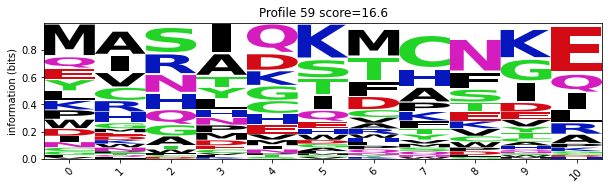

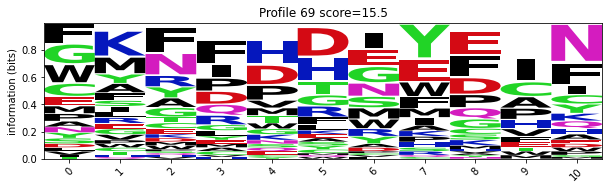

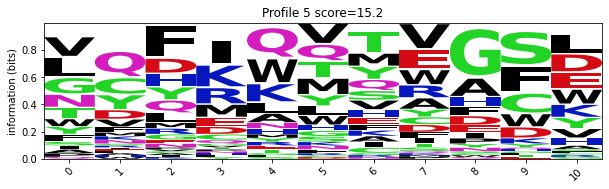

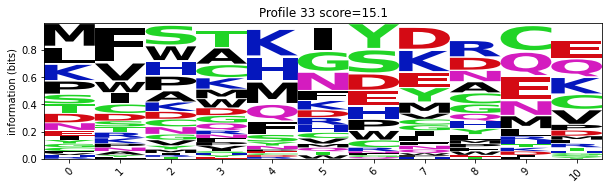

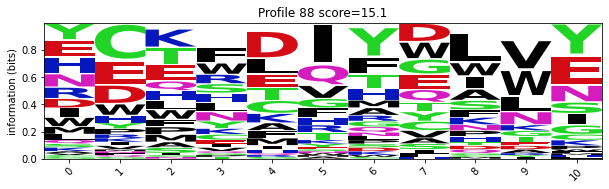

In [24]:
P = specProModel.getP()
pScores = specProModel.max_profile_scores(ds_score)
plotLogo(P=P, idxarray = np.argsort(-pScores), pScores=pScores, max_print=5)
# should be similar to one of ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
# Repeats: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']

---

## Profile Score Distribution

In [25]:
R = specProModel.getR()
minscore = np.array(R).min() * specProModel.k # profile matches not at all
maxscore = np.array(R).max() * specProModel.k # all bases match perfectly
print(minscore, ",", maxscore)
minscore = np.math.floor(minscore)
maxscore = np.math.floor(maxscore)

-138.19031143188477 , 35.65977716445923


     P:     (k, alphSize, U) 
     X:     (batchsize, N, 6, T, alphSize) 
     Z:     (batchsize, N, 6, T-k+1, U)

In [26]:
scoreBins = dict([(b,0) for b in range(minscore, maxscore)])
assert k == R.shape[0]

#for pidx in range(R.shape[2]):
#    profile = R[:,:,pidx]
#    for seqidx in range(X.shape[1]):
#        for frame in range(X.shape[2]):
#            for i in range(0, X.shape[3]-k+1):
#                kmer = X[0,seqidx,frame,range(i,i+k),:]
#                assert kmer.shape == profile.shape, str(kmer.shape)+" != "+str(profile.shape)
#                score = np.math.floor(sum(np.array(kmer*profile).flatten()))
#                assert score in scoreBins, str(score)
#                scoreBins[score] += 1

for batch in ds_score:
    for X in batch:
        S, _, Z = specProModel(X)
        for s in np.array(Z[:,:,:,:,:]).flatten():
            score = np.math.floor(s)
            assert score in scoreBins, str(score)+" ("+str(s)+")"
            scoreBins[score] += 1

#S, R, Z = specProModel(X)
#for s in np.array(Z[:,:,:,:,:]).flatten():
#    score = np.math.floor(s)
#    assert score in scoreBins, str(score)+" ("+str(s)+")"
#    scoreBins[score] += 1

(array([18., 17., 17., 18., 17., 17., 18., 17., 17., 18.]),
 array([-139. , -121.7, -104.4,  -87.1,  -69.8,  -52.5,  -35.2,  -17.9,
          -0.6,   16.7,   34. ]),
 <BarContainer object of 10 artists>)

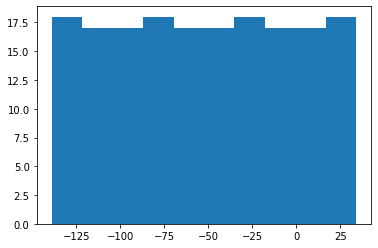

In [27]:
import matplotlib.pyplot as plt

plt.hist(scoreBins)

---

## Find Best Profiles

Idea: 
* convert profiles into aa-sequences (translate max. values into aa at each position)
* align (or perfect match?) sequences against the 6 possible pattern translations and the insert translations
* alignment scores give an idea of how good the profiles are -> allows multiple training runs to account for randomness, evaluate how good the profiles usually are (+ variance)

In [28]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

In [29]:
def runTraining():
    tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
    
    # build and randomly initialize profile model
    specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)
    
    #start = time()
    specProModel.train_ds(ds, steps_per_epoch, epochs=500, verbose=False)
    #end = time()
    #print(f"time: {end-start:.2f}")
    
    #S, R = specProModel(X)
    #L1, L2, L4 = specProModel.loss(S)
    #pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
    #print("pScores", pScores)
    #np.argsort(pScores)
    #print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
    #       "\tL4=", L4.numpy(), "\nS=", S.numpy())
    
    P = specProModel.getP()
    
    return P

In [30]:
def aaFromProfiles(P):
    profiles_aa = []
    for pidx in range(P.shape[2]):
        pmat = P[:,:,pidx]
        profiles_aa.append(su.to_aa_seq(pmat))

    return profiles_aa

In [31]:
def getBestAlignments(profiles, patterns, scoreThreshold = int(k/2)):
    scores = []
    alignments = []
    best_profiles = []
    for profile in profiles:
        pscores = []
        palignments = []
        for pattern in patterns:
            als = pairwise2.align.localxd(profile, pattern, openA=-1000, extendA=-1000, openB=-1000, extendB=-1000)
            s = [al.score for al in als]
            if len(s) > 0:
                pscores.append(np.argmax(s))
                palignments.append(als[np.argmax(s)])

        best_al = palignments[np.argmax(pscores)]
        if best_al.score >= scoreThreshold:
            scores.append(best_al.score)
            alignments.append(best_al)
            best_profiles.append(profile)

    if len(scores) > 0:
        sortedIdx = np.argsort([-s for s in scores])
        scores = [scores[i] for i in sortedIdx]
        alignments = [alignments[i] for i in sortedIdx]
        best_profiles = [best_profiles[i] for i in sortedIdx]
    
    return scores, alignments, best_profiles

In [32]:
if False:
    for i in range(20):
        P = runTraining()
        profiles = aaFromProfiles(P)
        print("Run", i)
        if insertPatterns is not None:
            print("Desired profiles:")
            patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA)
            for i in range(len(patternScores)):
                    print(patternProfiles[i])
                    print(format_alignment(*(patternAlignments[i])))

        if repeatPatterns is not None:
            print("Undesired profiles:")
            repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA)
            for i in range(len(repeatScores)):
                    print(repeatProfiles[i])
                    print(format_alignment(*(repeatAlignments[i])))

        print("")
        print("-----")
        print("")

In [33]:
P = specProModel.getP()
profiles = aaFromProfiles(P)
print("Desired profiles:")
patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
for i in range(len(patternScores)):
        print(patternProfiles[i])
        print(format_alignment(*(patternAlignments[i])))

Desired profiles:
MASIQKMCNKE
MASIQKMCNKE
||.||...|||
MARIQSTANKE
  Score=7

AFSWVMAIIQE
6 MAIIQ
  ||.||
1 MARIQ
  Score=4



In [34]:
R = specProModel.getR()
profiles = aaFromProfiles(R)
print("Desired profiles:")
patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
for i in range(len(patternScores)):
        print(patternProfiles[i])
        print(format_alignment(*(patternAlignments[i])))

Desired profiles:
MCNIQKMCNKE
MCNIQKMCNKE
|..||...|||
MARIQSTANKE
  Score=6

